In [1]:
### Load all the necessary modules
import numpy as np 
import pandas as pd
from datetime import datetime,timedelta
import itertools

from scipy import ndimage

from scipy.stats import norm, poisson, linregress, gaussian_kde, kde, sem
from scipy.stats import f_oneway, pearsonr, ttest_ind,spearmanr
from scipy.stats import levene
from scipy.stats import kstest

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import AnovaRM

import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import ks_2samp
from scipy.stats import rankdata

from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression as LinR


from  matplotlib import pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import networkx as nx 

from scipy.ndimage import gaussian_filter1d as GF
    
from scipy.io import wavfile as wf

import warnings
warnings.filterwarnings('ignore') ### there are deprecation and divide by zero warnings

SAVE = True # Save figs? 

In [2]:
## Load in OG data
fname = './AviaryDataFiles/2010raw_all_timeCorrected2.txt'
my_data = np.genfromtxt(fname, delimiter=',',dtype=str)

m8_data = my_data[my_data[:,6] == 'M8'] ## These ones have lesions, ignore them
m7_data = my_data[my_data[:,6] == 'M7']
m6_data = my_data[my_data[:,6] == 'M6']
m5_data = my_data[my_data[:,6] == 'M5'] ## These ones have lesions, ignore them

In [3]:
## deal with another data file: 
fname2 = './AviaryDataFiles/BS2017.txt'
test_data = np.genfromtxt(fname2,delimiter=',',dtype=str)

reorder = [4,5,6,7,8,1,3]

reorder_data = test_data[:,reorder]

dar_data = reorder_data[reorder_data[:,6] == 'DARWIN']
cop_data = reorder_data[reorder_data[:,6] == 'COOP']


In [4]:
##Even more data files!
data_2006 = np.genfromtxt('./AviaryDataFiles/2006.txt',delimiter=',',dtype=str)
data_2007 = np.genfromtxt('./AviaryDataFiles/2007_spring.txt',delimiter=',',dtype=str)
data_2008 = np.genfromtxt('./AviaryDataFiles/2008.txt',delimiter=',',dtype=str)
data_2009 = np.genfromtxt('./AviaryDataFiles/2009_song.txt',delimiter=',',dtype=str)


## Rearrange the columns to match 2010
reorder = [3,4,5,6,7,1,2]
reorder_2009 = [5,6,7,8,10,1,3]

data_2006 = data_2006[:,reorder]
data_2007 = data_2007[:,reorder]
data_2008 = data_2008[:,reorder]
data_2009 = data_2009[:,reorder_2009]



m1_06data = data_2006[data_2006[:,6] == 'M1']
m2_06data = data_2006[data_2006[:,6] == 'M2']
m3_06data = data_2006[data_2006[:,6] == 'M3']
m4_06data = data_2006[data_2006[:,6] == 'M4']

m1_07data = data_2007[data_2007[:,6] == 'M1']
m2_07data = data_2007[data_2007[:,6] == 'M2']
m3_07data = data_2007[data_2007[:,6] == 'M3']
m4_07data = data_2007[data_2007[:,6] == 'M4']

m1_08data = data_2008[data_2008[:,6] == 'M1']
m2_08data = data_2008[data_2008[:,6] == 'M2']
m3_08data = data_2008[data_2008[:,6] == 'M3']
m4_08data = data_2008[data_2008[:,6] == 'M4']

m6_09data = data_2009[data_2009[:,6] == 'M6']
m7_09data = data_2009[data_2009[:,6] == 'M7']
m8_09data = data_2009[data_2009[:,6] == 'M8']

In [5]:
## Yet more data files. Crazy

data_2001_lna = np.genfromtxt('./AviaryDataFiles/LNA2001.txt',delimiter=',',dtype=str)
data_2002_lna = np.genfromtxt('./AviaryDataFiles/LNA2002.txt',delimiter=',',dtype=str)

data_2001_lsa = np.genfromtxt('./AviaryDataFiles/LSA2001.txt',delimiter=',',dtype=str)
data_2002_lsa = np.genfromtxt('./AviaryDataFiles/LSA2002.txt',delimiter=',',dtype=str)

data_2003_lna = np.genfromtxt('./AviaryDataFiles/LNA2003.txt',delimiter=',',dtype=str)
data_2003_lsa = np.genfromtxt('./AviaryDataFiles/LSA2003.txt',delimiter=',',dtype=str)

## Just need to add an extra column so that things match up
reorder = [0,1,2,3,3,4,5]

m1_01data = data_2001_lna[:,reorder]
m1_02data = data_2002_lna[:,reorder]

m2_01data = data_2001_lsa[:,reorder]
m2_02data = data_2002_lsa[:,reorder]

m1_03data = data_2003_lna[:,reorder]
m2_03data = data_2003_lsa[:,reorder]

print(m1_03data[0])
print(m8_09data[0])

['MNWL' 'MDYG' '' '09:37:24' '09:37:24' '03-04-21' 'LNA']
['MWMG' 'MBOD' '' '10:20:33' '' '09-04-22' 'M8']


In [6]:
## Define some time handling functions
def time_to_sec(h_time):
    hms = h_time.split(':')
    secs = int(hms[0]) * 3600 + int(hms[1]) * 60 + int(hms[2])
    return secs

### Returns the day of year from the unix timestamp.
def day_of_year(datestamp_s):
    return datetime.fromtimestamp(datestamp_s).timetuple().tm_yday

def timestamp_to_ymd(timestamp,date_format = '%Y-%m-%d'):
    return datetime.utcfromtimestamp(timestamp).strftime(date_format)

def date_to_sec(date,date_format = 'ymd'):
    if date_format == 'ymd':
        ymd = date.split('-')
        timestamp = datetime.strptime(date,'%y-%m-%d').timestamp()
    elif date_format == 'mdy':
        mdy = date.split('-')
        ymd = [mdy[2],mdy[0],mdy[1]]
        timestamp = datetime.strptime(date,'%m-%d-%y').timestamp()
    elif date_format == 'dmy':
        dmy = date.split('-')
        ymd = [dmy[2],dmy[1],dmy[0]]
        timestamp = datetime.strptime(date,'%d-%m-%y').timestamp()
    elif date_format == 'Ymd':
        ymd = date.split('-')
        timestamp = datetime.strptime(date,'%Y-%m-%d').timestamp()
    return timestamp, ymd

def get_timestamp(aviary_data,t,date_format='ymd'):
    t_secs = time_to_sec(aviary_data[t,3])
    d_secs,_ = date_to_sec(aviary_data[t,5],date_format)
    return d_secs + t_secs

def get_difference(aviary_data,t0,t1,date_format='ymd'):
    difference = get_timestamp(aviary_data,t1,date_format) - get_timestamp(aviary_data,t0,date_format)
    return difference

## Sort of a hack to deal with older data format
def fake_timestamp(blocked_data,t,year):
    blocks = np.unique(blocked_data[:,5].astype(int))
    n_blocks = len(blocks)
    years = 12 * 31 * 24 * 3600 * year
    fake_day = np.argwhere(blocks == int(blocked_data[t,5]))[0][0]
    days = 24 * 3600 * fake_day
    return days + years

## These are just little wrappers that allow for handling arrays with all nans
def nansumwrapper(a, **kwargs):
    if np.isnan(a).all():
        return np.nan
    else:
        return np.nansum(a, **kwargs)
    
def nanmeanwrapper(a, **kwargs):
    if np.isnan(a).all():
        return np.nan
    else:
        return np.nanmean(a, **kwargs)

In [7]:
## Define this meta data class object. It also perfoms some data parsing to handle dates and such. 
class Meta_data:
    def __init__(self,raw_data,name='unknown',date_format='ymd',start_day=None,cutoff=None):
        self.name = name
        self.n_points = len(raw_data)
        self.date_format = date_format
        
        self.datetime = np.empty([self.n_points],dtype=object)
        self.timestamps = np.empty([self.n_points])        
  
            
        for n in range(self.n_points):
            self.timestamps[n] = get_timestamp(raw_data, n,self.date_format)
            self.datetime[n] = raw_data[n,5] + ' ' + raw_data[n,3]   
        if cutoff != None:
            self.cutoff_dt = datetime.strptime(cutoff,'%y-%m-%d')
            self.cutoff = np.argmax(self.timestamps >= self.cutoff_dt.timestamp())
            self.cutoff_s = (self.cutoff_dt-datetime(1970,1,1)).total_seconds()
        else:
            self.cutoff = self.n_points
            self.cutoff_dt = None  
            self.cutoff_s = None
        if start_day != None:
            self.start_dt = datetime.strptime(start_day,'%y-%m-%d')
            self.start = np.argmax(self.timestamps >= self.start_dt.timestamp())
            self.start_s = (self.start_dt-datetime(1970,1,1)).total_seconds()
        else:
            self.start=0
            self.start_dt,self.cutoff_s = None,None
        self.n_points = self.cutoff - self.start
        tmp_ids = np.unique(raw_data[self.start:self.cutoff,:2])
        b_ids = []
        for t in tmp_ids:
            if len(t) == 0:
                continue
            #if 'M' in t or 'F' in t:
            if t[0] == 'M' or t[0] == 'F':
                if t.upper() == 'FEMALE' or t.upper() == 'MALE':
                    continue
                else:
                    b_ids.append(t.upper()) ## There are some lower case that need to be resolved
        #print(b_ids,self.cutoff)
        self.bird_ids = np.unique(b_ids)
        self.n_birds = len(self.bird_ids)
        self.n_males = len(self.bird_ids[np.char.find(self.bird_ids,'M') == 0])
        self.n_females = len(self.bird_ids[np.char.find(self.bird_ids,'F') == 0])
        self.m_ids = self.bird_ids[np.char.find(self.bird_ids,'M') == 0]
        self.f_ids = self.bird_ids[np.char.find(self.bird_ids,'F') == 0]
        self.indices = dict(zip(self.bird_ids,range(len(self.bird_ids))))
        self.dates = np.unique([raw_data[:self.cutoff,5]])

## Pretty self explanatory function that sorts data by date, needs to know the format.
def sort_data(aviary_data, aviary='Unknown',date_format='ymd',start_day=None,cutoff=None):
    time_stamps = np.zeros([len(aviary_data)])
    for n in range(len(aviary_data)):
        time_stamps[n] = get_timestamp(aviary_data,n,date_format)
    sorted_data = aviary_data[time_stamps.argsort()]
    
    if False: ## You'd think duplicate timestamps were bad, but actually they happen
        sorted_timestamps = time_stamps[time_stamps.argsort()]
        good_times,indices,counts = np.unique(sorted_timestamps,return_counts=True,return_index=True)
        good_indices = indices[counts == 1]
        sorted_data = sorted_data[good_indices]
    
    sorted_data = sorted_data[sorted_data[:,3] != '00:00:00']
    #print(sorted_data)
    return sorted_data, Meta_data(sorted_data, aviary,date_format,start_day=start_day,cutoff=cutoff)


## Define cutoffs (some aviaries had disruptions, we don't use data after that point)
cutoffs = {
    'M1-2006':'2006-05-12',
    'M2-2006':'2006-05-12',
    'M3-2006':'2006-05-12',
    'M4-2006':'2006-05-12',
    'M1-2007':'2007-04-25',
    'M4-2007':'2007-04-25',
    'M2-2008':'2008-04-18',
    'M3-2008':'2008-04-18',
    'M6-2009':'2009-06-03',
    'M8-2009':'2009-06-03'
}

EXCLUDE = False
popped_aviaries = [14,13,12] ## Put the indices of aviaries, in reverse order, that you want to delete

m8_sorted, m8_meta = sort_data(m8_data, aviary='PH8-2010',date_format = 'ymd')
print(len(m8_sorted))

5494


In [8]:
## Build all the sorted and meta data
m8_sorted, m8_meta = sort_data(m8_data, aviary='PH8-2010',date_format = 'ymd')
m7_sorted, m7_meta = sort_data(m7_data, aviary='PH7-2010',date_format = 'ymd')
m6_sorted, m6_meta = sort_data(m6_data, aviary='PH6-2010',date_format = 'ymd')
m5_sorted, m5_meta = sort_data(m5_data, aviary='PH5-2010',date_format = 'ymd')

dar_sorted, dar_meta = sort_data(dar_data, aviary='ON2-2017',date_format = 'dmy')
cop_sorted, cop_meta = sort_data(cop_data, aviary='ON1-2017',date_format = 'dmy')

m16_sorted,m16_meta = sort_data(m1_06data,aviary='PH1-2006',date_format = 'mdy',cutoff = '06-05-12')
m26_sorted,m26_meta = sort_data(m2_06data,aviary='PH2-2006',date_format = 'mdy',cutoff = '06-05-12')
m36_sorted,m36_meta = sort_data(m3_06data,aviary='PH3-2006',date_format = 'mdy',cutoff = '06-05-12')
m46_sorted,m46_meta = sort_data(m4_06data,aviary='PH4-2006',date_format = 'mdy',cutoff = '06-05-12')

## Interestingly, ph3-2007, ph1-2008, and ph4-2008 all have a negative relationship between cohesion and eggs...
## In m1/m4 there was switching going on. The first switch happened 07-04-25, the last switch happened 07-05-16
m17_sorted,m17_meta = sort_data(m1_07data,aviary='PH1-2007',date_format = 'mdy',cutoff = '07-04-25')
m27_sorted,m27_meta = sort_data(m2_07data,aviary='PH2-2007',date_format = 'mdy')
m37_sorted,m37_meta = sort_data(m3_07data,aviary='PH3-2007',date_format = 'mdy') 
m47_sorted,m47_meta = sort_data(m4_07data,aviary='PH4-2007',date_format = 'mdy',cutoff = '07-04-25')


## These ones have lesioned birds, and are thus excluded, but maybe could be included with a cutoff?
## Similarly, lots of switching going on here. First switch is 08-04-18, last switch is 08-05-10
m18_sorted,m18_meta = sort_data(m1_08data,aviary='PH1-2008',date_format = 'mdy')
#m28_sorted,m28_meta = sort_data(m2_08data,aviary='PH2-2008',date_format = 'mdy',cutoff = '08-04-18')
#m38_sorted,m38_meta = sort_data(m3_08data,aviary='PH3-2008',date_format = 'mdy',cutoff = '08-04-18')
m28_sorted,m28_meta = sort_data(m2_08data,aviary='PH2-2008',date_format = 'mdy',start_day = '08-05-10')
m38_sorted,m38_meta = sort_data(m3_08data,aviary='PH3-2008',date_format = 'mdy',start_day = '08-05-10')

m48_sorted,m48_meta = sort_data(m4_08data,aviary='PH4-2008',date_format = 'mdy')

## Grab the post switch datasets:

m17_sorted_post,m17_meta_post = sort_data(m1_07data,aviary='PH1-2007',date_format = 'mdy',start_day = '07-05-16')
m47_sorted_post,m47_meta_post = sort_data(m4_07data,aviary='PH4-2007',date_format = 'mdy',start_day = '07-05-16')
m28_sorted_post,m28_meta_post = sort_data(m2_08data,aviary='PH2-2008',date_format = 'mdy',start_day = '08-05-10')
m38_sorted_post,m38_meta_post = sort_data(m3_08data,aviary='PH3-2008',date_format = 'mdy',start_day = '08-05-10')

## Get 2009 data
m69_sorted,m69_meta = sort_data(m6_09data,aviary='PH6-2009',date_format = 'ymd',cutoff = '09-06-03')
m79_sorted,m79_meta = sort_data(m7_09data,aviary='PH7-2009',date_format = 'ymd')
m89_sorted,m89_meta = sort_data(m8_09data,aviary='PH8-2009',date_format = 'ymd',cutoff = '09-06-03')

## Grab the 2001-2002 experimental data We actually don't need this
#m11_sorted,m11_meta = sort_data(m1_01data,aviary='PH1-2001',date_format = 'ymd')
#m21_sorted,m21_meta = sort_data(m2_01data,aviary='PH2-2001',date_format = 'ymd')


## In 2002, we have data all the way back from february, but to keep things consistent, 
# For now we'll start May 5, which is when the recordings in 2001 started, similarly, we'll end june 11 
m12_sorted,m12_meta = sort_data(m1_02data,aviary='PH1-2002',date_format = 'ymd',start_day = '02-04-21',cutoff='02-06-17')
m22_sorted,m22_meta = sort_data(m2_02data,aviary='PH2-2002',date_format = 'ymd',start_day = '02-04-21',cutoff='02-06-17')

m13_sorted,m13_meta = sort_data(m1_03data,aviary='PH1-2003',date_format = 'ymd')#,start_day = '02-05-05',cutoff='02-06-11')
m23_sorted,m23_meta = sort_data(m2_03data,aviary='PH2-2003',date_format = 'ymd')#,start_day = '02-05-05',cutoff='02-06-11')

## Add the list of juveniles for checking later
m22_meta.juveniles = ['M2MR','MGBR','MLMB','MWYR','MYLW','MYRM','MGOL']
m13_meta.juveniles = ['MG2L','MBRW','MLRM','MGDO','MDRM','MOWN']

m12_meta.juveniles = []
m23_meta.juveniles = []

In [9]:
## Builds history plot of every interaction
def build_history(aviary_data, meta_data):
    interactions = np.zeros([meta_data.n_points, meta_data.n_birds,meta_data.n_birds])
    copulations = np.zeros([meta_data.n_points, meta_data.n_birds, meta_data.n_birds])
    print(meta_data.name,meta_data.start,meta_data.cutoff)
    print(meta_data.n_points)
    for p in range(meta_data.start,meta_data.cutoff):
        i_str = aviary_data[p,0].upper()
        j_str = aviary_data[p,1].upper()
        if i_str in meta_data.indices.keys():
            i = meta_data.indices[i_str]
        else:
            continue
        if j_str in meta_data.indices.keys():
            j = meta_data.indices[j_str]
        else:
            j = i
            #print(aviary_data[p])
        interactions[p-meta_data.start,i,j] = 1
        if aviary_data[p,2] == 'copulation':
            copulations[p-meta_data.start,i,j] = 5
    return interactions, copulations

In [10]:
## This is like build history, but it's cumulative, each point adds to itself
## Additionally, it decays over time. It's good for visualization
## it's pretty neat, play around with it if you want

def overlap_history(aviary_data, meta_data,decay = .99):
    interactions = np.zeros([meta_data.cutoff-meta_data.start, meta_data.n_birds, meta_data.n_birds])
    copulations = np.zeros_like(interactions)
    lag = decay
    for p in range(meta_data.start,meta_data.cutoff):
        i_str = aviary_data[p,0]
        j_str = aviary_data[p,1]
        i = meta_data.indices[i_str]
        if j_str in meta_data.indices.keys():
            j = meta_data.indices[j_str]
        else:
            j = i
        interactions[p,i,j] = 1
        interactions[p,:,:] = interactions[p,:,:] + interactions[p-1,:,:] * lag
        if aviary_data[p,2] == 'copulation':
            #print('Copulation!')
            copulations[p,i,j] = 5
        copulations[p,:,:] = copulations[p,:,:] + copulations[p-1,:,:] ** .99
    return interactions, copulations

In [11]:
## Build all the history objects, as well as the lists of histories, sorteds, and meta data

m8_history, m8_copulations = build_history(m8_sorted, m8_meta)
m7_history, m7_copulations = build_history(m7_sorted, m7_meta)
m6_history, m6_copulations = build_history(m6_sorted, m6_meta)
m5_history, m5_copulations = build_history(m5_sorted, m5_meta)

cop_history, cop_copulations = build_history(cop_sorted,cop_meta)
dar_history, dar_copulations = build_history(dar_sorted,dar_meta)

m16_history,m16_copulations = build_history(m16_sorted,m16_meta)
m26_history,m26_copulations = build_history(m26_sorted,m26_meta)
m36_history,m36_copulations = build_history(m36_sorted,m36_meta)
m46_history,m46_copulations = build_history(m46_sorted,m46_meta)

m17_history,m17_copulations = build_history(m17_sorted,m17_meta)
m27_history,m27_copulations = build_history(m27_sorted,m27_meta)
m37_history,m37_copulations = build_history(m37_sorted,m37_meta)
m47_history,m47_copulations = build_history(m47_sorted,m47_meta)

m18_history,m18_copulations = build_history(m18_sorted,m18_meta)
m28_history,m28_copulations = build_history(m28_sorted,m28_meta)
m38_history,m38_copulations = build_history(m38_sorted,m38_meta)
m48_history,m48_copulations = build_history(m48_sorted,m48_meta)

m17_history_post,_ = build_history(m17_sorted_post,m17_meta_post)
m47_history_post,_ = build_history(m47_sorted_post,m47_meta_post)
m28_history_post,_ = build_history(m28_sorted_post,m28_meta_post)
m38_history_post,_ = build_history(m38_sorted_post,m38_meta_post)

m69_history,m69_copulations = build_history(m69_sorted,m69_meta)
m79_history,m79_copulations = build_history(m79_sorted,m79_meta)
m89_history,m89_copulations = build_history(m89_sorted,m89_meta)

#m11_history,m11_copulations = build_history(m11_sorted,m11_meta)
#m21_history,m21_copulations = build_history(m21_sorted,m21_meta)

m12_history,m12_copulations = build_history(m12_sorted,m12_meta)
m22_history,m22_copulations = build_history(m22_sorted,m22_meta)

m13_history,m13_copulations = build_history(m13_sorted,m13_meta)
m23_history,m23_copulations = build_history(m23_sorted,m23_meta)
## Some aviaries have lesions (m5,m8) and others have repeat birds (2008) so we don't include those
historys = [m16_history,m26_history,m36_history,m46_history,
            m17_history,m27_history,m37_history,m47_history,
            m18_history,m28_history,m38_history,m48_history,
            m69_history,m79_history,m89_history,
            m6_history,m7_history,cop_history,dar_history] 
sorteds = [m16_sorted,m26_sorted,m36_sorted,m46_sorted,
           m17_sorted,m27_sorted,m37_sorted,m47_sorted,
           m18_sorted,m28_sorted,m38_sorted,m48_sorted,
           m69_sorted,m79_sorted,m89_sorted,
           m6_sorted, m7_sorted, cop_sorted, dar_sorted]
metas = [m16_meta,m26_meta,m36_meta,m46_meta,
         m17_meta,m27_meta,m37_meta,m47_meta,
         m18_meta,m28_meta,m38_meta,m48_meta,
         m69_meta,m79_meta,m89_meta,
         m6_meta,m7_meta,cop_meta,dar_meta]

if EXCLUDE:
    for a in popped_aviaries:
        historys.pop(a)
        sorteds.pop(a)
        metas.pop(a)
        
pre_historys = [m17_history,m47_history,m28_history,m38_history]
post_historys = [m17_history_post,m47_history_post,m28_history_post,m38_history_post]

pre_metas = [m17_meta,m47_meta,m28_meta,m38_meta]
post_metas = [m17_meta_post,m47_meta_post,m28_meta_post,m38_meta_post]

pre_sorteds = [m17_sorted,m47_sorted,m28_sorted,m38_sorted]
post_sorteds = [m17_sorted_post,m47_sorted_post,m28_sorted_post,m38_sorted_post]

exp_historys = [m12_history,m22_history,m13_history,m23_history]
exp_metas = [m12_meta,m22_meta,m13_meta,m23_meta]
exp_sorteds = [m12_sorted,m22_sorted,m13_sorted,m23_sorted]

copulations = [m16_copulations,m26_copulations,m36_copulations,m46_copulations,
               m17_copulations,m27_copulations,m37_copulations,m47_copulations,
               m18_copulations,m28_copulations,m38_copulations,m48_copulations, 
               m69_copulations,m79_copulations,m89_copulations,
               m6_copulations,m7_copulations,cop_copulations,dar_copulations]

PH8-2010 0 5494
5494
PH7-2010 0 7075
7075
PH6-2010 0 6794
6794
PH5-2010 0 6076
6076
ON1-2017 0 4569
4569
ON2-2017 0 3522
3522
PH1-2006 0 2923
2923
PH2-2006 0 3651
3651
PH3-2006 0 3762
3762
PH4-2006 0 4260
4260
PH1-2007 0 4747
4747
PH2-2007 0 10676
10676
PH3-2007 0 10186
10186
PH4-2007 0 4367
4367
PH1-2008 0 7952
7952
PH2-2008 3591 6869
3278
PH3-2008 3972 7929
3957
PH4-2008 0 8968
8968
PH1-2007 6558 11214
4656
PH4-2007 6132 10052
3920
PH2-2008 3591 6869
3278
PH3-2008 3972 7929
3957
PH6-2009 0 8103
8103
PH7-2009 0 4593
4593
PH8-2009 0 7771
7771
PH1-2002 13854 31539
17685
PH2-2002 15926 30298
14372
PH1-2003 0 12683
12683
PH2-2003 0 13610
13610


In [12]:
# Define Binning functions
sorted_data = sorteds[0]
meta = metas[0]

## Simple version that just returns a binned version of history
# Returns history_bins,[history_rate_bins,ts,window_indices]
def bin_history(sorted_data,history_data,meta_data,window=100):
    zero_hour = datetime.strptime('00:00:00','%H:%M:%S')

    ts, windows = [],[]
    window_indices = []
    count = 0
    history_bins = []
    history_rate_bins = []
    m_count,f_count,u_count = 0,0,0
    bin_start = meta_data.timestamps[meta_data.start]
    i_start = 0
    for t in range(meta_data.start,meta_data.cutoff): ## Don't forget that I'm cutting off some later stuff for now
        dt = datetime.fromtimestamp(meta_data.timestamps[t])
        if dt.time() == zero_hour.time():
            continue
        elif bin_start == 0:
            bin_start = meta_data.timestamps[t-1]
            i_start = t-1 - meta_data.start
        ## If it's been a while, store the previous bin and start a new bin
        #print(t,bin_start,meta_data.timestamps[t] - bin_start,count,m_count,windows)
        
        ## Need to define windows in order to pull out the history bins.
        ## Start_t = bin_start -> 
        if meta_data.timestamps[t] - bin_start >= window:
            if count == 1:  ## How do we account for windows of size 0...could use more info here
                pass
            elif count != 0:  ## What if we do have a long window with no songs?
                history_t = np.sum(history_data[i_start:t-1-meta_data.start],0)

                ts.append(bin_start)
                win_size = meta_data.timestamps[t-1] - bin_start + 1
                if win_size < window:
                    win_size = window
                    pass
                windows.append(win_size)
                window_indices.append([i_start,t-1])
                
                history_rate = history_t / win_size
                history_bins.append(history_t)
                history_rate_bins.append(history_rate)
                if np.sum(history_t) == 0:
                    import pdb
                    pdb.set_trace()
            count = 0
            bin_start = 0 #meta_data.timestamps[t]
        count += 1

        
    ts = np.array(ts)
    windows = np.array(windows)
    history_bins = np.array(history_bins)
    history_rate_bins = np.array(history_rate_bins)

    return history_bins,[history_rate_bins,ts,window_indices]
  
## As above, but I use a sliding bin to (hopefully) avoid edge artifacts
def sliding_bin_history(sorted_data,history_data,meta_data,window=100):
    zero_hour = datetime.strptime('00:00:00','%H:%M:%S')

    ts, windows = [],[]
    window_indices = []
    count = 0
    history_bins = []
    history_rate_bins = []
    m_count,f_count,u_count = 0,0,0
    bin_start = meta_data.timestamps[meta_data.start]
    i_start = 0
    
    t = meta_data.start -1
    halfway = False
    #print(meta_data.cutoff,len(meta_data.timestamps))
    while t < meta_data.cutoff-1: ## This is not perfectly efficient, but it's much easier.
        t += 1
        #print(t)
        dt = datetime.fromtimestamp(meta_data.timestamps[t])
        if dt.time() == zero_hour.time():
            continue
        elif bin_start == 0:
            bin_start = meta_data.timestamps[t]
            i_start = t - meta_data.start
        ## If it's been a while, store the previous bin and start a new bin
        #print(t,bin_start,meta_data.timestamps[t] - bin_start,count,m_count,windows)
        
        ## Need to define windows in order to pull out the history bins.
        ## Start_t = bin_start ->
            
        if meta_data.timestamps[t] - bin_start >= window/2 and halfway == False:
            halfway = int(t)
        
        ## NOTE that this brings in a bit of weirdness at the gaps, but I guess that's the nature of smoothing
        if meta_data.timestamps[t] - bin_start >= window:
            #print('making a window at',t,meta_data.timestamps[t])
            if count == 1:  ## How do we account for windows of size 0...could use more info here
                pass
            elif count != 0:  ## What if we do have a long window with no songs?
                history_t = np.sum(history_data[i_start:t-meta_data.start],0)

                ts.append(bin_start)
                win_size = meta_data.timestamps[t-1] - bin_start + 1
                if win_size < window:
                    win_size = window
                    pass
                windows.append(win_size)
                window_indices.append([i_start,t-1])
                
                history_rate = history_t / win_size
                history_bins.append(history_t)
                history_rate_bins.append(history_rate)
                #print('storying')
                if halfway == t:
                    #t -= 1
                    halfway = False
                else:
                    t = halfway
                    halfway = False
                
                if np.sum(history_t) == 0:
                    ## findme
                    import pdb
                    pdb.set_trace()
            count = 0
            bin_start = 0 #meta_data.timestamps[t]

        count += 1
        #print(t,halfway,bin_start,meta_data.timestamps[t])
        
    ts = np.array(ts)
    windows = np.array(windows)
    history_bins = np.array(history_bins)
    history_rate_bins = np.array(history_rate_bins)

    return history_bins,[history_rate_bins,ts,window_indices] 
                        
                        
## Shuffle bins while keeping individual male behavior consistent. 
def shuffle_indy_bins(history_bins):
    n_birds = history_bins.shape[1]
    shuffle_bins = np.empty_like(history_bins)
    for s in range(n_birds):
        singer_bins = history_bins[:,s]
        singer_shuffle = np.random.permutation(singer_bins)
        shuffle_bins[:,s] = singer_shuffle
    return shuffle_bins

def shift_indy_bins(history_bins):
    n_birds = history_bins.shape[1]
    shifted_bins = np.empty_like(history_bins)
    n_bins = history_bins.shape[0]
    for s in range(n_birds):
        singer_bins = history_bins[:,s]
        random_start = np.random.randint(0,n_bins)
        idx = np.mod(random_start + np.arange(n_bins), n_bins)
        singer_shift = np.array(singer_bins[idx])
        shifted_bins[:,s] = singer_shift
    return shifted_bins

def count_sequence(sorted_data,meta,window=100,plot_me=False,g_kernel = .5,t0=0):
    zero_hour = datetime.strptime('00:00:00','%H:%M:%S')

    all_counts_m = []
    all_counts_f = []
    all_counts_u = []
    all_counts_sum = []
    ts, windows = [],[]
    window_indices = []
    count = 0
    
    m_count,f_count,u_count = 0,0,0
    bin_start = meta.timestamps[0]
    i_start = 0
    for t in range(len(meta.timestamps)):
        dt = datetime.fromtimestamp(meta.timestamps[t])
        if dt.time() == zero_hour.time():
            continue
        elif bin_start == 0:
            bin_start = meta.timestamps[t-1]
            i_start = t-1
        ## If it's been a while, store the previous bin and start a new bin
        #print(t,bin_start,meta.timestamps[t] - bin_start,count,m_count,windows)
        
        ## Need to define windows in order to pull out the history bins.
        ## Start_t = bin_start -> 
        if meta.timestamps[t] - bin_start >= window:
            if count == 1:  ## How do we account for windows of size 0...could use more info here
                pass
            elif count != 0:  ## What if we do have a long window with no songs?
                all_counts_f.append(f_count)
                all_counts_m.append(m_count)
                all_counts_u.append(u_count)
                all_counts_sum.append(count)
                ts.append(bin_start)
                win_size = meta.timestamps[t-1] - bin_start + 1
                if win_size < window:
                    win_size = window
                    pass
                windows.append(win_size) ## 
                window_indices.append([i_start,t-1])
            count = 0
            m_count,f_count,u_count = 0,0,0
            bin_start = 0 #meta.timestamps[t]
            ## If it's a big jump, make it clear that it's not continuous
            if meta.timestamps[t] - meta.timestamps[t-1] >= 600:
                all_counts_f.extend([np.nan])
                all_counts_m.extend([np.nan])
                all_counts_u.extend([np.nan])
                all_counts_sum.extend([np.nan])
                ts.append(meta.timestamps[t-1] + 1) ## Add the start of a gap, 1s after the previous label
                windows.append(meta.timestamps[t] - meta.timestamps[t-1] - 1) ## Add length of gap
        singer = sorted_data[t,0]
        receiver = sorted_data[t,1]
        if singer[0].upper() == 'M':
            if receiver == '':
                # undirected
                u_count += 1
            elif receiver[0].upper() == 'M':
                # Male directed
                m_count += 1
            elif receiver[0].upper() == 'F':
                # Female directed
                f_count += 1
        else:
            pass ## No songs, but it was an event, still worth counting I think
        count += 1

    all_counts_m = np.array(all_counts_m)
    all_counts_f = np.array(all_counts_f)
    all_counts_u = np.array(all_counts_u)
    all_counts_sum = np.array(all_counts_sum)
    ts = np.array(ts)
    windows = np.array(windows)
    male_high = all_counts_m > all_counts_f
    female_high = all_counts_f > all_counts_m

    #print(all_counts_m,windows)
    male_counts_per_min = np.divide(all_counts_m,windows) * 60
    female_counts_per_min = np.divide(all_counts_f,windows) * 60
    undirected_counts_per_min = np.divide(all_counts_u,windows) * 60
    
    ## Count up the lengths of segments
    m_lengths = [ sum( 1 for _ in group ) for key, group in itertools.groupby( male_high ) if key == 1 ]
    f_lengths = [ sum( 1 for _ in group ) for key, group in itertools.groupby( female_high ) if key == 1 ]

    if plot_me == -1:
        male_counts_per_min = male_counts_per_min[~np.isnan(male_counts_per_min)]
        female_counts_per_min = female_counts_per_min[~np.isnan(female_counts_per_min)]
        undirected_counts_per_min = undirected_counts_per_min[~np.isnan(undirected_counts_per_min)]
        fig,ax = plt.subplots()
        ax.hist2d(male_counts_per_min,female_counts_per_min)
        #ax.scatter(male_counts_per_min,female_counts_per_min,alpha=.1)
        ax.set_xlabel('male songs per minute')
        ax.set_ylabel('female songs per minute')
        #print(male_counts_per_min.shape)
        ax.set_xlim([0,np.nanmax(male_counts_per_min)])
        ax.set_ylim([0,np.nanmax(female_counts_per_min)])
        #print(all_counts_m,male_counts_per_min)
        fig.show()
    
    if plot_me == -2:
        fig,ax = plt.subplots()
        nbins = 20
        male_counts_per_min = male_counts_per_min[~np.isnan(male_counts_per_min)]
        female_counts_per_min = female_counts_per_min[~np.isnan(female_counts_per_min)]  
        x,y = male_counts_per_min,female_counts_per_min
        k = kde.gaussian_kde([x,y],bw_method=g_kernel)
        xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
        zi = k(np.vstack([xi.flatten(), yi.flatten()]))
        ax.set_title(meta.name)
        ax.set_xlabel('Male songs per minute')
        ax.set_ylabel('Female songs per minute')
        ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.jet)
        ax.contour(xi, yi, zi.reshape(xi.shape),cmap='viridis_r')
        fig.show()
        
    if plot_me > 0:
        fig,ax = plt.subplots()
        ax.hist(m_lengths,alpha=.4,label='Male Directed Sequences')
        ax.hist(f_lengths,alpha=.4,label='Female Directed Sequences')
        ax.set_title(meta.name)
        ax.set_xlabel('length of segments')
        ax.set_ylabel('counts')
        ax.set_xlim([1,10])
        ax.legend()
        fig.show()

    if plot_me > 1:
        xs = ts[~np.isnan(male_counts_per_min)]
        male_counts_per_min = male_counts_per_min[~np.isnan(male_counts_per_min)]
        female_counts_per_min = female_counts_per_min[~np.isnan(female_counts_per_min)]
        undirected_counts_per_min = undirected_counts_per_min[~np.isnan(undirected_counts_per_min)]
        
        fig,(ax,ax1) = plt.subplots(2)

        ax.hist(all_counts_m[~np.isnan(all_counts_m)],alpha=.5)
        ax.hist(all_counts_f[~np.isnan(all_counts_f)],alpha=.5)

        ax.hist(all_counts_u[~np.isnan(all_counts_u)],alpha=.5)

        print(ts.shape)
        
        xs_nan = ts[np.isnan(all_counts_m)]
        
        #for x in xs_nan:
        #    ax1.axvline(x,color='black')
        if False:
            ax1.scatter(xs,GF(all_counts_m[~np.isnan(all_counts_m)],g_kernel),label='male directed',marker='.')
            ax1.scatter(xs,GF(all_counts_f[~np.isnan(all_counts_m)],g_kernel),label='female directed',marker='.')

            ax1.scatter(xs,GF(all_counts_u[~np.isnan(all_counts_m)],g_kernel),label='undirected',marker='.')
        
        #xs = np.arange(len(all_counts_m[~np.isnan(all_counts_m)]))
        #print(male_counts_per_min.shape,xs.shape)
        if False:
            ax1.scatter(xs,GF(male_counts_per_min,g_kernel),label='male directed',marker='.')
            ax1.scatter(xs,GF(female_counts_per_min,g_kernel),label='female directed',marker='.')
            ax1.scatter(xs,GF(undirected_counts_per_min,g_kernel),label='undirected',marker='.')
        
        #print(xs,male_counts_per_min)
        ax1.scatter(xs,male_counts_per_min,label='male directed',marker='.')
        ax1.scatter(xs,female_counts_per_min,label='female directed',marker='.')
        ax1.scatter(xs,undirected_counts_per_min,label='undirected',marker='.')
        
        ax1.plot(xs,male_counts_per_min,linestyle=':')
        ax1.plot(xs,female_counts_per_min,linestyle=':')
        ax1.plot(xs,undirected_counts_per_min,linestyle=':')
        
        ax1.set_ylabel('Songs per minute')
        
        ax1.set_xlim([ts[t0]-30,ts[t0]+2030])
        #ax1.set_xlim([300,350])
        ax1.legend()
        
        fig.set_size_inches([10,5])
        fig.show()
        
    return [all_counts_m,all_counts_f,all_counts_u],window_indices


## Get the indices where copulations occured
def get_cop_indices(copulation_history):
    bin_counts = np.sum(copulation_history,axis=(1,2))
    return np.arange(len(bin_counts))[bin_counts >= 1]

## Convert history indices into bin indices
def get_cop_bins(cop_indices,window_indices):
    cop_bins = []
    for i in range(len(window_indices)):
        wins = window_indices[i]
        for j in cop_indices:
            if j>=wins[0] and j<=wins[1]:
                cop_bins.append(i)
    return np.array(cop_bins)

%matplotlib inline
for a in range(len(metas)):
    pass
    #all_counts,window_indices = count_sequence(sorteds[a],metas[a],window=200,plot_me=-2,g_kernel = .1,t0=-234)
    #print(all_counts[0])
history_bins,_ = bin_history(sorteds[9],historys[9],metas[9],window=200)
sliding_bins,_ = sliding_bin_history(sorteds[9],historys[9],metas[9],window=100)
print(history_bins.shape)
print(sliding_bins.shape)

"""print(metas[0].cutoff)
print(len(sorteds[0]),historys[0].shape)"""
pass

(229, 16, 16)
(581, 16, 16)


In [13]:
## Optionally Export the history data to use seperately
if False:
    with open('./AviaryDataFiles/ph1-2006-history.npy','wb') as f:
        np.save(f,historys[0])

In [14]:
## Define Function for Parsing egg data

# This spits out the egg_array, which is n_dates x n_females x 3: [Fertile, Not_fertile, unknown]
# It also returns datestamps, which is just a list of dates that they checked eggs on. Voila!

def parse_eggs(aviary_eggs,meta,date_format = None,start_day = None):
    ## Build date array and key
    if date_format == None:
        date_format = meta.date_format
    if date_format == 'ymd':
        date_format2 = '%y-%m-%d'
    elif date_format == 'Ymd':
        date_format2 = '%Y-%m-%d'
    else:
        print('Somebody set us up a bad format.')
    date_stamps = []
    dates = np.unique(aviary_eggs[:,1])

    if start_day is not None:
        start_stamp,_ = date_to_sec(start_day,date_format)
        date_stamps.append(start_stamp)


    for d in range(len(dates)):
        timestamp,_ = date_to_sec(dates[d],date_format)
        if start_day is not None:
            if timestamp < start_stamp:
                continue
        date_stamps.append(timestamp)

    # Sort, and identify timespan
    date_stamps = sorted(date_stamps)
    delta_s = date_stamps[-1] - date_stamps[0]
    delta_d = delta_s / 3600 / 24

    ## Fill in the missing dates
    date_stamps = np.arange(date_stamps[0],date_stamps[-1] + 3600,3600*24)
    dates = [timestamp_to_ymd(t,date_format2) for t in date_stamps]

    #print(len(dates),len(date_stamps))
    
    #n_dates = 14
    f_ids = meta.f_ids

    n_females = meta.n_females
    egg_array= np.zeros([len(dates),n_females+1,3])

    for d in range(len(dates)):
        eggs_by_date = aviary_eggs[aviary_eggs[:,1] == dates[d]]

        ## First sum up totals
        egg_labels,egg_counts = np.unique(eggs_by_date[:,4],return_counts=True)

        F_count = np.sum(egg_counts[egg_labels == 'F'])
        N_count = np.sum(egg_counts[egg_labels=='NF'])
        Un_count = np.sum(egg_counts) - F_count - N_count

        # Sum up each individual bird
        for f in range(len(f_ids)):
            eggs_by_female = eggs_by_date[eggs_by_date[:,9] == f_ids[f]]
            egg_labels_f,egg_counts_f = np.unique(eggs_by_female[:,4],return_counts=True)

            F_count_f = np.sum(egg_counts_f[egg_labels_f == 'F'])
            N_count_f = np.sum(egg_counts_f[egg_labels_f =='NF'])
            Un_count_f = np.sum(egg_counts_f) - F_count_f - N_count_f

            #print(F_count_f,N_count_f, Un_count_f)
            egg_array[d,f] = [F_count_f,N_count_f,Un_count_f]
        # Subtract total from individual to get unknown birds. In many years, most birds are unknown!
        totes_fem = np.sum(egg_array[d],0)
        egg_array[d,-1] = np.array([F_count,N_count,Un_count]) - totes_fem

    return egg_array,date_stamps
    


In [15]:
## SKIPPED: One time Fix 2006-2008 data to be consistent, might need to do this with other files too...

if False:
    outfile = open('./AviaryDataFiles/2006_eggs_corrected.txt','w')
    with open('./AviaryDataFiles/2006_eggs.txt') as f:
        for line in f:
            split_line = line.split(',')
            for c in range(len(split_line)):
                split_line[c] = split_line[c].replace('/','-')
            mdy = split_line[1].split('-')
            for i in range(3):
                if len(mdy[i]) == 1:
                    mdy[i] = '0' + mdy[i]
            ymd = '-'.join([mdy[2],mdy[0],mdy[1]])
            split_line[1] = ymd
            outfile.write(','.join(split_line))
    outfile.close()

if False:
    outfile = open('./AviaryDataFiles/2008_eggs_corrected.txt','w')
    with open('./AviaryDataFiles/2008_eggs.txt') as f:
        for line in f:
            split_line = line.split(',')
            for c in range(len(split_line)):
                split_line[c] = split_line[c].replace('/','-')
            mdy = split_line[1].split('-')
            for i in range(3):
                if len(mdy[i]) == 1:
                    mdy[i] = '0' + mdy[i]
            ymd = '-'.join([mdy[2],mdy[0],mdy[1]])
            print(ymd)
            split_line[1] = ymd
            outfile.write(','.join(split_line))
    outfile.close()

if False: 
    outfile = open('./AviaryDataFiles/2017_eggs_corrected.txt','w')
    with open('./AviaryDataFiles/2017_eggs_reshape.csv','r') as f:    
        for line in f:
            split_line = line.split(',')
            #print(split_line)
            mdy = split_line[1].split(' ')[0]
            mdy = mdy.split('/')
            for i in range(3):
                if len(mdy[i]) == 1:
                    mdy[i] = '0' + mdy[i]
            ymd = '-'.join([mdy[2],mdy[0],mdy[1]])
            split_line[1] = ymd
            split_line[2] = split_line[2][:4]
            outfile.write(','.join(split_line))
    outfile.close()       

In [16]:
## Parse Egg files!

## Needed to correct the format in 2006...see cell above
eggs_2006 = np.genfromtxt('./AviaryDataFiles/2006_eggs_corrected.txt',delimiter=',',dtype=str)
eggs_2007 = np.genfromtxt('./AviaryDataFiles/2007_eggs_corrected.txt',delimiter=',',dtype=str)
eggs_2008 = np.genfromtxt('./AviaryDataFiles/2008_eggs_corrected.txt',delimiter=',',dtype=str)

eggs_2009 = np.genfromtxt('./AviaryDataFiles/Eggs_2009.txt',delimiter=',',dtype=str)
eggs_2010 = np.genfromtxt('./AviaryDataFiles/Eggs_2010.txt',delimiter=',',dtype=str)

eggs_2017 = np.genfromtxt('./AviaryDataFiles/2017_eggs_corrected.txt',delimiter=',',dtype=str)

eggs_2001 = np.genfromtxt('./AviaryDataFiles/Eggs_2001.txt',delimiter=',',dtype=str)
eggs_2002 = np.genfromtxt('./AviaryDataFiles/Eggs_2002.txt',delimiter=',',dtype=str)
eggs_2003 = np.genfromtxt('./AviaryDataFiles/Eggs_2003.txt',delimiter=',',dtype=str)

padding = [0,1,2,3,4,5,6,7,7,7]
padding3 =[0,1,2,3,4,4,4,4,4,4]
eggs_2001 = eggs_2001[:,padding]
eggs_2002 = eggs_2002[:,padding]
eggs_2003 = eggs_2003[:,padding3]

m16_egg_data = eggs_2006[eggs_2006[:,2] == 'M1']
m26_egg_data = eggs_2006[eggs_2006[:,2] == 'M2']
m36_egg_data = eggs_2006[eggs_2006[:,2] == 'M3']
m46_egg_data = eggs_2006[eggs_2006[:,2] == 'M4']

m17_egg_data = eggs_2007[eggs_2007[:,2] == 'M1']
m27_egg_data = eggs_2007[eggs_2007[:,2] == 'M2']
m37_egg_data = eggs_2007[eggs_2007[:,2] == 'M3']
m47_egg_data = eggs_2007[eggs_2007[:,2] == 'M4']

m18_egg_data = eggs_2008[eggs_2008[:,2] == 'M1']
m28_egg_data = eggs_2008[eggs_2008[:,2] == 'M2']
m38_egg_data = eggs_2008[eggs_2008[:,2] == 'M3']
m48_egg_data = eggs_2008[eggs_2008[:,2] == 'M4']

m29_egg_data = eggs_2009[eggs_2009[:,2] == 'M2']
m69_egg_data = eggs_2009[eggs_2009[:,2] == 'M6']
m79_egg_data = eggs_2009[eggs_2009[:,2] == 'M7']
m89_egg_data = eggs_2009[eggs_2009[:,2] == 'M8']

m50_egg_data = eggs_2010[eggs_2010[:,2] == 'M5']
m60_egg_data = eggs_2010[eggs_2010[:,2] == 'M6']
m70_egg_data = eggs_2010[eggs_2010[:,2] == 'M7']
m80_egg_data = eggs_2010[eggs_2010[:,2] == 'M8']

cop_egg_data = eggs_2017[eggs_2017[:,2] == 'COOP']
dar_egg_data = eggs_2017[eggs_2017[:,2] == 'DARW']

m11_egg_data = eggs_2001[eggs_2001[:,2] == 'LNA']
m21_egg_data = eggs_2001[eggs_2001[:,2] == 'LSA']

m12_egg_data = eggs_2002[eggs_2002[:,2] == 'LNA']
m22_egg_data = eggs_2002[eggs_2002[:,2] == 'LSA']

m13_egg_data = eggs_2003[eggs_2003[:,2] == 'LNA']
m23_egg_data = eggs_2003[eggs_2003[:,2] == 'LSA']

m80_egg_array,m80_datestamps = parse_eggs(m80_egg_data,m8_meta,date_format='Ymd')
m70_egg_array,m70_datestamps = parse_eggs(m70_egg_data,m7_meta,date_format='Ymd')
m60_egg_array,m60_datestamps = parse_eggs(m60_egg_data,m6_meta,date_format='Ymd')
m50_egg_array,m50_datestamps = parse_eggs(m50_egg_data,m5_meta,date_format='Ymd')


## Have to set the start day (and probably the end day) so that they don't appear better than they are
m16_egg_array,m16_datestamps = parse_eggs(m16_egg_data,m16_meta,date_format='Ymd',start_day='2006-05-05')
m26_egg_array,m26_datestamps = parse_eggs(m26_egg_data,m26_meta,date_format='Ymd',start_day='2006-05-05')
m36_egg_array,m36_datestamps = parse_eggs(m36_egg_data,m36_meta,date_format='Ymd',start_day='2006-05-05')
m46_egg_array,m46_datestamps = parse_eggs(m46_egg_data,m46_meta,date_format='Ymd',start_day='2006-05-05')

## M17 & M47 switch on 5-16, if we want to avoid those males' start a week after on 05-23
m17_egg_array,m17_datestamps = parse_eggs(m17_egg_data,m17_meta,date_format='Ymd',start_day='2007-05-16') ##
m27_egg_array,m27_datestamps = parse_eggs(m27_egg_data,m27_meta,date_format='Ymd',start_day='2007-05-05')
m37_egg_array,m37_datestamps = parse_eggs(m37_egg_data,m37_meta,date_format='Ymd',start_day='2007-05-05') 
m47_egg_array,m47_datestamps = parse_eggs(m47_egg_data,m47_meta,date_format='Ymd',start_day='2007-05-16') ##

## M28 & M38 switch on 5-10, if we want to avoid those males' start a week after on 05-17
m18_egg_array,m18_datestamps = parse_eggs(m18_egg_data,m18_meta,date_format='Ymd',start_day='2008-04-23')
m28_egg_array,m28_datestamps = parse_eggs(m28_egg_data,m28_meta,date_format='Ymd',start_day='2008-05-17') ##
m38_egg_array,m38_datestamps = parse_eggs(m38_egg_data,m38_meta,date_format='Ymd',start_day='2008-05-17') ##
m48_egg_array,m48_datestamps = parse_eggs(m48_egg_data,m48_meta,date_format='Ymd',start_day='2008-04-23')


#m29_egg_array,m29_datestamps = parse_eggs(m29_eggs,m#_meta) # No data gathered there
m69_egg_array,m69_datestamps = parse_eggs(m69_egg_data,m69_meta,date_format='Ymd',start_day='2009-05-04')
## 2007 aviary is trouble, should maybe exclude...
## Birds weren't allowed to copulate until May 17th, but already had some exposure to eachother in Octomom
m79_egg_array,m79_datestamps = parse_eggs(m79_egg_data,m79_meta,date_format='Ymd',start_day='2009-05-18') 
m89_egg_array,m89_datestamps = parse_eggs(m89_egg_data,m89_meta,date_format='Ymd',start_day='2009-05-04')

cop_egg_array,cop_datestamps = parse_eggs(cop_egg_data,cop_meta,date_format='Ymd',start_day='2017-05-18')
dar_egg_array,dar_datestamps = parse_eggs(dar_egg_data,dar_meta,date_format='Ymd',start_day='2017-05-18')

## I don't actually need these, Dave sent the wrong year. 
#m11_egg_array,m11_datestamps = parse_eggs(m11_egg_data,m11_meta,date_format='Ymd',start_day='2001-05-07')
#m21_egg_array,m21_datestamps = parse_eggs(m21_egg_data,m21_meta,date_format='Ymd',start_day='2001-05-07')

m12_egg_array,m12_datestamps = parse_eggs(m12_egg_data,m12_meta,date_format='Ymd',start_day='2002-05-07')
m22_egg_array,m22_datestamps = parse_eggs(m22_egg_data,m22_meta,date_format='Ymd',start_day='2002-05-07')

m13_egg_array,m13_datestamps = parse_eggs(m13_egg_data,m13_meta,date_format='ymd')
m23_egg_array,m23_datestamps = parse_eggs(m23_egg_data,m23_meta,date_format='ymd')

exp_eggs = [m12_egg_array,m22_egg_array,m13_egg_array,m23_egg_array]
exp_datestamps = [m12_datestamps,m22_datestamps,m13_datestamps,m23_datestamps]

"""
egg16_cutoff = np.argmin(m16_datestamps <= m16_meta.timestamps[m16_meta.cutoff])
egg26_cutoff = np.argmin(m26_datestamps <= m26_meta.timestamps[m26_meta.cutoff])
egg36_cutoff = np.argmin(m36_datestamps <= m36_meta.timestamps[m36_meta.cutoff])
egg46_cutoff = np.argmin(m46_datestamps <= m46_meta.timestamps[m46_meta.cutoff])

egg_cutoffs = [egg16_cutoff,egg26_cutoff,egg36_cutoff,egg46_cutoff]
"""
## Need to get ontario egg data in, get the 2010 data put in the right place, 
# and consider adding aviary data for the other egg ones. 

## m5,m8 have lesions so I'm leaving those out. 
all_eggs = [m16_egg_array,m26_egg_array,m36_egg_array,m46_egg_array,
           m17_egg_array,m27_egg_array,m37_egg_array,m47_egg_array,
           m18_egg_array,m28_egg_array,m38_egg_array,m48_egg_array,
           m69_egg_array,m79_egg_array,m89_egg_array,
           m60_egg_array,m70_egg_array,cop_egg_array,dar_egg_array]

all_datestamps = [m16_datestamps,m26_datestamps,m36_datestamps,m46_datestamps,
                 m17_datestamps,m27_datestamps,m37_datestamps,m47_datestamps,
                 m18_datestamps,m28_datestamps,m38_datestamps,m48_datestamps,
                 m69_datestamps,m79_datestamps,m89_datestamps,
                 m60_datestamps,m70_datestamps,cop_datestamps,dar_datestamps]

if EXCLUDE:
    for a in popped_aviaries:
        all_eggs.pop(a)
        all_datestamps.pop(a)
print('All done!')

All done!


In [19]:
## SKIPPED: Print off exp egg data summary

for a in range(4): 
    print(exp_eggs[a].sum())
    print(exp_sorteds[a][0,5],exp_sorteds[a][-1,5])
    print(day_of_year(exp_datestamps[a][0]),day_of_year(exp_datestamps[a][-1]))
    print(len(exp_datestamps[a]))
    print(exp_historys[a].shape)
    print('Females:',exp_metas[a].n_females,sorted(exp_metas[a].f_ids))
    print(exp_metas[a].name,'eggs per female:',exp_eggs[a][:56].sum() / exp_metas[a].n_females)
    print()

print('No overlap in females:')
print(list(set(exp_metas[0].f_ids) & set(exp_metas[2].f_ids)))
print(list(set(exp_metas[1].f_ids) & set(exp_metas[3].f_ids)))

149.0
02-02-16 02-06-28
127 185
59
(17685, 28, 28)
Females: 14 ['F2G', 'F2GO', 'FBRD', 'FDYD', 'FGLG', 'FGWG', 'FLOG', 'FLYL', 'FMOR', 'FMRD', 'FMRO', 'FRW', 'FWL', 'FYWY']
PH1-2002 eggs per female: 10.357142857142858

78.0
02-02-14 02-06-28
127 182
56
(14372, 28, 28)
Females: 14 ['FDOD', 'FDR', 'FLOB', 'FLOL', 'FMOY', 'FMYM', 'FNOR', 'FO2D', 'FOWR', 'FWB', 'FWN', 'FWRW', 'FYBO', 'FYML']
PH2-2002 eggs per female: 5.571428571428571

75.0
03-04-21 03-06-17
122 180
59
(12683, 27, 27)
Females: 13 ['F2LR', 'F2RG', 'FGYR', 'FIGHT', 'FLGY', 'FMON', 'FNRG', 'FNY', 'FOG', 'FOLM', 'FORG', 'FOYL', 'FYRW']
PH1-2003 eggs per female: 5.615384615384615

97.0
03-04-21 03-06-17
122 184
63
(13610, 25, 25)
Females: 12 ['F2LO', 'F2ON', 'F2RW', 'FGDG', 'FGRG', 'FLOR', 'FLRY', 'FMYG', 'FORM', 'FRNY', 'FYDR', 'FYOG']
PH2-2003 eggs per female: 7.0

No overlap in females:
[]
[]


[114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237]
0.04947320891029498


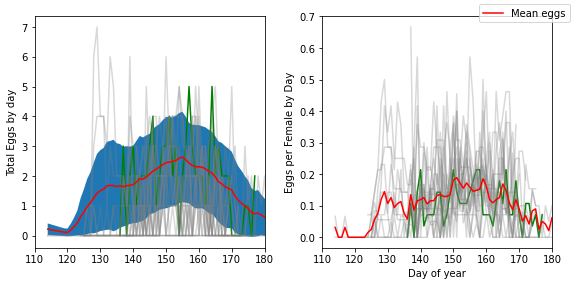

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


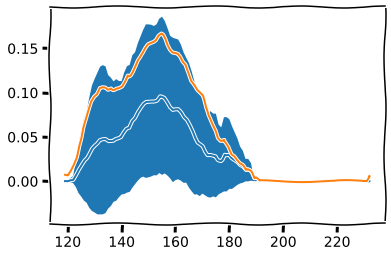

In [17]:
## Build and visualize egg curve used to judge egg scores

fig,(ax,ax1) = plt.subplots(1,2)


decade_of_eggs = np.zeros(366)

eggs_counted_all = np.empty([len(all_eggs),366])
eggs_counted_all.fill(np.nan)

## Seperate array for counting known eggs, which is obviously going to be lower
eggs_counted_known = np.empty_like(eggs_counted_all)
eggs_counted_known.fill(np.nan)
participant_index_list = []
n_participant_list = []
for a in range(len(all_eggs)):
    
    egg_array = all_eggs[a]
    datestamps = all_datestamps[a]
    n_females = np.shape(egg_array)[1]
    days_of_our_lives = [day_of_year(d) for d in datestamps]
    
    ## DECISION: which eggs do we count? 
    ## If we count all eggs, we punish actually fertile eggs
    ## If we count F+X, we pushish aviaries where we were better at checking fertility
    ## IF we count F only, we pushish aviaries where we're unsure of fertility
    ## Seems like all eggs will be the best even, proxy measure of fertile eggs
    
    ## DECISION 2: Which females do we count? 
    # All females, or just the ones that participate? Porque nao os dois?
    
    participants = np.nansum(all_eggs[a],axis=(0,2))>0
    participants[-1]=0
    n_participants = np.sum(participants)
    participant_index_list.append(participants)
    n_participant_list.append(n_participants)
    day_counts = np.sum(egg_array[:,:,[0,1,2]],axis=(1,2))
    day_counts_known = np.nansum(egg_array[:,participants,:],axis=(1,2))

    if metas[a].cutoff_s is not None:
        cutoff_d = day_of_year(metas[a].cutoff_s)
    else:
        cutoff_d = 365
    for i in range(len(datestamps)):
        
        d = day_of_year(datestamps[i])
        if d > cutoff_d:
            continue
        decade_of_eggs[d] += day_counts[i]
        eggs_counted_all[a,d] = day_counts[i]
        eggs_counted_known[a,d] = day_counts_known[i]
    if a == 4:
        cor = 'green'
        alph = 1
    else:
        cor = 'gray'
        alph = .3
    ax.plot(days_of_our_lives,day_counts_known,alpha=alph,color=cor)
    ax1.plot(days_of_our_lives,np.array(day_counts) / n_females,alpha=alph,color=cor)

mean_females = np.mean([a.shape[1] for a in all_eggs])
mean_participants = np.mean(n_participant_list)
#ax.plot(range(366),decade_of_eggs/len(all_eggs))
#ax1.plot(range(366),decade_of_eggs/len(all_eggs)/mean_females)

mean_eggs = np.nanmean(eggs_counted_all,0)
std_eggs = np.nanstd(eggs_counted_all,0)

mean_eggs_known = np.nanmean(eggs_counted_known,0)
std_eggs_known = np.nanstd(eggs_counted_known,0)


from scipy.signal import savgol_filter

s_win = 11
s_ord = 1
smooth_mean_eggs = savgol_filter(mean_eggs[~np.isnan(mean_eggs)], s_win,s_ord) # window size 51, polynomial order 3
smooth_std_eggs = savgol_filter(std_eggs[~np.isnan(mean_eggs)], s_win,s_ord)

smooth_mean_known = savgol_filter(mean_eggs_known[~np.isnan(mean_eggs_known)], s_win,s_ord)
smooth_std_known = savgol_filter(std_eggs_known[~np.isnan(mean_eggs_known)], s_win,s_ord)
                                  
mean_eggs_f = mean_eggs / mean_females
std_eggs_f = np.nanstd(eggs_counted_all / mean_females,0)

mean_eggs_known_f = mean_eggs_known / mean_females
std_eggs_known_f = np.nanstd(eggs_counted_known / mean_females,0)

smooth_mean_eggs_f = savgol_filter(mean_eggs_f,s_win,s_ord)
smooth_std_eggs_f = savgol_filter(std_eggs_f,s_win,s_ord)

smooth_mean_known_f = savgol_filter(mean_eggs_known_f,s_win,s_ord)
smooth_std_known_f = savgol_filter(std_eggs_known_f,s_win,s_ord)
                                                   
#ax.plot(range(366),mean_eggs,color='red')
xs = np.arange(366)[~np.isnan(mean_eggs)]
print(xs)
ax.plot(xs,smooth_mean_eggs,color='red')
ax.fill_between(xs,smooth_mean_eggs + smooth_std_eggs,smooth_mean_eggs - smooth_std_eggs)
ax1.plot(range(366),mean_eggs_f,color='red',label='Mean eggs')

ax.set_xlim(110,180)
ax1.set_xlim(110,180)

ax1.set_xlabel('Day of year')
ax1.set_ylabel('Eggs per Female by Day')
ax.set_ylabel('Total Eggs by day')
fig.legend()
fig.set_size_inches(8,4)
fig.tight_layout()
fig.show()

with plt.xkcd():
    fig,ax=plt.subplots()
    ax.plot(smooth_mean_known_f)
    ax.fill_between(range(len(smooth_mean_known_f)),smooth_mean_known_f+smooth_std_known_f,smooth_mean_known_f-smooth_std_known_f)
    ax.plot(range(len(smooth_mean_eggs_f)),smooth_mean_eggs_f)
    fig.show()
print(smooth_mean_eggs_f[125])

In [18]:
## Build mean egg scores for each aviary
## Point of order, those scores need to be corrected for which days were checked, not just total eggs observed
egg_scores = []
egg_scores_std = []
egg_score_arrays = []
for a in range(len(all_eggs)):
    egg_array = all_eggs[a]

    datestamps = all_datestamps[a]
    #print(metas[a].cutoff,metas[a].cutoff_dt)
    #print(np.shape(egg_array))
    n_females = np.shape(egg_array)[1]
    
    days_of_our_lives = np.array([day_of_year(d) for d in datestamps])
    #day_counts = np.sum(egg_array[:,:,[0,2]],axis=(1,2))

    day_counts = np.sum(egg_array[:,:,[0,1,2]],axis=(1,2))
    ## Day counts divided up by female
    day_counts_f = np.sum(egg_array[:,:,[0,1,2]],axis=(2))
    if metas[a].cutoff_dt is not None:
        cutoff_day = day_of_year((metas[a].cutoff_dt-datetime(1970,1,1)).total_seconds())
        if True:
            day_counts = day_counts[days_of_our_lives < cutoff_day]
            days_of_our_lives = days_of_our_lives[days_of_our_lives < cutoff_day]

    #print(days_of_our_lives,cutoff_day)
    #print(day_counts)
    counts_per_female = day_counts / n_females
    normed_counts = np.zeros_like(counts_per_female)
    normed_counts_std = np.zeros_like(counts_per_female)
    
    normed_counts_f = np.zeros([len(days_of_our_lives),n_females])
    normed_counts_std_f = np.zeros_like(normed_counts_f)
    for i in range(len(days_of_our_lives)):
        d = days_of_our_lives[i]
        """
        normed_counts[i] = counts_per_female[i] / mean_eggs_f[d]
        normed_counts_std[i] = (counts_per_female[i] - mean_eggs_f[d]) / std_eggs_f[d]
        """
        ## Try with smoothed functions
        normed_counts[i] = counts_per_female[i] / smooth_mean_eggs_f[d]
        normed_counts_std[i] = (counts_per_female[i] - smooth_mean_eggs_f[d]) / smooth_std_eggs_f[d]
        
        
        ## Get a normalized score for each female
        normed_counts_f[i] = day_counts_f[i] / smooth_mean_eggs_f[d]
        #print(d,i,day_counts_f[i],smooth_mean_eggs_f[d])
        normed_counts_std_f[i] = normed_counts_f[i] / smooth_std_eggs_f[d]

    normed_counts[normed_counts == np.inf] = np.nan
    normed_counts[normed_counts == np.NINF] = np.nan
        
    normed_counts_std[normed_counts_std == np.inf] = np.nan
    normed_counts_std[normed_counts_std == np.NINF] = np.nan
    
    normed_counts_std_f[normed_counts_std_f == np.inf] = np.nan
    normed_counts_std_f[normed_counts_std_f == np.NINF] = np.nan
    
    #print(len(counts_per_female))
    #print(days_of_our_lives)
    #print(counts_per_female)


    #print(normed_counts_std)
    
    if False:
        print(metas[a].name)
        print(np.nanmean(normed_counts_std))
        print('')
    egg_scores.append(np.nanmean(normed_counts))
    egg_scores_std.append(np.nanmean(normed_counts_std))
    egg_score_arrays.append(np.nanmean(normed_counts_std_f,axis=0))
    
egg_scores = np.array(egg_scores)
print(egg_scores)

[1.67838725 0.7053763  2.13952887 0.86327322        nan 0.56930228
 0.82407624        nan 0.88328062 1.32651336 0.95876593 0.83819979
 2.17645134 1.23928377 1.78822018 1.24189453 1.43569586 0.61282845
 1.05535107]


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


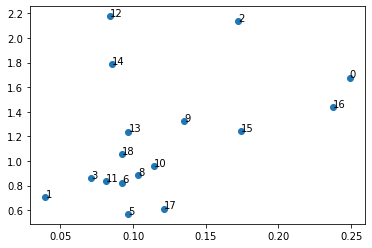

In [19]:
## Defining metrics of cohesion, as well as functions for measuring possible confounds

n_pruned = 10
## Get the percent of female directed song in each bin
def percent_to_females(history,meta,sorted_data,window=100,shuffle=False):
    if True:
        history_bins,[history_rate_bins,ts,window_indices]= sliding_bin_history(sorted_data,history,meta,window=window)
    else:
        history_bins,[history_rate_bins,ts,window_indices]= bin_history(sorted_data,history,meta,window=window)
    if shuffle:
        history_bins = shuffle_indy_bins(history_bins)
    n_females = meta.n_females
    f_songs = np.sum(history_bins[:,n_females:,:n_females],axis=(2))
    all_songs = np.sum(history_bins[:,n_females:],axis=(2))
    undirected_songs = np.array([np.diagonal(history_bins[b]) for b in range(len(history_bins))])
    undirected_songs = undirected_songs[:,n_females:]
    f_ratio = f_songs / (all_songs - undirected_songs)
    return f_ratio,[f_songs,all_songs]

## Correlate males by the degree of consistency in the ratio of f-directed song
def correlate_fsongs(history,meta,sorted_data,window=100,prune = False,shuffle=False,n_pruned =10,sman=True):
    f_ratio, [f_songs,all_songs] = percent_to_females(history,meta,sorted_data,window,shuffle)

    if sman:
        c_function = spearmanr
    else:
        c_function = pearsonr
    if prune: 
        f_ratio = f_ratio[:,np.sum(f_songs,0) >= n_pruned]

    n_males = f_ratio.shape[1]
    corr_matrix = np.zeros([n_males,n_males])
    xs,ys = [],[]
    for m in range(n_males):
        for n in range(n_males):
            m_vals = f_ratio[:,m]
            n_vals = f_ratio[:,n]

            m_vals_clean = m_vals[~np.isnan(m_vals) & ~np.isnan(n_vals)]
            n_vals_clean = n_vals[~np.isnan(m_vals) & ~np.isnan(n_vals)]
            if len(m_vals_clean) > 1 and len(n_vals_clean) > 1:
                r,p = spearmanr(m_vals_clean,n_vals_clean)
            else:
                r = np.nan
            if m != n:
                xs.extend(m_vals_clean)
                ys.extend(n_vals_clean)
                corr_matrix[m,n] = r
            if m == n:
                #corr_matrix[m,n] = r
                corr_matrix[m,n] = np.nan
    if False:
        fig,ax = plt.subplots()
        ax.scatter(xs,ys,alpha=.2)
        fig.show()
    return corr_matrix


def sex_ratio(meta):
    return meta.n_females / meta.n_males

## Calculate the participation by females
s_threshold = 20
def f_participation(history,meta):
    n_females = meta.n_females
    f_sums = np.sum(history[:,n_females:,:n_females],axis=(0,1))
    return np.sum(f_sums > s_threshold)

def f_pairbonded(history,meta):
    ## A female has a pairbond if she is participating, and receives > 60% of her songs from one male
    summed_songs = np.sum(history[:,n_females:,:n_females],axis=0)
    f_sums = np.sum(summed_songs,axis=0)

    song_ratios = np.transpose(summed_songs) / f_sums[:,None]

    pairbonds = np.max(song_ratios,axis=1) > .6
    participation = f_sums > s_threshold
    return np.sum(pairbonds * participation)

corrs = []
#s_corrs = []
#r_corrs = []
all_corrs,all_shuffle_corrs = [],[]
#all_rcorrs = []
#a_corrs = []

for a in range(len(metas)):
    win = 60
    corr_matrix = correlate_fsongs(historys[a],metas[a],sorteds[a],window=win,prune=True,shuffle=False)
    
    
    #scorr_matrix = correlate_singing(historys[a],metas[a],sorteds[a],window=win,prune=False,shuffle=False)
    #rcorr_matrix = ratio_singing(historys[a],metas[a],sorteds[a],window=win,prune=False,shuffle=False)
    #act_list = get_male_activity(historys[a],metas[a],sorteds[a],window=win,prune=False,shuffle=False)
    
    corr_matrix_full = correlate_fsongs(historys[a],metas[a],sorteds[a],window=win,prune=True,shuffle=False)
    np.fill_diagonal(corr_matrix_full,np.nan)
    shuffle_corr = correlate_fsongs(historys[a],metas[a],sorteds[a],window=win,prune=True,shuffle=True)
    
    np.fill_diagonal(corr_matrix,np.nan)
    np.fill_diagonal(shuffle_corr,np.nan)
    all_corrs.append(corr_matrix_full)
    all_shuffle_corrs.append(shuffle_corr)
    corrs.append(np.nanmean(corr_matrix))
    #s_corrs.append(np.nanmean(scorr_matrix))
    #r_corrs.append(np.nanmean(rcorr_matrix))
    #all_rcorrs.append(rcorr_matrix)
    #a_corrs.append(np.nanmean(act_list))
    
    if False:
        fig,ax = plt.subplots()
        ax.imshow(corr_matrix,vmin=-1,vmax=1,cmap='coolwarm')
        print(a)
        print(np.nanmin(corr_matrix),np.nanmax(corr_matrix))
        print(np.nanmean(corr_matrix))

        fig.show()
    
f_corrs = np.array(corrs)
#s_corrs = np.array(s_corrs)
#r_corrs = np.array(r_corrs)
#a_corrs = np.array(a_corrs)
## Reminder, 
## f corrs is the degree to which the % songs to females ratio is consistent
## s corrs is the degree to which male songs of the same type are correlated
## r corrs is the % males singing the same type at the same time (using dot product, not actually correlation)
## a corrs is activity (% of males singing in an average bin)

#print(pearsonr(f_corrs[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
#print(pearsonr(s_corrs[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
#print(pearsonr(r_corrs[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
#print(pearsonr(a_corrs[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))

egg_scores = np.array(egg_scores)
egg_scores_std = np.array(egg_scores_std)

#print(np.sum(~np.isnan(egg_scores)))

##findme

fig,ax = plt.subplots()
ax.scatter(f_corrs[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)])
#ax.scatter(f_corrs,egg_scores_std)
for a in range(len(metas)):
    ax.text(f_corrs[a],egg_scores[a],str(a))
fig.show()

In [339]:
print(corrs)

[0.22608318 0.06369923 0.16468466 0.07133577 0.09060766 0.08961279
 0.0881565  0.10399142 0.10115344 0.14749191 0.11544699 0.08339263
 0.07966175 0.10168108 0.08823302 0.17515582 0.25455633 0.10587443
 0.10795318]


# Results (organized according to the paper)
(Everything above was methods or supplemental background) 

## 1. Courtship is more synchronized than expected by chance
(Figure 1) 

KS test for skew:
1 : 0.09 0.005 736
2 : 0.091 0.002 823
3 : 0.155 0.0 820
4 : 0.126 0.0 858
5 : 0.135 0.0 883
6 : 0.104 0.0 2148
7 : 0.075 0.0 2156
8 : 0.105 0.0 848
9 : 0.092 0.0 1626
10 : 0.104 0.0 785
11 : 0.096 0.001 853
12 : 0.118 0.0 1739
13 : 0.065 0.002 1698
14 : 0.095 0.0 1012
15 : 0.066 0.002 1639
16 : 0.119 0.0 1699
17 : 0.11 0.0 1734
18 : 0.096 0.0 1293
19 : 0.098 0.0 951



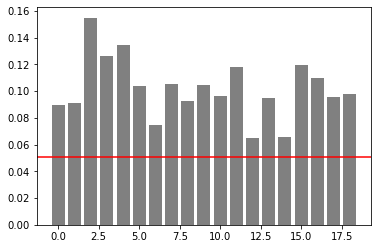

In [20]:
## Returning to that KS distribution for bins

print('KS test for skew:')

fig2,ax2 = plt.subplots()
for a in range(len(metas)):
    f_ratio, [f_songs,all_songs] = percent_to_females(historys[a],metas[a],sorteds[a],window=win)
    f_ratio_shuffled, [f_songs,all_songs] = percent_to_females(historys[a],metas[a],sorteds[a],window=win,shuffle=True)

    mean_f_ratio = np.nanmean(f_ratio,axis=1)
    
    mean_f_shuffled = np.nanmean(f_ratio_shuffled,axis=1)
    
    k_stat,p = ks_2samp(mean_f_ratio,mean_f_shuffled)
    #print(kstest(mean_f_ratio[~np.isnan(mean_f_ratio)],'norm'))
    if False:
        fig,ax = plt.subplots()
        ax.hist(mean_f_ratio)
        ax.hist(mean_f_shuffled,alpha=.5)
        ax.set_title(str(a) + ': ' + str(k_stat) + ', ' + str(p))
        fig.show()
    print(a+1,':',np.round(k_stat,3),np.round(p,3),str(len(mean_f_ratio)))
    ax2.bar(a,k_stat,color='gray')
    
ax2.axhline(1.35/np.sqrt(700),color='red')
#fig,ax = plt.subplots()
#ax.bar(k_stats)
fig2.show()
print()

1 * 2.001339925448986e-06 12.108771354128246
17 * 7.445002115711003e-06 7.478503892105567
16 * 1.7791259395035595e-05 6.8472615155595085
3 * 0.0006561900615028198 4.865308708497669
10 . 0.05934981168937054 2.1961427735924848
18 * 8.943477225365495e-06 6.390704475598779
11 * 0.02515323205351102 2.5567118458413614
8 * 0.007174735502521174 3.031587715336369
9 * 0.0011735367415379098 3.8498379661703863
14 * 0.0034227212528688037 3.516273043523387
6 * 0.00022849514835002896 5.182227769363725
5 * 0.0013346673443236942 3.792104565850154
7 * 6.314690415994575e-05 5.620328393013572
19  0.28305303438211715 1.1031649375676928
15 * 2.1572860528689384e-06 7.1886565730974565
13 * 2.4992615352226776e-06 7.593555537466935
12 * 3.96546146902145e-06 6.276666300796427
4 * 0.0043877666582775345 3.1201658545473245
2  0.6544568479484544 0.4537448161918638

mean aviairy scores vs shuffled: Ttest_indResult(statistic=7.732824189067816, pvalue=3.6780282276544604e-09) 19 19
positive males / total males: 156 / 16

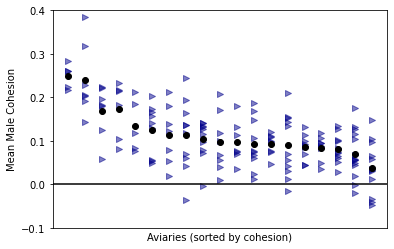

In [21]:
## Use all_corrs (defined above) to plot male and aviary-wise synchrony
mean_corrs = []
for a in range(len(all_corrs)):
    mean_corrs.append(np.nanmean(all_corrs[a]))
    
sorted_aves = np.argsort(mean_corrs)[::-1]

fig,ax = plt.subplots()

count_all_males = 0
count_sig_males = 0

hatch_heights = []
for i in range(len(sorted_aves)): #range(len(all_corrs)):
    a = sorted_aves[i]
    lower_flat = all_corrs[a][np.tril_indices_from(all_corrs[a],-1)]
    shuffle_flat = all_shuffle_corrs[a][np.tril_indices_from(all_shuffle_corrs[a],-1)]
    
    lower_flat = np.nanmean(all_corrs[a],1)
    shuffle_flat = np.nanmean(all_shuffle_corrs[a],1)
    #print(lower_flat)

    if a == 11:
        cor = 'darkblue'
    else:
        cor = 'darkblue'
    ax.scatter(np.ones(len(lower_flat))*i,lower_flat,color=cor,alpha=.5, marker='>')
    hatch_heights.append(np.nanmean(lower_flat))
    #ax.scatter(i,np.nanmean(lower_flat),color='red',marker='>')
    count_all_males += len(lower_flat)
    count_sig_males += np.sum(lower_flat > 0)
    #ax.scatter(np.ones(len(lower_flat))*i+.2,shuffle_flat,color='gray',alpha=.4)
    #ax.scatter(i,np.nanmean(shuffle_flat),color='black',marker='<')

all_corrs_flat = []
all_shuffle_flat = []
for a in range(len(metas)):
    all_corrs_flat = np.hstack([all_corrs_flat,np.nanmean(all_corrs[a],0)])
    all_shuffle_flat = np.hstack([all_shuffle_flat,np.nanmean(all_shuffle_corrs[a],0)])
    

all_corrs_flat = all_corrs_flat[~np.isnan(all_corrs_flat)]
all_shuffle_flat = all_shuffle_flat[~np.isnan(all_shuffle_flat)]


count_sig_aviaries = 0
mean_corrs_flat,mean_shuffle_flat = [],[]

for i in range(len(sorted_aves)):
    a = sorted_aves[i]
    cs = np.nanmean(all_corrs[a],0)
    sh = np.nanmean(all_shuffle_corrs[a],0)
    t,p = ttest_ind(cs[~np.isnan(cs)],sh[~np.isnan(sh)])
    mean_corrs_flat.append(np.nanmean(cs))
    mean_shuffle_flat.append(np.nanmean(sh))
    
    if p<.05:
        stars = '*'
        #ax.scatter(i,.55,marker='*',color='black')
        count_sig_aviaries += 1
        hatch_cor = 'red'
    elif p<.1:
        #ax.scatter(i,.55,marker='.',color='gray')
        stars = '.'
        hatch_cor = 'gray'
    else:
        stars = ''
        hatch_cor = 'black'
    if True:
        print(a+1,stars,p,t)
    ax.scatter(i,hatch_heights[i],color='black',marker='o')
print() 
print('mean aviairy scores vs shuffled:',ttest_ind(mean_corrs_flat,mean_shuffle_flat),len(mean_corrs_flat),len(mean_shuffle_flat))

ax.axhline(0,color='black')

ax.set_xticks([])
ax.set_xlabel('Aviaries (sorted by cohesion)')
ax.set_ylabel('Mean Male Cohesion')
ax.set_ylim([-0.1,0.4])
fig.set_size_inches(6,4)
fig.show()
fig.savefig('./fig1e.png',dpi=300)

if False: ## Plot all aviaires together vs random
    fig,ax = plt.subplots()

    if False:
        jitter = np.random.rand(len(all_corrs_flat)) - .5
        ax.scatter(np.ones(len(all_corrs_flat)) * 20 + jitter,all_corrs_flat,color='blue',alpha=.1)

        jitter = np.random.rand(len(all_shuffle_flat)) - .5
        ax.scatter(np.ones(len(all_shuffle_flat)) * 23 + jitter,all_shuffle_flat,color='gray',alpha=.1)

        ax.boxplot(all_corrs_flat,positions=[20],showfliers=False,widths=2)
        ax.boxplot(all_shuffle_flat,positions=[23],showfliers=False,widths=2)
    else:
        jitter = np.random.rand(len(mean_corrs_flat)) - .5
        ax.scatter(np.ones(len(mean_corrs_flat)) * 20 + jitter,mean_corrs_flat,color='blue',alpha=.5)

        jitter = np.random.rand(len(mean_shuffle_flat)) - .5
        ax.scatter(np.ones(len(mean_shuffle_flat)) * 23 + jitter,mean_shuffle_flat,color='gray',alpha=.5)

        ax.boxplot(mean_corrs_flat,positions=[20],showfliers=False,widths=2)
        ax.boxplot(mean_shuffle_flat,positions=[23],showfliers=False,widths=2)   

    ax.axhline(0,color='black')
    #ax.axvline(18.65,color='black',linestyle=':')
    ax.set_ylim([-0.3,0.6])
    ax.set_xticklabels(['Aviaries','Random'],rotation=45)

    fig.set_size_inches(2,4)
    fig.show()


    fig,ax = plt.subplots()

    a = 11
    i = np.argmax(sorted_aves == a)
    print(i,sorted_aves)

    lower_flat = all_corrs[a][np.tril_indices_from(all_corrs[a],-1)]
    shuffle_flat = all_shuffle_corrs[a][np.tril_indices_from(all_shuffle_corrs[a],-1)]

    lower_flat = np.nanmean(all_corrs[a],1)
    shuffle_flat = np.nanmean(all_shuffle_corrs[a],1)
    #print(lower_flat)

    ax.scatter(np.ones(len(lower_flat))*i,lower_flat,color='blue',alpha=.5)
    ax.scatter(i,np.nanmean(lower_flat),color='black')

    ax.set_ylim([-0.3,0.6])
    ax.axhline(0,color='black')
    fig.show()
print('positive males / total males:',count_sig_males,'/',count_all_males)
print('significant aviaries / total aviaries:',count_sig_aviaries,'/',len(metas))

In [94]:
## As above, but bootstrap the shuffled aviaries to provide confidence intervals of the means

iterations = 1000

for a in range(len(metas)):
    corr_matrix = correlate_fsongs(historys[a],metas[a],sorteds[a],window=win,prune=True,shuffle=False)
    
    boot_shuffle_means = np.empty(iterations)
    for i in range(iterations):
        shuffle_corr = correlate_fsongs(historys[a],metas[a],sorteds[a],window=win,prune=True,shuffle=True)
        boot_shuffle_means[i] = np.nanmean(shuffle_corr)
    
    
    boot_shuffle_means = np.sort(boot_shuffle_means)
    p_i = np.argmax(boot_shuffle_means > np.nanmean(corr_matrix))
    p = p_i / iterations
    shuf_dist = norm(np.mean(boot_shuffle_means),np.std(boot_shuffle_means))
    p_cdf = 1- shuf_dist.cdf(np.nanmean(corr_matrix))
    print(a,':',p,p_cdf)
    
    if False:
        fig,ax = plt.subplots()
        ax.hist(boot_shuffle_means,density=True)
        xs = np.linspace(-.10,.4,1000)
        
        ax.plot(xs,shuf_dist.pdf(xs))
        print(shuf_dist.cdf(np.nanmean(corr_matrix)))
        ax.hist(np.nanmean(corr_matrix,0),density=True)
        fig.show()
        break

0 : 0.0 4.1323007238247556e-09
1 : 0.844 0.15460660931418668
2 : 0.0 4.450317780957391e-09
3 : 0.0 5.407643012267371e-06
4 : 0.0 8.254416637432094e-05
5 : 0.0 4.004629656773062e-07
6 : 0.0 4.0176950655279597e-10
7 : 0.0 8.912839730135236e-05
8 : 0.0 2.11033412966799e-11
9 : 0.0 1.6830202842488262e-07
10 : 0.0 1.6072132513755832e-10
11 : 0.0 2.6285085219512894e-11
12 : 0.0 3.7271286057460884e-10
13 : 0.99 0.006334692620317051
14 : 0.0 4.291200728090416e-11
15 : 0.0 2.985604996563751e-08
16 : 0.0 0.0
17 : 0.999 0.001259368479137768
18 : 0.0 1.5267916058547826e-05


In [83]:
### As above, but bootstrap the shuffled aviaries to generate a true random distribution
## 10,000 sounds good for the paper, but it takes forever, and it really doesn't impact the results vs 100
# So it's set to 100 to prevent you from getting stuck here, but feel free start a show and run the long version
# Chloe and I just started watching the Mysterious Benedict Society, and so far it's a lot funnier than I expected. 

if True:
    iterations = 100
else:
    iterations = 10000

for a in range(len(metas)):
    #f_ratio_shuffled, _ = percent_to_females(historys[a],metas[a],sorteds[a],window=win,shuffle=True)
    f_ratio, [f_songs,all_songs] = percent_to_females(historys[a],metas[a],sorteds[a],window=win)
    #f_ratio_shuffled, [f_songs,all_songs] = percent_to_females(historys[a],metas[a],sorteds[a],window=win,shuffle=True)

    mean_f_ratio = np.nanmean(f_ratio,axis=1)
    
    mean_f_shuffled = np.nanmean(f_ratio_shuffled,axis=1)
    
     
    n_per_i = len(f_ratio)
    n_i = int(iterations * n_per_i)
    boots_shuffle = np.empty(n_i)
    for i in range(iterations):
        f_ratio_shuffled, _ = percent_to_females(historys[a],metas[a],sorteds[a],window=win,shuffle=True)
        i0 = int(i*n_per_i)
        boots_shuffle[i0:(i0+len(f_ratio_shuffled))] = np.nanmean(f_ratio_shuffled,1)
    
    k_stat,p = ks_2samp(mean_f_ratio,boots_shuffle)   
    print(a,k_stat,p)
    if False:
        fig,ax = plt.subplots()
        ax.hist(boots_shuffle,density=True)
        ax.hist(mean_f_ratio,density=True,alpha=.5)
        fig.show()
        break

0 0.10709569707401034 2.9459228590878713e-06
1 0.09979859594383778 5.20466546398539e-06
2 0.13181555209953344 3.342367828693068e-10
3 0.12012553516819569 1.1098601908885914e-08
4 0.1033295154185021 8.759588042450449e-07
5 0.10362712574850297 4.558751557809376e-16
6 0.07322467455621295 2.5158295014826525e-08
7 0.09761226993865024 7.363229089283509e-06
8 0.08998967136150238 1.865682665161163e-09
9 0.11199837133550494 3.651354841040529e-07
10 0.10923264401772526 1.724208490245018e-07
11 0.1152102238805971 5.959294040974568e-16
12 0.06257767584097862 6.773046779487677e-05
13 0.07932953692115141 8.046920655890846e-05
14 0.05832975270479135 0.0002869391560463315
15 0.14056234340456886 7.457632896113609e-24
16 0.11220429184549352 8.712935904930929e-16
17 0.10058208255159473 7.679703384105037e-10
18 0.10599299363057324 3.917527314686009e-08


In [338]:
## Plot the real vs normal distribution for one example: 
ks,ps = [],[]
ns = []
if False:
    iterations = 10
else:
    iterations = 10000
win = 60
for a in range(len(metas)):
    if a != 16:
        pass
        #continue
    
    #f_ratio_shuffled, _ = percent_to_females(historys[a],metas[a],sorteds[a],window=win,shuffle=True)
    f_ratio, [f_songs,all_songs] = percent_to_females(historys[a],metas[a],sorteds[a],window=win)
    f_ratio_shuffled, [f_songs,all_songs] = percent_to_females(historys[a],metas[a],sorteds[a],window=win,shuffle=True)

    ## Delete bins where there's only one male

    f_ratio[np.sum(~np.isnan(f_ratio),1) <= 1] = np.nan
    mean_f_ratio = np.nanmean(f_ratio,axis=1)

    mean_f_shuffled = np.nanmean(f_ratio_shuffled,axis=1)


    n_per_i = len(f_ratio)
    n_i = int(iterations * n_per_i)
    boots_shuffle = np.empty(n_i)
    for i in range(iterations):
        f_ratio_shuffled, _ = percent_to_females(historys[a],metas[a],sorteds[a],window=win,shuffle=True)
        ## Again Delete bins where there's only one male
        f_ratio_shuffled[np.sum(~np.isnan(f_ratio_shuffled),1) <= 1] = np.nan
        i0 = int(i*n_per_i)
        boots_shuffle[i0:(i0+len(f_ratio_shuffled))] = np.nanmean(f_ratio_shuffled,1)

    k_stat,p = ks_2samp(mean_f_ratio[~np.isnan(mean_f_ratio)],boots_shuffle[~np.isnan(boots_shuffle)])   
    ns.append(np.sum(~np.isnan(mean_f_ratio)))
    print(a,k_stat,p,ns[a])
    ks.append(k_stat)
    ps.append(p)
    if True:
        fig,ax = plt.subplots()
        hist1 = ax.hist(mean_f_ratio,density=True,alpha=.1,bins=metas[a].n_males,color='darkblue')
        hist2 = ax.hist(boots_shuffle,density=True,alpha=.2,bins=metas[a].n_males,color='gray')
        
        k = .1
        
        
        kde = stats.gaussian_kde(mean_f_ratio[~np.isnan(mean_f_ratio)],bw_method=k)
        kde_shuffle = stats.gaussian_kde(boots_shuffle[~np.isnan(boots_shuffle)],bw_method=k)
        xx = np.linspace(0, 1, 100)

        ax.plot(xx, kde(xx),color='darkblue',label='Actual data')
        ax.plot(xx, kde_shuffle(xx),color='gray',label='Shuffled')
        ax.set_xlabel('Proportion of song to females')
        ax.set_ylabel('Probability density')
        ax.legend()
        fig.show()
        fig.set_size_inches(5,4)
        fig.savefig('./figS1a.png',dpi=300)
        #print(hist1)



0 0.13109496867853868 8.176779278901462e-07 424
1 0.05544360174652113 0.037172390622095874 642
2 0.08431301619468201 0.0002940405616453684 616
3 0.053125978222264836 0.03444914977667546 713
4 0.059421203670316114 0.013676865824032063 700
5 0.05117207544521679 0.0005958755287656297 1543
6 0.04432035231985931 0.0023245645741348324 1712
7 0.03865618643841484 0.3045059042805318 620
8 0.05120364250430126 0.002308068351100084 1283
9 0.07615359312495312 0.005470203936208536 504
10 0.05291469382092648 0.03720453999456519 705
11 0.0494140361819847 0.001737619552427752 1436
12 0.04451650129190243 0.004399829706618478 1536
13 0.06351849612017968 0.0025538897631747935 820
14 0.054254478871404554 0.0003158146959185891 1480
15 0.11563113692954141 2.0124755634336555e-14 1199
16 0.09033316023511195 2.434227914620944e-09 1252
17 0.09823624779427242 3.87377225368513e-08 915
18 0.06873684637514943 0.0031380834851428476 678


[ 0 16 15  2  9 17 10  7  8 13  5  4  6 18 14 12 11  3  1]


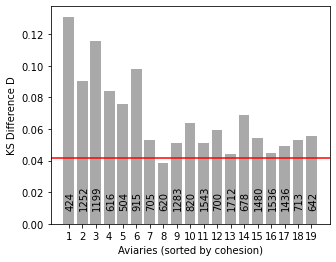

In [341]:
fig,ax = plt.subplots()
for i in sorted_aves:
    a = sorted_aves[i]
    ax.bar(i,ks[a],color='darkgray')
    ax.text(-.25+i,.01,ns[a],rotation=90)
ax.axhline(1.3581/np.sqrt(1050),color='red')

ax.set_xticks(np.arange(0,19))
ax.set_xticklabels(np.arange(1,20))

ax.set_xlabel('Aviaries (sorted by cohesion)')
ax.set_ylabel('KS Difference D')

fig.set_size_inches(5,4)
fig.savefig('./figS1b.png',dpi=300)
fig.show()

print(sorted_aves)

In [75]:
## Quickly confirm there's no effect for shuffled correlations
## Note, the correlation is weaker here because we're including *all* males for the plot, 
# whereas for the analysis we exclude males who don't sing much do reduce weird outliers. 

shuffle_corrs = []
for a in range(len(metas)):
    shuffle_corrs.append(np.nanmean(all_shuffle_corrs[a]))
    
shuffle_corrs = np.array(shuffle_corrs)
mean_corrs = np.array(mean_corrs)

print('shuffled:',pearsonr(shuffle_corrs[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
print('All males (including rare-singers):',pearsonr(mean_corrs[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)])) 

shuffled: (-0.014668629593695538, 0.9554405437818513)
All males (including rare-singers): (0.4173957598895751, 0.09551708523938043)


In [23]:
## Repeated measures annova within and across aviaries. 
## It looks like I might prune here...?

mean_corrs_m = []
for a in range(len(metas)):
    columns_c = ['Correlation','SingerID','ReceiverRank',]
    corr_df = pd.DataFrame(columns = columns_c)
    corrs = all_corrs[a]
    #print(corrs.shape)
    #n_males = metas[a].n_males
    n_males = corrs.shape[0]
    ms = np.nanmean(corrs,0)
    mean_corrs_m.append(ms[~np.isnan(ms)])
    for m in range(n_males):
        sorted_corrs = np.sort(corrs[m])

        for r in range(n_males-1):
            rank = n_males - r - 1
            #print(r)
            r_score = sorted_corrs[r]
            if np.isnan(r_score):
                r_score = 0
            corr_df = corr_df.append(dict(zip(columns_c,[r_score,m,rank])),ignore_index=True)

    
    an_rm = AnovaRM(corr_df,'Correlation','SingerID',within=['ReceiverRank'])
    summary = an_rm.fit()
    print('Aviary:',a)
    print(summary)


print('across all aviaries:')
print(f_oneway(*mean_corrs_m))    



Aviary: 0
                  Anova
             F Value Num DF  Den DF Pr > F
------------------------------------------
ReceiverRank 22.9386 3.0000 12.0000 0.0000

Aviary: 1
                   Anova
             F Value  Num DF  Den DF  Pr > F
--------------------------------------------
ReceiverRank 30.6778 10.0000 110.0000 0.0000

Aviary: 2
                  Anova
             F Value Num DF  Den DF Pr > F
------------------------------------------
ReceiverRank 27.9410 4.0000 20.0000 0.0000

Aviary: 3
                   Anova
             F Value  Num DF  Den DF  Pr > F
--------------------------------------------
ReceiverRank 44.3520 12.0000 156.0000 0.0000

Aviary: 4
                  Anova
             F Value Num DF  Den DF Pr > F
------------------------------------------
ReceiverRank 51.7529 8.0000 72.0000 0.0000

Aviary: 5
                  Anova
             F Value Num DF  Den DF Pr > F
------------------------------------------
ReceiverRank 23.7123 5.0000 30.0000 0.0000

Av

In [24]:
## Print out info for Table 1
print('A','Eggs','Score','Correlation')
for a in range(len(metas)):
    meta = metas[a]
    #print(a+1,meta.name,meta.n_males,meta.n_females,meta.n_males/meta.n_females)
    #print(a+1,sorteds[a][meta.start][5],sorteds[a][meta.cutoff-1][5])
    print(a+1,np.nansum(all_eggs[a]),np.round(egg_scores[a],3),np.round(f_corrs[a],3))

A Eggs Score Correlation
1 113.0 1.678 0.249
2 85.0 0.705 0.04
3 107.0 2.14 0.172
4 83.0 0.863 0.071
5 121.0 nan 0.092
6 62.0 0.569 0.097
7 101.0 0.824 0.092
8 83.0 nan 0.113
9 91.0 0.883 0.103
10 58.0 1.327 0.135
11 44.0 0.959 0.114
12 96.0 0.838 0.082
13 109.0 2.176 0.084
14 75.0 1.239 0.097
15 93.0 1.788 0.085
16 68.0 1.242 0.174
17 71.0 1.436 0.238
18 68.0 0.613 0.121
19 89.0 1.055 0.092


### Ploting the Phenomenon

Just give a nice demonstration of cohesive behavior. This should be beautiful, clear

In [25]:
## a function to scroll through all the data and find our best example, then plot it. 
A = 15
t1 = 1+347
t0 = t1-4

for a in range(len(metas)):
    ## Print examples of male and female song alternating
    #print(metas[a].name)
    history_bins,[history_rate_bins,ts,window_indices] = bin_history(sorteds[a],historys[a],metas[a])

    n_females = metas[a].n_females
    n_males = metas[a].n_males
    male_songs = np.sum(history_bins[:,n_females:,n_females:],axis=(1,2))
    female_songs = np.sum(history_bins[:,n_females:,:n_females],axis=(1,2))

    prop_female_song = np.zeros([len(history_bins),n_males])
    for t in range(len(history_bins)):
        songs_to_females = np.sum(history_bins[t,n_females:,:n_females],axis=1)
        total_songs = np.sum(history_bins[t,n_females:,:],axis=1)
        prop_female_song[t] = songs_to_females / total_songs
        if np.max(prop_female_song[t]) > 1:
            print(songs_to_females,total_songs)
        if np.max(songs_to_females > total_songs) > 0:
            print(history_bins[t,n_females:])


    shift_female_song = np.diff(prop_female_song,axis=0)
    shift_corr = np.zeros(len(shift_female_song))
    shift_neg = np.zeros_like(shift_corr)
    count = 0
    for t in range(len(shift_corr)):
        shift_corr[t] = np.nansum(shift_female_song[t] > 0) > 4 # Find all bins with lots of positive shifts
        shift_neg[t] = np.nansum(shift_female_song[t] < 0) > 2 # Find all the bins with lots of negative shifts
        if ts[t+1] - ts[t] > 200:
            count = 0
            continue
        if shift_corr[t] == True:
            if shift_neg[t] == False:
                count += 1
            else:
                count = 0
        else:
            count = 0
        if count >= 1:
            print(a,t,count)


    if a == A and False:

        s_win = 3
        s_ord = 2
        #smooth_corr = savgol_filter(shift_corr, s_win,s_ord)
        smooth_corr = shift_corr
        if False:
            fig,ax = plt.subplots()
            ax.plot(smooth_corr)
            ax.axvline(t0,color='red')
            #ax.set_xlim([t0,t1])
            #ax.set_ylim([0,2])
            fig.show()

        fig,ax = plt.subplots()

        ts_hours = [datetime.fromtimestamp(t).strftime('%H:%M:%S') for t in ts]
        ax.set_xticks(ts)
        
        ax.set_xticklabels(ts_hours)
        for m in range(n_males):
            #ax.scatter(range(len(prop_female_song[:,m])),prop_female_song[:,m],alpha=.5)
            ax.scatter(ts-5*m,prop_female_song[:,m]-.01*m)
            if True:
                #ax.plot(prop_female_song[:,m],alpha=.5)
                ax.plot(ts-5*m,prop_female_song[:,m]-.01*m,label='Male {}'.format(m+1))

        if True:
            ax.set_xlim([ts[t0],ts[t1]])
            #ax.set_xlim([t0,t1])
            
        ax.set_xlabel('Time of Day')
        ax.set_ylabel('Percentage song to Females')
        fig.legend(loc='lower right')
        fig.show()
        
print('done')

6 819 1
11 5 1
11 332 1
14 115 1
14 132 1
done


[(7, 25, {'weight': 1.0}), (18, 19, {'weight': 1.0}), (18, 22, {'weight': 1.0}), (18, 23, {'weight': 1.0}), (20, 26, {'weight': 1.0}), (22, 22, {'weight': 1.0}), (22, 23, {'weight': 1.0}), (22, 25, {'weight': 1.0}), (23, 27, {'weight': 1.0}), (25, 26, {'weight': 1.0})]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


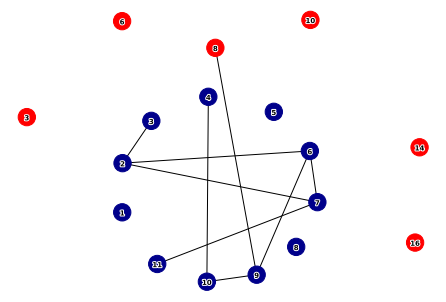

In [26]:
## Use above window, but plot each time point as a *network*, to give a sense of flow again. 
# This needs to be run twice with the correct time bins to get the plot for 1b,c

## Takes one history_bin (although it could work with any pairwise matrix I think)

import matplotlib.patheffects as PathEffects

def plot_network(history_bin,meta,hide=False):
    n_females =meta.n_females
    #history_bin[:n_females] = 0 ## For my purposes, I want to ignore rattles


    #print(history_bins[t])
    G = nx.from_numpy_array(history_bin)

    print(G.edges(data=True))
    colors = {}

    for n in G.nodes():
        if n < n_females:
            colors[n] = 'red'
        else:
            colors[n] = 'darkblue'
    colors = [colors[n] for n in G.nodes()]

    pos = {}
    for n in G.nodes():
        if n >= n_females and np.sum(history_bin[n,:]) >= 1: # If they are singing
            r = 1
            #print(n,history_bin[n])
        elif np.sum(history_bin[n_females:,n]) >= 1: # If they are sung to:
            r = 2
        else:
            r = 3
        if history_bin[n,n] == 1 and np.sum(history_bin[n]) - history_bin[n,n] == 0: # but drop undirected songs
            r = 3
        if n >= n_females:
            theta = (n - n_females) / (n_males-1) * np.pi * 2
            angle = theta
            r = 1
        else:
            angle = n / len(G.nodes()) * (np.pi*2)
        x = -1 * np.cos(angle) * r
        y = np.sin(angle) * r

        pos[n] = [x,y]
    #pos = nx.spring_layout(G,pos=pos,k = 1,iterations=2)
    if not hide:
        nx.draw(G,pos=pos,node_color=colors)

        plt.show()    
    return G,pos,colors

def plot_network2(history_bin,meta,hide=False):
    n_females =meta.n_females
    n_males = meta.n_males
    #history_bin[:n_females] = 0 ## For my purposes, I want to ignore rattles


    #print(history_bins[t])
    G = nx.from_numpy_array(history_bin)

    print(G.edges(data=True))
    colors = {}

    for n in G.nodes():
        if n < n_females:
            colors[n] = 'red'
            theta = 0 ## This is tricky, because you need to match it to the pairbond...
            ## Rather than get them perfect, it might be easier to just place them where I want them. 
            ## Can I drag it around if it's an svg? 
        else:
            colors[n] = 'darkblue'
    colors = [colors[n] for n in G.nodes()]

    pos = {}
    for n in G.nodes():
        if n >= n_females and np.sum(history_bin[n,:]) >= 1: # If they are singing
            r = 1
            #print(n,history_bin[n])
        elif np.sum(history_bin[n_females:,n]) >= 1: # If they are sung to:
            r = 2
        else:
            r = 3
        if history_bin[n,n] == 1 and np.sum(history_bin[n]) - history_bin[n,n] == 0: # but drop undirected songs
            r = 3
        angle = n / len(G.nodes()) * (np.pi*2)
        x = -1 * np.cos(angle) * r
        y = np.sin(angle) * r

        pos[n] = [x,y]
    #pos = nx.spring_layout(G,pos=pos,k = 1,iterations=2)
    if not hide:
        nx.draw(G,pos=pos,node_color=colors)

        plt.show()    
    return G,pos,colors

def get_prop_female(history_bins,meta,count_undirected = False):
    
    n_females = meta.n_females
    n_males = meta.n_males
    #male_songs = np.sum(history_bins[:,n_females:,n_females:],axis=(1,2))
    female_songs = np.sum(history_bins[:,n_females:,:n_females],axis=(1,2))

    prop_female_song = np.zeros([len(history_bins),n_males])
    for t in range(len(history_bins)):
        songs_to_females = np.sum(history_bins[t,n_females:,:n_females],axis=1)
        total_songs = np.sum(history_bins[t,n_females:,:],axis=1)
        undirected_songs = np.diagonal(history_bins[t,n_females:,n_females:])
        if not count_undirected: 
            total_songs = total_songs - undirected_songs
            total_songs[total_songs <=0] = np.nan
        prop_female_song[t] = songs_to_females / total_songs
    return prop_female_song   

def get_prop_male(history_bins,meta,count_undirected = False):
    
    n_females = meta.n_females
    n_males = meta.n_males
    #male_songs = np.sum(history_bins[:,n_females:,n_females:],axis=(1,2))
    female_songs = np.sum(history_bins[:,n_females:,:n_females],axis=(1,2))

    prop_male_song = np.zeros([len(history_bins),n_males])
    for t in range(len(history_bins)):
        songs_to_females = np.sum(history_bins[t,n_females:,:n_females],axis=1)
        total_songs = np.sum(history_bins[t,n_females:,:],axis=1)
        undirected_songs = np.diagonal(history_bins[t,n_females:,n_females:])

        male_songs = total_songs - undirected_songs - songs_to_females
        if not count_undirected: 
            total_songs = total_songs - undirected_songs
            total_songs[total_songs <= 0] = np.nan
        prop_male_song[t] = male_songs / total_songs
    return prop_male_song  

a = 11

t0 = 329
t1 = 333

t = t0 + 3
t=t0
history_bins,[history_rate_bins,ts,window_indices] = bin_history(sorteds[a],historys[a],metas[a])
n_females =metas[a].n_females
history_bins[:,:n_females] = 0 ## For my purposes, I want to ignore rattles
G,pos,colors = plot_network(history_bins[t],metas[a],hide=True)

print(G.nodes())

drop_nodes = [0,1,3,4,6,8,10,11,12,14,16]

for n in np.arange(len(G.nodes()))[::-1]:
    if n in drop_nodes:
        G.remove_node(n)
        del colors[n]
        del pos[n]

pos = nx.spring_layout(G,pos=pos,k=5,iterations=2)
weights = [G[u][v]['weight'] for u,v in G.edges()]
nx.draw(G,pos=pos,node_color=colors,width=weights)


for n in G.nodes():
    n_text = n + 1
    if n > 15:
        n_text = n - n_females + 1
    txt = plt.text(pos[n][0],pos[n][1] -.017,str(n_text),horizontalalignment='center',fontsize='x-small',fontweight='bold',
            color='black')
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
#plt.show()
#plt.savefig('./fig1b2.png',dpi=300)
plt.savefig('./fig1c2.svg',dpi=300)

#print(get_prop_female(history_bins,metas[a])[t])
#print(get_prop_male(history_bins,metas[a])[t])
#print(history_bins[t][n_females:])

In [27]:
## Build overlapped network (For video)
# Needs to define plot_network first, scroll down for that

print('This takes a while, run with care...')
if False:
    ph1_overlap,_ = overlap_history(sorteds[0],metas[0],decay = .99)
    ph1_history = historys[0]

    i = 100
    rm = 1
    rf = 3

    for i in range(len(ph1_overlap)):
        G,pos,colors = plot_network(ph1_overlap[i],metas[0],hide=True)

        n_females = metas[0].n_females
        n_males = metas[0].n_males
        sizes = [300 for n in G.nodes()]
        #print(ph1_history[i])
        #print(np.max(np.argmax(ph1_history[i],axis=0)),np.max(np.argmax(ph1_history[i],axis=1)))
        s = np.max(np.argmax(ph1_history[i],axis=0))
        r = np.max(np.argmax(ph1_history[i],axis=1))
        s = np.max(s)
        r = np.max(r)

        sizes[s] = sizes[s] * 1.5
        sizes[r] = sizes[r] * .75
        #print(sizes)

        #print(max(sizes))
        for n in G.nodes():

            if n >= n_females: ## It's a male
                angle = (n - n_females) / n_males * np.pi * 2
                r = rm
            else:
                angle = n / n_females * np.pi * 2
                r = rf
            x = -1 * np.cos(angle) * r
            y = np.sin(angle) * r    

            pos[n] = [x,y]

        weights = [G[u][v]['weight']*2 for u,v in G.edges()]


        weights = np.clip(weights,0,10)
        nx.draw(G,pos=pos,node_color=colors,width=weights,node_size = sizes)

        for n in G.nodes():

            x,y = pos[n][0],pos[n][1]
            if n >= n_females:
                n_text = n + 1 - n_females
            else:
                n_text = n + 1
            txt = plt.text(x,y -.07,str(n_text),horizontalalignment='center',fontsize='x-small',fontweight='bold',
                    color='black')
            txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

        plt.savefig('./NxImages2/test_graph_{:04d}.png'.format(i),dpi=300)
        plt.cla()

        #if i > 50:
        #    break

This takes a while, run with care...


In [28]:
## Check to make sure I'm not plotting across any skips, any number above 130 or so would be concerning
## This is the extent of my window:


print(ts[329])
print(ts[333])
print(datetime.fromtimestamp(ts[329]))
print(datetime.fromtimestamp(ts[333]))

for t in np.arange(328,336):
    print(ts[t] - ts[t-1])

1209649892.0
1209650301.0
2008-05-01 09:51:32
2008-05-01 09:58:21
101.0
104.0
100.0
103.0
103.0
103.0
104.0
104.0


2009-05-01 09:17:37
2009-05-01 09:30:16


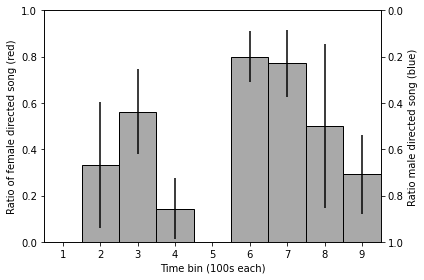

In [29]:
## Make Bar plot depiction of song patterns (without colors!)
"""
6 819 1
11 5 1
11 332 1
14 115 1
14 132 1
"""

#a,t0,t1 = 11,328,336
a,t0,t1 = 14,120,136
a,t0,t1 = 14,128,136

history_bins,[history_rate_bins,ts,window_indices] = bin_history(sorteds[a],historys[a],metas[a])
n_females =metas[a].n_females
history_bins[:,:n_females] = 0 ## For my purposes, I want to ignore rattles

print(datetime.fromtimestamp(ts[t0]))
print(datetime.fromtimestamp(ts[t1-1]))

if False:
    for t in np.arange(t0,t1):
        print(ts[t] - ts[t-1])
    

fig,ax = plt.subplots()
ax2 = ax.twinx()
prop_males = get_prop_male(history_bins,metas[a])
prop_females = get_prop_female(history_bins,metas[a])

#t0,t1=328,335

ax.axvline(t0-.5,color='black')
for i in range(t1-t0+1):
    t = t0 + i
    
    n_sem = np.sum(~np.isnan(prop_females[t]))
    m_bottom = 0 + 1 - np.nanmean(prop_males[t])
    if False:
        ax.bar(i,np.nanmean(prop_males[t]),color='blue',width=1,yerr=np.nanstd(prop_males[t])/np.sqrt(n_sem))
    else: # Fill in undirected song as male song
        #ax.bar(i,1-np.nanmean(prop_females[t]),color='white',bottom = m_bottom,width=1)
        pass
    f_bottom = 0 # + 1 - np.nanmean(prop_females[t])
    ax.bar(i,np.nanmean(prop_females[t]),bottom = f_bottom,
           edgecolor='black',color='darkgray',width=1,yerr=np.nanstd(prop_females[t])/np.sqrt(n_sem))
    #ax.axvline(i+.5,color='black')
offset = 18
if False:
    a,t0,t1 = 11,328,336
    #a,t0,t1 = 14,120,136

    history_bins,[history_rate_bins,ts,window_indices] = bin_history(sorteds[a],historys[a],metas[a])
    n_females =metas[a].n_females
    history_bins[:,:n_females] = 0 ## For my purposes, I want to ignore rattles

    print(datetime.fromtimestamp(ts[t0]))
    print(datetime.fromtimestamp(ts[t1-1]))

    if False:
        for t in np.arange(t0,t1):
            print(ts[t] - ts[t-1])

    prop_males = get_prop_male(history_bins,metas[a])
    prop_females = get_prop_female(history_bins,metas[a])

    #t0,t1=328,335

    ax.axvline(offset-.5,color='black')
    offset = 18
    for i in range(t1-t0+1):
        t = t0 + i
        n_sem = np.sum(~np.isnan(prop_females[t]))
        m_bottom = 0 + 1 - np.nanmean(prop_males[t])
        if False:
            ax.bar(i+offset,np.nanmean(prop_males[t]),color='blue',width=1,yerr=np.nanstd(prop_males[t])/np.sqrt(n_sem))
        else: # Fill in undirected song as male song
            ax.bar(i+offset,1-np.nanmean(prop_females[t]),color='darkblue',bottom = m_bottom,width=1)

        f_bottom = 0 # + 1 - np.nanmean(prop_females[t])
        ax.bar(i+offset,np.nanmean(prop_females[t]),bottom = f_bottom,color='red',width=1,yerr=np.nanstd(prop_females[t])/np.sqrt(n_sem))
        #ax.axvline(i+offset+.5,color='black')


ax.set_ylim([0,1])
ax.set_xlim([-.51,t1-t0+offset+.5])

ax.set_ylabel('Ratio of female directed song (red)')
#ax.set_xticks(np.arange(t0,t1+1))
#ax.set_xticklabels(np.arange(1,2+(t1-t0)))
ax.set_xticks(np.arange(t1-t0+offset +1))
xlabels = np.hstack([np.arange(1,offset),'-',np.arange(1,t1-t0+2)])
ax.set_xticklabels(xlabels)
ax.set_xlabel('Time bin (100s each)')

ax.set_xlim([-0.5,8.5])
ax2.set_yticklabels([1.0,0.8,0.6,0.4,0.2,0.0])
ax2.set_ylabel('Ratio male directed song (blue)')


fig.tight_layout()
fig.set_size_inches(6,4)

fig.show()


fig.savefig('./fig1a.png',dpi=300)
    

In [30]:
## Again, check all my bins
a,t0,t1 = 11,328,336
#a,t0,t1 = 14,120,136

history_bins,[history_rate_bins,ts,window_indices] = bin_history(sorteds[a],historys[a],metas[a])
n_females =metas[a].n_females
history_bins[:,:n_females] = 0 ## For my purposes, I want to ignore rattles

print(datetime.fromtimestamp(ts[t0]))
print(datetime.fromtimestamp(ts[t1-1]))


for t in np.arange(t0,t1):
    print(ts[t] - ts[t-1])

prop_males = get_prop_male(history_bins,metas[a])
prop_females = get_prop_female(history_bins,metas[a])

#t0,t1=328,335

#ax.axvline(t0-.5,color='black')
offset = 18
for i in range(t0-t1):
    t = t0 + i
    n_sem = np.sum(~np.isnan(prop_females[t]))
    m_bottom = 0 + 1 - np.nanmean(prop_males[t])
    if False:
        ax.bar(i+offset,np.nanmean(prop_males[t]),color='blue',width=1,yerr=np.nanstd(prop_males[t])/np.sqrt(n_sem))
    else: # Fill in undirected song as male song
        ax.bar(i+offset,1-np.nanmean(prop_females[t]),color='darkblue',bottom = m_bottom,width=1)
    
    f_bottom = 0 # + 1 - np.nanmean(prop_females[t])
    ax.bar(i+offset,np.nanmean(prop_females[t]),bottom = f_bottom,color='red',width=1,yerr=np.nanstd(prop_females[t])/np.sqrt(n_sem))
    ax.axvline(i+offset+.5,color='black')
    
fig.show()

2008-05-01 09:49:48
2008-05-01 10:01:49
101.0
104.0
100.0
103.0
103.0
103.0
104.0
104.0


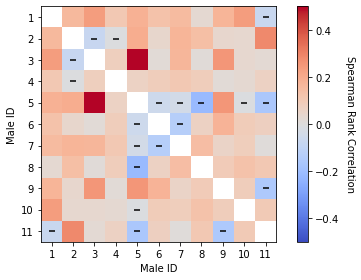

In [31]:
## Plot heat map of pairwise correlations (Fig 1d) 

a=11
corr_matrix = correlate_fsongs(historys[a],metas[a],sorteds[a],window=win,prune=False)

np.fill_diagonal(corr_matrix,np.nan)
fig,ax = plt.subplots()

n_males = len(corr_matrix)
for m in range(n_males):
    for n in range(n_males):
        if corr_matrix[m,n] < 0:
            ax.scatter(m,n,marker='_',color='black')

ax.set_xticks(np.arange(n_males))
ax.set_xticklabels([str(m+1) for m in range(n_males)])
ax.set_xlabel('Male ID')
ax.set_yticks(np.arange(n_males))
ax.set_yticklabels([str(m+1) for m in range(n_males)])
ax.set_ylabel('Male ID')
im = ax.imshow(corr_matrix,cmap='coolwarm',vmin=-0.5,vmax=0.5)
cbar = fig.colorbar(im)
cbar.set_label('Spearman Rank Correlation', rotation=270, labelpad=15)
fig.tight_layout()
fig.show()
fig.savefig('./fig1f.png',dpi=300)
#print(dict(zip(range(len(corrs)),corrs)))

## 2. Group courtship synchrony predicts reproductive output 
Figure 2

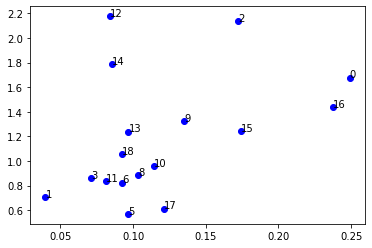

In [32]:
## Try with all the data
# First, calculate corr matrix in case I want to fiddle

## Relate r_corr with males vs with females:
#print(exp_sorteds[2][-1])
exp_rcorrs = []
exp_corrs = []
#rcorrs_m = []
#rcorrs_a = []
#rcorrs_u = []

all_corrs = []
corrs = []

shuffle_corrs = []
win = 60

for a in range(len(metas)):
    #rcorr_matrix = ratio_singing(exp_historys[a],exp_metas[a],exp_sorteds[a],window=win,prune=False,receiver='male')
    corr_matrix = correlate_fsongs(historys[a],metas[a],sorteds[a],window=win,prune=True)
    shuffle_matrix = correlate_fsongs(historys[a],metas[a],sorteds[a],window=win,prune=True,shuffle=True)
    
    np.fill_diagonal(corr_matrix,np.nan)
    np.fill_diagonal(shuffle_matrix,np.nan)
    
    
    shuffle_corrs.append(np.nanmean(shuffle_matrix))
    corrs.append(np.nanmean(corr_matrix))
    all_corrs.append(corr_matrix)


fig,ax = plt.subplots()


xs,ys = [],[]
xs_n = []
xs_c = []
for a in range(len(metas)):
    flat_corrs = all_corrs[a].flatten()
    flat_corrs = flat_corrs[~np.isnan(flat_corrs)]
    neg_corrs = flat_corrs[flat_corrs < 0]
    n_neg = np.sum(flat_corrs < 0)
    n_total = len(flat_corrs)
    if len(neg_corrs) == 0:
        mean_neg = 0
    else:
        mean_neg = np.nanmean(neg_corrs)
    
    #print(n_neg/n_total,mean_neg,np.sum(all_eggs[a]),egg_scores[a])
    ax.scatter(corrs[a],egg_scores[a],color='blue')

    if not np.isnan(egg_scores[a]):
        xs.append(mean_neg)
        xs_n.append(n_neg/n_total)
        xs_c.append(corrs[a])
        ys.append(egg_scores[a])
        ax.text(corrs[a],egg_scores[a],a)
fig.show()

corrs = np.array(corrs)
shuffle_corrs = np.array(shuffle_corrs)
#print(corrs.shape)

#print(pearsonr(xs,ys))
#print(pearsonr(xs_c,ys))
#print(pearsonr(f_corrs[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
#print(pearsonr(corrs[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
#print(pearsonr(shuffle_corrs[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
#print(pearsonr(corrs,shuffle_corrs))
#print(pearsonr(xs_n,ys))

In [111]:
## SKIPPED

## Compare fertile vs non-fertile
# F,NF,Unknown

fert_ratios = []
for a in range(len(metas)):
    fert = np.sum(all_eggs[a][:,:,0])
    dud = np.sum(all_eggs[a][:,:,1])
    fert_ratios.append(fert/dud)
    
print(pearsonr(corrs,fert_ratios))

print(np.arange(19)[~np.isnan(egg_scores)])

(0.4804455271641574, 0.03733391499681945)
[ 0  1  2  3  5  6  8  9 10 11 12 13 14 15 16 17 18]


In [33]:
## Check the correlation if we remove the outlier aviaries

good_aviaries = [a for a in range(19) if a not in [4,7,12,14,]]
print('good aviaries:',good_aviaries)
print('pearson r/p of good aviaries:',pearsonr(corrs[good_aviaries],egg_scores[good_aviaries]))
#print(np.polyfit(corrs[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)],1))
#print(np.polyfit(corrs[good_aviaries],egg_scores[good_aviaries],1))

good aviaries: [0, 1, 2, 3, 5, 6, 8, 9, 10, 11, 13, 15, 16, 17, 18]
pearson r/p of good aviaries: (0.7186453489858433, 0.002540009816398375)


In [34]:
## Print shuffled correlation
## Should probably be bootstrapped also 

all_shuffle_corrs = []
for a in range(len(metas)):
    win = 60
    shuffle_corr = correlate_fsongs(historys[a],metas[a],sorteds[a],window=win,prune=True,shuffle=True)
    all_shuffle_corrs.append(shuffle_corr)

shuffle_corrs = []
for a in range(len(metas)):
    shuffle_corrs.append(np.nanmean(all_shuffle_corrs[a]))
    
shuffle_corrs = np.array(shuffle_corrs)

print(pearsonr(shuffle_corrs[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))

(-0.014668629593695538, 0.9554405437818513)


In [35]:
## Try averaging bin_sizes, then bootstrapping it 

# First, calculate corr matrix in case I want to fiddle

## Relate r_corr with males vs with females:


win_possibilities = np.arange(45,75)
#iterations = 100

#win_iterations = [60]
xs_all,ys_all = [],[]
xs_n = []
xs_call = []
rs,rcs = [],[]

w_corrs = np.zeros([len(win_possibilities),len(metas)])
for w_i, win in enumerate(win_possibilities):
    corrs = []
    xs,ys = [],[]
    xs_c = []
    
    for a in range(len(metas)):
        #rcorr_matrix = ratio_singing(exp_historys[a],exp_metas[a],exp_sorteds[a],window=win,prune=False,receiver='male')
        corr_matrix = correlate_fsongs(historys[a],metas[a],sorteds[a],window=win,prune=True,n_pruned=10)
        #corr_matrix_unpruned = correlate_fsongs(historys[a],metas[a],sorteds[a],window=win,prune=False)
        corrs.append(np.nanmean(corr_matrix))
        #all_corrs.append(corr_matrix_unpruned)

    corrs = np.array(corrs)
    w_corrs[w_i] = corrs
            #ax.text(mean_neg,egg_scores[a],a)
    #fig.show()

corrs = np.nanmean(w_corrs,0)

if False:
    fig,ax=plt.subplots()
    ax.scatter(np.nanmean(w_corrs,0),egg_scores)
    fig.show

0.42672918491071615
[0.00948618 0.83178116]
0


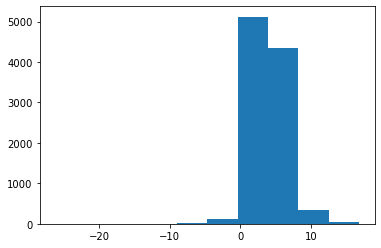

In [36]:
## Plot distribution of r values
a_good = np.arange(len(corrs))[~np.isnan(egg_scores)]

r_list = []
m_list,b_list = [],[]
iterations = 10000
for i in range(iterations):
    a_sampled = np.random.choice(a_good,size=len(a_good),replace=True)
    r,_ = pearsonr(corrs[a_sampled],egg_scores[a_sampled])
    m,b = np.polyfit(corrs[a_sampled],egg_scores[a_sampled],1)
    m_list.append(m)
    b_list.append(b)
    r_list.append(r)
    
r_list = np.array(r_list)
#print(r_list)
print(np.mean(r_list))
print(np.percentile(r_list,[2.35,97.75]))
print(np.argmax(r_list > 0))
m_low,m_high = np.percentile(m_list,[2.5,97.5])
m_mean = np.mean(m_list)
b_low,b_high = np.percentile(b_list,[2.5,97.5])
b_mean = np.mean(b_list)
fig,ax = plt.subplots()
ax.hist(r_list)
fig.show()

In [37]:
## This provides a one tailed distribution, which seems right in this case, since what you care about is 
## % that it's higher than 0. I guess two tailed provides "different from 0" which might be better here.
print('n>0',np.argmax(np.array(sorted(r_list)) > 0))
print('n total',len(r_list))
print('one tailed p=',202/10000)

n>0 217
n total 10000
one tailed p= 0.0202


In [344]:
## Calculate confidence intervals for plot
## Copied from Carlos Augusto Frana Schettini, via https://stackoverflow.com/a/65496207/6701721
from scipy import stats

x = corrs[~np.isnan(egg_scores)]
y = egg_scores[~np.isnan(egg_scores)]

slope, intercept = np.polyfit(x, y, 1)  # linear model adjustment

y_model = np.polyval([slope, intercept], x)   # modeling...

x_mean = np.mean(x)
y_mean = np.mean(y)
n = x.size                        # number of samples
m = 2                             # number of parameters
dof = n - m                       # degrees of freedom
t = stats.t.ppf(0.975, dof)       # Students statistic of interval confidence

residual = y - y_model

std_error = (np.sum(residual**2) / dof)**.5   # Standard deviation of the error

# calculating the r2
# https://www.statisticshowto.com/probability-and-statistics/coefficient-of-determination-r-squared/
# Pearson's correlation coefficient
numerator = np.sum((x - x_mean)*(y - y_mean))
denominator = ( np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2) )**.5
correlation_coef = numerator / denominator
r2 = correlation_coef**2

# mean squared error
MSE = 1/n * np.sum( (y - y_model)**2 )

# to plot the adjusted model
x_line = np.linspace(np.nanmin(w_corrs)-.2, np.nanmax(w_corrs)+.2, 100)
y_line = np.polyval([slope, intercept], x_line)

# confidence interval
ci = t * std_error * (1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5
# predicting interval
pi = t * std_error * (1 + 1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5  

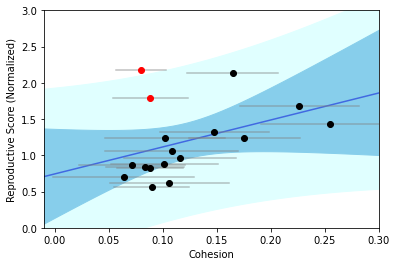

In [350]:
## Plot results from above bootstrapping and stats for Figure 2

## w_corrs here is calculated above when averaging across windows. 
corrs = np.nanmean(w_corrs,0)
#print(pearsonr(corrs[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))

fig,ax = plt.subplots()

ax.plot(x_line, y_line, color = 'royalblue')
ax.fill_between(x_line, y_line + pi, y_line - pi, color = 'lightcyan', label = '95% prediction interval')
ax.fill_between(x_line, y_line + ci, y_line - ci, color = 'skyblue', label = '95% confidence interval')

for a in range(len(metas)):
    cor = 'black'
    mark = None
    if ~np.isnan(egg_scores[a]):
        if a in [12,14]:
            cor = 'red'
        elif a in [6,16]:
            #mark = 'X'
            cor = 'black'
        #ax.scatter(w_corrs[:,a],[egg_scores[a]] * len(w_corrs[:,a]),color='gray',alpha=.05)
        
        scatter_sem = np.nanstd(all_corrs[a]) / np.sqrt(len(all_corrs[a]))
        ax.plot([corrs[a] - scatter_sem,corrs[a] + scatter_sem],[egg_scores[a],egg_scores[a]],color='gray',alpha=.5)
        ax.scatter(corrs[a],egg_scores[a],color=cor,marker=mark,zorder=10)
        

fit_line = np.poly1d([m_mean,b_mean])
xs = [np.nanmin(w_corrs)-.1,np.nanmax(w_corrs)+.1]
#ax.plot(xs,fit_line(xs),color='black')
#ax.axhline(1.56)
#ax.plot(x, y, 'o', color = 'royalblue')

ax.set_xlim(-0.01,0.30)
ax.set_ylim(-0.0,3)
ax.set_xlabel('Cohesion')
ax.set_ylabel('Reproductive Score (Normalized)')

fig.set_size_inches(6,4)
fig.savefig('./fig2.jpeg',dpi=300)


In [231]:
## Most and least cohesion and reproduction: 

a_max = np.argmax(corrs)
a_min = np.argmin(corrs)

e_max = egg_scores[a_max]
e_min = egg_scores[a_min]

print(a_max,a_min,corrs)
print(e_max,e_min,egg_scores)

print(egg_scores[a_max],egg_scores[a_min])

16 1 [0.22608318 0.06369923 0.16468466 0.07133577 0.09060766 0.08961279
 0.0881565  0.10399142 0.10115344 0.14749191 0.11544699 0.08339263
 0.07966175 0.10168108 0.08823302 0.17515582 0.25455633 0.10587443
 0.10795318]
1.4356958559317017 0.7053762957333353 [1.67838725 0.7053763  2.13952887 0.86327322        nan 0.56930228
 0.82407624        nan 0.88328062 1.32651336 0.95876593 0.83819979
 2.17645134 1.23928377 1.78822018 1.24189453 1.43569586 0.61282845
 1.05535107]
1.4356958559317017 0.7053762957333353


## Figure 3:  Individual Cohesion predicts egg production (but not quality) 
not sure how many of the above cells are necessary, but today is not the day for that. 

In [40]:
## Define functions needed to find pairbonds, calculate female specific egg scores
def get_fsongs(history,meta):
    n_females = meta.n_females
    return np.sum(history[:,n_females:,:n_females],axis=0)

def get_pairbonds(f_songs):
    n_males,n_females = f_songs.shape

    bond_list = [[] for m in range(n_males)]
    bond_id = np.zeros(n_females) - 1
    for f in range(n_females):
        top_singer = np.argmax(f_songs[:,f])
        n_songs = f_songs[top_singer,f]
        song_ratio = n_songs / np.sum(f_songs[:,f])
        if n_songs > 20 and song_ratio > .6:
            bond_id[f] = top_singer
            bond_list[top_singer].append(f)
    return bond_list,bond_id

egg_ranks = rankdata(np.nanmax(egg_scores) - egg_scores)

for a in range(19):
    f_egg_scores = np.sum(all_eggs[a],axis=(0,2))
    #print(f_egg_scores)

FNMW M2YL 0.0 1.0
FOWD M2YL 10.0 11.0
FBNM MB2M 5.0 6.0
FYR MBOD 6.0 7.0
F2MO MDGR 0.0 1.0
F2RW MDGR 3.0 4.0
FOMG MDGR 4.0 8.0
FOGO MDMG 11.0 12.0
FGBD MLB 8.0 9.0
FDR MRLW 6.0 7.0
FRBR MRLW 3.0 10.0
FO2R MWMG 1.0 2.0


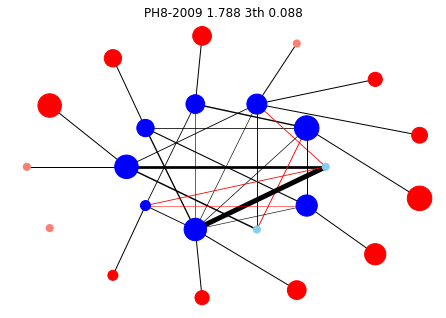

[(0, 3), (0, 5), (0, 7), (0, 'FNMW'), (0, 'FOWD'), (1, 4), (1, 6), (1, 8), (1, 'FBNM'), (2, 4), (2, 8), (2, 9), (2, 'FYR'), (3, 5), (3, 7), (3, 8), (3, 'F2MO'), (3, 'F2RW'), (3, 'FOMG'), (4, 6), (4, 7), (4, 8), (4, 'FOGO'), (5, 8), (5, 9), (6, 8), (6, 9), (6, 'FGBD'), (8, 9), (8, 'FDR'), (8, 'FRBR'), (9, 'FO2R')]
[(3, 0), (3, 5), (3, 7), (3, 8), (3, 'F2MO'), (3, 'F2RW'), (3, 'FOMG')]
total eggs: 57.0


In [315]:
## Build and plot cohesion networks (revamped to exclude all that above mess, but check it again.)


skip_low = -0.1
skip_high = 0.1

default_size = 1
egg_scale = 50

ds,es,a_list= [],[],[]
ds_loser,ds_winner = [],[]
mean_degree = []
mc_list = []
ma_list = []
m_list = []
m_scores = []
np_list = []    
tot_es = []

avs_to_plot = [14]
verbose = False
colNames,colMates,colDegree,colCohesion,colfEggs,colmEggs,colAviary,colScore = [],[],[],[],[],[],[],[]
   
f_columns = ['Bird','Mate','Degree','Cohesion','fEggs','mEggs','Aviary','Score']
m_columns = ['Bird','Male_id','Degree','Cohesion','nPairbonds','maxPairbond','Eggs','Aviary','Score']

female_df = pd.DataFrame(columns=f_columns)
male_df = pd.DataFrame(columns=m_columns)

for a in range(len(metas)):

    aviary_ds = []
    sizes = {}
    m_corrs_a = []
    m_list_a = []
    m_act_a = []
    n_females = metas[a].n_females
    n_males = metas[a].n_males

    win=60
    corr_matrix = correlate_fsongs(historys[a],metas[a],sorteds[a],window=win,prune=False,shuffle=False)
    #rcorr_matrix = ratio_singing(historys[a],metas[a],sorteds[a],window=win,prune=False,shuffle=False)
    #act_list = get_male_activity(historys[a],metas[a],sorteds[a],window=win,prune=False,shuffle=False)
    #rcorr_list = np.nanmean(rcorr_matrix,axis=0)
    A = np.array(corr_matrix)
    #A[np.triu_indices(A.shape[0], -1)] = np.nan
    #A[(A<.2) & (A>-.2)] = 0
    G = nx.from_numpy_array(A)#,create_using=nx.MultiGraph) #Multigraph is default
    Gs = nx.from_numpy_array(A)#,create_using=nx.MultiGraph)

    edge_colors = {}
    weights = {}
    remove=[]
    remove_s = []
    
    f_songs = get_fsongs(historys[a],metas[a])
    bond_list,bond_ids = get_pairbonds(f_songs)
    f_egg_scores = np.sum(all_eggs[a],axis=(0,2))
    
    for n1,n2,d in G.edges(data=True):
        if np.isnan(d['weight']):
            remove.append((n1,n2))
            continue
        if n1==n2:
            remove.append((n1,n2))
            #weights[(n1,n2)] = 1
            #edge_colors[(n1,n2)] = cor
            continue
        if d['weight'] < skip_low:
            cor = 'red'
            remove_s.append((n1,n2))
            #remove.append((n1,n2))
        elif d['weight'] > skip_low and d['weight'] < skip_high:
            remove.append((n1,n2))
            continue
        else:
            cor = 'black'
        edge_colors[(n1,n2)] = cor
        weights[(n1,n2)] = d['weight']
    

    G.remove_edges_from(remove) 
    #G.remove_edges_from(remove_s)
    Gs.remove_edges_from(remove)
    Gs.remove_edges_from(remove_s)

    node_colors = {}

    for m_i in range(len(metas[a].m_ids)):

        m = metas[a].m_ids[m_i]
        if m in pd.unique(male_df['Bird']):
            
            m_eggs = male_df[male_df['Bird'] == m]['PairbondEggs'].values[0]
            #print(m,'from df',m_eggs)
            if len(bond_list[m_i]) > 0:
                m_eggs = 0
                for f in bond_list[m_i]:
                    m_eggs += f_egg_scores[f]
            else:
                m_eggs = 0
                pass
            #print(m_i,'recalculated:',m_eggs)
            sizes[m_i] = 0 #m_eggs+default_size
            #m_corrs_a.append(rcorr_list[m_i])
            #m_act_a.append(act_list[m_i])
            m_list_a.append(m)

        else:
            sizes[m_i] = default_size
            #m_corrs_a.append(rcorr_list[m_i])
            #m_act_a.append(act_list[m_i])
            m_list_a.append(m)
            m_eggs = 0
        if m_eggs == 0:
            node_colors[m_i] = 'skyblue'
        else:
            node_colors[m_i] = 'Blue'
        #print(bond_list,len(metas[a].f_ids))
        #print(len(f_egg_scores))
    sizes_s = np.array([sizes[n] for n in G.nodes()])
    
    ## Add female nodes, make sure not to add these to your database
    
    #print(G.nodes())
    for m_i in range(len(metas[a].m_ids)):
        m = metas[a].m_ids[m_i]
        if len(bond_list[m_i]) > 0:
            for f in bond_list[m_i]:
                #print('f_id:',f,f_egg_scores[f])
                G.add_node(metas[a].f_ids[f])
                G.add_edge(m_i,metas[a].f_ids[f])
                weights[(m_i,metas[a].f_ids[f])] = .2
                edge_colors[(m_i,metas[a].f_ids[f])]='black'
                sizes[metas[a].f_ids[f]] = f_egg_scores[f] + default_size
                #m_list.append(metas[a].f_ids[f])
                #m_corrs.append(0)
                if f_egg_scores[f] == 0:
                    node_colors[metas[a].f_ids[f]] = 'salmon'
                else:
                    node_colors[metas[a].f_ids[f]] = 'Red'
    #print(sizes,G.nodes())

    for f in range(len(metas[a].f_ids)):
        f_id = metas[a].f_ids[f]
        if f_id in G.nodes():
            continue
        else:
            G.add_node(f_id)
            sizes[f_id] = default_size + f_egg_scores[f]
            node_colors[f_id] = 'salmon'
    if verbose:
        print(len(sizes),len(m_corrs))
        print(G.nodes())
        print('old degree:',Gs.degree())
    remove_s = []
    

    if False:
        for n,d in Gs.degree():
            if len(bond_list[n]) == 0:
                remove_s.append(n)
    if verbose:
        print('dropping:',remove_s)
    if False:
        Gs.remove_nodes_from(remove_s)
    for n,d in Gs.degree():
        if len(bond_list[n]) == 0:
            ds_loser.append(d)
        else:
            ds_winner.append(d)
        
        ds.append(d)
        aviary_ds.append(d)
        es.append(sizes_s[n] - 1)
        a_list.append(a)
        #mc_list.append(m_corrs_a[n])
        #ma_list.append(m_act_a[n])
        m_list.append(m_list_a[n])
        
        all_edges = G.edges(n)
        n_pairbonds = 0
        for e in G.edges(n):
            try:
                if 'F' in e[1]:
                    n_pairbonds += 1      
            except:
                continue
        np_list.append(n_pairbonds)

        #print(n,Gs.degree(n),G.degree(n),n_pairbonds)

    ## Calculate mean connectivity of males

    #a_df = df[df['Aviary'] == a] ## This is super sloppy, I'm pulling df from a cell below

    a_score = corrs[a]

    for n in G.nodes():
        ## Get female pairbond and his cohesion
        if 'F' in str(n):
            if True:
                broke = False

                for n1,n2 in G.edges():
                    if n in (n1,n2): ## If a female is there, that means she's pairbonded
                        broke = True
                        break
                if not broke:
                    pass
                    #print(n,n1,n2,'I did not break!') # In this case, the female doesn't have a mate?
                #continue
                if n1 == n:
                    mate = n2
                elif n2 == n:
                    mate = n1
                else:
                    #print('something is very wrong')
                    mate = n1
                    continue
                    
                m_name = metas[a].m_ids[mate]
                #m_cohesion = a_df[a_df['Male'] == m_name]['NetworkCohesion'].values[0]
                #m_cohesion = m_corrs_a[mate]
                m_cohesion = None
                m_degree = Gs.degree(mate)
                # get coheson of male and n eggs of female
                #print(n)
                n_eggs = sizes[n] - 1
                sizes[mate] += n_eggs
                node_colors[mate] = 'blue'
                colNames.append(n)
                colMates.append(m_name)
                colCohesion.append(m_cohesion)
                colDegree.append(m_degree)
                colfEggs.append(n_eggs)
                colmEggs.append(sizes[mate]) # A bit hacky, my old df, for all it's flaws, was doing a lot of heavy lifting
                colScore.append(a_score)
                colAviary.append(a)
                if a == 14:
                    print(n,m_name,n_eggs,sizes[mate])
                female_df = female_df.append(dict(zip(f_columns,
                                                [n,m_name,m_degree,m_cohesion,n_eggs,sizes[mate],a,a_score])),ignore_index=True)
            continue
        
        
        #f_columns = ['Bird','Mate','Degree','Cohesion','fEggs','mEggs','Aviary','Score']
        #m_columns = ['Bird','Male_id','Degree','Cohesion','nPairbonds',Eggs','Aviary','Score']

        weight_sum = 0
        edge_count = 0
        #print(G.edges(data=True))
        for n1,n2,d in G.edges(data=True):
            if n not in (n1,n2):
                continue
            if 'blue' not in node_colors[n1].lower() or 'blue' not in node_colors[n2].lower():
            #if 'blue' != node_colors[n1].lower() or 'blue' != node_colors[n2].lower():    
                #print(node_colors[n1].lower(),node_colors[n2].lower())
                continue

            else:
                weight_sum += d['weight']
                edge_count += 1
        #print(weight_sum,edge_count)
        
        m_scores.append(weight_sum / (edge_count + .1))
    
    #print(sizes)
    for n in G.nodes():
        if 'F' in str(n):
            continue
        n_pairbonds = 0
        for _,n2 in G.edges(n):
            max_pairbond = 0
            if 'F' in str(n2):
                n_pairbonds += 1
                if sizes[n2] > max_pairbond + 1:
                    max_pairbond = sizes[n2] - 1
        m_name = metas[a].m_ids[n]
        m_degree = Gs.degree(n)
        m_cohesion = np.nanmean(corr_matrix[n])
        n_eggs = sizes[n] - 1
        #print(sizes[n])
        #n_pairbonds = len(female_df[female_df['Mate'] == m_name])
        male_df = male_df.append(dict(zip(m_columns,
                                         [n,m_name,m_degree,m_cohesion,n_pairbonds,max_pairbond,n_eggs,a,a_score])),ignore_index=True)

    
    mean_degree.append(np.mean(aviary_ds))
    if verbose:
        print('new_degree',Gs.degree())
    #print(f_egg_scores)
    #print(sizes)

    # m_id = metas[a].m_ids[]

    #pos = nx.spring_layout(G)

    f_count = 0
    for n in G.nodes():
        if n in range(n_males):
            r = 1 
            theta = n / n_males * np.pi * 2
        else:
            r = 2
            theta = f_count / n_females * np.pi * 2
            f_count += 1
        x = -1 * np.cos(theta) * r
        y = np.sin(theta) * r

        pos[n] = [x,y]        
            
    weights = np.array([weights[n] for n in G.edges()])
    edge_colors = [edge_colors[n] for n in G.edges()]
    node_colors = [node_colors[n] for n in G.nodes()]
    sizes = [sizes[n]*egg_scale for n in G.nodes()]
    #print(weights)
    #print(weights_a)
    #print(G.edges())
    if a in avs_to_plot:
        for n in G.edges():
            if n in range(n_males):
                print(n,sizes[n]/50,G.degree[n],Gs.degree[n])
             
        #fig,ax = plt.subplots()
        nx.draw(G,pos,edge_color=edge_colors,width=weights*5,node_size=sizes,node_color=node_colors)
        plt.title(metas[a].name + ' ' + str(np.round(egg_scores[a],3)) + ' ' + str(int(egg_ranks[a])) + 'th ' + 
                 str(np.round(corrs[a],3)))
        #plt.savefig('./fig3a.png',dpi=300)
        #plt.savefig('./fig3a.svg')
        #circle=plt.Circle((2,2),2,color='black')
        #ax.add_patch(circle)
        plt.show()
        print(G.edges())
        print(G.edges(3))
        print('total eggs:',np.sum(np.array(sizes)/egg_scale - 1)/2)
        if False:
            plt.imshow(A,vmin=-1,vmax=1,cmap='coolwarm')
            plt.show()

In [208]:
## Cleaning....
male_df['Aviary'] = pd.to_numeric(male_df['Aviary'])
male_df['Degree'] = pd.to_numeric(male_df['Degree'])
male_df['Eggs'] = pd.to_numeric(male_df['Eggs'])
male_df['nPairbonds'] = pd.to_numeric(male_df['nPairbonds'])

In [321]:
## Need to rebuild sub_df to be simpler, since all that above code is a mess. 
sub_df = male_df[male_df['Aviary'] == 14]
x = sub_df['Degree'].astype(int)
y = sub_df['Eggs'].astype(int)
#x = sub_df[y_col]
#y = sub_df['Eggs']

slope, intercept = np.polyfit(x, y, 1)  # linear model adjustment

y_model = np.polyval([slope, intercept], x)   # modeling...

x_mean = np.mean(x)
y_mean = np.mean(y)
n = x.size                        # number of samples
m = 2                             # number of parameters
dof = n - m                       # degrees of freedom
t = stats.t.ppf(0.975, dof)       # Students statistic of interval confidence

residual = y - y_model

std_error = (np.sum(residual**2) / dof)**.5   # Standard deviation of the error

# calculating the r2
# https://www.statisticshowto.com/probability-and-statistics/coefficient-of-determination-r-squared/
# Pearson's correlation coefficient
numerator = np.sum((x - x_mean)*(y - y_mean))
denominator = ( np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2) )**.5
correlation_coef = numerator / denominator
r2 = correlation_coef**2

# mean squared error
MSE = 1/n * np.sum( (y - y_model)**2 )

# to plot the adjusted model
x_line = np.linspace(np.nanmin(x)-.2, np.nanmax(x)+.2, 100)
y_line = np.polyval([slope, intercept], x_line)

# confidence interval
ci = t * std_error * (1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5
# predicting interval
pi = t * std_error * (1 + 1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5  

(0.6336996336996336, 0.04915003522097852)


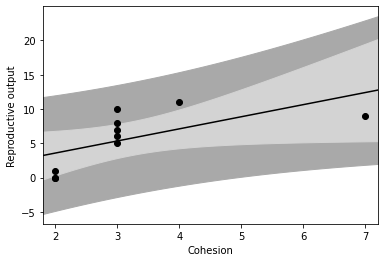

In [323]:
## Plot results from above bootstrapping and stats for Figure 2
corrs = np.nanmean(w_corrs,0)
#print(pearsonr(corrs[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))

fig,ax = plt.subplots()

ax.plot(x_line, y_line, color = 'black')
ax.fill_between(x_line, y_line + pi, y_line - pi, color = 'darkgrey', label = '95% prediction interval')
ax.fill_between(x_line, y_line + ci, y_line - ci, color = 'lightgrey', label = '95% confidence interval')
        
ax.scatter(x,y,color='black')
print(pearsonr(x,y))

fit_line = np.poly1d([m_mean,b_mean])
xs = [np.nanmin(w_corrs)-.1,np.nanmax(w_corrs)+.1]
#ax.plot(xs,fit_line(xs),color='black')
#ax.axhline(1.56)
#ax.plot(x, y, 'o', color = 'royalblue')

ax.set_xlim(1.8,7.2)
#ax.set_ylim(-0.5,3)
ax.set_xlabel('Cohesion')
ax.set_ylabel('Reproductive output')

fig.set_size_inches(6,4)
#fig.savefig('./fig3b.png',dpi=300)


In [318]:
## Calculate effect of degree

#print(pearsonr(ds,es))
print(ttest_ind(ds_winner,ds_loser))
mean_degree = np.array(mean_degree)
print(mean_degree.shape,egg_scores.shape)
#print('mean_degree:',pearsonr(mean_degree[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
#all_df = pd.DataFrame(list(zip(m_list,ds,m_scores,mc_list,ma_list, es,np_list,a_list)),
#               columns =['Male','Degree','NetworkCohesion','Cohesion','Activity','Eggs','nPairbonds','Aviary'])
all_df = male_df.copy()
#print(df,len(df))
if False:
    df = all_df.dropna()
else:
    df = all_df.copy()
#print(df,len(df))
df['Aviary'] = pd.to_numeric(df['Aviary'])
df['Degree'] = pd.to_numeric(df['Degree'])
df['Eggs'] = pd.to_numeric(df['Eggs'])
df['nPairbonds'] = pd.to_numeric(df['nPairbonds'])

if False:
    df = df[df['Eggs'] > 0] 
if False:
    df = df[df['Degree'] > 0]
if False:
    df = df[df['nPairbonds'] > 1]
if True:
    y_col = 'Degree'

elif True:
    y_col = 'Cohesion'
else:
    y_col = 'NetworkCohesion'
if True: ## These aviaries we lack egg identity
    df = df[df['Aviary'] != 0]
    df = df[df['Aviary'] != 1]
    df = df[df['Aviary'] != 2]
    df = df[df['Aviary'] != 3]
if True: ## These aviaries...are disrupted, their egg scores are excluded everywhere
    df = df[df['Aviary'] != 4]
    df = df[df['Aviary'] != 7]
    #df = df[df['Aviary'] != 9]
    #df = df[df['Aviary'] != 10]
if False:
    df = df[df['NetworkCohesion'] < .75]
    df = df[df['NetworkCohesion'] > -.75]
md = smf.mixedlm("Eggs ~"+y_col,data=df,groups=df["Aviary"])
mdf_partial = md.fit()    
print(mdf_partial.summary())

fig,ax = plt.subplots()

rs = []
for a in range(len(metas)):
    sub_df = df[df['Aviary'] == a]
    if a in [0,1,2,3,4,7]:
        continue
    #print(sub_df)
    if len(sub_df) < 2:
        continue
    cor = cm.viridis(a/19)

    #print(np.min(sub_df['Eggs']),np.max(sub_df['Eggs']))
    if False:
        ax.scatter(sub_df[y_col],sub_df['Eggs'],color=cor,alpha=.5)
    #print(sub_df[y_col])
    #print(sub_df['Eggs'])
    fit_line = np.poly1d(np.polyfit(sub_df[y_col],sub_df['Eggs'],1))
    r,p = pearsonr(sub_df[y_col],sub_df['Eggs'])
    print(a,'pearson:',r,p)
    if r <= 0:
        cor = 'red'
    else:
        cor = 'darkblue'
        
    rs.append(r)
    xs = [np.min(sub_df[y_col])-1,np.max(sub_df[y_col])+1]
    
    ax.plot(xs,fit_line(xs),color=cor,alpha=.5)

slope = 0.850
intercept = 3.243
xs = df['Degree']
ys= df['Eggs']
# mean squared error

x = np.linspace(np.nanmin(xs)-1,np.nanmax(xs)+1,100)
y_model = np.polyval([slope, intercept], x)   # modeling...

high_slope = 1.453
low_slope = 0.247

high_int,low_int = 5.495,0.992
high_line = np.polyval([high_slope,high_int],x)
low_line = np.polyval([low_slope,low_int],x)

ax.fill_between(x,high_line,low_line,color='lightgrey',zorder=0)
ax.plot(x,y_model,color='black',linewidth=3,zorder=10)

    
print(np.mean(rs),np.std(rs))
ax.set_ylabel('Reproductive Output')
ax.set_xlabel('Male Degree-Cohesion')

ax.set_xlim([-0.5,8.5])
ax.set_ylim([0,15])
fig.set_size_inches(6,4)

fig.savefig('./fig3c.png',dpi=300)
fig.show()

Ttest_indResult(statistic=3.95822788751833, pvalue=0.00010816217290209871)
(19,) (19,)
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Eggs     
No. Observations: 122     Method:             REML     
No. Groups:       13      Scale:              35.9696  
Min. group size:  7       Log-Likelihood:     -390.5886
Max. group size:  13      Converged:          No       
Mean group size:  9.4                                  
--------------------------------------------------------
           Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  2.243     1.149  1.953  0.051  -0.008   4.495
Degree     0.850     0.308  2.762  0.006   0.247   1.453
Group Var  0.000                                        

5 pearson: 0.028243179072090077 0.9470721936745075
6 pearson: -0.045643546458763826 0.914537139502428
8 pearson: -0.16056250013226395 0.6576851614521102
9 pearson: 0.5021200114801776 0.25

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Eggs     
No. Observations: 71      Method:             REML     
No. Groups:       13      Scale:              34.4453  
Min. group size:  4       Log-Likelihood:     -224.6790
Max. group size:  8       Converged:          Yes      
Mean group size:  5.5                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     8.646    1.924  4.494 0.000  4.875 12.416
Degree       -0.007    0.470 -0.015 0.988 -0.928  0.914
Group Var     0.000    0.609                           

* 5 pearson: -0.27456258919345766 0.7254374108065423
* 6 pearson: -0.24525573579398632 0.7547442642060137
* 8 pearson: -0.21407828990149702 0.785921710098503
9 perason: 0.17223453726205226 0.8277654627379477
* 10 pearson: -0.6524382543012599 0.23271885681550855
* 11 pearson: -0.2

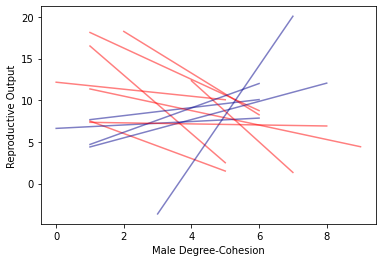

In [209]:
## Repeat above model for cohesion~reproduction among pairbonded males who got at least 1 egg
## By aviary comparisons (as above) when only considering productive females. 

## Calculate effect of degree

#print(pearsonr(ds,es))
mean_degree = np.array(mean_degree)

all_df = male_df

df = male_df.copy()


if True:
    df = df[df['Eggs'] > 0] 

y_col = 'Degree'
if True: ## These aviaries we lack egg identity
    df = df[df['Aviary'] != 0]
    df = df[df['Aviary'] != 1]
    df = df[df['Aviary'] != 2]
    df = df[df['Aviary'] != 3]
if True: ## These aviaries...are disrupted, their egg scores are excluded everywhere
    df = df[df['Aviary'] != 4]
    df = df[df['Aviary'] != 7]

md = smf.mixedlm("Eggs ~"+y_col,data=df,groups=df["Aviary"])
mdf_partial = md.fit()    
print(mdf_partial.summary())

fig,ax = plt.subplots()

rs = []
for a in range(len(metas)):
    sub_df = df[df['Aviary'] == a]
    if a in [0,1,2,3,4,7]:
        continue
    #print(sub_df)
    if len(sub_df) < 2:
        continue
    cor = cm.viridis(a/19)
    if a in [6,8,11]:
        cor = 'red'
        alpha=.5
    else:
        cor = 'darkblue'
        alpha=.5
    #print(np.min(sub_df['Eggs']),np.max(sub_df['Eggs']))
    if False:
        ax.scatter(sub_df[y_col],sub_df['Eggs'],color=cor,alpha=.5)
    #print(sub_df[y_col])
    #print(sub_df['Eggs'])
    fit_line = np.poly1d(np.polyfit(sub_df[y_col],sub_df['Eggs'],1))
    r,p = pearsonr(sub_df[y_col],sub_df['Eggs'])
    if r < 0:
        print('*',a,'pearson:',r,p)
        rs.append(r)
        cor = 'red'
    else:
        print(a,'perason:',r,p)
        cor = 'darkblue'
    xs = [np.min(sub_df[y_col])-1,np.max(sub_df[y_col])+1]
    
    ax.plot(xs,fit_line(xs),color=cor,alpha=alpha)
    
print(np.mean(rs),np.std(rs))
ax.set_ylabel('Reproductive Output')
ax.set_xlabel('Male Degree-Cohesion')

fig.set_size_inches(6,4)
fig.show()

* 5 pearson: -0.816496580927726 0.18350341907227397
6 perason: 0.07647191129018722 0.9235280887098127
* 8 pearson: -0.8528028654224417 0.14719713457755834
* 9 pearson: -0.9622504486493763 0.037749551350623745
* 10 pearson: -0.3273268353539885 0.5908012080539894
* 11 pearson: -6.69615030344424e-18 1.0
* 12 pearson: -0.14433756729740646 0.784997165379905
13 perason: 0.6470588235294118 0.16486871565235087
14 perason: 0.25 0.5504150390624998
* 15 pearson: -8.898096421589207e-18 1.0
16 perason: 0.42257712736425823 0.4784301701103345
17 perason: 0.6516347071506209 0.23349456455160586
18 perason: 0.545544725589981 0.16193822846628397
-0.44331632823584843 0.3913595245474255


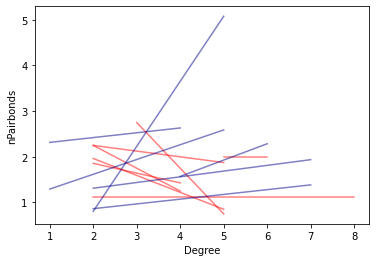

In [218]:
## Plot break this down by nPairbonds
fig,ax = plt.subplots()

rs = []
x_col = 'Degree'
y_col = 'nPairbonds'
for a in range(len(metas)):
    sub_df = df[df['Aviary'] == a]
    if a in [0,1,2,3,4,7]:
        continue
    #print(sub_df)
    if len(sub_df) < 2:
        continue
    cor = cm.viridis(a/19)
    if a in [6,8,11]:
        cor = 'red'
        alpha=.5
    else:
        cor = 'darkblue'
        alpha=.5
    #print(np.min(sub_df['Eggs']),np.max(sub_df['Eggs']))
    if False:
        ax.scatter(sub_df[x_col],sub_df[y_col],color=cor,alpha=.5)
    #print(sub_df[y_col])
    #print(sub_df['Eggs'])
    fit_line = np.poly1d(np.polyfit(sub_df[x_col],sub_df[y_col],1))
    r,p = pearsonr(sub_df[x_col],sub_df[y_col])
    if r < 0:
        print('*',a,'pearson:',r,p)
        rs.append(r)
        cor = 'red'
    else:
        print(a,'perason:',r,p)
        cor = 'darkblue'
    xs = [np.min(sub_df[x_col]),np.max(sub_df[x_col])]
    
    ax.plot(xs,fit_line(xs),color=cor,alpha=alpha)
    
print(np.mean(rs),np.std(rs))
ax.set_ylabel(y_col)
ax.set_xlabel(x_col)

fig.set_size_inches(6,4)
fig.show()

* 5 pearson: -0.10951713563867872 0.8904828643613213
6 perason: 0.512989176042577 0.487010823957423
8 perason: 0.29260286799032637 0.7073971320096737
9 perason: 0.3449309850739857 0.6550690149260143
10 perason: 0.28571428571428564 0.641229143482417
* 11 pearson: -0.2649993323573677 0.5258980405909364
* 12 pearson: -0.410549061519928 0.41877553906828013
* 13 pearson: -0.7330490367649812 0.09738238636807958
* 14 pearson: -0.05455447255899809 0.8979131383685767
* 15 pearson: -0.4937419311010188 0.5062580688989812
* 16 pearson: -0.42257712736425823 0.4784301701103345
* 17 pearson: -0.19611613513818402 0.7519072043205398
* 18 pearson: -0.04745789978762496 0.9111499565739895
-0.30361801469233773 0.217183354703561


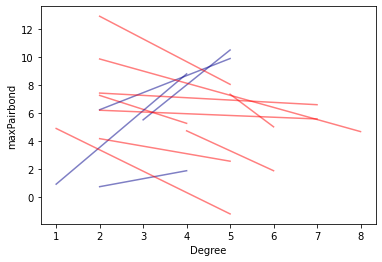

In [219]:
## and by maxPairbond
fig,ax = plt.subplots()

rs = []
x_col = 'Degree'
y_col = 'maxPairbond'
for a in range(len(metas)):
    sub_df = df[df['Aviary'] == a]
    if a in [0,1,2,3,4,7]:
        continue
    #print(sub_df)
    if len(sub_df) < 2:
        continue
    cor = cm.viridis(a/19)
    if a in [6,8,11]:
        cor = 'red'
        alpha=.5
    else:
        cor = 'darkblue'
        alpha=.5
    #print(np.min(sub_df['Eggs']),np.max(sub_df['Eggs']))
    if False:
        ax.scatter(sub_df[x_col],sub_df[y_col],color=cor,alpha=.5)
    #print(sub_df[y_col])
    #print(sub_df['Eggs'])
    fit_line = np.poly1d(np.polyfit(sub_df[x_col],sub_df[y_col],1))
    r,p = pearsonr(sub_df[x_col],sub_df[y_col])
    if r < 0:
        print('*',a,'pearson:',r,p)
        rs.append(r)
        cor = 'red'
    else:
        print(a,'perason:',r,p)
        cor = 'darkblue'
    xs = [np.min(sub_df[x_col]),np.max(sub_df[x_col])]
    
    ax.plot(xs,fit_line(xs),color=cor,alpha=alpha)
    
print(np.mean(rs),np.std(rs))
ax.set_ylabel(y_col)
ax.set_xlabel(x_col)

fig.set_size_inches(6,4)
fig.show()

In [194]:
## Some additional stats on where the reproduction increase comes from 
df = male_df.copy()

df['Aviary'] = pd.to_numeric(df['Aviary'])
df['Degree'] = pd.to_numeric(df['Degree'])
df['Eggs'] = pd.to_numeric(df['Eggs'])
df['nPairbonds'] = pd.to_numeric(df['nPairbonds'])

if False:
    df = df[df['Eggs'] > 0] 

y_col = 'nPairbonds'
if True: ## These aviaries we lack egg identity
    df = df[df['Aviary'] != 0]
    df = df[df['Aviary'] != 1]
    df = df[df['Aviary'] != 2]
    df = df[df['Aviary'] != 3]
if True: ## These aviaries...are disrupted, their egg scores are excluded everywhere
    df = df[df['Aviary'] != 4]
    df = df[df['Aviary'] != 7]

md = smf.mixedlm("Eggs ~"+y_col,data=df,groups=df["Aviary"])
mdf = md.fit()    
print(mdf.summary())
## Male reproductive output with number of pairbonds
print('same as above, but technically wrong,',pearsonr(df['Eggs'],df['nPairbonds']))

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Eggs     
No. Observations: 122     Method:             REML     
No. Groups:       13      Scale:              25.7844  
Min. group size:  7       Log-Likelihood:     -370.1796
Max. group size:  13      Converged:          Yes      
Mean group size:  9.4                                  
-------------------------------------------------------
               Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept      1.589    0.652 2.437 0.015  0.311  2.868
nPairbonds     3.120    0.416 7.492 0.000  2.304  3.936
Group Var      0.002    0.242                          

same as above, but technically wrong, (0.5698015321989336, 7.40320936994345e-12)


In [195]:
## Same as above, but with successful males only
df = male_df.copy()

df['Aviary'] = pd.to_numeric(df['Aviary'])
df['Degree'] = pd.to_numeric(df['Degree'])
df['Eggs'] = pd.to_numeric(df['Eggs'])
df['nPairbonds'] = pd.to_numeric(df['nPairbonds'])

if True:
    df = df[df['Eggs'] > 0] 

y_col = 'nPairbonds'
if True: ## These aviaries we lack egg identity
    df = df[df['Aviary'] != 0]
    df = df[df['Aviary'] != 1]
    df = df[df['Aviary'] != 2]
    df = df[df['Aviary'] != 3]
if True: ## These aviaries...are disrupted, their egg scores are excluded everywhere
    df = df[df['Aviary'] != 4]
    df = df[df['Aviary'] != 7]

md = smf.mixedlm("Eggs ~"+y_col,data=df,groups=df["Aviary"])
mdf = md.fit()    
print(mdf.summary())
## Male reproductive output with number of pairbonds
print('same as above, but technically wrong,',pearsonr(df['Eggs'],df['nPairbonds']))

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Eggs     
No. Observations: 71      Method:             REML     
No. Groups:       13      Scale:              32.9002  
Min. group size:  4       Log-Likelihood:     -222.7145
Max. group size:  8       Converged:          Yes      
Mean group size:  5.5                                  
-------------------------------------------------------
               Coef. Std.Err.   z   P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept      6.539    1.349 4.848 0.000  3.895  9.183
nPairbonds     1.201    0.669 1.796 0.072 -0.109  2.511
Group Var      0.000    0.675                          

same as above, but technically wrong, (0.21180249747764496, 0.07619915594277166)


In [228]:
## What about max pairbond? Could it be that the best males have the highest max, and the most pairs (yes)
df = male_df.copy()
if False:
    df = df[df['Eggs'] > 0]
    df = df[df['nPairbonds'] > 1]

df['maxPairbond'] = pd.to_numeric(df['maxPairbond'])
md = smf.mixedlm("Eggs ~ maxPairbond + nPairbonds",data=df,groups=df["Aviary"])
mdf = md.fit()    
print(mdf.summary())
## Male reproductive output with number of pairbonds
print('same as above, but technically wrong,',pearsonr(df['Eggs'],df['maxPairbond']))

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Eggs     
No. Observations: 184     Method:             REML     
No. Groups:       19      Scale:              7.9759   
Min. group size:  5       Log-Likelihood:     -458.0263
Max. group size:  16      Converged:          Yes      
Mean group size:  9.7                                  
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    -0.741    0.341 -2.175 0.030 -1.408 -0.073
maxPairbond   0.846    0.047 17.996 0.000  0.754  0.938
nPairbonds    2.237    0.209 10.702 0.000  1.827  2.646
Group Var     0.461    0.172                           

same as above, but technically wrong, (0.7776872429845295, 1.5472845330839138e-38)


In [200]:
md = smf.mixedlm("nPairbonds ~ Degree",data=df,groups=df["Aviary"])
mdf = md.fit()    
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: nPairbonds
No. Observations: 71      Method:             REML      
No. Groups:       13      Scale:              1.0118    
Min. group size:  4       Log-Likelihood:     -104.4671 
Max. group size:  8       Converged:          No        
Mean group size:  5.5                                   
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   1.597     0.340  4.692  0.000   0.930   2.264
Degree      0.041     0.084  0.494  0.621  -0.123   0.205
Group Var   0.054     0.090                              



In [150]:
## Egg production and the number/proportion of males/females forming pairbonds

props_males,props_females = [],[]
for a in range(len(metas)):
    fsongs = get_fsongs(historys[a],metas[a])
    m_pairbonds,f_pairbonds = get_pairbonds(fsongs)
    f_pairbonded = np.sum(f_pairbonds > 0)
    m_pairbonded = 0
    for m in range(metas[a].n_males):
        if len(m_pairbonds[m]) > 0:
            m_pairbonded += 1
    prop_pairbonded_m = m_pairbonded / metas[a].n_males
    prop_pairbonded_f = f_pairbonded / metas[a].n_females
    
    props_males.append(prop_pairbonded_m)
    props_females.append(prop_pairbonded_f)

props_males = np.array(props_males)
props_females = np.array(props_females)


print('proportion of males pairbonding:',pearsonr(props_males[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
print('proportion of females pairbonding:',pearsonr(props_females[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
print('prop_males to cohesion:',pearsonr(corrs[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))

## Egg production and mean eggs per productive female
sub_df = female_df[female_df['fEggs'] > 0]
print('eggs/laying female and aviary eggs',pearsonr(sub_df['fEggs'],sub_df['Score']))

## Cohesion vs mean egg production per pb
mean_eggs_per_pb = []
corrs_per_pb = []
for a in range(len(metas)):
    if a in [0,1,2,3,4,7]:
        continue
    a_df = female_df[female_df['Aviary'] == a] ## This only includes pairbonded females, fortunately
    mean_eggs_per_pb.append(np.mean(a_df['fEggs']))
    corrs_per_pb.append(corrs[a]) ## Easier to just make a new list here 
    
print('Correlation between cohesion and eggs per pairbond',pearsonr(corrs_per_pb,mean_eggs_per_pb))

## Egg production and number/proportion of males forming pairbonds

proportion of males pairbonding: (0.3986972579052896, 0.1129174166704813)
proportion of females pairbonding: (0.5473140918765983, 0.022969060026304843)
prop_males to cohesion: (0.4041856101086519, 0.10759468485410753)
eggs/laying female and aviary eggs (-0.02879371304319601, 0.7600094863847117)
Correlation between cohesion and eggs per pairbond (-0.22636693776606295, 0.457072626087123)


## Figure 4: Disrupting synchrony reduced egg production: a case study

In [45]:
## Define some network functions

def sort_pairbonds(summed_investment):
    nm,nf = summed_investment.shape
    
    ranked_males = np.argsort(np.nansum(summed_investment,axis=0))[::-1]

    summed_investment = summed_investment[:,ranked_males]

    pairbonds = np.argmax(summed_investment,axis=1)

    pb_order = np.argsort(pairbonds)

    summed_investment = summed_investment[pb_order,:]

    if False:
        fig,ax = plt.subplots()
        ax.imshow(summed_investment)
        fig.show()
    return summed_investment

def get_overlap(a,b):
    return list(set(a) & set(b))

def print_overlap(a,b):
    print(get_overlap(a,b))
    return get_overlap(a,b)


[  38.    4.  168.  104.   64.  989.   17.  711.   12.  289. 1039.  406.
  421.   76.]
(14, 14) (13, 13)
new_ids: ['MDOG', 'MNWL', 'M3O', 'MRYR', 'MDLO', 'MDYG', 'ML', 'MDON', 'MLBL', 'MNW', 'MWD', 'MY', 'MYRD', 'MD'] ['MDOG', 'MNWL', 'M3O', 'MRYR', 'MDLO', 'MDYG', 'ML']
juvies: []
n_males: 14
nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 'FLOG', 'FDYD', 'FBRD', 'FRW', 'FGWG', 'FYWY', 'FGLG', 'FWL', 'FMRO', 'FMRD', 'F2GO', 'FLYL']
{'FLOG': 7, 'FDYD': 4, 'FBRD': 11, 'FRW': 5, 'FGWG': 5, 'FYWY': 6, 'FGLG': 5, 'FWL': 23, 'FMRO': 4, 'FMRD': 2, 'F2GO': 9, 'FLYL': 2, 0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 10, 6: 1, 7: 11, 8: 1, 9: 5, 10: 14, 11: 27, 12: 9, 13: 2, 'F2G': 1, 'FMOR': 1} [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 'FLOG', 'FDYD', 'FBRD', 'FRW', 'FGWG', 'FYWY', 'FGLG', 'FWL', 'FMRO', 'FMRD', 'F2GO', 'FLYL', 'F2G', 'FMOR']
Pairbonded Males: 7 14 71 10.142857142857142
Pairbonded Females: 12 14 71 5.916666666666667
0.1958705614215843
7.357142857142857
['M3O' 'MD' 'MDLO' 'MDOG' 

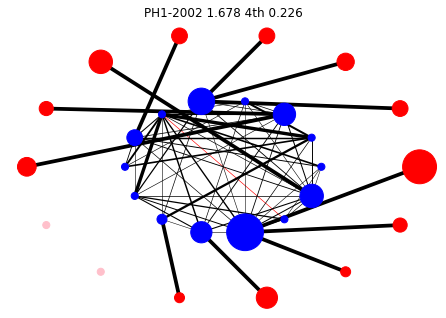

[5.000e+00 1.410e+02 2.540e+02 1.000e+01 1.900e+02 1.000e+00 2.310e+02
 4.300e+01 6.460e+02 1.328e+03 9.700e+02 5.100e+01 8.300e+01 3.890e+02]
(14, 14) (12, 12)
new_ids: ['MWYR', 'MR2O', 'MROR', 'MGOL', 'MLOY', 'MLMN', 'MROD', 'M2MR', 'MGBR', 'MLMB', 'MRY', 'MY2O', 'MYLW', 'MYRM'] ['MWYR', 'MR2O', 'MROR', 'MGOL', 'MLOY', 'MLMN', 'MROD']
juvies: ['M2MR', 'MGBR', 'MLMB', 'MWYR', 'MYLW', 'MYRM', 'MGOL']
n_males: 14
nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 'FYML', 'FWRW', 'FO2D', 'FLOL', 'FNOR', 'FDOD', 'FDR', 'FMYM', 'FWB', 'FWN', 'FYBO']
{'FYML': 4, 'FWRW': 7, 'FO2D': 14, 'FLOL': 3, 'FNOR': 2, 'FDOD': 1, 'FDR': 1, 'FMYM': 1, 'FWB': 1, 'FWN': 1, 'FYBO': 1, 0: 1, 1: 1, 2: 1, 3: 1, 4: 2, 5: 1, 6: 1, 7: 1, 8: 1, 9: 22, 10: 1, 11: 1, 12: 1, 13: 4, 'FLOB': 1, 'FMOY': 1, 'FOWR': 1} [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 'FYML', 'FWRW', 'FO2D', 'FLOL', 'FNOR', 'FDOD', 'FDR', 'FMYM', 'FWB', 'FWN', 'FYBO', 'FLOB', 'FMOY', 'FOWR']
Pairbonded Males: 3 14 25 8.333333333333334
Pai

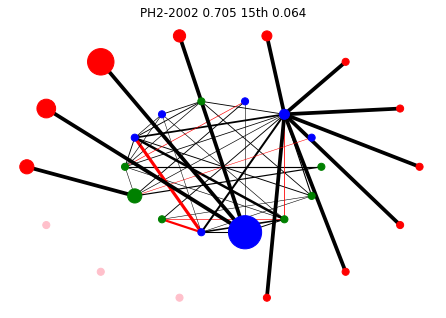

[  68.    0.  303.  388.  369.  202.  814.  143.   16.  103.   52.   61.
   34. 1000.]
(14, 14) (13, 13)
new_ids: ['MDOG', 'MNWL', 'M3O', 'MRYR', 'MDLO', 'MDYG', 'ML', 'MBRD', 'MBRW', 'MDRM', 'MG2L', 'MGDO', 'MLRM', 'MOWN'] ['MDOG', 'MNWL', 'M3O', 'MRYR', 'MDLO', 'MDYG', 'ML']
juvies: ['MG2L', 'MBRW', 'MLRM', 'MGDO', 'MDRM', 'MOWN']
n_males: 14
nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 'FNRG', 'FOG', 'FOYL', 'FLGY', 'FGYR', 'FOLM', 'FNY', 'FMON', 'FORG', 'F2LR', 'F2RG', 'FYRW']
{'FNRG': 8, 'FOG': 5, 'FOYL': 5, 'FLGY': 8, 'FGYR': 3, 'FOLM': 2, 'FNY': 2, 'FMON': 2, 'FORG': 2, 'F2LR': 1, 'F2RG': 1, 'FYRW': 1, 0: 1, 1: 1, 2: 1, 3: 12, 4: 5, 5: 1, 6: 11, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 4, 'FIGHT': 1} [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 'FNRG', 'FOG', 'FOYL', 'FLGY', 'FGYR', 'FOLM', 'FNY', 'FMON', 'FORG', 'F2LR', 'F2RG', 'FYRW', 'FIGHT']
Pairbonded Males: 4 14 28 7.0
Pairbonded Females: 12 13 28 2.3333333333333335
0.1366399291512998
4.071428571428571
['M3O' 

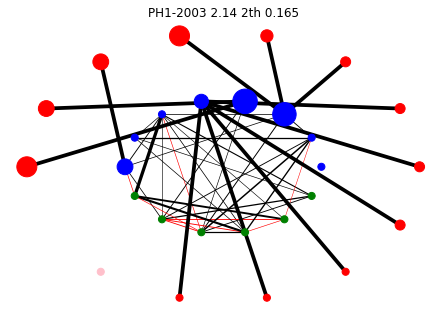

[ 46. 373. 116.  10. 124.  99.   7.  38. 405. 486. 382. 606. 252.]
(13, 13) (13, 13)
new_ids: ['MWYR', 'MR2O', 'MROR', 'MGOL', 'MLOY', 'MLMN', 'MROD', 'MDON', 'MLBL', 'MNW', 'MWD', 'MY', 'MYRD'] ['MWYR', 'MR2O', 'MROR', 'MGOL', 'MLOY', 'MLMN', 'MROD']
juvies: []
n_males: 13
nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 'FYDR', 'F2LO', 'FGRG', 'FGDG', 'FLOR', 'FLRY', 'F2ON', 'FORM', 'FYOG', 'FMYG', 'F2RW']
{'FYDR': 6, 'F2LO': 4, 'FGRG': 3, 'FGDG': 2, 'FLOR': 6, 'FLRY': 35, 'F2ON': 2, 'FORM': 2, 'FYOG': 4, 'FMYG': 4, 'F2RW': 1, 0: 1, 1: 7, 2: 1, 3: 1, 4: 3, 5: 1, 6: 1, 7: 1, 8: 2, 9: 9, 10: 1, 11: 36, 12: 8, 'FRNY': 1} [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 'FYDR', 'F2LO', 'FGRG', 'FGDG', 'FLOR', 'FLRY', 'F2ON', 'FORM', 'FYOG', 'FMYG', 'F2RW', 'FRNY']
Pairbonded Males: 6 13 59 9.833333333333334
Pairbonded Females: 11 12 59 5.363636363636363
0.13735358082421592
2.6153846153846154
['MDON' 'MGOL' 'MLBL' 'MLMN' 'MLOY' 'MNW' 'MR2O' 'MROD' 'MROR' 'MWD'
 'MWYR' 'MY' 'MYRD']


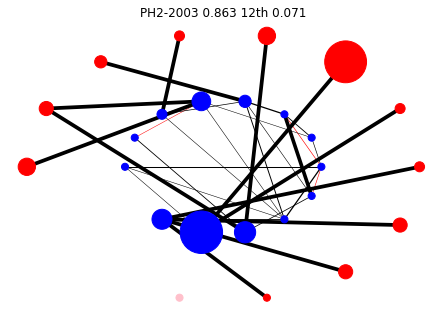

In [334]:
## Build and plot cohesion networks

ph1_overlap = get_overlap(exp_metas[0].m_ids,exp_metas[2].m_ids)
ph2_overlap = get_overlap(exp_metas[1].m_ids,exp_metas[3].m_ids)

exp_egg_text = pd.read_csv('./AviaryDataFiles/Eggs0203.csv')

all_exp_corrs = []

win = 90
for a in range(len(exp_metas)):
    corr_matrix = correlate_fsongs(exp_historys[a],exp_metas[a],exp_sorteds[a],window=win,prune=False)

    all_exp_corrs.append(corr_matrix)


transform_dict = {
    'PH1':'LNA',
    'PH2':'LSA'
}

skip_low = -0.1
skip_high = 0.1

default_size = 1
egg_scale = 50
edge_scale = 5
f_weight = .75

ds,es,a_list= [],[],[]
ds_loser,ds_winner = [],[]
mean_degree = []
mc_list = []
ma_list = []
m_list = []
all_weights = []
avs_to_plot = [0,1,2,3]
verbose = False
skip_juveniles = False # I have to run this twice, which is a little clunky
exp_degrees = [[] for a in exp_metas]

all_scores = []
all_adult_scores = []
all_egg_counts = []

for a in range(len(exp_metas)):
    ## Build dataframe of eggs
    a_id,a_year = exp_metas[a].name.split('-')
    a_id = transform_dict[a_id]
    y_df = exp_egg_text[exp_egg_text['Year'] == int(a_year)]
    a_df = y_df[y_df['Aviary'] == a_id]
    
    aviary_ds = []
    sizes = []
    m_corrs_a = []
    m_list_a = []
    m_act_a = []
    n_females = exp_metas[a].n_females
    n_males = exp_metas[a].n_males

    song_counts = np.sum(exp_historys[a][:,n_females:,:n_females],axis=(0,2))
    print(song_counts)
    corr_matrix = correlate_fsongs(exp_historys[a],exp_metas[a],exp_sorteds[a],window=win,prune=False,shuffle=False)
    pruned_corr_matrix = correlate_fsongs(exp_historys[a],exp_metas[a],exp_sorteds[a],window=win,prune=True,shuffle=False)
    print(corr_matrix.shape,pruned_corr_matrix.shape)
    #rcorr_matrix = ratio_singing(exp_historys[a],exp_metas[a],exp_sorteds[a],window=win,prune=False,shuffle=False)
    #act_list = get_male_activity(exp_historys[a],exp_metas[a],exp_sorteds[a],window=win,prune=False,shuffle=False)
    #rcorr_list = np.nanmean(rcorr_matrix,axis=0)
    #print(np.round(corr_matrix[corr_matrix < -.1],2))
    
    # Rearrange corr matrix to put males that stay on top:
    if a in [0,2]:
        overlap_males = ph1_overlap
    else:
        overlap_males = ph2_overlap
        
    other_males = []
    for m in exp_metas[a].m_ids:
        if m not in overlap_males:
            other_males.append(m)
    A = np.array(corr_matrix)

    ## Easiest way is to just get the order I want, and then arrange it in the network
    new_m_ids = overlap_males + other_males
    if a == 0:
        ## Stash MD at the end so that the males line up
        new_m_ids.append(new_m_ids.pop(new_m_ids.index('MD')))
    print('new_ids:',new_m_ids,overlap_males)
    print('juvies:',exp_metas[a].juveniles)
    #A[np.triu_indices(A.shape[0], -1)] = np.nan
    #A[(A<.2) & (A>-.2)] = 0
    G = nx.from_numpy_array(A)#,create_using=nx.MultiGraph) #Multigraph is default
    Gs = nx.from_numpy_array(A)#,create_using=nx.MultiGraph)

    possible_edges = len(A)
    if skip_juveniles:
        possible_edges -= len(exp_metas[a].juveniles)
    edge_colors = {}
    weights = {}
    remove=[]
    remove_n = []
    remove_s = []
    node_colors = {}
    node_shapes = {}
    sizes = {}
    f_songs = get_fsongs(exp_historys[a],exp_metas[a])
    bond_list,bond_ids = get_pairbonds(f_songs)
    f_egg_scores = np.sum(exp_eggs[a],axis=(0,2))
    
    for n1,n2,d in G.edges(data=True):
        if np.isnan(d['weight']):
            remove.append((n1,n2))
            continue
        if n1==n2:
            remove.append((n1,n2))
            #weights[(n1,n2)] = 1
            #edge_colors[(n1,n2)] = cor
            continue
        if d['weight'] <= skip_low:
            cor = 'red'
            remove_s.append((n1,n2))
        elif d['weight'] > skip_low and d['weight'] < skip_high:
            remove.append((n1,n2))
            continue
        else:
            cor = 'black'
        edge_colors[(n1,n2)] = cor
        weights[(n1,n2)] = d['weight']
    for n in G.nodes():
        m_id = exp_metas[a].m_ids[n]
        if m_id in exp_metas[a].juveniles:
            cor = 'Green'
            node_shapes[n] = 's'
            remove_n.append(n)
            if skip_juveniles:
                continue
        
        else:
            cor = 'Blue'
            node_shapes[n] = 'o'
        node_colors[n] = cor       
    
    if skip_juveniles:
        G.remove_nodes_from(remove_n)
    G.remove_edges_from(remove) 
    #G.remove_edges_from(remove_s)
    ## First add all the female nodes (otherwise things break below)

    all_egg_counts.append([])
    if True:
        for f in pd.unique(a_df['Female']):
            G.add_node(f)
            node_colors[f] = 'Red'
            node_shapes[f] = 'o'
            sizes[f] = default_size
        print('n_males:',len(exp_metas[a].m_ids))
        print('nodes:',G.nodes())
        for n in G.nodes():
            if 'F' in str(n):
                continue
            m_id = exp_metas[a].m_ids[n]
            m_df = a_df[a_df['Male'] == m_id]
            n_pairbonds = len(m_df)
            total_eggs = 0
            #print(m_df)
            for i,row in m_df.iterrows():
                f_id = row['Female']
                f_eggs = row['Eggs']
                total_eggs += f_eggs
                sizes[f_id] = f_eggs + default_size
                
                G.add_edge(n,f_id)
                edge_colors[(n,f_id)] = 'Black'
                weights[(n,f_id)] = f_weight
                #print(n,m_id,f_id,f_eggs)
            sizes[n] = total_eggs + default_size
            all_egg_counts[a].append(total_eggs)
            
        if True:
            for f in exp_metas[a].f_ids:
                if f not in G.nodes():
                    G.add_node(f)
                    sizes[f] = default_size
                    node_colors[f] = 'Pink'
                    node_shapes[f] = 'o'
        
        print(sizes,G.nodes())
        sizes = [sizes[n] * egg_scale for n in G.nodes()]
    else:
        sizes = [default_size * egg_scale for n in G.nodes()]
    

    ## Convert dicts to lists for plotting
    weights = np.array([weights[n] for n in G.edges()]) * edge_scale
    edge_colors = [edge_colors[n] for n in G.edges()]
    node_colors_list = [node_colors[n] for n in G.nodes()]
    node_shapes_list = [node_shapes[n] for n in G.nodes()]
    
    #pos = nx.spring_layout(G)
    
    f_count = 0

    for n in G.nodes():
        if 'F' not in str(n):
            m_id = exp_metas[a].m_ids[n]
            new_id = new_m_ids.index(m_id)
            r = 1 
            theta = new_id / (14) * np.pi * 2

        else:
            r = 2
            theta = f_count / (14) * np.pi * 2
            f_count += 1
        x = -1 * np.cos(theta) * r
        y = np.sin(theta) * r

        pos[n] = [x,y]    
        
    ## JUMP BACK
    all_weights.append(weights)
    #print(G.degree())
    for n,d in G.degree():
        #print(d,possible_edges)
        exp_degrees[a].append(d / possible_edges)
    
    m_pairbonded = len(np.unique(a_df['Male']))
    f_pairbonded = len(np.unique(a_df['Female']))
    n_males = exp_metas[a].n_males
    n_females = exp_metas[a].n_females
    n_eggs = np.sum(a_df['Eggs'])
    m_mean = n_eggs / m_pairbonded
    f_mean = n_eggs / f_pairbonded
    print('Pairbonded Males:',m_pairbonded,n_males,n_eggs,m_mean)
    print('Pairbonded Females:',f_pairbonded,n_females,n_eggs,f_mean)
    
    ## Calculate mean connectivity of males
    m_scores = []
    adult_scores = []
    m_degrees = []
    #print(G.edges(data=True))
    for n in G.nodes():
        if 'F' in str(n):
            continue
        weight_sum = 0
        edge_count = 0
        neg_count = 0
        for n1,n2,d in G.edges(data=True):
            
            if n not in (n1,n2):
                continue
            #if node_colors[n1] != 'Blue' or node_colors[n2] != 'Blue':
            ## This excludes juveniles though...
            
            if 'red' in node_colors[n1].lower() or 'red' in node_colors[n2].lower():
                continue
            if 'blue' not in node_colors[n1].lower() or 'blue' not in node_colors[n2].lower():
                pass
                #continue
            weight_sum += d['weight']
            edge_count += 1
            if weight_sum < 0.1:
                neg_count += 1
        #print(weight_sum,edge_count)
        if edge_count != 0:
            m_scores.append(weight_sum / (edge_count))
            if exp_metas[a].m_ids[n] not in exp_metas[a].juveniles:
                adult_scores.append(weight_sum / edge_count)
        m_degrees.append(edge_count - neg_count)
    all_scores.append(m_scores)
    all_adult_scores.append(adult_scores)
    print(np.mean(m_scores))
    print(np.mean(m_degrees))
    
    if a in avs_to_plot:
        print(exp_metas[a].m_ids)
        nx.draw(G,pos,width=weights,edge_color=edge_colors,
                node_color=node_colors_list,node_size=sizes)
        if False:
            for n in G.nodes:
                plt.text(pos[n][0],pos[n][1],str(n))
        plt.title(exp_metas[a].name)
        plt.title(exp_metas[a].name + ' ' + str(np.round(egg_scores[a],3)) + ' ' + str(int(egg_ranks[a])) + 'th ' + 
                 str(np.round(corrs[a],3)))
        plt.savefig('./fig4a' + str(a) + '.svg')
        plt.show()

In [331]:
## "Stats" for Fig 4

# Aviary 1: 
print('Aviary 1:')
a0_scores = np.nanmean(all_exp_corrs[0],0)
a2_scores = np.nanmean(all_exp_corrs[2],0)

print('A0 vs A2 Cohesion:',ttest_ind(a0_scores,a2_scores[~np.isnan(a2_scores)]),len(a0_scores),len(a2_scores)-1)
print('means:',np.nanmean(a0_scores),np.nanmean(a2_scores))
print('A0 vs A2 paired t-test:') 
overlap_males = get_overlap(exp_metas[0].m_ids,exp_metas[2].m_ids)
print(overlap_males)
a0_overlaps = [list(exp_metas[0].m_ids).index(m) for m in overlap_males]
a2_overlaps = [list(exp_metas[2].m_ids).index(m) for m in overlap_males]

print(a0_overlaps,a2_overlaps)
print(stats.ttest_rel(a0_scores[a0_overlaps],a2_scores[a2_overlaps]))

# Aviary 2
print('')
print('Aviary 2:')
a1_scores = np.nanmean(all_exp_corrs[1],0)
a3_scores = np.nanmean(all_exp_corrs[3],0)

print('A1 vs A3 Cohesion:',ttest_ind(a1_scores,a3_scores[~np.isnan(a3_scores)]),len(a1_scores),len(a3_scores))
print('means:',np.nanmean(a1_scores),np.nanmean(a3_scores))
## Intergroup cohesion: 
a03_overlap = get_overlap(exp_metas[0].m_ids,exp_metas[3].m_ids)
a13_overlap = get_overlap(exp_metas[1].m_ids,exp_metas[3].m_ids)
print(a03_overlap,a13_overlap)

a03_overlap_indices = [list(exp_metas[3].m_ids).index(m) for m in a03_overlap]
a13_overlap_indices = [list(exp_metas[3].m_ids).index(m) for m in a13_overlap]

print(a03_overlap_indices,a13_overlap_indices)
a00_scores = np.array(all_exp_corrs[3][a03_overlap_indices])[:,a03_overlap_indices]

a01_scores = np.array(all_exp_corrs[3][a03_overlap_indices])[:,a13_overlap_indices]
a11_scores = np.array(all_exp_corrs[3][a13_overlap_indices])[:,a13_overlap_indices]
print(np.nanmean(a00_scores),np.nanmean(a01_scores),np.nanmean(a11_scores),np.nanmean(all_exp_corrs[3]))

## Discord
def get_discord(corr_matrix,thresh = -0.1):
    try:
        _ = corr_matrix.shape
    except:
        print('badd corr')
        return np.nan
    edges = corr_matrix.shape[0] * (corr_matrix.shape[1] - 1)
    edges = np.nansum(~np.isnan(corr_matrix))
    neg_edges = np.nansum(corr_matrix <= thresh)
    prop_discord = neg_edges / edges
    return prop_discord


print('')
print('Discord:')
for a in [0,3,1,2]:
    print(a,get_discord(all_exp_corrs[a]))
    
all_discord = [get_discord(all_corrs[a]) for a in range(len(all_corrs))]
all_discord = np.array(all_discord)
print('Discord is not unheard of in other aviaries:',all_discord)
print('Discord predicts egg production:')
print(pearsonr(all_discord[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
print(pearsonr(all_discord,corrs))

## Juveniles vs Adults: 

Aviary 1:
A0 vs A2 Cohesion: Ttest_indResult(statistic=3.1024222415724214, pvalue=0.004714722115189529) 14 13
means: 0.12138518403392484 0.06765040460661581
A0 vs A2 paired t-test:
['MDOG', 'MNWL', 'M3O', 'MRYR', 'MDLO', 'MDYG', 'ML']
[3, 9, 0, 10, 2, 5, 6] [4, 11, 0, 13, 3, 6, 9]
Ttest_relResult(statistic=7.741741360909223, pvalue=0.000243990060731678)

Aviary 2:
A1 vs A3 Cohesion: Ttest_indResult(statistic=0.6385924004026317, pvalue=0.5288955318373304) 14 13
means: 0.05867518816032604 0.05036664183844865
['MDON', 'MWD', 'MY', 'MLBL', 'MYRD', 'MNW'] ['MWYR', 'MR2O', 'MROR', 'MGOL', 'MLOY', 'MLMN', 'MROD']
[0, 9, 11, 2, 12, 5] [10, 6, 8, 1, 4, 3, 7]
0.053030692303565954 0.05900612921597737 0.03186336955976894 0.05068393517899921

Discord:
0 0.01098901098901099
3 0.039473684210526314
1 0.0759493670886076
2 0.10526315789473684
Discord is not unheard of in other aviaries: [0.         0.28125    0.         0.20930233 0.08888889 0.04761905
 0.03571429 0.15555556 0.11111111 0.         0.    

In [347]:
## "Stats" for Fig 4

# Aviary 1: 
print('Aviary 1:')
a0_scores = np.nanmean(all_exp_corrs[0],0)
a2_scores = np.nanmean(all_exp_corrs[2],0)

print('A0 vs A2 Cohesion:',ttest_ind(a0_scores,a2_scores[~np.isnan(a2_scores)]),len(a0_scores),len(a2_scores)-1)

print('A0 vs A2 paired t-test:') 
overlap_males = get_overlap(exp_metas[0].m_ids,exp_metas[2].m_ids)
print(overlap_males)
a0_overlaps = [list(exp_metas[0].m_ids).index(m) for m in overlap_males]
a2_overlaps = [list(exp_metas[2].m_ids).index(m) for m in overlap_males]

print(a0_overlaps,a2_overlaps)
print(stats.ttest_rel(a0_scores[a0_overlaps],a2_scores[a2_overlaps]))

print('overall means:',np.nanmean(a0_scores),np.nanmean(a2_scores))
print('overlap means:',np.nanmean(a0_scores[a0_overlaps]),np.nanmean(a2_scores[a2_overlaps]))
# Aviary 2
print('')
print('Aviary 2:')
a1_scores = np.nanmean(all_exp_corrs[1],0)
a3_scores = np.nanmean(all_exp_corrs[3],0)

print('A1 vs A3 Cohesion:',ttest_ind(a1_scores,a3_scores[~np.isnan(a3_scores)]),len(a1_scores),len(a3_scores))

## Intergroup cohesion: 
a03_overlap = get_overlap(exp_metas[0].m_ids,exp_metas[3].m_ids)
a13_overlap = get_overlap(exp_metas[1].m_ids,exp_metas[3].m_ids)
print(a03_overlap,a13_overlap)

a03_overlap_indices = [list(exp_metas[3].m_ids).index(m) for m in a03_overlap]
a13_overlap_indices = [list(exp_metas[3].m_ids).index(m) for m in a13_overlap]

print(a03_overlap_indices,a13_overlap_indices)
a00_scores = np.array(all_exp_corrs[3][a03_overlap_indices])[:,a03_overlap_indices]

a01_scores = np.array(all_exp_corrs[3][a03_overlap_indices])[:,a13_overlap_indices]
a11_scores = np.array(all_exp_corrs[3][a13_overlap_indices])[:,a13_overlap_indices]
print(np.nanmean(a00_scores),np.nanmean(a01_scores),np.nanmean(a11_scores),np.nanmean(all_exp_corrs[3]))

## Discord
def get_discord(corr_matrix,thresh = -0.1):
    try:
        _ = corr_matrix.shape
    except:
        print('badd corr')
        return np.nan
    edges = corr_matrix.shape[0] * (corr_matrix.shape[1] - 1)
    edges = np.nansum(~np.isnan(corr_matrix))
    neg_edges = np.nansum(corr_matrix <= thresh)
    prop_discord = neg_edges / edges
    return prop_discord


print('')
print('Discord:')
for a in [0,3,1,2]:
    print(a,get_discord(all_exp_corrs[a]))
    
all_discord = [get_discord(all_corrs[a]) for a in range(len(all_corrs))]
all_discord = np.array(all_discord)
print('Discord is not unheard of in other aviaries:',all_discord)
print('Discord predicts egg production:')
print(pearsonr(all_discord[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
print(pearsonr(all_discord,corrs))

## Juveniles vs Adults: 

Aviary 1:
A0 vs A2 Cohesion: Ttest_indResult(statistic=3.1024222415724214, pvalue=0.004714722115189529) 14 13
A0 vs A2 paired t-test:
['MDOG', 'MNWL', 'M3O', 'MRYR', 'MDLO', 'MDYG', 'ML']
[3, 9, 0, 10, 2, 5, 6] [4, 11, 0, 13, 3, 6, 9]
Ttest_relResult(statistic=7.741741360909223, pvalue=0.000243990060731678)
overall means: 0.12138518403392484 0.06765040460661581
overlap means: 0.14157260408690953 0.07235188178041352

Aviary 2:
A1 vs A3 Cohesion: Ttest_indResult(statistic=0.6385924004026317, pvalue=0.5288955318373304) 14 13
['MDON', 'MWD', 'MY', 'MLBL', 'MYRD', 'MNW'] ['MWYR', 'MR2O', 'MROR', 'MGOL', 'MLOY', 'MLMN', 'MROD']
[0, 9, 11, 2, 12, 5] [10, 6, 8, 1, 4, 3, 7]
0.053030692303565954 0.05900612921597737 0.03186336955976894 0.05068393517899921

Discord:
0 0.01098901098901099
3 0.039473684210526314
1 0.0759493670886076
2 0.10526315789473684
Discord is not unheard of in other aviaries: [0.         0.28125    0.         0.20930233 0.08888889 0.04761905
 0.03571429 0.15555556 0.11111111 0

## END OF IMPORTANT CODE

In [296]:
## Calculate Adults and juveniles cohesion

# Get a_ids and j_ids (save them to the metas for future use)

for i in range(4):
    a = [0,2,3,1][i]
    n_males = exp_metas[a].n_males
    #print(exp_metas[a].juveniles)
    #print(exp_metas[a].m_ids)
    
    j_ids = np.zeros(n_males,dtype=bool)

    a_ids = np.zeros_like(j_ids,dtype=bool)
    A_ids = np.ones_like(j_ids,dtype=bool)
    for m_i in range(len(exp_metas[a].m_ids)):
        m = exp_metas[a].m_ids[m_i]
        if m in exp_metas[a].juveniles:
            j_ids[m_i] = True
        else:
            a_ids[m_i] = True
    #print(j_ids)

    
    exp_metas[a].j_ids = j_ids
    exp_metas[a].a_ids = a_ids
    # Calculate Cohesion, Degree Cohesion, and Discord for A X J (aA,aa,aj,jj,jA,AA)
    corr_matrix = np.array(all_exp_corrs[a]) ## This is AA
    #corr_matrix[np.where(corr_matrix > -.1) and np.where(corr_matrix < .1)] = np.nan
    aA_corrs = corr_matrix[a_ids,:]
    jA_corrs = corr_matrix[j_ids,:]
    
    aa_corrs = aA_corrs[:,a_ids]
    aj_corrs = aA_corrs[:,j_ids]
    
    jj_corrs = jA_corrs[:,j_ids]
    ja_corrs = jA_corrs[:,a_ids]
    
    #print(jj_corrs)
    ## Degree cohesion
    a_degrees,j_degrees = [],[]
    a_discord,j_discord = [],[]
    A_degrees,A_discord = [],[]
    for m in range(len(corr_matrix)):
        m_deg = np.sum(corr_matrix[m] > .1)
        m_discord = np.sum(corr_matrix[m] < -0.1)
        A_degrees.append(m_deg)
        A_discord.append(m_discord)
        if a_ids[m]:
            a_degrees.append(m_deg)
            a_discord.append(m_discord)
        elif j_ids[m]:
            j_degrees.append(m_deg)
            j_discord.append(m_discord)
            
    print(a,np.nanmean(corr_matrix),np.nanmean(jA_corrs),np.nanmean((aA_corrs)))
    print('.aa cohesion,ja cohesion',np.nanmean(aa_corrs),np.nanmean(ja_corrs))
    print('..degree (ajA)',np.mean(a_degrees),np.mean(j_degrees),np.mean(A_degrees))
    print('...discord ratio',get_discord(corr_matrix),
          get_discord(aa_corrs),
          get_discord(jj_corrs),
          get_discord(ja_corrs),)
    print('....medians',np.nanmedian(corr_matrix),
          np.nanmedian(aa_corrs),
          np.nanmedian(jj_corrs),
          np.nanmedian(ja_corrs))
    print('.....',a_discord,j_discord,np.mean(a_discord),np.mean(j_discord),np.mean(A_discord))
    

0 0.12138518403392486 nan 0.12138518403392486
.aa cohesion,ja cohesion 0.12138518403392486 nan
..degree (ajA) 7.285714285714286 nan 7.285714285714286
...discord ratio 0.01098901098901099 0.01098901098901099 nan nan
....medians 0.1106921345750782 0.1106921345750782 nan nan
..... [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0] [] 0.14285714285714285 nan 0.14285714285714285
2 0.06801214329258892 0.06252285974438782 0.07257552359169589
.aa cohesion,ja cohesion 0.07477401083687871 0.07032341470638666
..degree (ajA) 3.25 4.0 3.5714285714285716
...discord ratio 0.10526315789473684 0.0 0.35714285714285715 0.07317073170731707
....medians 0.055858193823513536 0.0688077561430571 -0.007542554363026796 0.056579821459298865
..... [1, 0, 0, 1, 0, 1, 0, 0] [0, 3, 2, 3, 3, 2] 0.375 2.1666666666666665 1.1428571428571428
3 0.05068393517899921 nan 0.05068393517899921
.aa cohesion,ja cohesion 0.05068393517899921 nan
..degree (ajA) 2.769230769230769 nan 2.769230769230769
...discord ratio 0.039473684210526314 0.0

(14372, 28, 28)
['M2MR', 'MGBR', 'MLMB', 'MWYR', 'MYLW', 'MYRM', 'MGOL']


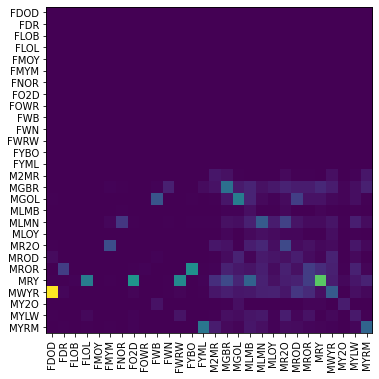

In [179]:
print(exp_historys[1].shape)
print(exp_metas[1].juveniles)

fig,ax = plt.subplots()
ax.imshow(np.nanmean(exp_historys[a],0))

ax.set_yticks(np.arange(28))
ax.set_yticklabels(list(exp_metas[1].f_ids) + list(exp_metas[1].m_ids))

ax.set_xticks(np.arange(28))
ax.set_xticklabels(list(exp_metas[1].f_ids) + list(exp_metas[1].m_ids),rotation=90)

fig.set_size_inches(6,6)
fig.show()

0.016774560941247182
0.0356315845291474
0.011109351698556865
0.0170696325593018


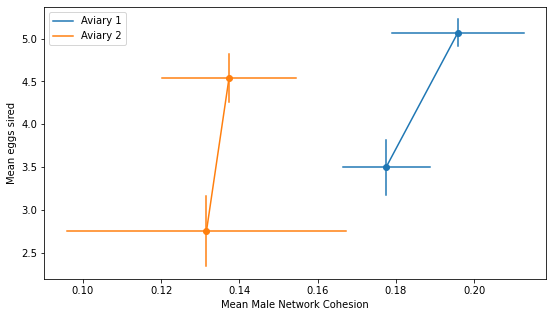

In [556]:
fig,ax = plt.subplots()
exp_c_scores = [np.mean(all_scores[a]) for a in range(len(all_scores))]
#ax.plot([exp_c_scores[0],exp_c_scores[2]],[np.sum(exp_eggs[0]),np.sum(exp_eggs[2])])
#ax.plot([exp_c_scores[3],exp_c_scores[1]],[np.sum(exp_eggs[3]),np.sum(exp_eggs[1])])

ax.plot([exp_c_scores[0],exp_c_scores[2]],[np.mean(all_egg_counts[0]),np.mean(all_egg_counts[2])],label='Aviary 1')
ax.plot([exp_c_scores[3],exp_c_scores[1]],[np.mean(all_egg_counts[3]),np.mean(all_egg_counts[1])],label='Aviary 2')

ax.scatter([exp_c_scores[0],exp_c_scores[2]],[np.mean(all_egg_counts[0]),np.mean(all_egg_counts[2])])
ax.scatter([exp_c_scores[3],exp_c_scores[1]],[np.mean(all_egg_counts[3]),np.mean(all_egg_counts[1])])


m_errs = []
for a in range(4):
    err = np.std(all_adult_scores[a])/np.sqrt(len(all_adult_scores[a]))
    ax.plot([exp_c_scores[a] - err,exp_c_scores[a] + err],
            [np.mean(all_egg_counts[a]),np.mean(all_egg_counts[a])],color=cm.tab10(a % 2))
    y_err = np.std(all_weights[a] - 1)/np.sqrt(len(all_weights[a]))
    ax.plot([exp_c_scores[a],exp_c_scores[a]],
            [np.mean(all_egg_counts[a]) - y_err,np.mean(all_egg_counts[a]) + y_err],color=cm.tab10(a % 2))
    print(err)
ax.set_ylabel('Mean eggs sired')
ax.set_xlabel('Mean Male Network Cohesion')

#ax.set_xlim([0,.4])
ax.legend()
fig.set_size_inches(9,5)
fig.savefig('./fig4b.png',dpi=300)
fig.show()

In [2760]:
print(all_weights[0])

[ 3.37099931  0.54244677  1.77358491  1.68763185  1.20520839  3.40692572
  0.65725643 -0.61630695  0.73879819  1.28612364  1.50986536  0.70626415
  0.56003373  0.62589588  1.49205588  1.18437801  1.01041267  1.26522153
  0.51571141  0.50001966  0.69751173  1.78004536  0.71160064  0.50686934
  0.57215318  1.55036769  0.79614816  0.58164377  1.11517378  1.07440899
  0.62172168  0.99998243  0.7323032   0.69941106  0.84728547  0.9054026
  3.75        3.75        0.87270038  1.27353937  0.75556245  2.52968865
  0.66323141  0.99814802  0.82263836  0.943456    1.04743813  3.75
  0.58073411  0.93423513  0.6769327   3.75        0.65269895  0.64161383
  3.75        3.75        3.75        0.70323036  3.75        3.75
  3.75        3.75        3.75      ]


In [2410]:
print(ttest_ind([np.sum(exp_eggs[0]),np.sum(exp_eggs[3])],[np.sum(exp_eggs[1]),np.sum(exp_eggs[2])]))
print([np.sum(exp_eggs[0]),np.sum(exp_eggs[3])],[np.sum(exp_eggs[2]),np.sum(exp_eggs[1])])

print((149-75)/(exp_c_scores[0] - exp_c_scores[2]))
print((97-78)/(exp_c_scores[3] - exp_c_scores[1]))

Ttest_indResult(statistic=1.785492587996762, pvalue=0.2161034613523733)
[149.0, 97.0] [75.0, 78.0]
1118.468485917664
542.3377390783573


[11  6  8  6  7  9  6 10  6  7 10 12  6  4] (14, 14)
7.714285714285714
[-1  3  6  5  5  7  2  9  1  5  4  6  4  3  4] (15, 15)
4.2
[ 7 -1  4  2  5  5  4  5  6  8  4  5  4  1] (14, 14)
4.214285714285714
[4 1 3 4 3 4 2 3 3 3 4 2 4] (13, 13)
3.076923076923077
Ttest_indResult(statistic=-1.6232433764430971, pvalue=0.10544025852864836)
Ttest_indResult(statistic=0.9907312346200822, pvalue=0.3225405137923891)
Ttest_indResult(statistic=2.5458143999325524, pvalue=0.011954135900395374)
68 78
1.1470588235294117


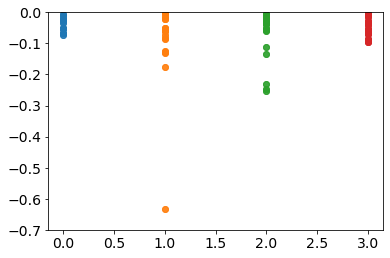

In [2418]:
## Check negative correlations in experimental aviaries
fig,ax = plt.subplots()

male_acts_all = []
my_list = []
for a in range(4):
    male_acts = get_male_activity(exp_historys[a],exp_metas[a],exp_sorteds[a],window=win,prune=False,receiver='female')
    male_corrs = all_exp_corrs[a].flatten()
    #male_corrs = male_corrs[male_corrs < 0]
    m_degrees = np.sum(all_exp_corrs[a] > .1,axis=0) - 1
    print(m_degrees,all_exp_corrs[a].shape)
    print(np.mean(m_degrees))
    my_list.append(male_corrs[~np.isnan(male_corrs)])
    #ax.scatter([a]*len(male_acts),male_acts,alpha=.7)
    ax.scatter([a]*len(male_corrs),male_corrs,alpha=.7)
    male_acts_all.append(male_acts)
    
ax.set_ylim([-0.7,0])
fig.show()
print(ttest_ind(my_list[2],my_list[0]))
print(ttest_ind(my_list[1],my_list[3]))
neg_juvies = np.hstack([my_list[1],my_list[2]])
neg_juvies = neg_juvies[neg_juvies < 0]
neg_fogies = np.hstack([my_list[0],my_list[3]])
neg_fogies = neg_fogies[neg_fogies < 0]
print(ttest_ind(neg_fogies,neg_juvies))
print(len(neg_fogies),len(neg_juvies))
print(len(neg_juvies)/len(neg_fogies))

In [2453]:
## Check number of negative correlations in all the aviaries: 
negging = []
negg_m = []
for a in range(len(metas)):
    corr_matrix = correlate_fsongs(historys[a],metas[a],sorteds[a],window=win,prune=False,shuffle=False)
    print(np.sum(corr_matrix < -0.1)/len(corr_matrix.flatten()),np.round(corrs[a],2))
    negging.append(np.sum(corr_matrix < -0.1)/(len(corr_matrix.flatten() - len(corr_matrix))))
    negg_m.append(np.nanmean(corr_matrix[corr_matrix < -0.1]))
fig, ax =plt.subplots()

#ax.hist(negging)


print('exp:')
for a in range(4):
    corr_matrix = all_exp_corrs[a]
    print(np.sum(corr_matrix < -0.1)/len(corr_matrix.flatten()))
    
negging = np.array(negging)
negg_m = np.array(negg_m)
negg_m[np.isnan(negg_m)] = 0
negg_m = np.abs(negg_m)

print(negging,np.mean(negging))
print(np.std(negging))
#ax.hist(egg_scores)

print(ttest_ind(negging[egg_scores < .75],negging[egg_scores > 1.25]))
ax.scatter(egg_scores,negg_m)
print(pearsonr(negging[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
print(pearsonr(negg_m[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
fig.show()

0.0 0.25
0.22448979591836735 0.04
0.0 0.18
0.1640625 0.07
0.08 0.09
0.03125 0.11
0.03125 0.11
0.11570247933884298 0.12
0.08 0.11
0.16326530612244897 0.14
0.0 0.12
0.049586776859504134 0.08
0.08 0.09
0.0625 0.11
0.06 0.09
0.03125 0.18
0.09876543209876543 0.24
0.049586776859504134 0.12
0.09467455621301775 0.09
exp:
0.0
0.044444444444444446
0.05102040816326531
0.0
[0.         0.2244898  0.         0.1640625  0.08       0.03125
 0.03125    0.11570248 0.08       0.16326531 0.         0.04958678
 0.08       0.0625     0.06       0.03125    0.09876543 0.04958678
 0.09467456] 0.07454650649528688
0.05850769713382463
Ttest_indResult(statistic=1.03827082008421, pvalue=0.3295043951540292)
(-0.23476507268257116, 0.36440643233289455)
(-0.2777093424948657, 0.2804909338267862)


In [2472]:
## Compare Adult and Juvenile Behavior

pair_counts = [[],[]]
song_counts = [[],[]]
fsong_counts = [[],[]]
n_neg_counts = [[],[]]
for a in range(4):
    n_females = exp_metas[a].n_females

    f_songs = get_fsongs(exp_historys[a],exp_metas[a])
    bond_list,bond_ids = get_pairbonds(f_songs)

    for m in range(exp_metas[a].n_males):
        if exp_metas[a].m_ids[m] in exp_metas[a].juveniles:
            juv = True
        else:
            juv = False


        n_songs = np.sum(exp_historys[a][:,n_females + m])
        n_fsongs = np.sum(exp_historys[a][:,n_females + m,n_females:])
        n_pairbonds = len(bond_list[m])
        n_negative = np.sum(all_exp_corrs[a] < 0.1)
        
        if not juv:
            pair_counts[0].append(n_pairbonds)
            song_counts[0].append(n_songs)
            fsong_counts[0].append(n_fsongs)
            n_neg_counts[0].append(n_negative)
        else:
            pair_counts[1].append(n_pairbonds)
            song_counts[1].append(n_songs)
            fsong_counts[1].append(n_fsongs)
            n_neg_counts[1].append(n_negative)
            
print(ttest_ind(*pair_counts))
print(ttest_ind(*song_counts))
print(ttest_ind(*fsong_counts))
print(ttest_ind(*n_neg_counts))

print(np.unique(pair_counts[1],return_counts=True))
print(np.unique(pair_counts[0],return_counts=True))

Ttest_indResult(statistic=1.7885765838526917, pvalue=0.07939913139182168)
Ttest_indResult(statistic=1.7913838360653984, pvalue=0.07894214772662923)
Ttest_indResult(statistic=2.1018053760627087, pvalue=0.040339681866147975)
Ttest_indResult(statistic=-0.21684402623796262, pvalue=0.8291624538938676)
(array([0, 1]), array([8, 4]))
(array([0, 1, 2, 3]), array([20, 13,  5,  5]))


Ttest_indResult(statistic=0.6014965901185513, pvalue=0.555446338892994)
Ttest_indResult(statistic=0.15631131166202006, pvalue=0.8775274197340416)
Ttest_indResult(statistic=0.6669196728786337, pvalue=0.508961394906007)


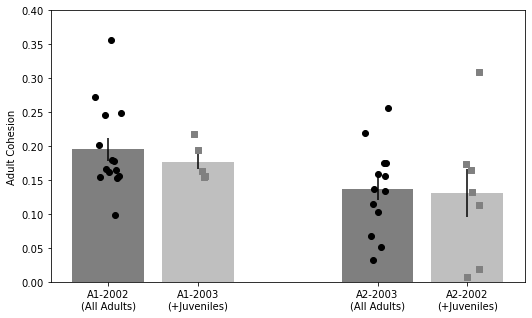

In [563]:
## Comparing Adult cohesion, must omit juveniles for this, which I think I do above when calculating all scores
fig,ax =plt.subplots()
bar_pos = [0,4,1,3]
name_dict = {
    0:'Aviary 1 (Adults)',
    1:'Aviary 2 (Juveniles)',
    2:'Aviary 1 (Juveniles)',
    3:'Aviary 2 (Adults)'
}

color_list = ['black','gray','gray','black']
shape_list = ['o','s','s','o']
for a in [0,2,3,1]:
    y_err = np.std(all_adult_scores[a])/np.sqrt(len(all_adult_scores[a]))
    ax.bar(bar_pos[a],np.mean(all_adult_scores[a]),color=color_list[a],alpha=.5,label=name_dict[a],yerr=y_err)
    jitter = np.random.rand(len(all_adult_scores[a])) * .3 - .15
    ax.scatter([bar_pos[a]]*len(all_adult_scores[a]) + jitter,all_adult_scores[a],
               color=color_list[a],marker=shape_list[a])
    
ax.set_ylabel('Adult Cohesion')
ax.set_ylim(0,.4)
#fig.legend()
fig.show()

fig.set_size_inches(8.5,5)

ax.set_xticks([0,1,3,4])
ax.set_xticklabels(['A1-2002\n(All Adults)','A1-2003\n(+Juveniles)','A2-2003\n(All Adults)','A2-2002\n(+Juveniles)'])

print(ttest_ind(all_adult_scores[0],all_adult_scores[2]))
print(ttest_ind(all_adult_scores[3],all_adult_scores[1]))

print(ttest_ind(np.hstack([all_adult_scores[0],all_adult_scores[3]]),np.hstack([all_adult_scores[1],all_adult_scores[2]])))

fig.savefig('./fig4d.png',dpi=300)

# Bonus code, not currently appearing in manuscript
A mix of failed attempts at measuing cohesion without just measuring male activity,
along with some additional analyses that did not fit into the paper

PH4-2007 4367 ['M2YL' 'MDRO' 'MGDL' 'MLNR' 'MLYR' 'MMGR' 'MMLD' 'MMWD' 'MNDO' 'MRG'
 'MRLW']


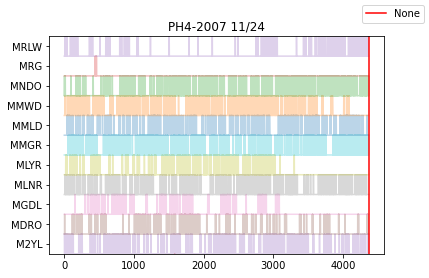

In [22]:
### SKIPPED: There are some typos that needed to be fixed, this helps check for them. Otherwise skippable 

a = 7
if False:
    print(metas[a].name)
    print(metas[a].cutoff_s)
    if metas[a].cutoff_s is not None:
        print(day_of_year(metas[a].cutoff_s))
        cutoff_label = day_of_year(metas[a].cutoff_s)
    else:
        cutoff_label = 'None'
    print(all_eggs[a].shape)
## Check to make sure we're not leaving any males out or something weird. 
male_activity = np.sum(historys[a],axis=(2))
#print(male_activity.shape)
if metas[a].cutoff_s is not None:
    cutoff_label = day_of_year(metas[a].cutoff_s)
else:
    cutoff_label = 'None'
    
fig,ax = plt.subplots()
for m in range(male_activity.shape[1]):
    ax.plot(range(male_activity.shape[0]),male_activity[:,m] + m,alpha=.3) #label=str(m),
ax.axvline(metas[a].cutoff-metas[a].start,color='red',label=cutoff_label)
ax.set_title(metas[a].name + ' ' +str(metas[a].n_males) + '/' + str(metas[a].n_females))

print(metas[a].name,metas[a].cutoff,metas[a].m_ids)


ax.set_yticks(np.arange(metas[a].n_birds)+.5)
ax.set_yticklabels(metas[a].bird_ids)
ax.set_ylim([metas[a].n_females,metas[a].n_birds])

fig.legend()
fig.show()

In [23]:
# SKIPPED: Lots of failed attempts at capturing Cohesion. Basically these all end up just capturing singing rates
# Also, they were much too complicated to want to explain in such a short paper

#Define 'get male states'. Eventually I think I can drop this, but it still probably comes up in some places 

# Define the group state as a point in space
from scipy.spatial import ConvexHull

def tetrahedron_volume(a, b, c, d):
    return np.abs(np.einsum('ij,ij->i', a-d, np.cross(b-d, c-d))) / 6

def convex_hull_volume_bis(pts):
    ch = ConvexHull(pts)

    simplices = np.column_stack((np.repeat(ch.vertices[0], ch.nsimplex),
                                 ch.simplices))
    tets = ch.points[simplices]
    return np.sum(tetrahedron_volume(tets[:, 0], tets[:, 1],
                                     tets[:, 2], tets[:, 3]))

def get_male_states_4D(history_bins, meta):
    n_states = 4
    male_states = np.zeros([len(history_bins),meta.n_males,n_states])
    
    n_males,n_females = meta.n_males,meta.n_females
    for b in range(len(history_bins)):
        for m in range(n_males):
            m_songs = np.sum(history_bins[b,m + n_females,n_females:])
            f_songs = np.sum(history_bins[b,m+n_females,:n_females])
            u_songs = history_bins[b,m + n_females,m+n_females]
            m_songs = m_songs - u_songs
            if f_songs > 0:
                m_state = [0,1,0,0] #[0,1] #2d is easier to visualize, but 3d seems better
            elif m_songs > 0:
                m_state = [1,0,0,0] #[1,0]
            elif u_songs > 0:
                m_state = [0,0,1,0] #[.7,.7]
            else:
                m_state = [0,0,0,1]
            male_states[b,m] = m_state   
    return male_states            
            
def get_male_states(history_bins, meta, threeD = True):
    if threeD:
        n_states = 3
    else:
        n_states = 2
    male_states = np.zeros([len(history_bins),meta.n_males,n_states])

    n_males,n_females = meta.n_males,meta.n_females
    for b in range(len(history_bins)):
        for m in range(n_males):
            m_songs = np.sum(history_bins[b,m + n_females,n_females:])
            f_songs = np.sum(history_bins[b,m+n_females,:n_females])
            u_songs = history_bins[b,m + n_females,m+n_females]
            m_songs = m_songs - u_songs
            if f_songs > 0:
                m_state = [0,1,0] #[0,1] #2d is easier to visualize, but 3d seems better
            elif m_songs > 0:
                m_state = [1,0,0] #[1,0]
            elif u_songs > 0:
                m_state = [0,0,1] #[.7,.7]
            else:
                m_state = [0,0,0]
            if not threeD:
                if m_state == [0,0,1]:
                    m_state = [.7,.7]
                else:
                    m_state = m_state[:2]
            #print(m_state)
            male_states[b,m] = m_state   
    return male_states

if False:
    a = 5
    history_bins,[history_rate_bins,ts,window_indices]= bin_history(sorteds[a],historys[a],metas[a],window=100)
    male_states = np.zeros([len(history_bins),metas[a].n_males,2])

    n_males,n_females = metas[a].n_males,metas[a].n_females
    for b in range(len(history_bins)):
        for m in range(metas[a].n_males):
            m_songs = np.sum(history_bins[b,m + n_females,n_females:])
            f_songs = np.sum(history_bins[b,m+n_females,:n_females])
            u_songs = history_bins[b,m + n_females,m+n_females]
            m_songs = m_songs - u_songs
            if f_songs > 0:
                m_state = [0,1] #2d is easier to visualize, but 3d seems better
            elif m_songs > 0:
                m_state = [1,0]
            elif u_songs > 0:
                m_state = [.7,.7]
            else:
                m_state = [0,0]

            male_states[b,m] = m_state

    fig,ax = plt.subplots()
    ax.scatter(np.sum(male_states[:,:,0],1),np.sum(male_states[:,:,1],1),alpha=.1)
    fig.show()


In [25]:
## SKIPPED: Old Function to calculate the sttc (spike time tiling coefficient) for bins
## This would be skippable, but it's optionally called in the cell below, so for now it stays. 

## Returns m x m x 3 matrix of pairwise, directional cohesion metrics for each behavior
def get_sttc(male_states):

    n_males = male_states.shape[1]
    agree_matrix = np.zeros([len(male_states),3,n_males,n_males])

    T_matrix_all = np.mean(male_states,axis=0)
    sum_matrix_all = np.sum(male_states,axis=0)
    for i in range(len(male_states)):
        for s in range(3):

            bin_agreement_s = pdist(np.reshape(male_states[i,:,s],[-1,1]),metric=np.dot)
            agree_matrix[i,s] = squareform(bin_agreement_s) ## This is the pairwise agreement in this bin

    agree_matrix = agree_matrix.sum(0) ## This is the count of pairwise agreements
    sttc_matrix = np.zeros([n_males,n_males,3])
    for s in range(3):
        P_matrix_s = agree_matrix[s] / sum_matrix_all[:,s][:,None] ## Needs to divide each row by the value

        ## This row is doing a lot of heavy lifting: 
        # I transpose the matrix so that I'm subracting each column, then divide elementwise by the normalization
        # Which is similarly transposed so that I'm multiplying by each column. This should work...
        sttc_matrix_s = (np.transpose(P_matrix_s) - T_matrix_all[:,s][:,None]) / (1-np.transpose(P_matrix_s)*T_matrix_all[:,s][:,None]) 
        sttc_matrix_s = np.transpose(sttc_matrix_s)
        sttc_matrix_s_mean = 1/2 * (sttc_matrix_s + np.transpose(sttc_matrix_s))
        sttc_matrix[:,:,s] = sttc_matrix_s
    return sttc_matrix

#sttc_matrix = get_sttc(male_states)
#sttc_shuffled = get_sttc(shuffled_states)

#print(np.nanmean(sttc_matrix),np.nanmean(sttc_shuffled))
    
pass

In [ ]:
## SKIPPED Even more bad approaches. Basically, all of these continued to correlate when shuffled.

## This calculates the pairwise correlation to see whether males do the same thing together
## THis also turns out to be driven by singing rates. 
def correlate_singing(history,meta,sorted_data,window=100,prune=False,shuffle=False):
    history_bins,[history_rate_bins,ts,window_indices]= bin_history(sorted_data,history,meta,window=window)
    if shuffle:
        history_bins = shuffle_indy_bins(history_bins)
    n_females = meta.n_females 
    if True: # This excludes undirected song
        for t in range(len(history_bins)):
            np.fill_diagonal(history_bins[t],0)
    all_songs = np.sum(history_bins[:,n_females:,:n_females],axis=(2)) 
    all_songs = np.clip(all_songs,0,1)
    if prune:
        all_songs = all_songs[:,np.sum(all_songs,0) >= n_pruned]
    
    n_males = all_songs.shape[1]
    corr_matrix = np.zeros([n_males,n_males])
    xs,ys = [],[]
    
    for m in range(n_males):
        for n in range(n_males):
            m_vals = all_songs[:,m]
            n_vals = all_songs[:,n]
            r,p = spearmanr(m_vals,n_vals)

            if m != n:
                xs.extend(m_vals)
                ys.extend(n_vals)
            corr_matrix[m,n] = r
    return corr_matrix

## This calculates the pairwise dot product / sum, essentially the proportion of bins they're doing the same
## In theory, if receiver is 'all', this is the same as what I did with male states above, although in practice
# That doesn't seem to be the case. The main reason is obviously because before I was forcing it to be binary, 
# Here they can be singing to both males and females in the same bin. 
def ratio_singing(history,meta,sorted_data,window=100,prune=False,shuffle=False,receiver='female'):
    history_bins,[history_rate_bins,ts,window_indices]= bin_history(sorted_data,history,meta,window=window)
    if shuffle:
        history_bins = shuffle_indy_bins(history_bins)
    
    n_females = meta.n_females 
    if receiver == 'female':
        all_songs = np.sum(history_bins[:,n_females:,:n_females],axis=(2)) 
    elif receiver == 'male':
        ## First set undirected song to zero
        for b in range(len(history_bins)):
            np.fill_diagonal(history_bins[b],0) 
        all_songs = np.sum(history_bins[:,n_females:,n_females:],axis=2)
    elif receiver == 'undirected':
        n_bins = len(history_bins)
        n_males = meta.n_males
        all_songs = np.zeros([n_bins,n_males])
        for b in range(len(history_bins)):
            all_diagonal = history_bins[b][np.diag_indices_from(history_bins[b])]
            all_songs[b] = all_diagonal[n_females:]
    elif receiver == 'all':
        all_songs = np.sum(history_bins[:,n_females:],axis=2)
        
    ## Clip to 0/1
    all_songs = np.clip(all_songs,0,1)

    if prune:
        all_songs = all_songs[:,np.sum(all_songs,0) >= n_pruned]

    n_males = all_songs.shape[1]
    corr_matrix = np.empty([n_males,n_males])
    corr_matrix.fill(np.nan)
    xs,ys = [],[]
    
    for m in range(n_males):
        for n in range(n_males):
            m_vals = all_songs[:,m]
            n_vals = all_songs[:,n]
            #r,p = pearsonr(m_vals,n_vals)

            r = np.dot(m_vals,n_vals) / np.sum(m_vals)

            if m != n:
                if r == 1:
                    #print('perfect match...')
                    #print(m,n,m_vals,n_vals)
                    pass
                xs.extend(m_vals)
                ys.extend(n_vals)
                corr_matrix[m,n] = r
    return corr_matrix

## Get the odds of a male singing in any given bin
def get_male_activity(history,meta,sorted_data,window=100,prune=False,shuffle=False,receiver='female'):
    history_bins,[history_rate_bins,ts,window_indices]= bin_history(sorted_data,history,meta,window=window)
    if shuffle:
        history_bins = shuffle_indy_bins(history_bins)
    
    n_females = meta.n_females 
    if receiver == 'female':
        all_songs = np.sum(history_bins[:,n_females:,:n_females],axis=(2)) 
    elif receiver == 'male':
        ## First set undirected song to zero
        for b in range(len(history_bins)):
            np.fill_diagonal(history_bins[b],0) 
        all_songs = np.sum(history_bins[:,n_females:,n_females:],axis=2)
    elif receiver == 'undirected':
        n_bins = len(history_bins)
        n_males = meta.n_males
        all_songs = np.zeros([n_bins,n_males])
        for b in range(len(history_bins)):
            all_diagonal = history_bins[b][np.diag_indices_from(history_bins[b])]
            all_songs[b] = all_diagonal[n_females:]
    elif receiver == 'all':
        all_songs = np.sum(history_bins[:,n_females:],axis=2)    
    all_songs_binary = np.clip(all_songs,0,1)
    return np.nanmean(all_songs_binary,axis=0)

def songs_per_day(history,meta,sorted_data,window=100,prune=False,receiver='female'):
    n_females = meta.n_females 
    n_days = len(meta.dates)
    history = np.array(history) ## Need to make a copy, so that I don't edit my original data

    if receiver == 'female':
        all_songs = np.sum(history[:,n_females:,:n_females],axis=(2)) 
    elif receiver == 'male':
        ## First set undirected song to zero
        for b in range(len(history)):
            np.fill_diagonal(history[b],0) 
        all_songs = np.sum(history[:,n_females:,n_females:],axis=2)
    elif receiver == 'undirected':
        n_bins = len(history)
        n_males = meta.n_males
        all_songs = np.zeros([n_bins,n_males])
        for b in range(len(history)):
            all_diagonal = history[b][np.diag_indices_from(history[b])]
            all_songs[b] = all_diagonal[n_females:]
    elif receiver == 'all':
        all_songs = np.sum(history[:,n_females:],axis=2)    

    return np.sum(all_songs,axis=0) / n_days

In [90]:
## SKIPPED? Define functions to Calculate the participation by females
s_threshold = 20
verbose = False
def get_f_participation(history,meta):
    n_females = meta.n_females
    f_sums = np.sum(history[:,n_females:,:n_females],axis=(0,1))
    return np.sum(f_sums > s_threshold)

def get_f_pairbonded(history,meta):
    ## A female has a pairbond if she is participating, and receives > 60% of her songs from one male
    n_females = meta.n_females
    summed_songs = np.sum(history[:,n_females:,:n_females],axis=0)
    f_sums = np.sum(summed_songs,axis=0)

    song_ratios = np.transpose(summed_songs) / f_sums[:,None]

    pairbonds = np.max(song_ratios,axis=1) > .6
    participation = f_sums > s_threshold

    return np.sum(pairbonds * participation)

if verbose:
    print(get_f_pairbonded(historys[a],metas[a]))
    print(get_f_participation(historys[a],metas[a]))

In [91]:
## SKIPPED: Compare a number of possible confounds and alternate effects
a_corrs = []
count_list = []
sex_list = []
f_count_list = []
participation_list = []
pairbonded_list = []
for a in range(len(metas)):
    win = 60
    act_list = get_male_activity(historys[a],metas[a],sorteds[a],window=win,prune=True,shuffle=True,receiver='female')
    male_counts = songs_per_day(historys[a],metas[a],sorteds[a],window=win,receiver='male')
    a_corrs.append(np.nanmean(act_list))
    count_list.append(np.mean(male_counts))
    sex_list.append(sex_ratio(metas[a]))
    f_count_list.append(metas[a].n_females)
    participation_list.append(get_f_participation(historys[a],metas[a]))
    pairbonded_list.append(get_f_pairbonded(historys[a],metas[a]))
    #print(a,act_list)
a_corrs = np.array(a_corrs)
count_list = np.array(count_list)
sex_list = np.array(sex_list)
f_count_list = np.array(f_count_list)
participation_list = np.array(participation_list)
pairbonded_list = np.array(pairbonded_list)

print('male activity:',pearsonr(a_corrs[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
print('song counts per male per day:',pearsonr(count_list[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
print('sex ratio:',pearsonr(sex_list[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
print('n females',pearsonr(f_count_list[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
print('ratio of females being sung to',pearsonr(participation_list[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
print('proportion of females pairbonded',pearsonr(pairbonded_list[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))



male activity: (0.6651788504524534, 0.003570207090990144)
song counts per male per day: (0.5675709589402996, 0.01748174115248838)
sex ratio: (0.01797275303975184, 0.9454162344235717)
n females (-0.46128774238991216, 0.06235393518061117)
ratio of females being sung to (-0.35793394557602426, 0.1583507596025507)
proportion of females pairbonded (-0.0247779916187236, 0.9247959243663232)


In [92]:
## SKIPPED Relate r_corr with males vs with females:

rcorrs_f = []
rcorrs_m = []
rcorrs_a = []
rcorrs_u = []

for a in range(len(metas)):
    rcorr_matrix_f = ratio_singing(historys[a],metas[a],sorteds[a],window=win,prune=True,receiver='female')
    rcorr_matrix_m = ratio_singing(historys[a],metas[a],sorteds[a],window=win,prune=True,receiver='male')
    rcorr_matrix_a = ratio_singing(historys[a],metas[a],sorteds[a],window=win,prune=True,receiver='all')
    rcorr_matrix_u = ratio_singing(historys[a],metas[a],sorteds[a],window=win,prune=True,receiver='undirected')
    
    rcorrs_f.append(np.nanmean(rcorr_matrix_f))
    rcorrs_m.append(np.nanmean(rcorr_matrix_m))
    rcorrs_a.append(np.nanmean(rcorr_matrix_a))
    rcorrs_u.append(np.nanmean(rcorr_matrix_u))
    
rcorrs_f = np.array(rcorrs_f)
rcorrs_m = np.array(rcorrs_m)
rcorrs_a = np.array(rcorrs_a)
rcorrs_u = np.array(rcorrs_u)

print('female rcorr',spearmanr(rcorrs_f[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
print('male rcorr',spearmanr(rcorrs_m[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
print('all rcorr',spearmanr(rcorrs_a[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
print('undirected rcorr',spearmanr(rcorrs_u[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))

female rcorr SpearmanrResult(correlation=0.6691176470588236, pvalue=0.003309813242884344)
male rcorr SpearmanrResult(correlation=0.3088235294117647, pvalue=0.227785653323252)
all rcorr SpearmanrResult(correlation=0.28186274509803927, pvalue=0.27305989737995473)
undirected rcorr SpearmanrResult(correlation=-0.058823529411764705, pvalue=0.8225588681711514)


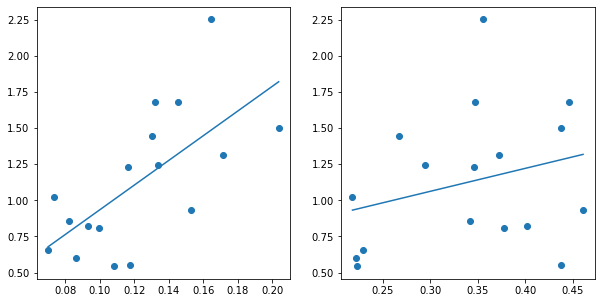

In [93]:
## SKIPPED: Plot egg score as a function of f_norms and all_norms to try to convince readers that females are driving it
fig,(ax1,ax2) = plt.subplots(1,2)

ax1.scatter(rcorrs_f[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)])
fit_line1 = np.poly1d(np.polyfit(rcorrs_f[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)],1))
xs = [np.nanmin(rcorrs_f),np.nanmax(rcorrs_f)]
ax1.plot(xs,fit_line1(xs))

ax2.scatter(rcorrs_a[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)])
fit_line2 = np.poly1d(np.polyfit(rcorrs_a[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)],1))
xs = [np.nanmin(rcorrs_a),np.nanmax(rcorrs_a)]
ax2.plot(xs,fit_line2(xs))

fig.set_size_inches(10,5)
fig.show()

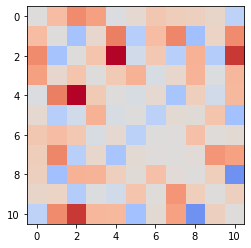

In [101]:
# Skipped: Plot a heatmap (better version above)
a = 11
history_bins,[history_rate_bins,ts,window_indices] = bin_history(sorteds[a],historys[a],metas[a],window=300)
prop_females = get_prop_female(history_bins,metas[a])

n_males = len(prop_females[0])
pwise_corr = np.zeros([n_males,n_males])

for m in range(n_males):
    for n in range(n_males):
        if m==n:
            continue

                
        m1 = prop_females[:,m]
        m2 = prop_females[:,n]
        
        m1 = m1[~np.isnan(m2)]
        m2 = m2[~np.isnan(m2)]
        m2 = m2[~np.isnan(m1)]
        m1 = m1[~np.isnan(m1)]

        if len(m1) <= 1 or len(m2) <= 1:
            continue
        pwise_corr[m,n],_ = spearmanr(m1,m2)
        
fig,ax = plt.subplots()
ax.imshow(pwise_corr,cmap='coolwarm',vmax=.4,vmin=-.4)

if False:
    for l in [2,4,5,10]:
        ax.axvline(l)
        ax.axhline(l)

fig.show()

In [102]:
## Skipped: Print a single male correlation, The figure ended up being pretty useless as a demonstration
print(np.nansum(prop_females,0))

m = 2
n = 3

m1 = prop_females[:,m]
m2 = prop_females[:,n]

m1 = m1[~np.isnan(m2)]
m2 = m2[~np.isnan(m2)]
m2 = m2[~np.isnan(m1)]
m1 = m1[~np.isnan(m1)]
        
print(pearsonr(m1,m2))
print(spearmanr(m1,m2))
fig,ax = plt.subplots()

if True:
    jitter1 = (np.random.rand(len(m1))-.5) * .05
    jitter2 = (np.random.rand(len(m2)) - .5) * .05
else:
    jitter1 = 0
    jitter2 = 0
ax.scatter(1-m2+jitter1,1-m1+jitter2,alpha=.40,color='black')


#fit_line = np.poly1d(np.polyfit(m2,m1,1))
ax.plot([0,1],[0,1],linestyle=':',color='black')
ax.set_xlabel('Male 7 Song Ratio')
ax.set_ylabel('Male 1 Song Ratio')
fig.savefig('./fig1d.png',dpi=300)
fig.show()


[ 77.88293651  52.34123377  27.63333333  93.9272422   32.43333333
  27.9452381   64.61601732  64.95198413 108.83878066  69.63650794
  22.91666667]
(0.11241809022749058, 0.32712031013482584)
SpearmanrResult(correlation=0.09872090571526883, pvalue=0.3898408353936953)


[124.43333333  96.81666667  67.83333333 201.68333333 162.56666667
   2.         173.25         9.5         90.11666667 114.25      ]
(0.15722292832777385, 0.009802435209508194)


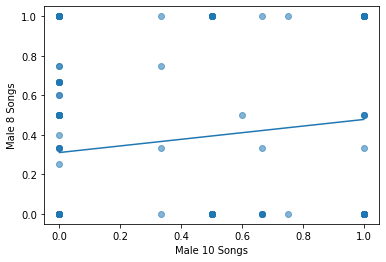

In [103]:
## Skipped: Another attempt at plotting individual males. Also bad. 

a = 14
history_bins,[history_rate_bins,ts,window_indices] = bin_history(sorteds[a],historys[a],metas[a])

fig,ax = plt.subplots()

prop_females = get_prop_female(history_bins,metas[a])
m1 = prop_females[:,0]
m2 = prop_females[:,3]

print(np.nansum(prop_females,0))

if False:
    jitter1 = (np.random.rand(len(m1))-.5) * .05
    jitter2 = (np.random.rand(len(m2)) - .5) * .05
else:
    jitter1 = 0
    jitter2 = 0
ax.scatter(m1+jitter1,m2+jitter2,alpha=.55)

m1 = m1[~np.isnan(m2)]
m2 = m2[~np.isnan(m2)]
m2 = m2[~np.isnan(m1)]
m1 = m1[~np.isnan(m1)]
print(pearsonr(m1,m2))

fit_line = np.poly1d(np.polyfit(m1,m2,1))
ax.plot([0,1],fit_line([0,1]))
ax.set_xlabel('Male 10 Songs')
ax.set_ylabel('Male 8 Songs')
fig.show()

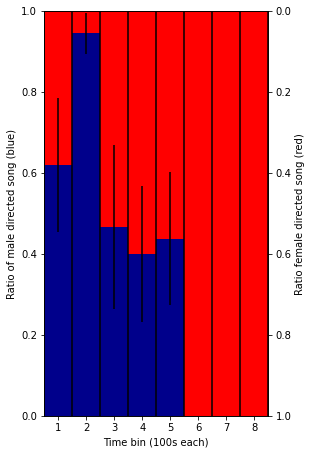

In [29]:
## SKIPPED: Plot a series of bins (with Colors)

fig,ax = plt.subplots()
ax2 = ax.twinx()
prop_males = get_prop_male(history_bins,metas[a])
prop_females = get_prop_female(history_bins,metas[a])

t0,t1=328,335

ax.axvline(t0-.5,color='black')
for t in range(t0,t1+1):
    
    n_sem = np.sum(~np.isnan(prop_females[t]))
    #print(n_sem,prop_males[t],prop_females[t])
    if False:
        ax.bar(t,np.nanmean(prop_males[t]),color='blue',width=1,yerr=np.nanstd(prop_males[t])/np.sqrt(n_sem))
    else: # Fill in undirected song as male song
        ax.bar(t,1-np.nanmean(prop_females[t]),color='darkblue',width=1,yerr=np.nanstd(prop_females[t])/np.sqrt(n_sem))
    ax.bar(t,np.nanmean(prop_females[t]),bottom = 1-np.nanmean(prop_females[t]),color='red',width=1)
    ax.axvline(t+.5,color='black')
    
ax.set_ylim([0,1])
ax.set_xlim([t0-.51,t1+.5])

ax.set_ylabel('Ratio of male directed song (blue)')
ax.set_xticks(np.arange(t0,t1+1))
ax.set_xticklabels(np.arange(1,9))
ax.set_xlabel('Time bin (100s each)')

ax2.set_yticklabels([1.0,0.8,0.6,0.4,0.2,0.0])
ax2.set_ylabel('Ratio female directed song (red)')

fig.tight_layout()
fig.set_size_inches(4,7)

fig.show()
#fig.savefig('./fig1a.png',dpi=300)
    
    

### Prediction


In [109]:
## SKIPPED: The behavior is predictable too, but I was never confident that I was catching 'order' per se
#Use ARIMA to get predictability and plot it
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot as plt

## Build a time series of % female song
a = 12

def get_perc_series(history_bins,meta):
    n_females = meta.n_females

    for h in range(len(history_bins)):
        np.fill_diagonal(history_bins[h],0)

    male_songs = np.sum(history_bins[:,n_females:,n_females:],axis=2)
    female_songs = np.sum(history_bins[:,n_females:,:n_females],axis=2)

    perc_female = female_songs / (male_songs + female_songs)

    perc_series = np.nanmean(perc_female,1)
    perc_series[np.isnan(perc_series)] = 0
    
    perc_series = np.sum(female_songs,1)
    return perc_series

def get_male_series(history_bins,meta):
    n_females = meta.n_females
    female_songs = np.sum(history_bins[:,n_females:,:n_females],axis=2)
    male_songs = np.sum(history_bins[:,n_females:,n_females:],axis=2)
    female_songs = female_songs / (female_songs + male_songs)
    female_songs[np.isnan(female_songs)] = 0 
    return female_songs

arm_scores = []
fig,ax = plt.subplots()
for a in range(len(metas)):
    i = sorted_aves[a]
    history_bins,_ = sliding_bin_history(sorteds[a],historys[a],metas[a],window=60)
    shuffled_bins = shuffle_indy_bins(history_bins)
    
    male_series = get_male_series(history_bins,metas[a])
    
    male_shuffled = get_male_series(shuffled_bins,metas[a])   
   
    xs,ys,ys_shuff = [],[],[]
    for m in range(metas[a].n_males):
        values,counts = np.unique(male_series[:,m],return_counts=True)
        if len(values) < 2:
            #print('singular,skipping')
            continue
        model_fit = ARIMA(male_series[:,m],(2,0,0)).fit()
        r,_ = pearsonr(male_series[:,m],model_fit.predict())
        ys.append(r)
        xs.append(i)
        model_fit = ARIMA(male_shuffled[:,m],(2,0,0)).fit()
        
        r_shuff,_ = pearsonr(male_shuffled[:,m],model_fit.predict())
        ys_shuff.append(r_shuff)
        #print()
    ax.scatter(xs,ys,alpha=.4,label=metas[a].name,color='blue')
    ax.scatter(xs,ys_shuff,color='gray',alpha=.4)
    perc_series = np.mean(male_series,1)
    perc_shuffled = np.mean(male_shuffled,1)
    
    model_fit = ARIMA(perc_series,(2,0,0)).fit()
    print('***',a+1)
    r,p = pearsonr(perc_series,model_fit.predict())
    print('predicted:',r,p)
    ax.scatter(i,r,marker='<',color='black')
    arm_scores.append(r)
    model_fit = ARIMA(perc_shuffled,(2,0,0)).fit()
    print('shuffle predicted:',pearsonr(perc_shuffled,model_fit.predict()))
    print('***\n\n')

ax.axhline(0)
#fig.legend()
fig.show()
arm_scores = np.array(arm_scores)
print(pearsonr(arm_scores[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
for a in range(len(metas)):
    break
    history_bins,_ = sliding_bin_history(sorteds[a],historys[a],metas[a],window=60)
    shuffled_bins = shuffle_indy_bins(history_bins)
    
    perc_series = get_perc_series(history_bins,metas[a])
    
    perc_shuffled = get_perc_series(shuffled_bins,metas[a])
    
    #perc_series = np.diff(perc_series)
    #perc_shuffled = np.diff(perc_shuffled)
    if False:
        fig,ax = plt.subplots()
        ax.scatter(range(len(perc_series)),perc_series,alpha=.1)
        fig.show()
    ## Confirm stationality or transform it
    results = adfuller(perc_series)
    print('p:',results[1])

    if 0:
        plot_pacf(perc_series,lags=10)
        plt.xlabel('Real Lags')
        plt.show()
    
    model_fit = ARIMA(perc_series, (1,0,0)).fit()
    #print(model_fit.summary())
    score1,_ = pearsonr(np.round(model_fit.predict()),perc_series)
    print('order 1 score:',np.mean(score1),_)
    
    model_fit = ARIMA(perc_series, (2,0,0)).fit()
    #print(model_fit.summary())
    #print(model_fit.params)
    err,l1,l2 = model_fit.params
    #print(err)
    score2,_ = pearsonr(np.round(model_fit.predict()),perc_series)
    pred2 = model_fit.predict()
    true2 = perc_series
    print('order 2 score:',np.mean(score2),_)
    
    ## Ideal would be score2=0, improvement is the entire error of 1
    
    results = adfuller(perc_shuffled)
    #print(results[1])
    if 0:
        plot_pacf(perc_shuffled,lags=10)
        plt.xlabel('Shuffled Labs')
        plt.show()
    model_fit = ARIMA(perc_shuffled, (1,0,0)).fit()
    score3,p = pearsonr(model_fit.predict(),perc_shuffled)
    print('shuffled score',score3,p)
        
    #print('non-random improvement:',np.median(score3-score2))
    #print('2nd order improvement:',np.median(score1-score2))
    #print(pearsonr(score1,score3))
    print()
    #print(model_fit.summary())
    #print(model_fit.params[0])

*** 1
predicted: 0.50378389513456 1.2683478514914608e-48
shuffle predicted: (0.05670026675097163, 0.12432719097589656)
***


*** 2
predicted: 0.5252871479464979 1.457548731993892e-59
shuffle predicted: (0.050790494241929884, 0.14544747871624522)
***


*** 3
predicted: 0.44274135064616194 1.1027101594401128e-40
shuffle predicted: (0.04516186020072244, 0.1963830179826801)
***


*** 4
predicted: 0.42228426071109465 1.993094737670796e-38
shuffle predicted: (0.041308432277863724, 0.2267613784279544)
***


*** 5
predicted: 0.5520528780145431 1.3993815986400535e-71
shuffle predicted: (0.033422330781707976, 0.3211851277664203)
***


*** 6
predicted: 0.4213190130926084 3.5144528158116448e-93
shuffle predicted: (0.07423130128597302, 0.0005750634253389524)
***


*** 7
predicted: 0.38355639013258025 1.6559375816114364e-76
shuffle predicted: (0.010472732784732033, 0.6269607341976539)
***


*** 8
predicted: 0.5041179689580799 7.402844534773241e-56
shuffle predicted: (0.027057482364332072, 0.43133594

In [176]:
## SKIPPED Relate r_corr with males vs with females:
#print(exp_sorteds[2][-1])
#exp_rcorrs = []
exp_corrs = []
#rcorrs_m = []
#rcorrs_a = []
#rcorrs_u = []

all_exp_corrs = []



all_exp_rcorrs = []
win = 80
for a in range(len(exp_metas)):
    #rcorr_matrix = ratio_singing(exp_historys[a],exp_metas[a],exp_sorteds[a],window=win,prune=False,receiver='male')
    corr_matrix = correlate_fsongs(exp_historys[a],exp_metas[a],exp_sorteds[a],window=win,prune=False)
    
    #rcorr_matrix_m = ratio_singing(historys[a],metas[a],sorteds[a],window=win,prune=True,receiver='male')
    #rcorr_matrix_a = ratio_singing(historys[a],metas[a],sorteds[a],window=win,prune=True,receiver='all')
    #rcorr_matrix_u = ratio_singing(historys[a],metas[a],sorteds[a],window=win,prune=True,receiver='undirected')
    
    exp_corrs.append(np.nanmean(corr_matrix))
    #exp_rcorrs.append(np.nanmean(rcorr_matrix))
    all_exp_corrs.append(corr_matrix)
    #all_exp_rcorrs.append(rcorr_matrix)
    
    #print(np.median(get_male_activity(exp_historys[a],exp_metas[a],exp_sorteds[a],
    #                                window=win,prune=True,receiver='female')))
    #rcorrs_m.append(np.nanmean(rcorr_matrix_m))
    #rcorrs_a.append(np.nanmean(rcorr_matrix_a))
    #rcorrs_u.append(np.nanmean(rcorr_matrix_u))

#print(exp_rcorrs)
print(exp_corrs)

#rcorrs_m = np.array(rcorrs_m)
#rcorrs_a = np.array(rcorrs_a)
#rcorrs_u = np.array(rcorrs_u)

#print(pearsonr(rcorrs_f[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
#print(pearsonr(rcorrs_m[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
#print(pearsonr(rcorrs_a[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
#print(pearsonr(rcorrs_u[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))

[0.13861991965021506, 0.07829105494504209, 0.07998829572259054, 0.05276068760498779]


In [ ]:
## CRAP BONUS BELOW

In [51]:
## SKIPPED: Calculate the probability a fertile bird laying an egg on any given day, better code above

decade_of_eggs = np.zeros(366)
decade_of_birds = np.zeros(366)

for a in range(len(all_eggs)):
    ## Because I'm going by individual now, including the first 4 aviaries sort of wrecks things
    if a<4:
        continue
    egg_array = all_eggs[a]
    datestamps = all_datestamps[a]
    n_females = np.shape(egg_array)[1]
    days_of_our_lives = [day_of_year(d) for d in datestamps]
    
    ## DECISION: take all eggs
    
    ## DECISION 2: Only take participating females, I will treat the participation seperately
    ## Decision 3: Normalize eggs by how mnay get caught (how do I do that? > Bootstrap it)
    
    participants = np.nansum(all_eggs[a],axis=(0,2))>0

    n_participants = np.sum(participants)-1

    day_counts = np.sum(egg_array[:,participants,:],axis=(1,2))


    if metas[a].cutoff_s is not None:
        cutoff_d = day_of_year(metas[a].cutoff_s)
    else:
        cutoff_d = 365
    for i in range(len(datestamps)):
        
        d = day_of_year(datestamps[i])
        if d > cutoff_d:
            continue
        decade_of_eggs[d] += day_counts[i]
        decade_of_birds[d] += n_participants

## So now we have the probability of an active bird laying an egg on any given day. Good. 

probability_of_egg = np.divide(decade_of_eggs,decade_of_birds)
probability_of_egg = savgol_filter(probability_of_egg,s_win,s_ord)

expected_eggs = probability_of_egg * decade_of_birds
rough_std_eggs = expected_eggs*(1-probability_of_egg)

fig,(ax,ax1) = plt.subplots(2)
ax.plot(probability_of_egg)
ax1.plot(expected_eggs)
ax1.fill_between(np.arange(len(expected_eggs)),expected_eggs+rough_std_eggs,expected_eggs-rough_std_eggs,
                color='gray',alpha=.5)

fig.show()

In [71]:
## Skipped: get male states, another cool way that doesn't adequately control for song rates
def get_male_states(history_bins, meta, threeD = True):
    if threeD:
        n_states = 3
    else:
        n_states = 2
    male_states = np.zeros([len(history_bins),meta.n_males,n_states])

    n_males,n_females = meta.n_males,meta.n_females
    for b in range(len(history_bins)):
        for m in range(n_males):
            m_songs = np.sum(history_bins[b,m + n_females,n_females:])
            f_songs = np.sum(history_bins[b,m+n_females,:n_females])
            u_songs = history_bins[b,m + n_females,m+n_females]
            m_songs = m_songs - u_songs
            if f_songs > 0:
                m_state = [0,1,0] #[0,1] #2d is easier to visualize, but 3d seems better
            elif m_songs > 0:
                m_state = [1,0,0] #[1,0]
            elif u_songs > 0:
                m_state = [0,0,1] #[.7,.7]
            else:
                m_state = [0,0,0]
            if not threeD:
                if m_state == [0,0,1]:
                    m_state = [.7,.7]
                else:
                    m_state = m_state[:2]
            #print(m_state)
            male_states[b,m] = m_state   
    return male_states

In [73]:
## SKIPPED Calculate cohesion at the level of individual males (and by time).  

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

import operator as op
from functools import reduce

def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom  # or / in Python 2

cohesion_by_males = []
random_cohesion_by_males = []
activity_by_males = []


## Select which subset of songs to use
c_set = True

a_i = slice(0,None)
c_i = slice(0,None)

a_ax = (0,2) ## If a_i has more than 1 bin, make this (0,2), otherwise it's 0

for a in range(len(metas)):
    #print(a)
    history_bins,[history_rate_bins,ts,window_indices]= bin_history(sorteds[a],historys[a],metas[a],window=100)
    shuffled_bins = shuffle_indy_bins(history_bins)

    male_states = get_male_states(history_bins,metas[a],threeD=True)
    shuffled_states = get_male_states(shuffled_bins,metas[a],threeD=True)
    n_males = male_states.shape[1]
    ## Really should have just started with the function, but here we are
    
    male_states_binary = np.sum(male_states,axis=2) ## Combining them into just song
    activity_by_males.append(np.sum(male_states[:,:,a_i],axis=a_ax) / len(male_states)) #Calculate overall activity for each male

    #Original approach got more and more complicated
    cohesion_matrix = np.zeros([male_states.shape[0],n_males,n_males])
    shuffled_matrix = np.zeros_like(cohesion_matrix)
    
    cohesion_matrix_sttc = np.zeros([male_states.shape[0],n_males,n_males])
    shuffled_matrix_sttc = np.zeros([male_states.shape[0],n_males,n_males])
    
    #male_states_binary = np.sum(male_states,axis=2) ## Combining them into just song
    #activity_by_males.append(np.sum(male_states_binary,0) / len(male_states)) #Calculate overall activity for each male
    shuffle_states_binary = np.sum(shuffled_states,axis=2)
    #print(cohesion_matrix.shape)

    agree_matrix = np.zeros([len(male_states),3,n_males,n_males])
    
    for i in range(len(male_states)):
        ## NOTE: Calculate this properly, P and the normalization. 
        if True: ## Grab just a subset of songs
            if not c_set:
                bin_agreement = pdist(np.reshape(male_states[i,:,c_i],[-1,1]),metric = np.dot)
                shuff_agreement = pdist(np.reshape(shuffled_states[i,:,c_i],[-1,1]),metric = np.dot)
            else:
                bin_agreement = pdist(male_states[i,:,c_i],metric = np.dot)
                shuff_agreement = pdist(shuffled_states[i,:,c_i],metric = np.dot)
                
        else:
            bin_agreement = pdist(male_states[i],metric = np.dot)
            shuff_agreement = pdist(shuffled_states[i],metric = np.dot)
        #test_dots[i] = bin_agreement
        day_cohesion = squareform(bin_agreement)
        #day_cohesion[np.tril_indices_from(day_cohesion)] = 0
        cohesion_matrix[i] = day_cohesion
        shuffled_matrix[i] = squareform(shuff_agreement)

        for s in range(3):
            bin_agreement_s = pdist(np.reshape(male_states[i,:,s],[-1,1]),metric=np.dot)
            agree_matrix[i,s] = squareform(bin_agreement_s) ## This is the pairwise agreement in this bin

    """
    T_matrix_all = np.mean(male_states,axis=0)
    sum_matrix_all = np.sum(male_states,axis=0)

    agree_matrix = agree_matrix.sum(0) ## This is the count of pairwise agreements
    sttc_matrix = np.zeros([n_males,n_males,3])
    for s in range(3):
        P_matrix_s = agree_matrix[s] / sum_matrix_all[:,s][:,None] ## Needs to divide each row by the value

        ## This row is doing a lot of heavy lifting: 
        # I transpose the matrix so that I'm subracting each column, then divide elementwise by the normalization
        # Which is similarly transposed so that I'm multiplying by each column. This should work...
        sttc_matrix_s = (np.transpose(P_matrix_s) - T_matrix_all[:,s][:,None]) / (1-np.transpose(P_matrix)*T_matrix_all[:,s][:,None]) 
        sttc_matrix_s = np.transpose(sttc_matrix_s)
        sttc_matrix_s_mean = 1/2 * (sttc_matrix_s + np.transpose(sttc_matrix_s))
        sttc_matrix[:,:,s] = sttc_matrix_s
    """
    
    #sttc_matrix = get_sttc(male_states)
    #shuffled_sttc = get_sttc(shuffled_states) 
    
    if False:
        male_trendiness = np.nansum(sttc_matrix[:,:,0],axis=(1)) # This is the mean cohesion for each male (across all 3 states)
        shuffled_trendiness = np.nansum(shuffled_sttc[:,:,0],axis=(1))
    else:
        male_trendiness = np.mean(cohesion_matrix,axis=(0,2))
        male_trendiness = np.sum(cohesion_matrix,axis=(0,2)) / np.sum(male_states_binary,axis=0) / n_males
        shuffled_trendiness = np.mean(shuffled_matrix,axis=(0,2))
        shuffled_trendiness = np.sum(shuffled_matrix,axis=(0,2)) / np.sum(shuffle_states_binary,axis=0) / n_males

    
    #print(np.sum(np.isnan(male_trendiness)))
    male_trendiness[np.isnan(male_trendiness)] = 0 # There are only a couple males that this applies t
    cohesion_by_males.append(male_trendiness)

    shuffled_trendiness[np.isnan(shuffled_trendiness)] = 0 ## This is a choice! But I think it's right
    random_cohesion_by_males.append(shuffled_trendiness)
    #print(male_trendiness)

    if False:
        fig,(ax,ax2) = plt.subplots(2)
        ax.imshow(np.nanmean(cohesion_matrix,axis=0))
        ax2.imshow(male_states[10],aspect='auto')

    #print(np.dot(male_states[0,0],male_states[0,1]))

    if False:
        with plt.xkcd():
            fig,(ax,ax1) = plt.subplots(2)
            ax.plot(np.mean(test_matrix,axis=(0,2)))
            ax.fill_between(range(13),np.mean(test_matrix,axis=(0,2)) + np.std(test_matrix,axis=(0,2))/np.sqrt(740),np.mean(test_matrix,axis=(0,2)) - np.std(test_matrix,axis=(0,2))/np.sqrt(740))

            ax1.plot(np.mean(test_matrix,axis=(1,2)))
            fig.show()
print('Done')

Done


In [75]:
## SKIPPED: Count up each bird's egg production and expected egg production, build dfs for males and females
## Old approach, I didn't like it, relied on iffy individual metrics

all_females = []

columns_f = ['Bird','Pairbond','PairbondID','MateCohesion','RandomCohesion','MateActivity','MateSongs','Active','EggCount','EggScore','Aviary','AviaryCount',
                            'AviaryScore','Year','Days']

columns_m = ['Bird','Cohesion','RandomCohesion','nPairbonds','PairbondEggs','EggPerBond','MaxBond','Songs','Activity','Aviary','AviaryScore','Year','Days']

female_df = pd.DataFrame(columns=columns_f)
male_df = pd.DataFrame(columns=columns_m)

iterations = 10
fancy_egg_scores = []

##all_corrs and all_shuffle_corrs are defined down below, I'll organize this code eventually..


for a in range(len(all_eggs)):
    ## These are all arranged (daysxfemalesxegg_type)
    egg_array = all_eggs[a]
    simple_array = np.nansum(all_eggs[a],axis=2)
    corrected_array = np.zeros_like(simple_array)
    female_array = np.zeros(egg_array.shape[1]) # An array of the females, ...not by day?
    expected_female_array = np.zeros([egg_array.shape[0],egg_array.shape[1]])
    
    participants = np.nansum(all_eggs[a],axis=(0,2))>0
    n_participants = np.sum(participants)-1
        
    participants[-1] = 0 # Here, I need to use this list to allocate extra eggs
    
    datestamps = all_datestamps[a]
    
    overall_f_ratio = np.nansum(egg_array,axis=(0,2))
    #print(overall_f_ratio,np.nansum(overall_f_ratio[participants]))
    overall_f_ratio = overall_f_ratio / np.nansum(overall_f_ratio[participants])
    
    if metas[a].cutoff_s is not None:
        cutoff_d = day_of_year(metas[a].cutoff_s)
    else:
        cutoff_d = 365

    for i in range(len(datestamps)):
        
        d = day_of_year(datestamps[i])
        if d > cutoff_d:
            continue
        expected_female_array[i,participants] = probability_of_egg[d]
        if False: ## Optionally add missed eggs
            ## This is nice, but it does add some randomness, which can effect results below. 
            #print(probability_of_egg[d])
            ## Correct for the missed eggs:
            n_unknown = np.sum(all_eggs[a][i,-1,:])

            possible_birds = simple_array[i] != 1
            #print(participants)
            ## There are missed eggs, in order to account for them, I divide them up randomly
            ## This is based on existing ratios, and I bootstrap it in order to get good averages
            ## This prevents noise from years the cameras worked less well (at least it tries to do that)
            corrected_iterations = np.zeros([iterations,simple_array.shape[1]])

            for i_ in range(iterations):
                remaining_eggs = n_unknown
                random_order = np.random.permutation(np.arange(len(possible_birds))[participants])
                corrected_iterations[i_] = np.array(simple_array[i])
                while remaining_eggs > 0:
                    for j in random_order:
                        if remaining_eggs == 0:
                            break
                        #print('j',j,overall_f_ratio[j])
                        if np.random.random() <= overall_f_ratio[j]:
                            #print('correcting',j)
                            corrected_iterations[i_,j] += 1
                            corrected_iterations[i_,-1] -= 1
                            remaining_eggs -= 1

                    if 0 not in corrected_iterations[i_,participants]:
                        remaining_eggs = 0
            corrected_array[i] = np.nanmean(corrected_iterations,0) 
        else:
            corrected_array[i] = simple_array[i]
    #print(a,np.nansum(corrected_array),np.nansum(expected_female_array))
    #print(np.nansum(corrected_array,axis=0))
    rough_mean = np.nansum(np.nansum(expected_female_array,axis=0))
    rough_std = np.nansum(np.nansum(expected_female_array * (1-expected_female_array),axis=0))
    #print(rough_mean,rough_std)
    fancy_egg_scores.append((np.nansum(corrected_array) - rough_mean) / rough_std)
    fancy_female_scores = np.nansum((corrected_array - rough_mean) / rough_std,0)
    
    ## Get pairbonds and then Fill in information for each female
    print(metas[a].name)
    summed_investment = historys[a].sum(0)[metas[a].n_females:,:metas[a].n_females]
    active_males = np.sum(summed_investment,axis=1) > 20
    ## Get the top singer
    pairbonds = np.nanargmax(np.transpose(summed_investment),axis=1)

    unique_pairbonds = np.array(pairbonds)
    p_ids,counts = np.unique(pairbonds,return_counts =True)
    scoundrels = p_ids[counts > 1]
    top_pairbond = {}
    for s in scoundrels:
        top_f = np.argmax(summed_investment[s])
        top_pairbond[s] = top_f

    ## Check if the top singer actually sang a reasonable amount
    good_bonds = np.max(np.transpose(summed_investment),axis=1) > 20

    ## Calculate song ratios to check if the pairbond actually sings the majority of song
    song_ratios = np.divide(np.transpose(summed_investment),np.sum(summed_investment,axis=0)[:,np.newaxis])
    true_bonds = np.max(song_ratios,axis=1) > .6
    mate_eggs = [0] * metas[a].n_males
    mate_counts = [0] * metas[a].n_males
    mate_norm_eggs = [0] * metas[a].n_males
    max_eggs = [[0] for m in range(metas[a].n_males)]
    #print(historys[a].shape,metas[a].n_males,metas[a].n_females)
    for f in range(egg_array.shape[1]-1):
        bird = metas[a].f_ids[f]
        pairbond_id = pairbonds[f]
        
        ## Checking how much it's driven by duplicate pairbonds
        if False:
            if pairbond_id in scoundrels:
                if top_pairbond[pairbond_id] != f:
                    continue
        if good_bonds[f] and true_bonds[f]:
            pairbond = True
        else:
            pairbond = False
        #pairbond_score = 0 
        #print(pairbond_id,a)
        pairbond_score = cohesion_by_males[a][pairbond_id]
        
        random_score = random_cohesion_by_males[a][pairbond_id]
        if False:
            pairbond_score = np.nanmean(all_corrs[a][pairbond_id]) #,active_males])
            random_score = np.nanmean(all_shuffle_corrs[a][pairbond_id])#,active_males])
        elif False:
            pairbond_score = np.nanmean(all_rcorrs[a][pairbond_id])
            
        pairbond_activity = activity_by_males[a][pairbond_id]
        
        egg_count = np.nansum(corrected_array[:,f])
        if egg_count > 0:
            active = 1
        else:
            active = 0

        egg_score = fancy_female_scores[f]
        
        pairbond_songs = np.nansum(historys[a][:,metas[a].n_females+pairbond_id])
        
        pb_female_songs = np.sum(summed_investment[pairbond_id])
        if pairbond:# or not pairbond:
            mate_eggs[pairbond_id] += egg_count
            mate_counts[pairbond_id] += 1
            max_eggs[pairbond_id].append(egg_count)
        aviary = a
        aviary_count = np.nansum(corrected_array)
        aviary_score = fancy_egg_scores[-1]
        year = int(metas[a].name[-4:])
        n_days = len(simple_array)
        #print(columns_f)
        #print(bird,pairbond,pairbond_score,egg_count,egg_score,
        #                                    aviary,aviary_count,aviary_score,year,n_days)
        female_df = female_df.append(dict(zip(columns_f,[bird,pairbond,pairbond_id,pairbond_score,random_score,pairbond_activity,pairbond_songs,
                                        active,egg_count,egg_score,aviary,aviary_count,aviary_score,year,n_days])),ignore_index=True)
    
    for m in range(metas[a].n_males):
        bird = metas[a].m_ids[m]
        bird_score = cohesion_by_males[a][m]
        
        n_songs = np.sum(summed_investment[m])
        activity = activity_by_males[a][m]
        random_score = random_cohesion_by_males[a][m]

        if True:
            bird_score = np.nanmean(all_corrs[a][m,active_males])
            random_score = np.nanmean(all_shuffle_corrs[a][m,active_males])
        elif False:
            bird_score = np.nanmean(all_rcorrs[a][m])
        if mate_counts[m] > 0:
            mate_norm_eggs[m] = mate_eggs[m]/mate_counts[m]
        max_eggs[m] = max(max_eggs[m])

        male_df = male_df.append(dict(zip(columns_m,
                    [bird,bird_score,random_score,mate_counts[m],mate_eggs[m],mate_norm_eggs[m],max_eggs[m],n_songs,activity,aviary,aviary_score,year,n_days])),ignore_index=True)
    #print('')
    
#print(len(clean_norm),len(fancy_egg_scores))
"""
print(pearsonr(clean_norm[4:],clean_fancy_egg_scores[4:]))
print(pearsonr(clean_c[4:],clean_fancy_egg_scores[4:]))
print(pearsonr(clean_norm[4:],n_participant_list[4:]))
print(n_participant_list)"""

#female_df.to_csv('./Female_eggs.csv',index=False)
#print(female_df)
pass

PH1-2006
PH2-2006


IndexError: boolean index did not match indexed array along dimension 1; dimension is 12 but corresponding boolean dimension is 14

          Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  EggCount 
No. Observations:  74       Method:              REML     
No. Groups:        11       Scale:               18.5009  
Min. group size:   4        Log-Likelihood:      -204.9988
Max. group size:   10       Converged:           Yes      
Mean group size:   6.7                                    
----------------------------------------------------------
               Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
----------------------------------------------------------
Intercept       4.849    2.679  1.810 0.070  -0.401 10.100
RandomCohesion 31.869   22.385  1.424 0.155 -12.004 75.743
MateActivity   -3.538    4.175 -0.848 0.397 -11.721  4.644
Group Var       0.000    0.525                            

(0.18592643471508263, 0.11273169587574261)
0 sucks
1 sucks
2 sucks
3 sucks
4 sucks
7 sucks
12 sucks
14 sucks


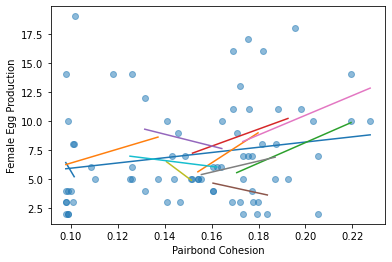

In [226]:
## Run mixed effect models to evaluate the effect on individual success

## try this using all_rcorr
import statsmodels.api as sm
import statsmodels.formula.api as smf

good_df = female_df[female_df['Aviary'] >= 4]

if True:
    good_df = good_df[good_df['Aviary'] != 4]
    good_df = good_df[good_df['Aviary'] != 7]
    #good_df = good_df[good_df['Aviary'] != 9]
    #good_df = good_df[good_df['Aviary'] != 10]
    good_df = good_df[good_df['Aviary'] != 12]
    good_df = good_df[good_df['Aviary'] != 14]
    
good_df['Active'] = pd.to_numeric(good_df['Active'])
good_df['MateActivity'] = pd.to_numeric(good_df['MateActivity'])

## The strongest effect is across all 'pairbonds' and with only active egg layers, but it's true regardless
if True:
    #good_df = good_df[good_df['Pairbond'] == True]
    #good_df = good_df[good_df['EggCount'] < 15]
    good_df = good_df[good_df['EggCount'] > 1]
    pass
#print(good_df)

md = smf.mixedlm("EggCount ~ RandomCohesion + MateActivity",data=good_df,groups=good_df["Aviary"])
mdf_partial = md.fit()    
print(mdf_partial.summary())

fig,ax = plt.subplots()
ys = good_df['EggCount']
xs = good_df['MateCohesion']
print(pearsonr(xs,ys))


ax.scatter(xs,ys,alpha=.5)
fit_line = np.poly1d(np.polyfit(xs,ys,1))
ax.plot([min(xs),max(xs)],fit_line([min(xs),max(xs)]))
ax.set_xlabel('Pairbond Cohesion')
ax.set_ylabel('Female Egg Production')
for a in range(len(metas)):
    sub_df = good_df[good_df['Aviary'] == a]
    xs = sub_df['MateCohesion']
    ys = sub_df['EggCount']
    if len(xs)< 1:
        print(a,'sucks')
        continue
    fit_line = np.poly1d(np.polyfit(xs,ys,1))
    ax.plot([min(xs),max(xs)],fit_line([min(xs),max(xs)]))



fig.show()

(0.8983151883447951, 1.7757792253108536e-07)
(0.4540204699949468, 0.06714800928991028)


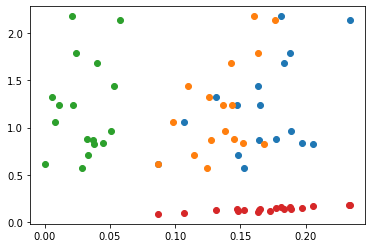

In [227]:
## Calculate cohesion (based on above values) and check correlations

## Currently my shuffling sucks, so don't read too much into this. 
aviary_cohesion = np.zeros(len(cohesion_by_males))
shuffled_cohesion = np.zeros_like(aviary_cohesion)
for a in range(len(cohesion_by_males)):
    aviary_cohesion[a] = np.nanmean(cohesion_by_males[a])
    shuffled_cohesion[a] = np.nanmean(random_cohesion_by_males[a])
#print(len(egg_scores),egg_scores)

fig,ax = plt.subplots()
egg_scores = np.array(egg_scores)
#print(aviary_cohesion)
ax.scatter(aviary_cohesion,egg_scores)
ax.scatter(shuffled_cohesion,egg_scores)
ax.scatter(aviary_cohesion[~np.isnan(egg_scores)]-shuffled_cohesion[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)])
ax.scatter(aviary_cohesion,shuffled_cohesion)

print(pearsonr(aviary_cohesion,shuffled_cohesion))
print(pearsonr(aviary_cohesion[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
#print(pearsonr(aviary_cohesion[~np.isnan(egg_scores)]-shuffled_cohesion[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
#print(pearsonr(shuffled_cohesion[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))

(0.43573992735378686, 1.3465902208436836e-09)


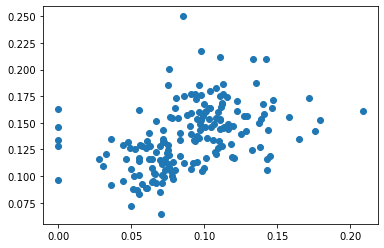

In [228]:
sub_df = male_df.dropna(subset=['Cohesion','RandomCohesion'])
print(pearsonr(sub_df['Cohesion'],sub_df['RandomCohesion']))
#sub_df = sube_df[male_df['Cohesion'] != 0]
#print(pearsonr(sub_df['Cohesion'],sub_df['RandomCohesion']))

fig,ax = plt.subplots()
ax.scatter(sub_df['Cohesion'],sub_df['RandomCohesion'])
fig.show()

In [229]:
unique_birds,counts = np.unique(good_df['Bird'],return_counts=True)
return_birds = unique_birds[counts>1]
print(return_birds)
return_df = good_df[good_df['Bird'].isin(return_birds)]

md = smf.mixedlm("EggCount ~ AviaryScore",data=return_df,groups=return_df["Bird"])
md = md.fit()
print(md.summary())
"""
for b in return_birds:
    sub_df = return_df[return_df['Bird'] == b]
    print(pearsonr(sub_df['EggScore'],sub_df['AviaryScore']))"""

['FBNM' 'FGOG' 'FGYD' 'FLD' 'FLOY' 'FNM' 'FOD' 'FOLW' 'FOWD' 'FPOD' 'FR2G'
 'FRLR' 'FWN' 'FYBL']
         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: EggCount
No. Observations:  31      Method:             REML    
No. Groups:        14      Scale:              6.8009  
Min. group size:   2       Log-Likelihood:     -78.0292
Max. group size:   3       Converged:          Yes     
Mean group size:   2.2                                 
-------------------------------------------------------
            Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-------------------------------------------------------
Intercept    7.716    0.945  8.164 0.000   5.864  9.568
AviaryScore -4.624    2.986 -1.549 0.121 -10.476  1.228
Group Var    6.716    2.026                            



"\nfor b in return_birds:\n    sub_df = return_df[return_df['Bird'] == b]\n    print(pearsonr(sub_df['EggScore'],sub_df['AviaryScore']))"

## This raises a question: 
I've said that %song to females predicts cohesion, sort of implying that it's the coordination of female directed song. 
But above it seems more likely that the coordination of male directed song accounts for the effect. Is that just because the sample size is going to be better? 

### To wit: What is the relationship between male directed and female directed songs? 
It seems 
F_song = Total_song - M_song
where there is a slight bias towards only producing M_song or F_song. 

This relationship (see below) isn't represented well by pearson correlation, and results in very low r values, even though the p-values are quite high. 


(736, 17, 17)
(823, 27, 27)
(820, 17, 17)
(858, 29, 29)
(883, 37, 37)
(2148, 23, 23)
(2156, 27, 27)
(848, 35, 35)
(1626, 24, 24)
(785, 16, 16)
(853, 19, 19)
(1739, 28, 28)
(1698, 23, 23)
(1012, 20, 20)
(1639, 23, 23)
(1699, 19, 19)
(1734, 19, 19)
(1293, 32, 32)
(951, 32, 32)


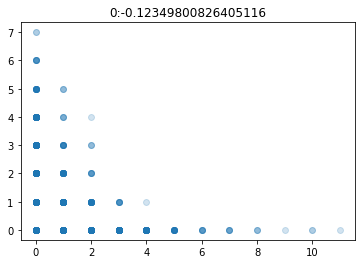

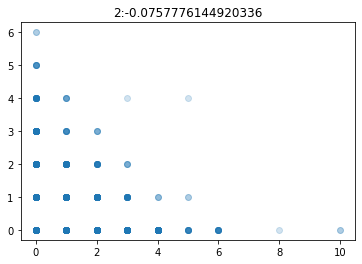

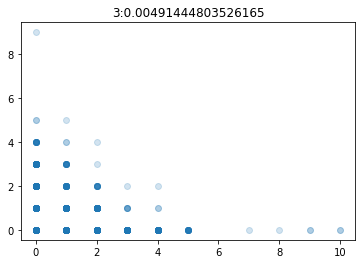

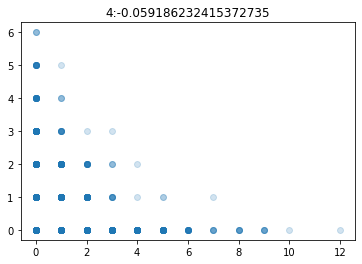

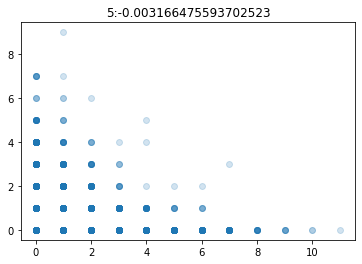

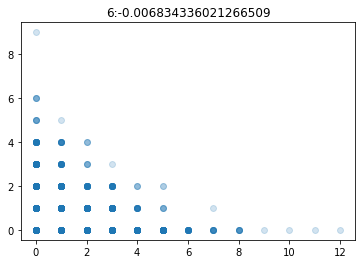

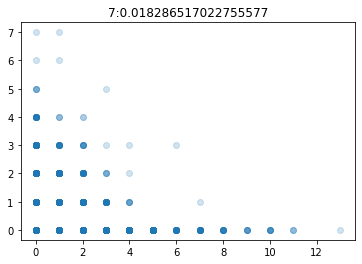

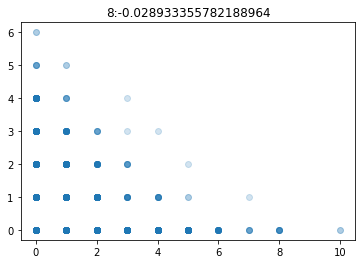

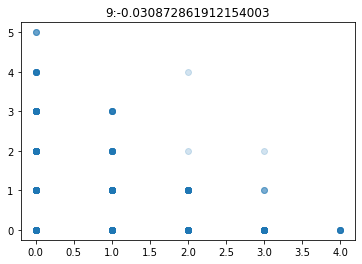

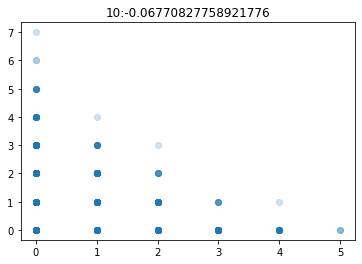

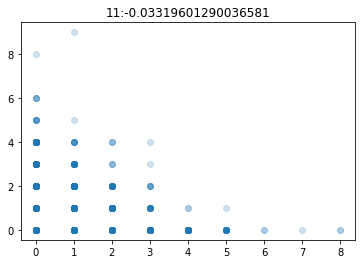

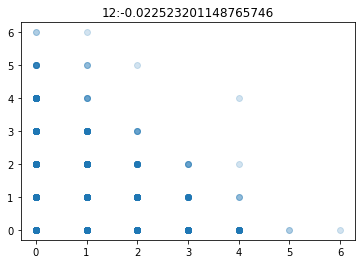

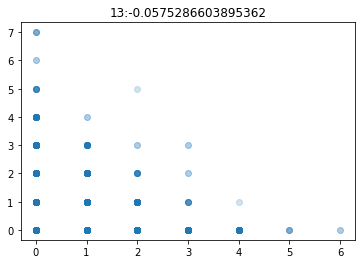

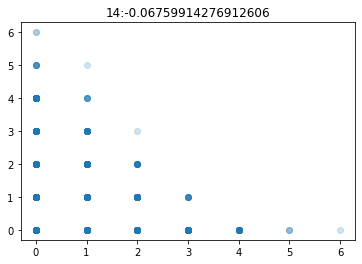

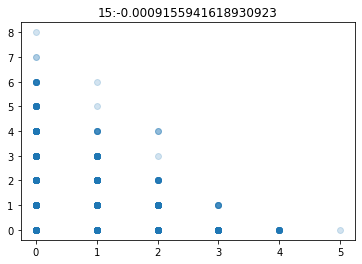

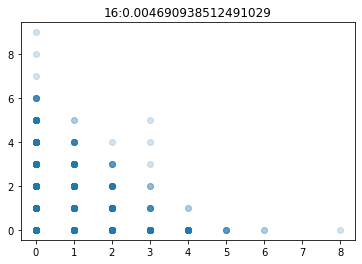

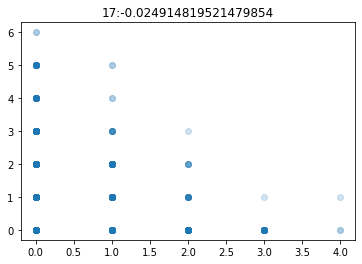

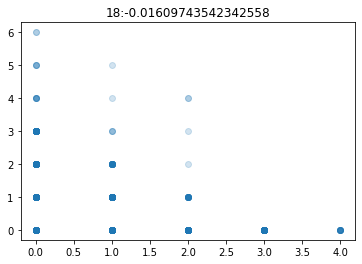

In [230]:
for a in range(len(metas)):
    history_bins,_ = sliding_bin_history(sorteds[a],historys[a],metas[a],window=60)
    
    n_females = metas[a].n_females
    print(history_bins.shape)
    ## Sum of the number of songs sung by each male in each bin to males and females
    male_songs = np.sum(history_bins[:,n_females:,n_females:],axis=2)
    female_songs = np.sum(history_bins[:,n_females:,:n_females],axis=2)
    
    xs = male_songs.flatten()
    ys = female_songs.flatten()
    
    r,p = pearsonr(xs,ys)
    fig,ax = plt.subplots()
    ax.scatter(xs,ys,alpha=.2)
    ax.set_title(str(a) + ':' + str(r))
    fig.show()

(-0.17807804928297077, 0.21598652483908487)


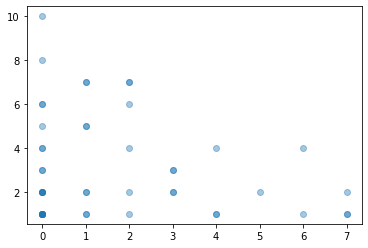

In [231]:
max_s = [np.random.randint(1,11) for i in range(50)]
sins = [np.random.randint(0,max_s[i]) for i in range(50)]
coss = [max_s[i] - sins[i] for i in range(50)]

print(pearsonr(sins,coss))

fig,ax = plt.subplots()
ax.scatter(sins,coss,alpha=.4)

fig.show()

In [232]:
## Check if it's just vice pairbonds driving the averages down

if False: 
    for a in pd.unique(good_df['Aviary']):
        print(a)
        sub_df = good_df[good_df['Aviary'] == a]
        m_ids,counts = np.unique(sub_df['PairbondID'],return_counts=True)
        scoundrels = m_ids[counts > 1]
        for s in scoundrels:
            top_f = np.argmax(sub_df[sub_df['PairbondID']])
            other_f = sub_df[sub_df['PairbondID']]['Bird']
            print(top_f,other_f)

In [233]:
##### fig,ax = plt.subplots()
ax.hist(good_df['MateCohesion'])
fig.show()

In [234]:
good_male_df = male_df[male_df['Aviary'] >= 4]
good_male_df['PairbondEggs'] = pd.to_numeric(good_male_df['PairbondEggs'])
good_male_df['Cohesion'] = pd.to_numeric(good_male_df['Cohesion'])
good_male_df['nPairbonds'] = pd.to_numeric(good_male_df['nPairbonds'])
good_male_df['EggPerBond'] = pd.to_numeric(good_male_df['EggPerBond'])
good_male_df['MaxBond'] = pd.to_numeric(good_male_df['MaxBond'])

print(len(good_male_df))
good_male_df = good_male_df.dropna()
print(len(good_male_df))
#columns_m = ['Bird','Cohesion','nPairbonds','PairbondEggs','EggPerBond','Songs','Activity','Aviary','AviaryScore','Year','Days']

## Exclude the weird 2007 aviaries

if True:
    good_male_df = good_male_df[good_male_df['Aviary'] != 4]
    good_male_df = good_male_df[good_male_df['Aviary'] != 7]
    good_male_df = good_male_df[good_male_df['Aviary'] != 9]
    good_male_df = good_male_df[good_male_df['Aviary'] != 10]

#good_male_df = good_male_df[good_male_df['nPairbonds'] <4]
#good_male_df = good_male_df[good_male_df['PairbondEggs'] > 0]
good_male_df = good_male_df[good_male_df['nPairbonds'] > 0]

print(good_male_df['Cohesion'])
print(np.unique(good_male_df['Aviary'],return_counts=True))
md = smf.mixedlm('nPairbonds ~ RandomCohesion + Activity',data=good_male_df,groups=good_male_df['Aviary'])
#md = smf.mixedlm('PairbondEggs ~ nPairbonds',data=good_male_df,groups=good_male_df['Aviary'])

md = md.fit()
print(md.summary())

143
136
51     0.097403
53     0.096836
54     0.075441
56     0.116327
57     0.113095
         ...   
178    0.052083
179    0.055556
180    0.036232
181    0.055556
182    0.063988
Name: Cohesion, Length: 70, dtype: float64
(array([5, 6, 8, 11, 12, 13, 14, 15, 16, 17, 18], dtype=object), array([ 6,  5,  4,  8,  6,  6,  8,  5,  5,  7, 10]))
           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  nPairbonds
No. Observations:  70       Method:              REML      
No. Groups:        11       Scale:               0.9284    
Min. group size:   4        Log-Likelihood:      -93.3315  
Max. group size:   10       Converged:           Yes       
Mean group size:   6.4                                     
-----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
-----------------------------------------------------------
Intercept        1.350    0.566  2.385 0.017   0.240  2.459
Random

(-0.005045107888206114, 0.9669366557073434)
0 sucks
1 sucks
2 sucks
3 sucks
4 sucks
7 sucks
9 sucks
10 sucks


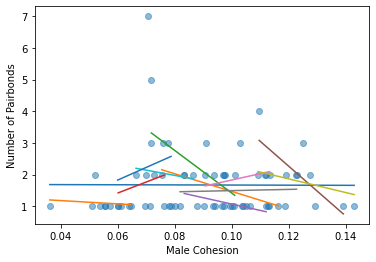

In [235]:
fig,ax= plt.subplots()
xs = good_male_df['Cohesion']
ys = good_male_df['nPairbonds']
print(pearsonr(xs,ys))

ax.scatter(xs,ys,alpha=.5)
fit_line = np.poly1d(np.polyfit(xs,ys,1))
ax.plot([min(xs),max(xs)],fit_line([min(xs),max(xs)]))
for a in range(len(metas)):
    sub_df = good_male_df[good_male_df['Aviary'] == a]
    xs = sub_df['Cohesion']
    ys = sub_df['nPairbonds']
    if len(xs)< 1:
        print(a,'sucks')
        continue
    fit_line = np.poly1d(np.polyfit(xs,ys,1))
    ax.plot([min(xs),max(xs)],fit_line([min(xs),max(xs)]))

ax.set_xlabel('Male Cohesion')
ax.set_ylabel('Number of Pairbonds')
fig.show()

In [236]:
unique_males,counts = np.unique(good_male_df['Bird'],return_counts=True)
return_males = unique_males[counts>1]
print(return_males)
return_male_df = good_male_df[good_male_df['Bird'].isin(return_males)]

md = smf.mixedlm("EggPerBond ~ Cohesion+Activity",data=return_male_df,groups=return_male_df["Bird"])
md = md.fit()
print(md.summary())

['M2M' 'MB2M' 'MBOD' 'MBWD' 'MDBR' 'MDGR' 'MDMG' 'MGRG' 'MLY' 'MMG' 'MND'
 'MO' 'MRBG' 'MRLW' 'MW2R' 'MWG' 'MWMG' 'MYLO']
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: EggPerBond
No. Observations: 43      Method:             REML      
No. Groups:       18      Scale:              14.1887   
Min. group size:  2       Log-Likelihood:     -110.6809 
Max. group size:  4       Converged:          Yes       
Mean group size:  2.4                                   
--------------------------------------------------------
             Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------
Intercept     3.648    4.317  0.845 0.398  -4.813 12.110
Cohesion    -11.172   30.917 -0.361 0.718 -71.767 49.424
Activity      5.154    5.189  0.993 0.321  -5.016 15.324
Group Var     0.985    0.875                            



## We're getting confounds with Activity, does activity per se predict egg production? 

### Oh yeah. 

So, what does that actually mean? 
Activity here means essentially the mean number of bins a male sings to a female. This is going to combine
a) Male activity
b) Male Participation
c) Male attention to females
d) Hopefully there's no bleed through from seasonality...

Male activity of which songs? 

1. Mean male:male activity predicts egg production quite well. 
2. Overall activity (including undirected) not as well. 
3. Male+Female activity even better
4. Female activity best. This is much stronger than cohesion, by the way. 

Interestingly, while the effect of female activity is very strong, the effect of female cohesion is not so good. I guess this could be an artifact of it just not getting enough values. Overall song works best here. Such a bummer that the %song disappeared. I wish I knew what happened there

(0.4882493403904421, 0.046759534093457115)
(0.6564257982575648, 0.004208710626223802)


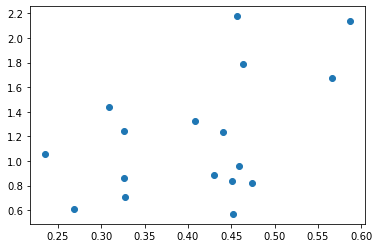

In [237]:
mean_activity = np.array([np.mean(a) for a in activity_by_males])
fig,ax = plt.subplots()
ax.scatter(mean_activity,egg_scores)
fig.show()

egg_scores = np.array(egg_scores)
print(pearsonr(mean_activity[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
print(pearsonr(rcorrs_f[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))

[0.33333333 0.71428571 0.66666667 0.83333333 0.5        0.5
 0.4        0.75       0.5        0.4        0.5        0.875
 0.33333333 0.33333333 0.625      0.4        0.2        0.57142857
 0.9       ]
monogamy vs eggs (-0.3119146936059453, 0.22292222435296272)

monogomy vs optimal monogoamy (0.04483141723667229, 0.8553944792632284)
monogamy vs f_participation (-0.38803348720502423, 0.10066530597136061)
f_participation vs egg scores (0.49143967656996695, 0.045129938508599754)
m_participation vs egg scores (0.3986972579052896, 0.1129174166704813)
m_participation vs f_participation (0.588987067333109, 0.007969534503510603)
female participation vs cohesion
(0.17248376138059224, 0.4801149522508264)
(0.1683191977068598, 0.49093849114182075)
male participation vs cohesion
(0.1505297173621579, 0.5384753591804624)
(0.3885752722877928, 0.10014976978098193)
Monogom vs cohesion:
(-0.5387181994368693, 0.017320435280873483)
(-0.4533770083625239, 0.05123144719274179)


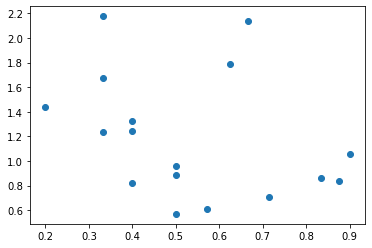

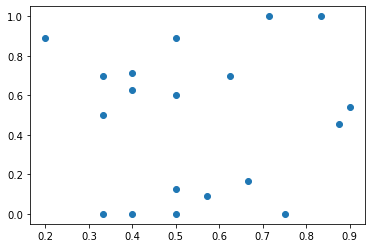

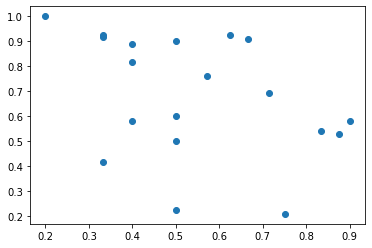

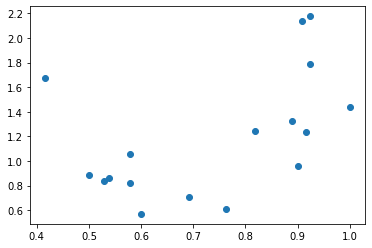

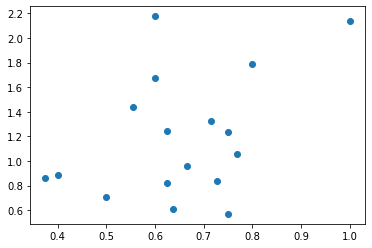

In [238]:
## What is the relationship beween monogamy and cohesion? 

# How do we measure monogamy? 

## What about female participation in courtship? 

## Takes summed investment, counts number of pairbonds
def optimal_pairing(f_songs):
    n_males,n_females = f_songs.shape
    bond_count = np.zeros(n_males)
    for f in range(n_females):
        m = f % n_males
        bond_count[m] += 1
        
    n_bonds = np.sum(bond_count)
    n_mono = np.sum(bond_count == 1)
    n_bonding_males = np.sum(bond_count >= 1)
    male_ratio = n_mono/n_males
    bond_ratio = n_mono/n_bonding_males

    return male_ratio, bond_ratio 

## Get the monogamy scores, defines as 
# male_ratio: the proportion of males in monogomous pairings
# bond_ratio: the proportion of bonding_males in monogomous pairings (so it corrects for male participation)
def monogamy_score(f_songs):
    n_males,n_females = f_songs.shape
    bond_count,_ = count_pairbonds(f_songs)
    
    n_bonds = np.sum(bond_count)
    n_promiscuous = np.sum(bond_count > 1)
    n_mono = np.sum(bond_count == 1)
    n_bonding_males = np.sum(bond_count >= 1)
    #print(n_promiscuous/n_bonding_males)
    male_ratio = n_mono/n_males
    bond_ratio = n_mono/n_bonding_males
    return male_ratio,bond_ratio

## Get the ratio of females who have a pairbond
def participation_score(f_songs):
    n_males,n_females = f_songs.shape
    bond_count,bond_status = count_pairbonds(f_songs)
    f_score = np.mean(bond_status)
    m_score = np.mean(bond_count >= 1)
    return m_score,f_score
    

def count_pairbonds(f_songs):
    n_males,n_females = f_songs.shape
    bond_count = np.zeros(n_males)
    bond_status = np.zeros(n_females)

    for f in range(n_females):
        top_singer = np.argmax(f_songs[:,f])
        n_songs = f_songs[top_singer,f]
        song_ratio = n_songs / np.sum(f_songs[:,f])
        if n_songs > 20 and song_ratio > .6:
            bond_count[top_singer] += 1
            bond_status[f] = 1
    return bond_count,bond_status
  
def get_pairbonds(f_songs):
    n_males,n_females = f_songs.shape

    bond_list = [[] for m in range(n_males)]
    bond_id = np.zeros(n_females) - 1
    for f in range(n_females):
        top_singer = np.argmax(f_songs[:,f])
        n_songs = f_songs[top_singer,f]
        song_ratio = n_songs / np.sum(f_songs[:,f])
        if n_songs > 20 and song_ratio > .6:
            bond_id[f] = top_singer
            bond_list[top_singer].append(f)
    return bond_list,bond_id
    
mono_ratios_m,mono_ratios_b = [],[]
opt_ratios_b = []
party_scores = []
m_party_scores = []

for a in range(len(metas)):
    n_females = metas[a].n_females
    
    f_songs = np.sum(historys[a][:,n_females:,:n_females],axis=0)
    m,b = monogamy_score(f_songs)
    m_o,b_o = optimal_pairing(f_songs)
    mono_ratios_m.append(m)
    mono_ratios_b.append(b)
    opt_ratios_b.append(b_o)
    m_score,f_score = participation_score(f_songs)
    party_scores.append(f_score)
    m_party_scores.append(m_score)
    
    if False:
        fig,ax = plt.subplots()
        ax.imshow(sort_pairbonds(np.transpose(f_songs)))
        fig.show()

## Check whether egg scores is a function of monogamy (it probably is, but negatively)
fig,ax=plt.subplots()

ax.scatter(mono_ratios_b,egg_scores)

mono_ratios_m = np.array(mono_ratios_b)
print(mono_ratios_m)

fig.show()

print('monogamy vs eggs',pearsonr(mono_ratios_m[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
print()

## Check whether monogamy is a function of optimal pairing (it isn't)
fig,ax= plt.subplots()
ax.scatter(mono_ratios_b,opt_ratios_b)
fig.show()
print('monogomy vs optimal monogoamy',pearsonr(mono_ratios_b,opt_ratios_b))

## Check whether monogamy is a function of female participation (it probably is, negatively)
fig,ax = plt.subplots()
ax.scatter(mono_ratios_b,party_scores)
fig.show()
print('monogamy vs f_participation',pearsonr(mono_ratios_b,party_scores))

## Check whether egg scores is a function of f_particpation (it is)
fig,ax=plt.subplots()

ax.scatter(party_scores,egg_scores)

party_scores = np.array(party_scores)

fig.show()

print('f_participation vs egg scores',pearsonr(party_scores[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))

## Check whether egg scores is a function of m participation ()
m_party_scores = np.array(m_party_scores)
fig,ax = plt.subplots()
ax.scatter(m_party_scores,egg_scores)
fig.show()
print('m_participation vs egg scores',pearsonr(m_party_scores[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))

print('m_participation vs f_participation',pearsonr(party_scores,m_party_scores))
## What about cohesion? That was actually sort of the point, I got distracted

# Reminder f is %f_song, s is...something, r is proportion of bins, a is activity
## Currently I'm not pruning, I'll need to redo this with pruning



## Does f_participation predict cohesion (No, not at all)
print('female participation vs cohesion')
print(pearsonr(party_scores,f_corrs))
print(pearsonr(party_scores,r_corrs))

## Does m_participation predict cohesion? Maybe in the latter metric, definitely not in the former
print('male participation vs cohesion')
print(pearsonr(m_party_scores,f_corrs))
print(pearsonr(m_party_scores,r_corrs))

## Does monogamy predict cohesion (yes, but negatively. Side effect of eggs? probably not, it's stronger)
print('Monogom vs cohesion:')
print(pearsonr(f_corrs,mono_ratios_b))
print(pearsonr(r_corrs,mono_ratios_b))

## Promiscuity predicts egg production

Maybe that's not surprising, if there are more females than males, the only way to get full participation is promiscuity. I need to somehow control for that...unnecessary promiscuity? 

## So! To summarize Again

Fig 1: The group is definitely cohesive and predictable. 
Fig 2: Cohesiveness (but not predictability) predict egg production. This appears to be actually driven by female directed song, as evidences by the % of song (which is confounded by activity, but whatever) 
Fig 3: Female egg production seems to be related to her pairbond cohesion (although this affect is super fragile, and a little finnicky). Males, on the other hand, maximize egg production by maximizing mates, which seems to be related to activity, but if anything negatively correlated with cohesion
---This last point could perhaps be strengthened by using some network metric of cohesion

Finally, Fig 4: 
## Can we experimentally demonstrate cohesion? 
### Enter more data: 

2 years of matched aviaries, does a shift in cohesion track to a shift in egg production? 

PH1-2002 31539 ['M3O' 'MD' 'MDLO' 'MDOG' 'MDON' 'MDYG' 'ML' 'MLBL' 'MNW' 'MNWL' 'MRYR'
 'MWD' 'MY' 'MYRD']
PH2-2002 30298 ['M2MR' 'MGBR' 'MGOL' 'MLMB' 'MLMN' 'MLOY' 'MR2O' 'MROD' 'MROR' 'MRY'
 'MWYR' 'MY2O' 'MYLW' 'MYRM']
PH1-2003 12683 ['M3O' 'MBRD' 'MBRW' 'MDLO' 'MDOG' 'MDRM' 'MDYG' 'MG2L' 'MGDO' 'ML' 'MLRM'
 'MNWL' 'MOWN' 'MRYR']
PH2-2003 13610 ['MDON' 'MGOL' 'MLBL' 'MLMN' 'MLOY' 'MNW' 'MR2O' 'MROD' 'MROR' 'MWD'
 'MWYR' 'MY' 'MYRD']


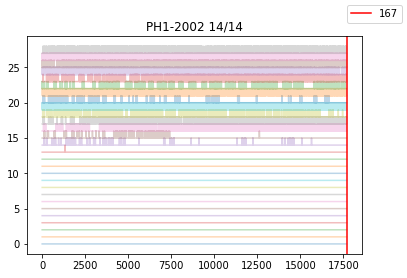

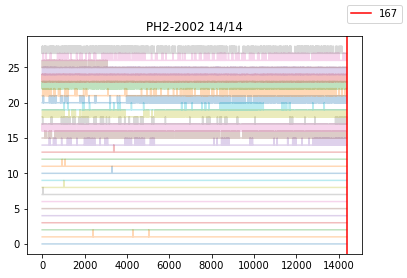

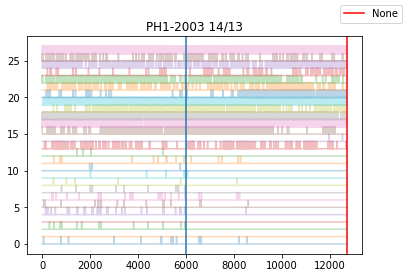

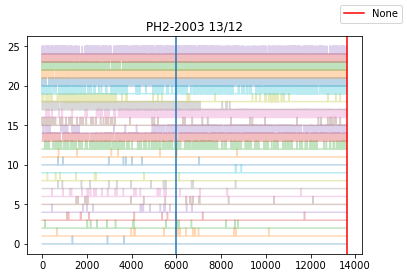

In [241]:
## First, get an overview of the aviaries: 

for a in range(len(exp_metas)):
    if False:
        print(metas[a].name)
        print(metas[a].cutoff_s)
        if metas[a].cutoff_s is not None:
            print(day_of_year(metas[a].cutoff_s))
            cutoff_label = day_of_year(metas[a].cutoff_s)
        else:
            cutoff_label = 'None'
        print(all_eggs[a].shape)
## Check to make sure we're not leaving any males out or something weird. 
    male_activity = np.sum(exp_historys[a],axis=(2))
    #print(male_activity.shape)
    if exp_metas[a].cutoff_s is not None:
        cutoff_label = day_of_year(exp_metas[a].cutoff_s)
    else:
        cutoff_label = 'None'
    fig,ax = plt.subplots()
    for m in range(male_activity.shape[1]):
        ax.plot(range(male_activity.shape[0]),male_activity[:,m] + m,alpha=.3) #label=str(m),
    ax.axvline(exp_metas[a].cutoff-exp_metas[a].start,color='red',label=cutoff_label)
    ax.set_title(exp_metas[a].name + ' ' +str(exp_metas[a].n_males) + '/' + str(exp_metas[a].n_females))
    if a >= 2:
        ax.axvline(6000)
    print(exp_metas[a].name,exp_metas[a].cutoff,exp_metas[a].m_ids)
    fig.legend()
    fig.show()

In [242]:
for a in range(len(exp_metas)):
    print(exp_sorteds[a][0,5],exp_sorteds[a][-1,5])

02-02-16 02-06-28
02-02-14 02-06-28
03-04-21 03-06-17
03-04-21 03-06-17


In [243]:
## Relate r_corr with males vs with females:
print(exp_sorteds[2][-1])
exp_rcorrs = []
exp_corrs = []
#rcorrs_m = []
#rcorrs_a = []
#rcorrs_u = []

all_exp_corrs = []
all_exp_rcorrs = []
win = 90
for a in range(len(exp_metas)):
    rcorr_matrix = ratio_singing(exp_historys[a],exp_metas[a],exp_sorteds[a],window=win,prune=False,receiver='male')
    corr_matrix = correlate_fsongs(exp_historys[a],exp_metas[a],exp_sorteds[a],window=win,prune=False)
    
    #rcorr_matrix_m = ratio_singing(historys[a],metas[a],sorteds[a],window=win,prune=True,receiver='male')
    #rcorr_matrix_a = ratio_singing(historys[a],metas[a],sorteds[a],window=win,prune=True,receiver='all')
    #rcorr_matrix_u = ratio_singing(historys[a],metas[a],sorteds[a],window=win,prune=True,receiver='undirected')
    
    exp_corrs.append(np.nanmean(corr_matrix))
    exp_rcorrs.append(np.nanmean(rcorr_matrix))
    all_exp_corrs.append(corr_matrix)
    all_exp_rcorrs.append(rcorr_matrix)
    
    print(np.median(get_male_activity(exp_historys[a],exp_metas[a],exp_sorteds[a],
                                    window=win,prune=True,receiver='female')))
    #rcorrs_m.append(np.nanmean(rcorr_matrix_m))
    #rcorrs_a.append(np.nanmean(rcorr_matrix_a))
    #rcorrs_u.append(np.nanmean(rcorr_matrix_u))

print(exp_rcorrs)
print(exp_corrs)

#rcorrs_m = np.array(rcorrs_m)
#rcorrs_a = np.array(rcorrs_a)
#rcorrs_u = np.array(rcorrs_u)

#print(pearsonr(rcorrs_f[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
#print(pearsonr(rcorrs_m[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
#print(pearsonr(rcorrs_a[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
#print(pearsonr(rcorrs_u[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))

['MDLO' 'FNRG' 'RATTLE' '08:26:49' '08:26:49' '03-06-17' 'LNA']
0.05630026809651475
0.0774260151410874
0.0531039640987285
0.06325301204819277
[0.3451406805323439, 0.24487316133920786, 0.23288979758825054, 0.3357990098203759]
[0.12138518403392486, 0.062414084533239454, 0.06801214329258892, 0.05068393517899921]


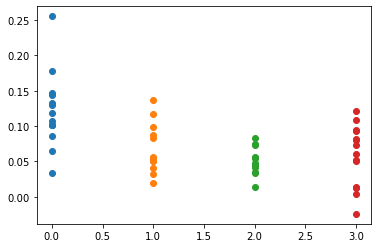

In [244]:
fig, ax = plt.subplots()

for i in range(4):
    a= [0,2,3,1][i]
    #print(len(all_exp_corrs[a]))
    #print([i] * len(all_exp_corrs[a]))
    #print(all_exp_corrs[a])
    ax.scatter([i]*len(all_exp_corrs[a]),np.nanmean(all_exp_corrs[a],0))
    
fig.show()

In [245]:
a=0

for a in range(4):
    flat_corrs = all_exp_corrs[a].flatten()
    flat_corrs = flat_corrs[~np.isnan(flat_corrs)]
    neg_corrs = flat_corrs[flat_corrs < 0]
    n_neg = np.sum(flat_corrs < 0)
    n_total = len(flat_corrs)
    print(n_neg/n_total,np.mean(neg_corrs),np.sum(exp_eggs[a]))

    
    

0.18681318681318682 -0.04983268208148023 149.0
0.25316455696202533 -0.11426246562101554 78.0
0.27631578947368424 -0.0823260567284643 75.0
0.32894736842105265 -0.05568681314022849 97.0


############### Plotting this cell is SUPER SLOW, don't run it!!
#plt.rcParams.update({'font.size': 14})
#fig = plt.figure()
#ax = fig.add_axes([.1, .1, .8, .8])
fig,ax =  plt.subplots()

ax.plot(x, y, 'o', color = 'royalblue')
ax.plot(x_line, y_line, color = 'royalblue')
ax.fill_between(x_line, y_line + pi, y_line - pi, color = 'lightcyan', label = '95% prediction interval')
ax.fill_between(x_line, y_line + ci, y_line - ci, color = 'skyblue', label = '95% confidence interval')

ax.set_xlabel('x')
ax.set_ylabel('y')

### rounding and position must be changed for each case and preference
a = str(np.round(intercept))
b = str(np.round(slope,2))
r2s = str(np.round(r2,2))
MSEs = str(np.round(MSE))

ax.text(45, 110, 'y = ' + a + ' + ' + b + ' x')
ax.text(45, 100, '$r^2$ = ' + r2s + '     MSE = ' + MSEs)

#plt.legend(bbox_to_anchor=(1, .25), fontsize=12)
fig.show()

In [246]:
## Try Bootstrapping everything simultaneously (weird, don't do this)

# First, calculate corr matrix in case I want to fiddle

## Relate r_corr with males vs with females:

if False:
    win_iterations = np.random.randint(45,90,size=1000)
    win_possibilities = np.arange(45,90)

    win_iterations = win_possibilities
    #win_iterations = [60]
    xs_all,ys_all = [],[]
    xs_n = []
    xs_call = []
    rs,rcs = [],[]
    for win in win_iterations:
        all_corrs = []
        corrs = []
        xs,ys = [],[]
        xs_c = []



        #a_sampled = range(len(metas))
        a_sampled = np.random.choice(np.arange(len(metas)),size=len(metas),replace=True)
        #print(win,a_sampled)
        for a in range(len(metas)):
            #rcorr_matrix = ratio_singing(exp_historys[a],exp_metas[a],exp_sorteds[a],window=win,prune=False,receiver='male')
            corr_matrix = correlate_fsongs(historys[a],metas[a],sorteds[a],window=win,prune=True)
            corr_matrix_unpruned = correlate_fsongs(historys[a],metas[a],sorteds[a],window=win,prune=False)
            corrs.append(np.nanmean(corr_matrix))
            all_corrs.append(corr_matrix_unpruned)


        #fig,ax = plt.subplots()


        for a in a_sampled:
            """
            flat_corrs = all_corrs[a].flatten()
            flat_corrs = flat_corrs[~np.isnan(flat_corrs)]
            neg_corrs = flat_corrs[flat_corrs < 0]
            n_neg = np.sum(flat_corrs < 0)
            n_total = len(flat_corrs)
            if len(neg_corrs) == 0:
                mean_neg = 0
            else:
                mean_neg = np.nanmean(neg_corrs)
            """
            #print(n_neg/n_total,mean_neg,np.sum(all_eggs[a]),egg_scores[a])
            #ax.scatter(mean_neg,egg_scores[a])

            if not np.isnan(egg_scores[a]):
                #xs.append(mean_neg)
                #xs_all.append(mean_neg)
                #xs_n.append(n_neg/n_total)
                xs_c.append(corrs[a])
                #print(a,corrs[a],egg_scores[a])
                xs_call.append(corrs[a])
                ys_all.append(egg_scores[a])
                ys.append(egg_scores[a])
        r_c,_ = pearsonr(xs_c,ys)
        #r,_ = pearsonr(xs,ys)
        #rs.append(r)
        rcs.append(r_c)
                #ax.text(mean_neg,egg_scores[a],a)
        #fig.show()

    #corrs = np.array(corrs)

    #print('discord (unpruned):',pearsonr(xs_all,ys_all))
    print('cohesion (pruned):',pearsonr(xs_call,ys_all))

    if False:
        fig,(ax1,ax2) = plt.subplots(2)

        ax1.scatter(xs_all,ys_all,alpha=.2)
        ax2.scatter(xs_call,ys_all,alpha=.2)

        fig.show()
    #print(pearsonr(f_corrs[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
    #print(pearsonr(corrs[~np.isnan(egg_scores)],egg_scores[~np.isnan(egg_scores)]))
    #print(pearsonr(xs_n,ys))

    fig,ax = plt.subplots()
    #ax.hist(rs,alpha=.5)
    ax.hist(rcs,alpha=.5)
    fig.show()

In [247]:
## Plot above (weird) approach
if False:
    rcs = np.array(rcs)
    print(np.mean(rcs),np.std(rcs))
    #print(rcs)

    rcsorted = np.sort(rcs)

    print(norm.interval(alpha=0.95, loc=np.mean(rcs), scale=np.std(rcs)))
    print(np.sum(rcs <= 0),len(rcs))
    print(np.sort(rcs)[[25,976]])

    print(print(np.sum(rcsorted <= 0) / 1000))
    fig,ax = plt.subplots()
    ax.scatter(xs_call,ys_all,alpha=.003)
    fig.show()

[[        nan -0.02832789  0.38829269  0.12624774 -0.17647364 -0.27161614
  -0.10858563  0.01708797  0.03908008  0.11296343  0.17365633  0.37021251]
 [-0.02832789         nan  0.03952847  0.02597947 -0.16666667         nan
  -0.08855485  0.37803694  0.         -0.10878566  0.         -0.39189317]
 [ 0.38829269  0.03952847         nan -0.04340593 -0.12725695  0.10087126
   0.26074116  0.01876685  0.26420312  0.14692664 -0.07368335  0.16040987]
 [ 0.12624774  0.02597947 -0.04340593         nan -0.02229101  0.18068023
  -0.09784432 -0.18263045  0.11325179 -0.0939368   0.01469881  0.109447  ]
 [-0.17647364 -0.16666667 -0.12725695 -0.02229101         nan  0.79056942
   0.14746633 -0.07386608 -0.21256901  0.57706829 -0.15223569 -0.22641378]
 [-0.27161614         nan  0.10087126  0.18068023  0.79056942         nan
  -0.12403473         nan -0.31622777 -0.17213259 -0.1950356  -0.42105263]
 [-0.10858563 -0.08855485  0.26074116 -0.09784432  0.14746633 -0.12403473
          nan  0.21697651 -0.046

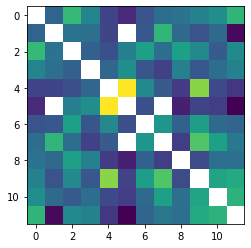

In [248]:
## Make a network plot, think about how to quantify individual cohesion

a = 1

n_females = metas[a].n_females

win=60
corr_matrix = correlate_fsongs(historys[a],metas[a],sorteds[a],window=win,prune=True)

print(corr_matrix)
fig,ax = plt.subplots()
ax.imshow(corr_matrix)

fig.show()

In [2488]:
print(12/14,11/12)
print(12/13,11/14)
print(7/14,6/13)
print(4/14,3/14)
print(ttest_ind([.5,.46],[0.286,0.214]))
print(ttest_ind([9.8,10.1],[8.3,7.0]))
print(ttest_ind([5.9,5.36],[2.33,2.27]))

0.8571428571428571 0.9166666666666666
0.9230769230769231 0.7857142857142857
0.5 0.46153846153846156
0.2857142857142857 0.21428571428571427
Ttest_indResult(statistic=5.58489370855427, pvalue=0.030596693917871082)
Ttest_indResult(statistic=3.4478457693809594, pvalue=0.07480431528450102)
Ttest_indResult(statistic=12.25789939430797, pvalue=0.006589592824545949)


[0.         0.09090909 0.18181818 0.27272727 0.36363636 0.45454545
 0.54545455 0.63636364 0.72727273 0.81818182 0.90909091 1.
 1.09090909 1.18181818 1.27272727 1.36363636 1.45454545 1.54545455
 1.63636364 1.72727273 1.81818182 1.90909091 2.         2.09090909
 2.18181818 2.27272727 2.36363636 2.45454545 2.54545455 2.63636364
 2.72727273 2.81818182 2.90909091 3.         3.09090909 3.18181818
 3.27272727 3.36363636 3.45454545 3.54545455 3.63636364 3.72727273
 3.81818182 3.90909091 4.         4.09090909 4.18181818 4.27272727
 4.36363636 4.45454545 4.54545455 4.63636364 4.72727273 4.81818182
 4.90909091 5.         5.09090909 5.18181818 5.27272727 5.36363636
 5.45454545 5.54545455 5.63636364 5.72727273 5.81818182 5.90909091
 6.         6.09090909 6.18181818 6.27272727 6.36363636 6.45454545
 6.54545455 6.63636364 6.72727273 6.81818182 6.90909091 7.
 7.09090909 7.18181818 7.27272727 7.36363636 7.45454545 7.54545455
 7.63636364 7.72727273 7.81818182 7.90909091 8.         8.09090909
 8.18181818

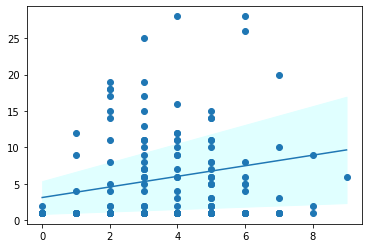

In [147]:

slope = 0.726
intercept = 3.120
xs = male_df['Degree']
ys= male_df['Eggs']
# mean squared error

x = np.linspace(np.nanmin(xs),np.nanmax(xs),100)
print(x)
y_model = np.polyval([slope, intercept], x)   # modeling...

high_slope = 1.287
low_slope = 0.165

high_int,low_int = 5.372,0.868
high_line = np.polyval([high_slope,high_int],x)
low_line = np.polyval([low_slope,low_int],x)

#in_line1 = np.polyval([high_slope,])
fig,ax = plt.subplots()
ax.fill_between(x,high_line,low_line,color='lightcyan')
ax.plot(x,y_model)
ax.scatter(xs,ys)

fig.show()

1    4
2    4
3    3
Name: Degree, dtype: object 1    1
2    1
3    2
Name: Eggs, dtype: object
5     6
8     6
9     5
13    4
14    4
17    4
18    5
Name: Degree, dtype: object 5     5
8     5
9     2
13    1
14    1
17    1
18    5
Name: Eggs, dtype: object
19    5
20    4
21    4
22    5
23    3
24    5
Name: Degree, dtype: object 19    1
20    1
21    1
22    1
23    1
24    2
Name: Eggs, dtype: object
25    7
27    5
34    4
35    8
39    8
40    9
Name: Degree, dtype: object 25    1
27    2
34    2
35    2
39    1
40    6
Name: Eggs, dtype: object
45    6
47    3
49    2
50    3
Name: Degree, dtype: object 45    28
47     1
49    18
50    10
Name: Eggs, dtype: object
51    2
53    3
54    2
56    4
57    5
58    3
Name: Degree, dtype: object 51     1
53     2
54    11
56     4
57     1
58    25
Name: Eggs, dtype: object
59    1
60    4
62    3
63    3
66    2
Name: Degree, dtype: object 59    12
60    10
62    11
63    15
66     1
Name: Eggs, dtype: object
71    6
72    5
74   

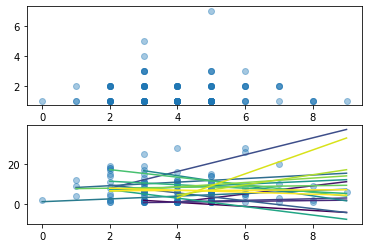

In [144]:
fig,(ax,ax2) = plt.subplots(2)

if False:
    sub_df = maledf[male_df['Eggs'] > 1]
if True:
    sub_df = male_df[male_df['nPairbonds'] > 0]
ax.scatter(sub_df['Degree'],sub_df['nPairbonds'],alpha=.4)
ax2.scatter(sub_df['Degree'],sub_df['Eggs'],alpha=.4)


for a in np.unique(sub_df['Aviary']):
    cor = cm.viridis(a/17)
    a_df = sub_df[sub_df['Aviary'] == a]
    print(a_df['Degree'],a_df['Eggs'])
    fit_line = np.poly1d(np.polyfit(a_df['Degree'].astype(int),a_df['Eggs'].astype(int),1))
    xs = [np.min(a_df['Degree']),np.max(sub_df['Degree'])]
    ax2.plot(xs,fit_line(xs),color=cor)
fig.show()

print(pearsonr(sub_df['Degree'],sub_df['nPairbonds']))
print(pearsonr(sub_df['Degree'],sub_df['Eggs']))

## This last bit is very cool. Is it real?

What this suggests is that degree, i.e. the centrality of males (via cohesion) predicts egg production

This disrupts the weird disconnect between cohesion/activity/and eggs. This is a new metric of cohesion though, 
and it's one I like a lot more.

There's some specific parameter issues though
1. What happens if I drop the weird aviaries - Holds
2. What happens if I change the threshold? - disappears at .2, stronger at .05, weird at .0
3. What happens if we remove loser males? - becomes negative, non-significant
4. What if we just keep losers, but just look at winners? - same, negative, non-significant
5. What if we keep winnters, but just look at losers? - Oh, duh, this can't work, b/c eggs

6. Am I sure this isn't an artifact? - It doesn't seem to be, however! :
This effect goes away if you exclude males with no females (or to be more precise, males with no eggs). 
So cohesion is  a strong predictor of getting any eggs, but within successful males, if anything, 
Cohesion is inversely related to egg output. This brings us back in line with our original resutlts, 
and helps explain Dave's question, of why there's variation at all. 

This effect of mean cohesion is very limited: it works withink pairbonded males (excluding males who don't pairbond) but not within pairbonded males who produce eggs. So if you have a female, being cohesive predicts egg production, but within males that have female sthat produce eggs, cohesion has no effect. 


Also pairbonded males have signifcantly higher degree than unpaired males; you can't be cohesive if you're not singing to females, so maybe that isn't that surprising. Is this just reflecting pairbonding then? 

Also, is all this cohesion just countersinging? It would be nice to control for that somehow. 

In [172]:
## Skipped: Read in exp eggs
exp_egg_text = pd.read_csv('./AviaryDataFiles/Eggs0203.csv')

repeat_males = get_overlap(exp_egg_text[exp_egg_text['Year'] == 2002]['Male'],exp_egg_text[exp_egg_text['Year'] == 2003]['Male'])
repeat_females = get_overlap(exp_egg_text[exp_egg_text['Year'] == 2002]['Female'],exp_egg_text[exp_egg_text['Year'] == 2003]['Female'])

foo = []
for a in range(4):
    foo.append(np.sum(exp_eggs[a]))
    
## Build dataframe 
columns_exp = ['Male','Cohesion','PairbondEggs','nPairbonds',"EggsPerBond",'Repeat','AviaryCohesion','AviaryEggs','Aviary','Year']

exp_df = pd.DataFrame(columns=columns_exp)
"""
exp_dict = {
    'LNA':{
        2002:[
            exp_rcorrs[0],foo[0]],
        2003:[
            exp_rcorrs[2],foo[2]]},
    'LSA':{
        2002:[
            exp_rcorrs[1],foo[1]],
        2003:[
            exp_rcorrs[3],foo[3]]}
}
"""

for y in [2002,2003]:
    sub_df = exp_egg_text[exp_egg_text['Year'] == y]
    i = y % 2 * 2
    for m in pd.unique(sub_df['Male']):
        a = sub_df[sub_df['Male'] == m]['Aviary'].values[0]
        if a == 'LNA':
            a_i = 0
        else:
            a_i = 1
        a_i = a_i + i ## I need to get the index so that I can pull from my list-based info

        m_df = sub_df[sub_df['Male'] == m]
        n_eggs = np.sum(m_df['Eggs'])
        n_mates = len(m_df)
        eggs_per_mate = n_eggs/n_mates
        a_cohesion,a_eggs = exp_dict[a][y]
        if m in repeat_males:
            r = True

        else:
            r = False
        m_cohesion = 0
        m_i = np.where(exp_metas[a_i].m_ids == m)[0]
        #print(a_i,m_i,m,a,exp_metas[a_i].m_ids)
        m_cohesion = np.nanmean(all_exp_corrs[a_i][m_i])
        
        exp_df = exp_df.append(dict(zip(columns_exp,
                               [m,m_cohesion,n_eggs,n_mates,eggs_per_mate,r,a_cohesion,a_eggs,a,y])),ignore_index=True)
        #print(m,m_cohesion,n_eggs,n_mates,r,a_cohesion,a_eggs,a,y)

## Add in all the missing males who didn't get eggs
for m in repeat_males:
    m_df = exp_egg_text[exp_egg_text['Male'] == m]
    #print(m_df)
    #print(len(pd.unique(m_df['Year'])))
    if len(pd.unique(m_df['Year'])) == 2:
        continue # all good
    elif len(pd.unique(m_df['Year'])) == 0:
        # Add both lines
        for a_i in range(4): 
            if m in exp_metas[a_i].m_ids:
                #print(2,m,exp_metas[a].name)
                m_i = np.where(exp_metas[a_i].m_ids == m)[0]
                m_cohesion = np.nanmean(all_exp_corrs[a_i][m_i])
                a_cohesion,a_eggs = exp_rcorrs[a_i],foo[a_i]
                r = True
                n_eggs,n_mates = 0,0
                a,y = exp_metas[a_i].name.split('-')
                y = int(y)
                
                exp_df = exp_df.append(dict(zip(columns_exp,
                               [m,m_cohesion,n_eggs,n_mates,0,r,a_cohesion,a_eggs,a,y])),ignore_index=True)
                #print(2,m,m_cohesion,n_eggs,n_mates,r,a_cohesion,a_eggs,a,y)
    elif len(pd.unique(m_df['Year'])) == 1:
        prior_year = m_df['Year'].values[0]
        for a_i in range(4): 
            if str(prior_year) in exp_metas[a_i].name:
                continue
            if m in exp_metas[a_i].m_ids:

                m_i = np.where(exp_metas[a_i].m_ids == m)[0]
                m_cohesion = np.nanmean(all_exp_corrs[a_i][m_i])
                a_cohesion,a_eggs = exp_rcorrs[a_i],foo[a_i]
                r = True
                n_eggs,n_mates = 0,0
                a,y = exp_metas[a_i].name.split('-')
                y = int(y)
                exp_df = exp_df.append(dict(zip(columns_exp,
                               [m,m_cohesion,n_eggs,n_mates,0,r,a_cohesion,a_eggs,a,y])),ignore_index=True)
                #print(1,m,m_cohesion,n_eggs,n_mates,r,a_cohesion,a_eggs,a,y)                   
#print(exp_df)
pass

IndexError: list index out of range

In [2489]:
#BOTTOM OF BONUS

   Aviary  Year  Male Female  Eggs
0     LSA  2003  MGOL   FYDR     5
1     LSA  2003  MGOL   F2LO     1
2     LSA  2003  MLOY   FGRG     2
3     LSA  2003  MROR   FGDG     1
4     LSA  2003   MWD   FLOR     5
5     LSA  2003   MWD   F2LO     3
6     LSA  2003    MY   FLRY    34
7     LSA  2003    MY   F2ON     1
8     LSA  2003  MYRD   FORM     1
9     LSA  2003  MYRD   FYOG     3
10    LSA  2003  MYRD   FMYG     3
11    LSA  2003  MYRD   F2RW     0


In [2500]:
## Copy pasting all the above values from the cell from before is dumb, I will eventually fix that. 
for a in range(len(exp_metas)):
    ## Build dataframe of eggs
    a_id,a_year = exp_metas[a].name.split('-')
    a_id = transform_dict[a_id]
    y_df = exp_egg_text[exp_egg_text['Year'] == int(a_year)]
    a_df = y_df[y_df['Aviary'] == a_id]
    
    print('ratio pairbonded laying eggs:',np.sum(a_df['Eggs'] > 0) / len(a_df))
    print('mean eggs by layers:',np.mean(a_df[a_df['Eggs'] > 0]['Eggs']))

print()
print('ratio of pairbonded laying:',ttest_ind([1.0,.92],[0.75,0.45]))
print('mean eggs by layers:',ttest_ind([5.9,5.36],[5.0,3.11]))

ratio pairbonded laying eggs: 1.0
mean eggs by layers: 5.916666666666667
ratio pairbonded laying eggs: 0.45454545454545453
mean eggs by layers: 5.0
ratio pairbonded laying eggs: 0.75
mean eggs by layers: 3.111111111111111
ratio pairbonded laying eggs: 0.9166666666666666
mean eggs by layers: 5.363636363636363

ratio of pairbonded laying: Ttest_indResult(statistic=2.318963855042991, pvalue=0.1462383901877519)
mean eggs by layers: Ttest_indResult(statistic=1.6025399127347062, pvalue=0.2502103706389474)


In [2069]:
## Get male female ratios for Table 1
mf_ratios = []
n_birds = []
for a in range(len(metas)):
    print(metas[a].n_birds,metas[a].n_females/metas[a].n_males)
    mf_ratios.append(metas[a].n_females/metas[a].n_males)
    n_birds.append(metas[a].n_birds)
print(np.mean(n_birds),np.mean(mf_ratios))

17 2.4
27 0.9285714285714286
17 1.8333333333333333
29 0.8125
37 2.7
23 1.875
27 2.375
35 2.1818181818181817
24 1.4
16 1.2857142857142858
19 1.1111111111111112
28 1.5454545454545454
23 1.3
20 1.5
23 1.3
19 1.375
19 1.1111111111111112
32 1.9090909090909092
32 1.4615384615384615
24.57894736842105 1.600275966723335


In [2068]:

m_scores = []
for n in G.nodes():
    if 'F' in str(n):
        continue
    weight_sum = 0
    edge_count = 0
    for n1,n2,d in G.edges(data=True):
        if n not in (n1,n2):
            continue
        if node_colors[n1] != 'Blue' or node_colors[n2] != 'Blue':
            continue

        else:
            weight_sum += d['weight']
            edge_count += 1
    print(weight_sum,edge_count)
    if edge_count != 0:
        m_scores.append(weight_sum / (edge_count))
print(m_scores)

0.3515941145877253 5
0.25941461773248864 2
1.1174075578587896 4
1.0375858731754692 3
0.8553388494450587 5
0.9808628981110394 6
0 0
0.27959858500563933 2
0.2810869795799562 2
0.2827141768089577 2
0.4145464154510206 3
0.10091292973431497 1
0.3916099032641538 3
[0.07031882291754507, 0.12970730886624432, 0.2793518894646974, 0.34586195772515643, 0.17106776988901173, 0.16347714968517324, 0.13979929250281967, 0.1405434897899781, 0.14135708840447886, 0.13818213848367353, 0.10091292973431497, 0.1305366344213846]


In [1611]:
## JUMP
m = 1
print(len(exp_metas[m].m_ids))
print(exp_historys[m].shape)
print(exp_metas[m].n_males,exp_metas[m].n_females)

print(exp_sorteds[m][0])
print(np.unique(exp_sorteds[m][:,0]))
print(np.unique(exp_sorteds[m][:,1]))

14
(14372, 28, 28)
14 14
['MROR' 'MLOY' '' '09:06:26' '09:06:26' '02-02-14' 'LSA']
['FDOD' 'FDR' 'FLOB' 'FLOL' 'FMOY' 'FO2D' 'FOWR' 'FWB' 'FWN' 'FWRW' 'FYML'
 'M2MR' 'MALE' 'MDBW' 'MDLO' 'MDMG' 'MDOG' 'MG2O' 'MGBR' 'MGOL' 'MGYG'
 'MLBL' 'MLMB' 'MLMN' 'MLOY' 'MLYR' 'MMW' 'MOLR' 'MR2O' 'MROD' 'MROR'
 'MRY' 'MWYR' 'MY' 'MY2O' 'MYLW' 'MYNR' 'MYRM' 'My' 'my']
['' 'FDOD' 'FDR' 'FEMALE' 'FLOB' 'FLOL' 'FMOY' 'FMYM' 'FNOR' 'FO2D' 'FOWR'
 'FWB' 'FWN' 'FWRW' 'FYBO' 'FYML' 'Female' 'INTERFERE' 'M2MR' 'MALE'
 'MDBW' 'MDLO' 'MDMG' 'MDOG' 'MG2B' 'MG2O' 'MGBR' 'MGOL' 'MGYG' 'MLBL'
 'MLMB' 'MLMN' 'MLOY' 'MLYR' 'MMW' 'MOLR' 'MR2O' 'MROD' 'MROR' 'MRY'
 'MWYR' 'MY' 'MY2O' 'MYLW' 'MYNR' 'MYRM' 'Male' 'Soliloquy' 'Whistle'
 'female' 'male' 'my' 'mylw' 'soliloquy' 'whistle']


In [1561]:
print(ttest_ind(all_weights[1],all_weights[3]))
print(ttest_ind(all_weights[0],all_weights[2]))

print(ttest_ind(exp_degrees[1],exp_degrees[3]))
print(ttest_ind(exp_degrees[0],exp_degrees[2]))

exp_degrees_good = np.hstack([exp_degrees[0],exp_degrees[3]])
exp_degrees_bad = np.hstack([exp_degrees[1],exp_degrees[2]])

good_weights = np.hstack([all_weights[0],all_weights[3]])
bad_weights = np.hstack([all_weights[1],all_weights[2]])

print(ttest_ind(exp_degrees_good,exp_degrees_bad))
print(np.mean(exp_degrees_good),np.mean(exp_degrees_bad))
#print(ttest_ind(good_weights,bad_weights))

Ttest_indResult(statistic=-0.5919896498768743, pvalue=0.5564729390533214)
Ttest_indResult(statistic=1.897849658315983, pvalue=0.06119231625298068)
Ttest_indResult(statistic=1.291438043661534, pvalue=0.20791551606905154)
Ttest_indResult(statistic=2.601801177909137, pvalue=0.015106526177463334)
Ttest_indResult(statistic=1.0388764045689487, pvalue=0.3034916880991534)
0.378103378103378 0.3238095238095239


In [1376]:
win = 60
        
all_degrees = []
all_rcorrs_male = []
all_corrs_male = []
for a in range(len(metas)):
    
    corr_matrix = correlate_fsongs(historys[a],metas[a],sorteds[a],window=win,prune=False,shuffle=False)
    #corr_shuffled = correlate_fsongs(historys[a],metas[a],sorteds[a],window=win,prune=True,shuffle=True)
    rcorr_matrix = ratio_singing(historys[a],metas[a],sorteds[a],window=win,prune=False,shuffle=False)
    #rcorr_shuffled = ratio_singing(historys[a],metas[a],sorteds[a],window=win,prune=True,shuffle=True)
    #print(corr_matrix.shape)
    degree_list = np.sum(corr_matrix > .1,axis=0)
    rcorr_list = np.nanmean(rcorr_matrix,axis=0)
    all_degrees.extend(degree_list)
    all_rcorrs_male.extend(rcorr_list)
    all_corrs_male.extend(np.nanmean(corr_matrix,0))
    
    print(pearsonr(degree_list[~np.isnan(rcorr_list)],rcorr_list[~np.isnan(rcorr_list)]))
    
    
print(pearsonr(all_degrees,all_rcorrs_male))

all_degrees = np.array(all_degrees)
all_corrs_male = np.array(all_corrs_male)

print(pearsonr(all_degrees[~np.isnan(all_corrs_male)],all_corrs_male[~np.isnan(all_corrs_male)]))

(nan, nan)
(0.6532669880656199, 0.011297226120181247)
(0.9020641680175399, 0.013917468578460213)
(0.773193977190724, 0.0004435018290166342)
(-0.04175781719169037, 0.9088138883852015)
(0.6713680269628167, 0.06829761411402434)
(-0.5945795419763777, 0.12004523588463721)
(0.26677524699938304, 0.427779120237505)
(0.08367952793076577, 0.8182274135926336)
(0.8094587465692265, 0.02738999615950265)
(0.8081105331541107, 0.00840016432770816)
(0.27341922302101723, 0.41591314673253305)
(0.7462906487382275, 0.013170411046458746)
(-0.002559698106284678, 0.9952005870147765)
(0.7274428693695225, 0.01710909751762154)
(0.7912100145773874, 0.01934018349431735)
(0.6780680577847183, 0.04470524585185629)
(0.39316171926868243, 0.23161550046280924)
(0.5670087924076357, 0.0433052780707724)
(0.3748039989076836, 1.5902900068869402e-07)
(0.022145800622497644, 0.7704857658492174)


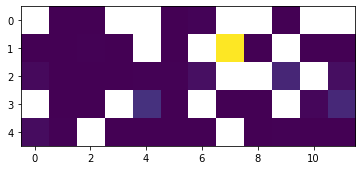

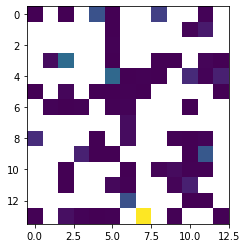

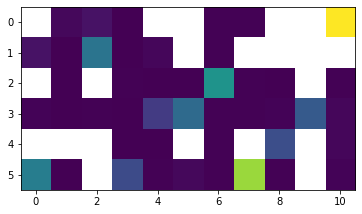

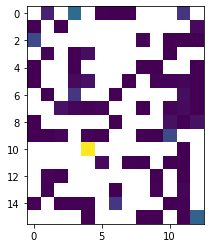

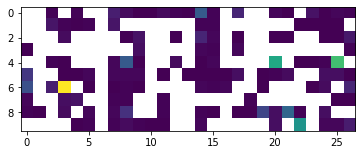

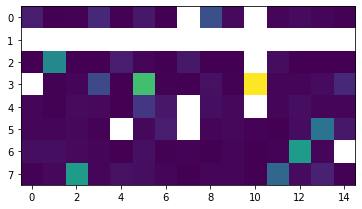

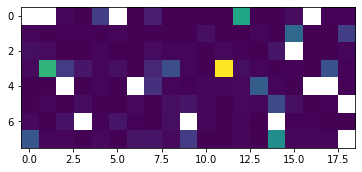

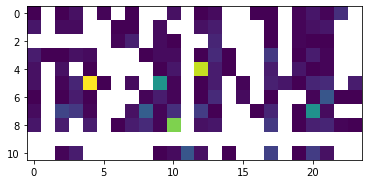

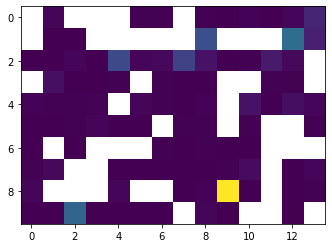

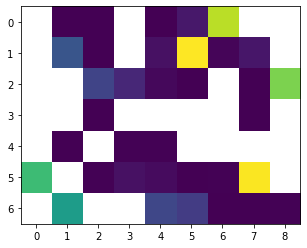

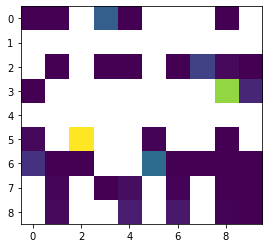

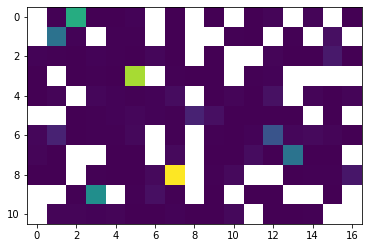

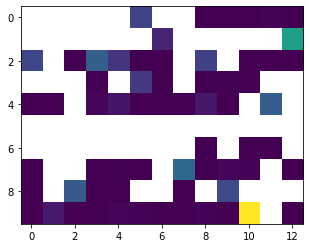

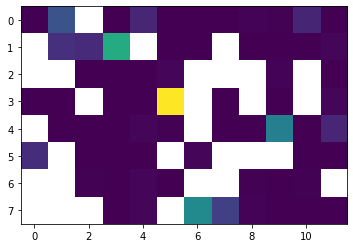

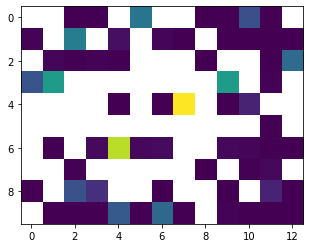

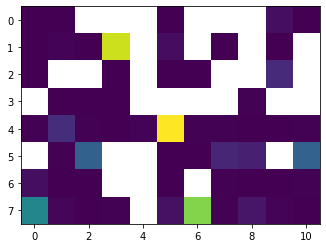

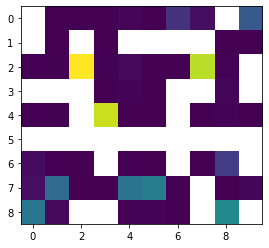

In [1270]:
for a in range(len(metas)):
    f_songs = get_fsongs(historys[a],metas[a])
    f_songs[f_songs==0] = np.nan
    fig,ax = plt.subplots()
    ax.imshow(f_songs)
    fig.show()

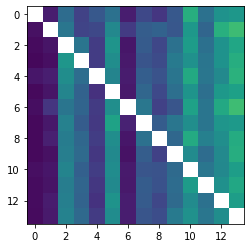

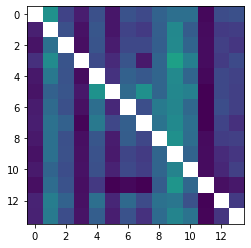

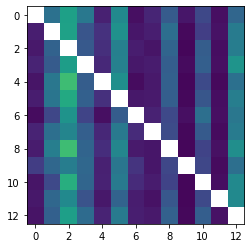

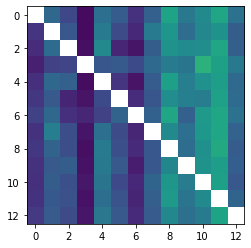

In [625]:
for a in range(4):
    fig,ax=plt.subplots()
    ax.imshow(all_exp_rcorrs[a],vmin=0,vmax=1)
    fig.show()

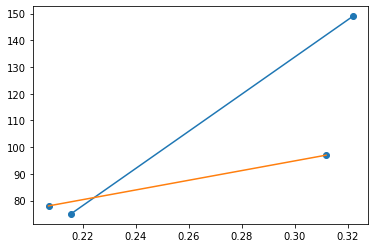

In [741]:
foo = []
for a in range(4):
    foo.append(np.sum(exp_eggs[a]))
    
fig,ax = plt.subplots()
ax.scatter(exp_rcorrs,foo)
ax.plot([exp_rcorrs[0],exp_rcorrs[2]],[foo[0],foo[2]])
ax.plot([exp_rcorrs[1],exp_rcorrs[3]],[foo[1],foo[3]])
fig.show()

## Build a somewhat clunk dictionary to keep track of these values so they're easy to recall below
exp_dict = {
    'LNA':{
        2002:[
            exp_rcorrs[0],foo[0]],
        2003:[
            exp_rcorrs[2],foo[2]]},
    'LSA':{
        2002:[
            exp_rcorrs[1],foo[1]],
        2003:[
            exp_rcorrs[3],foo[3]]}
}

In [772]:
all_males = np.hstack([exp_metas[a].m_ids for a in range(4)])
print(all_males)
values,counts = np.unique(all_males,return_counts = True)
repeat_males = values[counts > 1]
print(repeat_males)

for m in repeat_males:
    m_df = exp_egg_text[exp_egg_text['Male'] == m]
    if len(m_df) == 2:
        continue # all good
    elif len(m_df) == 0:
        # Add both lines
        for a in range(4): 
            if m in exp_metas[a].m_ids:
                print(2,m,exp_metas[a].name)
    elif len(m_df) == 1:
        prior_year = m_df['Year'].values[0]
        for a in range(4): 
            if str(prior_year) in exp_metas[a].name:
                continue
            if m in exp_metas[a].m_ids:
                print(1,m,exp_metas[a].name)

['M3O' 'MD' 'MDLO' 'MDOG' 'MDON' 'MDYG' 'ML' 'MLBL' 'MNW' 'MNWL' 'MRYR'
 'MWD' 'MY' 'MYRD' 'M2MR' 'MGBR' 'MGOL' 'MLMB' 'MLMN' 'MLOY' 'MR2O' 'MROD'
 'MROR' 'MRY' 'MWYR' 'MY2O' 'MYLW' 'MYRM' 'M3O' 'MBRD' 'MBRW' 'MDLO'
 'MDOG' 'MDRM' 'MDYG' 'MG2L' 'MGDO' 'ML' 'MLRM' 'MNWL' 'MOWN' 'MRYR'
 'MDON' 'MGOL' 'MLBL' 'MLMN' 'MLOY' 'MNW' 'MR2O' 'MROD' 'MROR' 'MWD'
 'MWYR' 'MY' 'MYRD']
['M3O' 'MDLO' 'MDOG' 'MDON' 'MDYG' 'MGOL' 'ML' 'MLBL' 'MLMN' 'MLOY' 'MNW'
 'MNWL' 'MR2O' 'MROD' 'MROR' 'MRYR' 'MWD' 'MWYR' 'MY' 'MYRD']
2 M3O PH1-2002
2 M3O PH1-2003
1 MDOG PH1-2002
2 MDON PH1-2002
2 MDON PH2-2003
2 ML PH1-2002
2 ML PH1-2003
1 MLBL PH2-2003
1 MLOY PH2-2002
2 MNW PH1-2002
2 MNW PH2-2003
1 MNWL PH1-2003
2 MR2O PH2-2002
2 MR2O PH2-2003
2 MROD PH2-2002
2 MROD PH2-2003
1 MROR PH2-2002
2 MWYR PH2-2002
2 MWYR PH2-2003


In [794]:
for m in repeat_males:
    print(m)
    for a in range(4):
        if m in exp_metas[a].m_ids:
            print(exp_metas[a].name)

M3O
PH1-2002
PH1-2003
MDLO
PH1-2002
PH1-2003
MDOG
PH1-2002
PH1-2003
MDON
PH1-2002
PH2-2003
MDYG
PH1-2002
PH1-2003
MGOL
PH2-2002
PH2-2003
ML
PH1-2002
PH1-2003
MLBL
PH1-2002
PH2-2003
MLMN
PH2-2002
PH2-2003
MLOY
PH2-2002
PH2-2003
MNW
PH1-2002
PH2-2003
MNWL
PH1-2002
PH1-2003
MR2O
PH2-2002
PH2-2003
MROD
PH2-2002
PH2-2003
MROR
PH2-2002
PH2-2003
MRYR
PH1-2002
PH1-2003
MWD
PH1-2002
PH2-2003
MWYR
PH2-2002
PH2-2003
MY
PH1-2002
PH2-2003
MYRD
PH1-2002
PH2-2003


In [795]:
## Read in exp eggs
exp_egg_text = pd.read_csv('./AviaryDataFiles/Eggs0203.csv')

#repeat_males = get_overlap(exp_egg_text[exp_egg_text['Year'] == 2002]['Male'],exp_egg_text[exp_egg_text['Year'] == 2003]['Male'])
#repeat_females = get_overlap(exp_egg_text[exp_egg_text['Year'] == 2002]['Female'],exp_egg_text[exp_egg_text['Year'] == 2003]['Female'])


## Build dataframe 
columns_exp = ['Male','Cohesion','PairbondEggs','nPairbonds',"EggsPerBond",'Repeat','AviaryCohesion','AviaryEggs','Aviary','Year']

exp_df = pd.DataFrame(columns=columns_exp)


for y in [2002,2003]:
    sub_df = exp_egg_text[exp_egg_text['Year'] == y]
    i = y % 2 * 2
    for m in pd.unique(sub_df['Male']):
        a = sub_df[sub_df['Male'] == m]['Aviary'].values[0]
        if a == 'LNA':
            a_i = 0
        else:
            a_i = 1
        a_i = a_i + i ## I need to get the index so that I can pull from my list-based info

        m_df = sub_df[sub_df['Male'] == m]
        n_eggs = np.sum(m_df['Eggs'])
        n_mates = len(m_df)
        eggs_per_mate = n_eggs/n_mates
        a_cohesion,a_eggs = exp_dict[a][y]
        if m in repeat_males:
            r = True

        else:
            r = False
        m_cohesion = 0
        m_i = np.where(exp_metas[a_i].m_ids == m)[0]
        #print(a_i,m_i,m,a,exp_metas[a_i].m_ids)
        m_cohesion = np.nanmean(all_exp_corrs[a_i][m_i])
        
        exp_df = exp_df.append(dict(zip(columns_exp,
                               [m,m_cohesion,n_eggs,n_mates,eggs_per_mate,r,a_cohesion,a_eggs,a,y])),ignore_index=True)
        #print(m,m_cohesion,n_eggs,n_mates,r,a_cohesion,a_eggs,a,y)

## Add in all the missing males who didn't get eggs
for m in repeat_males:
    m_df = exp_egg_text[exp_egg_text['Male'] == m]
    #print(m_df)
    #print(len(pd.unique(m_df['Year'])))
    if len(pd.unique(m_df['Year'])) == 2:
        continue # all good
    elif len(pd.unique(m_df['Year'])) == 0:
        # Add both lines
        for a_i in range(4): 
            if m in exp_metas[a_i].m_ids:
                #print(2,m,exp_metas[a].name)
                m_i = np.where(exp_metas[a_i].m_ids == m)[0]
                m_cohesion = np.nanmean(all_exp_corrs[a_i][m_i])
                a_cohesion,a_eggs = exp_rcorrs[a_i],foo[a_i]
                r = True
                n_eggs,n_mates = 0,0
                a,y = exp_metas[a_i].name.split('-')
                y = int(y)
                
                exp_df = exp_df.append(dict(zip(columns_exp,
                               [m,m_cohesion,n_eggs,n_mates,0,r,a_cohesion,a_eggs,a,y])),ignore_index=True)
                #print(2,m,m_cohesion,n_eggs,n_mates,r,a_cohesion,a_eggs,a,y)
    elif len(pd.unique(m_df['Year'])) == 1:
        prior_year = m_df['Year'].values[0]
        for a_i in range(4): 
            if str(prior_year) in exp_metas[a_i].name:
                continue
            if m in exp_metas[a_i].m_ids:

                m_i = np.where(exp_metas[a_i].m_ids == m)[0]
                m_cohesion = np.nanmean(all_exp_corrs[a_i][m_i])
                a_cohesion,a_eggs = exp_rcorrs[a_i],foo[a_i]
                r = True
                n_eggs,n_mates = 0,0
                a,y = exp_metas[a_i].name.split('-')
                y = int(y)
                exp_df = exp_df.append(dict(zip(columns_exp,
                               [m,m_cohesion,n_eggs,n_mates,0,r,a_cohesion,a_eggs,a,y])),ignore_index=True)
                #print(1,m,m_cohesion,n_eggs,n_mates,r,a_cohesion,a_eggs,a,y)                   
#print(exp_df)
pass

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: PairbondEggs
No. Observations: 40      Method:             REML        
No. Groups:       20      Scale:              39.8679     
Min. group size:  2       Log-Likelihood:     -129.4956   
Max. group size:  2       Converged:          Yes         
Mean group size:  2.0                                     
----------------------------------------------------------
               Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
----------------------------------------------------------
Intercept      -1.768    6.251 -0.283 0.777 -14.019 10.483
AviaryCohesion 20.513   21.842  0.939 0.348 -22.297 63.323
Group Var      13.438    2.536                            



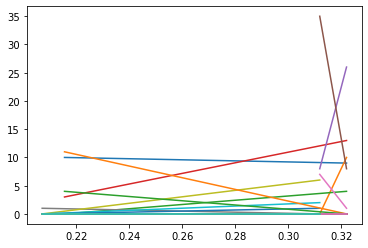

In [810]:
fig,ax = plt.subplots()

sub_df = exp_df[exp_df['Repeat'] == True]

## Delete males who didn't see both conditions
if False:
    for m in ['MDON','MLBL','MNW','MWD','MY','MYRD']:
        sub_df = sub_df[sub_df['Bird'] != m]
if False: # Delete males who never had any eggs
    for m in pd.unique(sub_df['Bird']):
        if np.sum(sub_df[sub_df['Bird'] == m]['PairbondEggs']) == 0:
            sub_df = sub_df[sub_df['Bird'] != m]
xs,ys = [],[]
for m in pd.unique(sub_df['Bird']):
    m_df = sub_df[sub_df['Bird'] == m]
        
    #xs = m_df['AviaryCohesion']
    ax.plot(m_df['AviaryCohesion'],m_df['PairbondEggs'])
    #xs.extend(m_df['AviaryCohesion'])
    #ys.extend(m_df['AviaryEggs'])
fig.show()

#print(pearsonr(xs,ys))

sub_df['PairbondEggs'] = pd.to_numeric(sub_df['PairbondEggs'])
sub_df['AviaryCohesion'] = pd.to_numeric(sub_df['AviaryCohesion'])
sub_df['AviaryEggs'] = pd.to_numeric(sub_df['AviaryEggs'])
sub_df['EggsPerBond'] = pd.to_numeric(sub_df['EggsPerBond'])

        
md = smf.mixedlm("PairbondEggs ~ AviaryCohesion",data=sub_df,groups=sub_df["Bird"])
mdf_partial = md.fit()    
print(mdf_partial.summary())

In [ ]:
## Build a dataframe with Individual male cohesion and group cohesion in each year along with egg's produced






14
14
13
12


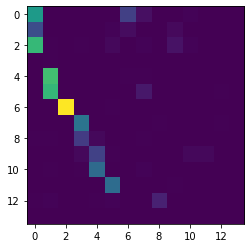

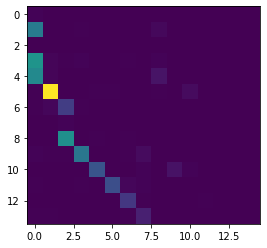

In [657]:
## What about female participation in courtship? 

for a in range(4):
    n_females = exp_metas[a].n_females
    fig,ax = plt.subplots()
    f_songs = np.sum(exp_historys[a][:,n_females:,:n_females],axis=0)
    print(n_females)
    ax.imshow(sort_pairbonds(np.transpose(f_songs)))
    fig.show()

In [ ]:
def sort_pairbonds(summed_investment):
    nm,nf = summed_investment.shape
    
    ranked_males = np.argsort(np.nansum(summed_investment,axis=0))[::-1]

    summed_investment = summed_investment[:,ranked_males]

    pairbonds = np.argmax(summed_investment,axis=1)

    pb_order = np.argsort(pairbonds)

    summed_investment = summed_investment[pb_order,:]

    if False:
        fig,ax = plt.subplots()
        ax.imshow(summed_investment)
        fig.show()
    return summed_investment

def get_overlap(a,b):
    return list(set(a) & set(b))

def print_overlap(a,b):
    print(get_overlap(a,b))
    return get_overlap(a,b)

7
6


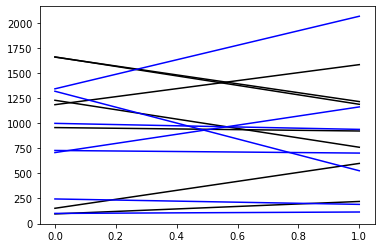

In [685]:
def sort_pairbonds(summed_investment):
    nm,nf = summed_investment.shape
    
    ranked_males = np.argsort(np.nansum(summed_investment,axis=0))[::-1]

    summed_investment = summed_investment[:,ranked_males]

    pairbonds = np.argmax(summed_investment,axis=1)

    pb_order = np.argsort(pairbonds)

    summed_investment = summed_investment[pb_order,:]

    if False:
        fig,ax = plt.subplots()
        ax.imshow(summed_investment)
        fig.show()
    return summed_investment

def get_overlap(a,b):
    return list(set(a) & set(b))

def print_overlap(a,b):
    print(get_overlap(a,b))
    return get_overlap(a,b)

m_names_lna = get_overlap(exp_metas[0].m_ids,exp_metas[2].m_ids)
m_names_lsa = get_overlap(exp_metas[1].m_ids,exp_metas[3].m_ids)

## Somewhat hacky method to get the indices of all the males that overlap between each aviaries
lna_overlaps = [[],[]]
lsa_overlaps = [[],[]]
for i in range(2):
    a = [0,2][i]
    name_array = exp_metas[a].m_ids
    for m in m_names_lna:
        m_index = np.arange(exp_metas[a].n_males)[name_array == m][0]
        lna_overlaps[i].append(m_index)
for i in range(2):
    a = [1,3][i]
    name_array = exp_metas[a].m_ids
    for m in m_names_lsa:
        m_index = np.arange(exp_metas[a].n_males)[name_array == m][0]
        lsa_overlaps[i].append(m_index)


change_list = []
print(len(lna_overlaps[0]))
for i in range(len(lna_overlaps[0])):
    m0 = lna_overlaps[0][i]
    m1 = lna_overlaps[1][i]
    n_females0 = exp_metas[0].n_females
    n_females2 = exp_metas[2].n_females
    m0_songs = np.sum(exp_historys[0][:,n_females0 + m0,n_females0:])
    m1_songs = np.sum(exp_historys[2][:,n_females2+m1,n_females2:])
    change_list.append([m0_songs,m1_songs])
for i in range(len(lsa_overlaps[0])):
    m0 = lsa_overlaps[0][i]
    m1 = lsa_overlaps[1][i]
    n_females1 = exp_metas[1].n_females
    n_females3 = exp_metas[3].n_females
    m0_songs = np.sum(exp_historys[1][:,n_females1 + m0,n_females1:])
    m1_songs = np.sum(exp_historys[3][:,n_females3 + m1,n_females3:])
    change_list.append([m1_songs,m0_songs])
    
change_list = np.array(change_list)

fig,ax = plt.subplots()
count = 0
for i in range(len(change_list)):
    if i < 7:
        cor = 'black'
    else:
        cor = 'blue'
    ax.plot([0,1],change_list[i],color=cor)
    if np.diff(change_list[i]) > 0:
        count += 1
    
print(count)
fig.show()


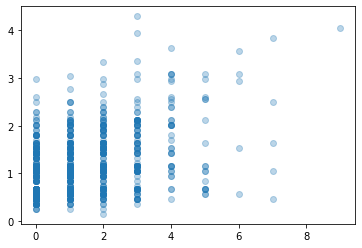

In [1232]:
fig,ax = plt.subplots()
ax.scatter(true2,pred2,alpha=.3)
fig.show()



In [1169]:
print(perc_series[0:10])
print(perc_shuffled[0:10])

print(np.diff(perc_series)[0:10])
print(np.diff(perc_shuffled)[0:10])

[1.         0.         0.33333333 0.         0.         0.5
 0.33333333 0.33333333 0.66666667 0.5       ]
[0.5        0.66666667 0.         0.5        0.         0.66666667
 0.         1.         0.         0.        ]
[-1.          0.33333333 -0.33333333  0.          0.5        -0.16666667
  0.          0.33333333 -0.16666667 -0.5       ]
[ 0.16666667 -0.66666667  0.5        -0.5         0.66666667 -0.66666667
  1.         -1.          0.          1.        ]


In [1153]:
from scipy.stats import entropy

for a in range(len(metas)):
    history_bins,_ = sliding_bin_history(sorteds[a],historys[a],metas[a],window=60)
    shuffled_bins = shuffle_indy_bins(history_bins)
    
    perc_series = get_perc_series(history_bins,metas[a])
    perc_shuffled = get_perc_series(shuffled_bins,metas[a])
    
    print(a,entropy(perc_series),entropy(perc_shuffled))

0 6.236235014343749 6.272889899382237
1 6.1725863679902355 6.256987947471668
2 6.262403258412927 6.3035069572325995
3 6.213084988283084 6.29655968144835
4 6.140731496021919 6.255537044527726
5 7.164116547845057 7.197105829270079
6 7.095790057014322 7.14436013723632
7 6.176078945162742 6.226615690455398
8 6.878025006923097 6.890924906898597
9 5.672948468402156 5.72821441983408
10 5.259139443221754 5.258256637609271
11 7.101286810421131 7.12209475729216
12 7.280654239985384 7.283770332377035
13 6.631022324950547 6.602680369083072
14 7.110979229423279 7.131327642987699
15 7.392468482673106 7.363993720898797
16 7.157743248175048 7.143638855655258
17 7.159227713747609 7.076213640721497
18 6.526508252679899 6.48605982905438


In [1155]:
print(entropy(np.random.rand(50)))
print(entropy(np.ones(50)))
print(entropy(np.sin(np.linspace(0,2*np.pi,50))))

3.6986471355265103
3.9120230054281455
-inf


In [954]:
fancy_female_scores = (corrected_array - rough_mean) / rough_std

print(corrected_array.shape)
print(corrected_array[0])
print(fancy_female_scores[0])
print(np.nansum(corrected_array,axis=1))
print(np.nanmean(fancy_female_scores,axis=1))

(48, 20)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-1.29687053 -1.29687053 -1.29687053 -1.29687053 -1.29687053 -1.29687053
 -1.29687053 -1.29687053 -1.29687053 -1.29687053 -1.29687053 -1.29687053
 -1.29687053 -1.29687053 -1.29687053 -1.29687053 -1.29687053 -1.29687053
 -1.29687053 -1.29687053]
[0. 0. 2. 2. 0. 1. 1. 1. 0. 2. 4. 3. 2. 1. 4. 4. 5. 3. 3. 1. 4. 2. 4. 1.
 0. 0. 0. 2. 3. 2. 4. 5. 5. 1. 0. 0. 3. 2. 2. 0. 2. 1. 2. 0. 1. 3. 0. 1.]
[-1.29687053 -1.29687053 -1.29574644 -1.29574644 -1.29687053 -1.29630849
 -1.29630849 -1.29630849 -1.29687053 -1.29574644 -1.29462235 -1.29518439
 -1.29574644 -1.29630849 -1.29462235 -1.29462235 -1.2940603  -1.29518439
 -1.29518439 -1.29630849 -1.29462235 -1.29574644 -1.29462235 -1.29630849
 -1.29687053 -1.29687053 -1.29687053 -1.29574644 -1.29518439 -1.29574644
 -1.29462235 -1.2940603  -1.2940603  -1.29630849 -1.29687053 -1.29687053
 -1.29518439 -1.29574644 -1.29574644 -1.29687053 -1.29574644 -1.29630849
 -1.29574644 -1.29687053 -

PH1-2006 05-11-06 09:36:10
PH2-2006 05-11-06 09:29:21
PH3-2006 05-11-06 09:18:21
PH4-2006 05-11-06 09:04:57
PH1-2007 04-24-07 09:52:38
PH2-2007 06-06-07 07:24:15
PH3-2007 06-05-07 10:37:39
PH4-2007 04-24-07 10:57:42
PH1-2008 06-06-08 10:16:21
PH2-2008 04-16-08 09:33:17
PH3-2008 04-16-08 09:19:06
PH4-2008 06-06-08 09:24:34
PH6-2010 10-06-11 09:17:57
PH7-2010 10-06-11 09:40:33
ON1-2017 28-06-17 10:03:48
ON2-2017 04-07-17 09:45:45


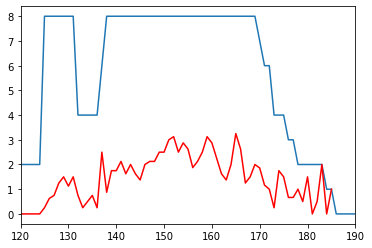

In [19]:
fig,ax = plt.subplots()
for a in range(len(all_eggs)):
    
    #ax.plot(range(366),eggs_counted_all[a] > 1,alpha=.8,label=metas[a].name,color=cm.viridis(a/16))
    print(metas[a].name,metas[a].datetime[metas[a].cutoff-1])
    
ax.plot(range(366),np.sum(~np.isnan(eggs_counted_all),axis=0))
ax.plot(range(366),mean_eggs,color='red')
ax.set_xlim(120,190)
fig.show()

In [204]:
np.unique(all_eggs[5],return_counts=True)


(array([0., 1., 2.]), array([2484,   58,    2]))

In [681]:
print(egg_scores)
#print(egg_score_arrays)

[ 0.72891555 -0.27809007  0.98921673 -0.15494454         nan -0.47567353
 -0.2098853          nan  0.07168173  0.17075532 -0.32203422 -0.01113633
  1.60011519  0.32322015  0.85269387  0.31454418  0.5700262  -0.52478012
 -0.07851085]


In [79]:
for m in metas:
    print(m.name,m.n_females)
    

PH1-2006 12
PH2-2006 13
PH3-2006 11
PH4-2006 13
PH1-2007 27
PH2-2007 15
PH3-2007 20
PH4-2007 24
PH1-2008 14
PH2-2008 16
PH3-2008 17
PH4-2008 17
PH6-2009 23
PH7-2009 12
PH8-2009 24
PH6-2010 11
PH7-2010 10
ON1-2017 21
ON2-2017 19


In [539]:
## Function that takes data, and shuffles by individual
def shuffle_indy_data(sorted_data, meta):
    singers = np.unique(sorted_data[:,0])

    shuffled_data = np.empty_like(sorted_data)
    for s in singers:
        singer_data = sorted_data[sorted_data[:,0] == s]
        shuffled_singer = np.array(singer_data)
        shuffled_singer[:,3:] = np.random.permutation(singer_data[:,3:]) ## Shuffle the time stamps, leave annotation the same
        shuffled_data[sorted_data[:,0] == s] = shuffled_singer

    indy_shuffled,indy_shuffled_meta = sort_data(shuffled_data,aviary=meta.name,date_format = meta.date_format)
    return indy_shuffled,indy_shuffled_meta

def shift_indy_data(sorted_data,meta):
    singers = np.unique(sorted_data[:,0])

    shuffled_data = np.empty_like(sorted_data)
    for s in singers:
        singer_data = sorted_data[sorted_data[:,0] == s]
        n=len(singer_data)
        random_start = np.random.randint(0,n)
        idx = np.mod(random_start + np.arange(n), n)
        shuffled_singer = np.array(singer_data)

        shuffled_singer[:,3:] = singer_data[idx,3:] ## Shift each male row randomly
        shuffled_data[sorted_data[:,0] == s] = shuffled_singer

    indy_shuffled,indy_shuffled_meta = sort_data(shuffled_data,aviary=meta.name,date_format = meta.date_format)
    return indy_shuffled,indy_shuffled_meta


m16_indy_shuffled,m16_indy_shuffled_meta = shuffle_indy_data(m16_sorted,m16_meta)
m16_indy_shifted,m16_shifted_meta = shift_indy_data(m16_sorted,m16_meta)
print(m16_sorted[0:5])
print(np.argwhere(m16_sorted == m16_indy_shifted[0]))
#print(m16_indy_shuffled[0])
print(m16_indy_shifted[0:5])

[['MBOG' '' '' '00:00:00' '23' '03-15-06' 'M1']
 ['MBOG' '' '' '00:00:00' '44' '03-15-06' 'M1']
 ['MBOG' '' '' '00:00:00' '43' '03-15-06' 'M1']
 ['ML2M' '' '' '00:00:00' '51' '03-15-06' 'M1']
 ['ML2M' 'MGNB' 'depart' '00:00:00' '38' '03-15-06' 'M1']]
[[   0    1]
 [   0    2]
 [   0    3]
 ...
 [6292    6]
 [6293    2]
 [6293    6]]
[['ML2M' '' '' '00:00:00' '51' '03-15-06' 'M1']
 ['MDMD' 'FN2D' 'depart' '00:00:00' '11' '03-15-06' 'M1']
 ['MBOG' '' '' '00:00:00' '50' '03-15-06' 'M1']
 ['MBOG' 'ML2M' '' '00:00:00' '26' '03-15-06' 'M1']
 ['MBOG' '' '' '00:00:00' '43' '03-15-06' 'M1']]


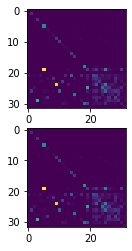

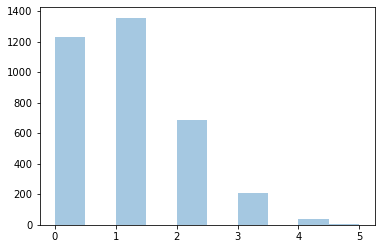

In [1477]:

history_shuffle = shuffle_indy_bins(history)
fig,(ax1,ax2) = plt.subplots(2)

ax1.imshow(np.sum(history,axis=(0)))
ax2.imshow(np.sum(history_shuffle,axis=(0)))

fig.show()

fig,ax = plt.subplots()
"""
ax.plot(np.sum(history,axis=(1,2)),alpha=.8)
ax.plot(np.sum(history_shuffle,axis=(1,2)),alpha=.4)
"""
ax.hist(np.sum(history_shuffle,axis=(1,2)),alpha=.4)
#ax.hist(np.sum(history,axis=(1,2)),alpha=.4)
fig.show()

In [541]:
## First look at distribution

## Too hard to remember this
def count_males(history_bins,n_females):
    return np.sum(history_bins[:,n_females:],axis=2) >= 1

n_females = metas[a].n_females
male_presence = count_males(history_bins,n_females)
print(np.sum(male_presence[0]))
print(shuffle_indy_bins(male_presence)[0])
print(male_presence[0])

0
[]
[]


In [92]:
###### Now on to prediction, first step, what is just the markov transition probabilities, and associated error

## Converts xyz to spherical coordinates
## For ease of intuition, I use radians / pi/2. Not sure if there's a name for that
## But it normalizes from 0-1 in the range between axes
def xyz_to_sphere(xyz): ## takes input array
    s_points = np.zeros_like(xyz)
    xy = xyz[:,0]**2 + xyz[:,1]**2
    s_points[:,0] = np.sqrt(xy + xyz[:,2]**2)
    s_points[:,2] = np.arctan2(np.sqrt(xy), xyz[:,2]) / (np.pi / 2) # for elevation angle defined from Z-axis down
    #azimuth = np.arctan2(xyz[:,2], np.sqrt(xy)) # for elevation angle defined from XY-plane up
    s_points[:,1] = np.arctan2(xyz[:,1], xyz[:,0]) / (np.pi / 2) # For xy theta
    return s_points ## Intuition here is how cohesive, male-directed, how directed

## Remember that I'm doing some normalization, so I have to correct for that. 
def sphere_to_xyz(s_coords):
    c_points = np.zeros_like(s_coords)
    r = s_coords[:,0]
    theta_r = s_coords[:,1]
    phi_r = s_coords[:,2]

    theta = theta_r * (np.pi/2)
    phi = phi_r * (np.pi/2)
    c_points[:,0] = r * np.sin(phi) * np.cos(theta),
    c_points[:,1] = r * np.sin(phi) * np.sin(theta),
    c_points[:,2] = r * np.cos(phi)
    return c_points


    ## Flatten 3d indices the way I want them to be, assumed your indices run from 0-4
def smart_flat(indices_3d):
    return indices_3d[0]*25 + indices_3d[1]*5 + indices_3d[2]

def reverse_flat(index_2d):
    phi = index_2d % 5
    index_2d -= phi
    theta = int((index_2d % 25) / 5)
    index_2d -= theta
    r = int(index_2d / 25)
    return np.array([r,theta,phi]) / 5

In [93]:
## Identify bins that I can use, based on a) number of bins to use, b) how far into the future
# First, calculate time difference between bin starts
#points,shuffled_points,[history_rate_bins,ts,window_indices] = get_points(sorteds[a],historys[a],metas[a])
def predict_future_points(points,history_bins,ts,meta,pred_window=1,bin_skips=0,window=100,classifier=LinR(),):   
    s_points,transition_count = get_transitions(points,ts)
    markov_simple,markov_shift,fancy_markov_shift = build_markov(s_points,transition_count)
    
    n_females = meta.n_females
    ## Do any desired preprocessing here
    ## Male song to males
    preproc_X = np.sum(history_bins[:,n_females:,n_females:],axis=(1,2))

    
    
    ## Song to females
    preproc_y = np.sum(history_bins[:,n_females:,n_females:],axis=(1,2))
    
    predictors,predictions = [],[]
    ## Define some parameters
    p = pred_window # Addition prediction Bins
    j = bin_skips + 1 # distance after last predictor to predict

    max_jump = 500
    drop = bin_skips + 1
    for s in range(len(s_points)-drop):
        #print(ts[s+1] - ts[s], max_jump,ts[s+1] - ts[s] > max_jump)
        if ts[s+1 + bin_skips] - ts[s] > 400 * (1+bin_skips):
            #print('skipping future',s)
            continue
        if pred_window >= 1:
            if np.abs(ts[s] - ts[s-pred_window]) > max_jump:
                #print('skipping past',s)
                #pass
                continue
        x0 = s_points[s]
        x1 = s_points[s+1]
        
        x_1 = s_points[s-1]
        
        ## Convert to indices (0-4)
        x0_i = np.round(x0*4).astype(int)
        x1_i = np.round(x1*4).astype(int)

        ## Flatten to 125 space
        x0_2d = smart_flat(x0_i).astype(int)
        x1_2d = smart_flat(x1_i).astype(int) 
        
        Ms = markov_shift[x0_2d]
        Ts = points[s] - points[s-1]
        Xs = points[s]
        Xs_1 = points[s-1]
        
        Ms_cart = sphere_to_xyz(np.array([Ms]))[0]
        Ts_cart = sphere_to_xyz(np.array([Ts]))[0]
        
        Ys = points[s+bin_skips+1,1]
        predictors.append(np.hstack([Xs,Ts]))
        predictions.append(Ys)
        #Ys = s_points[s+bin_skips+1,1]
        #predictors.append(np.hstack([Xs,Ts,Ms]))
        
        #predictions.append(Ys)

    X = np.array(predictors)
    y = np.array(predictions)  
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    #clf = LR()
    clf = classifier
    clf.fit(X_train,y_train)   

    return clf,[X_train,X_test,y_train,y_test]

def predict_future(history_bins,ts,meta,pred_window=1,bin_skips=0,window=100,
                   classifier=LinR(),x='males',y='females'):
    n_females = meta.n_females
    n_birds = meta.n_birds
    ## Do any desired preprocessing here
    ## Male song to males
    if x=='males':
        preproc_X = np.sum(history_bins[:,n_females:,n_females:],axis=(1,2))
    elif x == 'females':
        preproc_X = np.sum(history_bins[:,n_females:,:n_females],axis=(1,2))
    ## All male singing array
    #preproc_X = history_bins[:,n_females:]
    
    ## Song to females
    if y=='females':
        preproc_y = np.sum(history_bins[:,n_females:,:n_females],axis=(1,2))
    elif y=='males': ## Predict songs to males
        preproc_y = np.sum(history_bins[:,n_females:,n_females:],axis=(1,2))
    
    ## Females sung to
    #f = np.random.randint(n_females,n_birds)
    #preproc_y = np.sum(history_bins[:,n_females:,f],axis=1)
    
    predictors,predictions = [],[]
    ## Define some parameters
    p = pred_window # Addition prediction Bins
    j = bin_skips # distance after last predictor to predict
 
    
    time_diff = ts[1:] - ts[:-1]
    pred_indices = np.zeros_like(time_diff)
    ## Identify indices that work for the condition
    for i in range(len(time_diff)-p-j):
        view_window = time_diff[i:i+p+j+1]
        if max(view_window) <= window*2:
            pred_indices[i] = 1
    ## Using those indices, build X and y for classifier/regressor
    for i in range(len(time_diff)):
        if pred_indices[i] == 1:
            predictors.append(preproc_X[i:i+p].flatten())
            predictions.append(preproc_y[i+p+j].flatten())
    X = np.array(predictors)
    y = np.array(predictions)  
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    #clf = LR()
    clf = classifier
    clf.fit(X_train,y_train)
    

    return clf,[X_train,X_test,y_train,y_test]

## Test out predicting points
if False:

    a=0
    points,shuffled_points,[history_rate_bins,ts,window_indices] = get_points(sorteds[a],historys[a],metas[a])

    clf,[X_train,X_test,y_train,y_test] = predict_future_points(points,history_bins,ts,metas[a],
                                          pred_window=1,bin_skips=2,window=100,classifier=LinR())

    y_true = clf.predict(X_test)
    r,_ = pearsonr(y_true,y_test)

    print(X_train.shape)
    print(y_train.shape)
    print(r)

    print(X_train[0])
    print(y_train[0])
elif True:
    a = 0
    history_bins,[history_rate_bins,ts,window_indices]= bin_history(sorteds[a],
                                                                    historys[a],metas[a],window=100)
    clf,clf_sets = predict_future(history_bins,ts,metas[a],
                             pred_window=2,bin_skips=0,window=100,classifier=LinR())
    print(clf.score(clf_sets[1],clf_sets[3]))

0.05888679751742476


0.21494747047998744 0.15850818133471642
0.025861135092699897 -0.003870584532643373 

-0.0031899105762523846 -0.023027624670574075
0.018876092468968816 0.004598028483649867 

0.05679673940542014 0.1690340155576489
0.0360122323519019 -0.01610691967478246 

0.178267361730178 0.21367990368668813
0.0014614070851062429 0.017047299733307795 



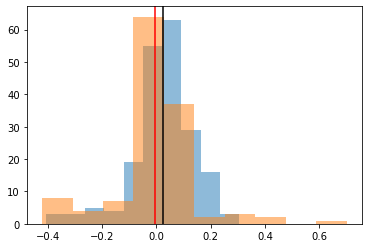

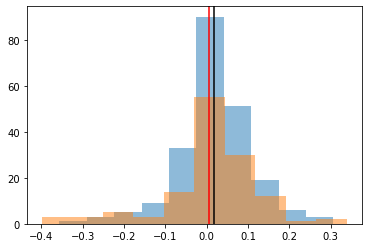

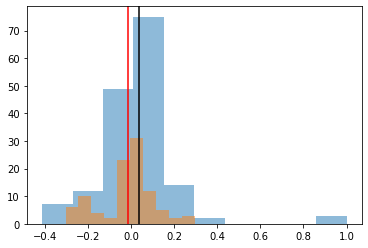

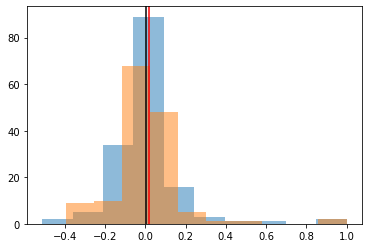

In [94]:
## Check pre vs post

win=100
for a in range(len(pre_metas)):
    iterations = 100
    rs_pre,rs_post = [],[]
    for i in range(iterations):
        history_bins_pre,[history_rate_bins,ts,window_indices] = bin_history(pre_sorteds[a],pre_historys[a],pre_metas[a],window=win)
        clf,clf_sets = predict_future(history_bins_pre,ts,pre_metas[a],
                             pred_window=1,bin_skips=-1,window=win,classifier=LinR(),
                             x='males',y='females')
        y_true_pre = clf.predict(clf_sets[1])
        r_score_pre,rp_val = pearsonr(y_true_pre.flatten(),clf_sets[3].flatten())

        rs_pre.append(r_score_pre)
        
        history_bins_post,[history_rate_bins,ts,window_indices] = bin_history(post_sorteds[a],post_historys[a],post_metas[a],window=win)
        clf,clf_sets = predict_future(history_bins_post,ts,post_metas[a],
                             pred_window=1,bin_skips=-1,window=win,classifier=LinR(),
                             x='males',y='females')
        y_true_post = clf.predict(clf_sets[1])
        r_score_post,rp_val = pearsonr(y_true_post.flatten(),clf_sets[3].flatten())    
        rs_post.append(r_score_post)
        
    print(np.mean(rs_pre),np.mean(rs_post))
    
    male_states = get_male_states(history_bins_pre,pre_metas[a])
    pre_sttc = get_sttc(male_states)[:,:,:2]
    
    male_states = get_male_states(history_bins_post,post_metas[a])
    post_sttc = get_sttc(male_states)[:,:,:2]
    
    fig,ax = plt.subplots()
    ax.hist(pre_sttc.flatten(),alpha=.5)
    ax.hist(post_sttc.flatten(),alpha=.5)
    ax.axvline(np.nanmean(pre_sttc),color='black')
    ax.axvline(np.nanmean(post_sttc),color='red')
    fig.show()
    print(np.nanmean(pre_sttc),np.nanmean(post_sttc),'\n')
    


In [95]:
for a in range(len(pre_metas)):
    print(pre_metas[a].m_ids)
    print(post_metas[a].m_ids)
    
    


['MB2M' 'MBDY' 'MBOD' 'MD2O' 'MGWD' 'MLB' 'MMLR' 'MMOL' 'MW2R' 'MWMG']
['MB2M' 'MBDY' 'MBOD' 'MGWD' 'MLB' 'MMOL' 'MW2R' 'MWMG']
['M2YL' 'MDRO' 'MGDL' 'MLNR' 'MLYR' 'MMGR' 'MMLD' 'MMWD' 'MNDO' 'MRG'
 'MRLW']
['M2YL' 'MD2O' 'MLNR' 'MMGR' 'MMLD' 'MMLR' 'MNDO' 'MRLW']
['M2M' 'MDGR' 'MDL' 'MDMG' 'MGM' 'MLY' 'MNOW' 'MON' 'MRBG']
['M2YL' 'MBDY' 'MD2O' 'MLNR' 'MMG' 'MNDO' 'MRLW']
['M2YL' 'MBDY' 'MD2O' 'MGO' 'MLNR' 'MMG' 'MNDO' 'MRLW' 'MWB']
['M2M' 'MDGR' 'MDL' 'MDMG' 'MGM' 'MLY' 'MNOW' 'MON' 'MRBG']


Aviary: PH1-2006
Mean Classifer vs random: 0.35682087575211413 -0.039692828799948704
Classifier correlation p-value 8.098650902000641e-06
T-test class vs random: 5.753535629676556 3.461252928565544e-07
Aviary: PH2-2006
Mean Classifer vs random: 0.2870562074269397 0.1080472463562042
Classifier correlation p-value 0.0004241250372054178
T-test class vs random: 3.296327701006945 0.0016751318707633061
Aviary: PH3-2006
Mean Classifer vs random: 0.41050378648976277 -0.015778893118475232
Classifier correlation p-value 5.289361619589807e-05
T-test class vs random: 5.4786321918997825 9.685736518493853e-07
Aviary: PH4-2006
Mean Classifer vs random: 0.24642008282008418 -0.026486607682522912
Classifier correlation p-value 0.023490503502966872
T-test class vs random: 5.709499801504976 4.084776355892268e-07
Aviary: PH1-2007
Mean Classifer vs random: 0.23140346696460548 -0.029114610260928667
Classifier correlation p-value 0.0015012516659025602
T-test class vs random: 5.528122428502649 8.05521830918427

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


Aviary: ON2-2017
Mean Classifer vs random: 0.2081707605818172 -0.03895458052375203
Classifier correlation p-value 0.0002521135120219361
T-test class vs random: 5.701002632070969 4.2172995961147194e-07


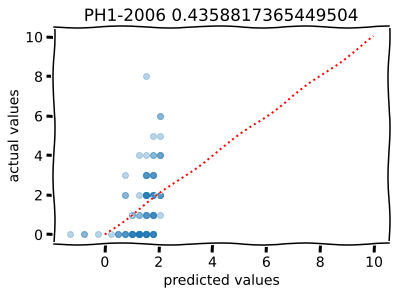

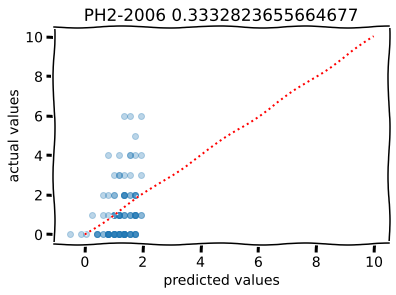

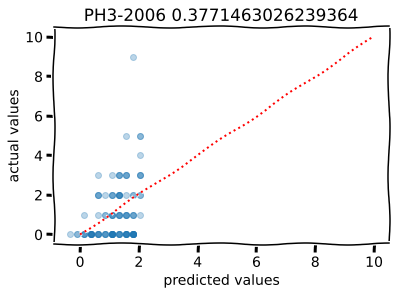

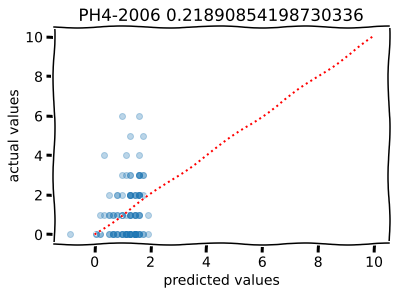

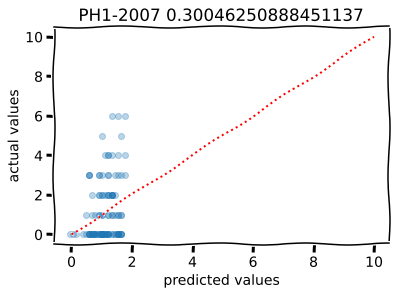

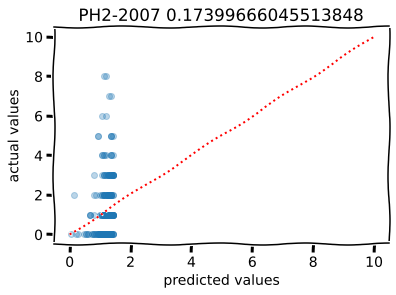

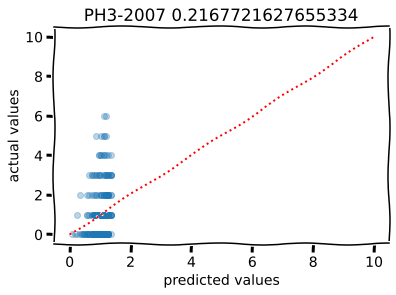

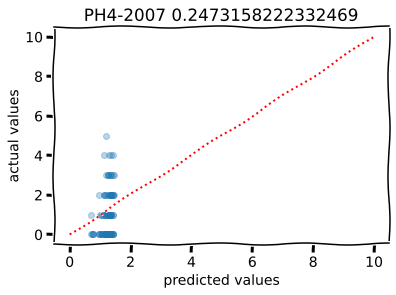

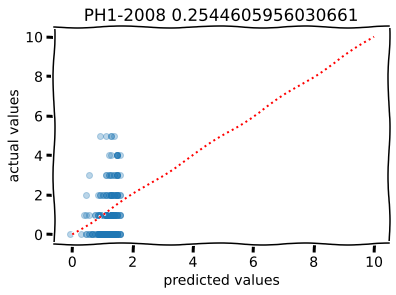

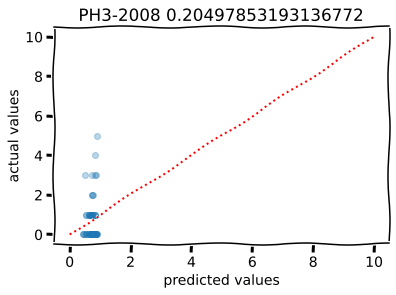

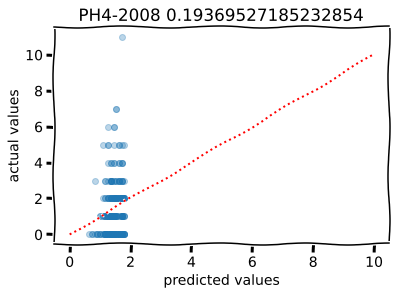

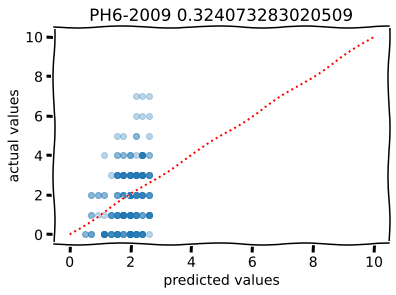

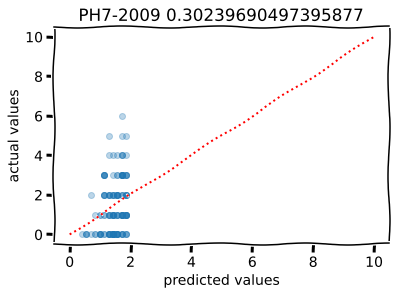

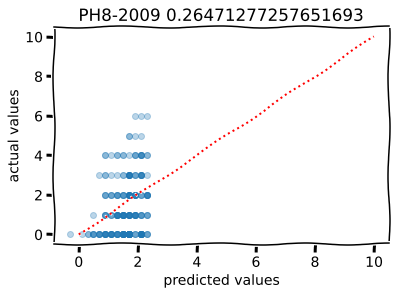

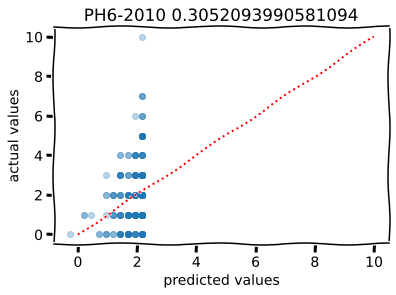

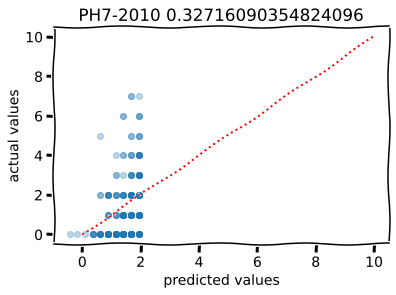

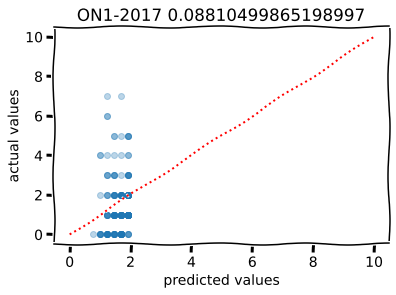

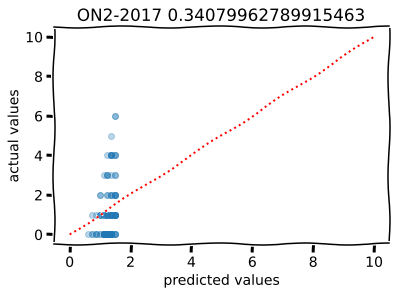

In [96]:
## Check all aviaries for predictability

m_counts, c_scores = [],[]
t_scores_pred = []
win = 60
for a in range(len(metas)):
    history_bins,[history_rate_bins,ts,window_indices]= bin_history(sorteds[a],
                                                                    historys[a],metas[a],window=win)

    """
    clf,clf_sets = predict_future(history_bins,ts,metas[a],pred_window=1,bin_skips=0,window=100)
    print(clf.score(clf_sets[1],clf_sets[3]))
    print(clf.score(clf_sets[1],np.random.permutation(clf_sets[3])))
    print(len(clf_sets[0]))
    """
    iterations = 30
    clf_scores,random_scores = [],[]
    for i in range(iterations):
        #points,shuffled_points,[history_rate_bins,ts,window_indices] = get_points(sorteds[a],historys[a],metas[a])
        #clf,clf_sets = predict_future_points(points,history_bins,ts,metas[a],
        #                              pred_window=1,bin_skips=2,window=100,classifier=LinR())        
        
        clf,clf_sets = predict_future(history_bins,ts,metas[a],
                                     pred_window=1,bin_skips=-1,window=win,classifier=LinR(),
                                     x='males',y='females')
        
        
        y_true = clf.predict(clf_sets[1])
        r_score,rp_val = pearsonr(y_true.flatten(),clf_sets[3].flatten())
        score = clf.score(clf_sets[1],clf_sets[3])
        
        ## Refit with shuffled labels
        clf.fit(clf_sets[0],np.random.permutation(clf_sets[2]))
        y_shuffle = clf.predict(clf_sets[1])
        random_score = clf.score(clf_sets[1],clf_sets[3])
        random_r_score,_ = pearsonr(y_shuffle.flatten(),clf_sets[3].flatten())
        
        clf_scores.append(r_score)
        random_scores.append(random_r_score)

    if True:
        with plt.xkcd():
            fig,ax = plt.subplots()
            ax.scatter(y_true,clf_sets[3],alpha=.3)
            #ax.scatter(y_shuffle,clf_sets[3],alpha=.2)
            #ax.scatter(clf_sets[1][:,1],clf_sets[3],alpha=.2)
            ax.set_xlabel('predicted values')
            ax.set_ylabel('actual values')
            ax.plot([0,10],[0,10],color='red',linestyle=':')
            ax.set_title(metas[a].name + ' ' + str(r_score))
            fig.show()
    print('Aviary:',metas[a].name)
    print('Mean Classifer vs random:',np.nanmean(clf_scores),np.nanmean(random_scores))
    print('Classifier correlation p-value',rp_val)
    #print(len(clf_sets[0]),metas[a].n_males,metas[a].n_females)
    #print(clf_scores,random_scores)
    t_stat,p_val = ttest_ind(clf_scores,random_scores,nan_policy='omit')
    t_scores_pred.append(t_stat)
    m_counts.append(metas[a].n_males)
    c_scores.append(np.nanmean(clf_scores))
    print('T-test class vs random:',t_stat,p_val)
# I.e. find a bin that is followed by at least two bins (give me a bunch of indices i)
## Two bins here is specific to the two->1 case, if it's two->predict in two steps, I need 3
### The general case is i : i+n_predictors + n_skips need to be in same window (i.e. no gaps >bin size)
# Grap the pairs of bins (that's just i:i+1), maybe do some pre-processing here, even heuristics
# Grap the bins to be predicted (thats i+2)

In [97]:
### Eep, 2 scary observations
## 1. c_scores is probably negatively correlated with n_males
## 2. c_scores varies enough that this p_value varies between .01 and .1, that looks bad down below...
## 3. Might be worth revisiting these metrics. 

print(pearsonr(m_counts,c_scores))

print(len(c_scores),np.round(c_scores,3))

(-0.2509952138662341, 0.2999691551125169)
19 [0.357 0.287 0.411 0.246 0.231 0.149 0.19  0.116 0.194 0.107 0.114 0.185
 0.277 0.247 0.279 0.241 0.305 0.181 0.208]


# So far, this is promising

In the first four aviaries checked, egg count almost perfectly correlates with predictability. 

I want to take a step back though and look at 
- Egg number over the course of the season
- Predictability over the course of the season

- Predictability as a function of bird number

To make sure we're not just getting a spurious correlation. 

In [26]:
print(egg_scores)

[0.7980507410031771, -0.2521597477187143, 1.069519952732375, -0.12373074546441892, nan, -0.4402390191303024, -0.10494211341103643, nan, 0.12668713704632376, nan, nan, 0.040527509466252276, 1.7204135460256467, 0.39916161254560373, 0.9409246441608231, 0.39113890036334803, 0.6575821919757493, -0.48892827146115025, -0.024184286919879134]


## Observations from above so far: 
1. Ratio of songs to females probably predicts cohesion (good, would be a lot better if significant...)
2. Proprotion of males also singing to females predicts cohesion (good) but this persists with shuffling (bad) 
3. Overall proportion of simultaneous singing (any) doesn't predict egg production (interesting)
4. Correlating song itself (as 1s or 0s) doesn't predict anything (a bit weird, given prior stuff). But that does sort of point to cohesion rather than just overall activity. On the other hand, even if you just look at female songs (as 1s or 0s) you get no result, so it might just be a bad approach.

My sttc code could probably be adapted to work on 2, which should be robust to shuffling, but who knows, I think it's actually not as good with shuffling as it should be in this scenario. 

All in all, it seems like there is a level of cohesion outside of just activity or female song, and this is a good way to show it, although the fragility of the result at win=60s is pretty crappy. That said, the arbitrary acceptance of p values is pretty crappy. I didn't make the rules. I do think I should get a sliding bin window, which should help smooth some of this, although it will always be subject to the specific value, especially where are p-values are so marginal. 

I think the next steps need to be
 1. Get a sliding window (Check)
 2. Trying out these metrics with mixed models (and then send it to Luke) 
 3. Try David's new data stuff
 4. Build pretty figures
 
 ## Follow up: 
 With a sliding window, things actually improved, the result is not nearly as fragile, and I feel more confident that it's real, and that we could publish it. %Song to females also gets at the original observed effect and is a lot easier to explain, so I feel good about it. 
 The next steps are probably
 1. Make a new Figure 1 with this metric (with all the aviaries, random distirubtions, the works) 
 2. See how it fairs in the mixed effect models. They are less important now, but it would be good for them to hold. 
 3. Make pretty figures. 
 
 ### Note: 
 Obviously % to females and % to males are inversely correlated, but I think % to females is a reasonable argument here, as we see (from singing ratio) that the proportion of overlapping songs to females predicts egg production, while the proportion of overlapping songs to males does not. 
 
 Weirdly, however, this metric (proprotion of songs to males) does seem to predict individual egg production...
 I need to check this however. 

152 152
(0.7790537224660017, 3.202234574035404e-32)


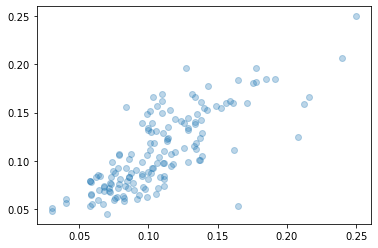

In [829]:
xs,ys = [],[]
xs2,ys2 = [],[]
for a in range(len(metas)):
    win = 60
    corr_matrix = correlate_fsongs(historys[a],metas[a],sorteds[a],window=win,prune=True,shuffle=False)
    corr_shuffled = correlate_fsongs(historys[a],metas[a],sorteds[a],window=win,prune=True,shuffle=True)
    rcorr_matrix = ratio_singing(historys[a],metas[a],sorteds[a],window=win,prune=True,shuffle=False)
    rcorr_shuffled = ratio_singing(historys[a],metas[a],sorteds[a],window=win,prune=True,shuffle=True)
    if False:
        xs.extend(rcorr_matrix[~np.isnan(rcorr_matrix)].flatten())
        ys.extend(rcorr_shuffled[~np.isnan(rcorr_matrix)].flatten())
        xs2.extend(np.nanmedian(corr_matrix,1))
        ys2.extend(np.nanmedian(corr_shuffled,1))
    elif True:
        xs.extend(np.nanmean(rcorr_matrix,1))
        ys.extend(np.nanmean(rcorr_shuffled,1))
        xs2.extend(np.nanmean(corr_matrix,1))
        ys2.extend(np.nanmean(corr_shuffled,1))
    else:
        xs.append(np.nanmean(rcorr_matrix))
        ys.append(np.nanmean(rcorr_shuffled))
        xs2.append(np.nanmean(corr_matrix))
        ys2.append(np.nanmean(corr_shuffled))

#print(pearsonr(xs2,ys2))

xs,ys = np.array(xs),np.array(ys)
if False:
    print(np.sum((xs == 0) & (ys == 0)))
    print(np.sum((xs == 1) & (ys == 1)))
    print(xs.shape,ys.shape)
    one_dots = [xs != 1,ys != 1]

    print(one_dots)
    print(np.all(one_dots))
    xs = xs[np.all(one_dots,0)]
    ys = ys[np.all(one_dots,0)]

    zero_dots = [xs != 0,ys != 0]
    xs = xs[np.all(zero_dots,0)]
    ys = ys[np.all(zero_dots,0)]

if False:
    ys = xs[ys > .2]
    xs = xs[ys > .2]

print(len(xs),len(ys))
print(pearsonr(xs,ys))
fig,ax = plt.subplots()
ax.scatter(xs,ys,alpha=.3)
#ax.scatter(xs2,ys2)
fig.show()

In [86]:
## Plot the distribution and ttest of cohesion
norm_scores,p_scores = [],[]
norm_scores_shuffled = []
t_scores_cohesion = []
all_dists, all_shuffle_dists = [],[]
coh_aves,no_aves = [],[]
for a in range(len(historys)):

    history_bins,[history_rate_bins,ts,window_indices]= bin_history(sorteds[a],historys[a],metas[a],window=100)
    #shuffled_bins = shuffle_indy_bins(history_bins)
    shuffled_bins = shift_indy_bins(history_bins)

    male_states = get_male_states(history_bins,metas[a])
    shuffle_states = get_male_states(shuffled_bins,metas[a])

    male_dists = np.linalg.norm(np.mean(male_states,axis=(1)),axis=1) #np.sum(male_states,axis=(1,2))
    shuffle_dists = np.linalg.norm(np.mean(shuffle_states,axis=(1)),axis=1) #np.sum(shuffle_states,axis=(1,2))

    all_dists.append(male_dists)
    all_shuffle_dists.append(shuffle_dists)
    print(male_states.shape)
    if False:
        fig,ax = plt.subplots()


        ax.hist(male_dists,alpha=.5)
        ax.hist(shuffle_dists,alpha=.5)

        fig.show()

    t_stat,p_val = ttest_ind(male_dists,shuffle_dists)
    print(t_stat,p_val)
    mean_dist = np.mean(male_dists)
    mean_dist_shfl = np.mean(shuffle_dists)
    print(mean_dist)
    norm_scores.append(mean_dist)
    norm_scores_shuffled.append(mean_dist_shfl)
    t_scores_cohesion.append(t_stat)
    p_scores.append(1/p_val)
    if t_stat > 0 and p_val < .05:
        coh_aves.append(a)
    else:
        no_aves.append(a)
    
    """
    points = np.mean(male_states,axis=1)
    print(points.shape)
    points = np.vstack([points,np.array([0,0,0])])
    shuffle_points = np.mean(shuffle_states,axis=1)
    shuffle_points = np.vstack([shuffle_points,np.array([0,0,0])])

    ## Might be too mathy, but I think I really want the volume of the convex hull, so let me see what that does
    print(convex_hull_volume_bis(points),convex_hull_volume_bis(shuffle_points))"""
    pass

(390, 5, 3)
2.4356145168074463 0.015090069071961528
0.4451449618937597
(406, 14, 3)
2.7272114670188228 0.006525372189353892
0.24722953600478684
(402, 6, 3)
3.6368871759894197 0.00029358335803070413
0.4648655584409826
(401, 16, 3)
2.407502748348904 0.01628749893033431
0.25519202847837624
(410, 10, 3)
2.185802793248282 0.02911288836555301
0.3847385252582978
(1040, 8, 3)
2.6653536624650407 0.007750276998133158
0.34691118858275005
(1053, 8, 3)
2.708701933972838 0.006809423126244739
0.36874830135871894
(393, 11, 3)
1.5467443103252347 0.12232845675897096
0.2839038873178392
(786, 10, 3)
2.4243665707144237 0.015447391217768242
0.3213670255824772
(208, 9, 3)
1.423870772783461 0.15523711923435501
0.3638699028560391
(195, 9, 3)
1.461741513393323 0.1446214699820577
0.3495137670169229
(809, 11, 3)
2.0763977787254944 0.03801491088767128
0.333526480405707
(799, 10, 3)
1.2618439257274512 0.20718932869332468
0.3408962213679195
(504, 8, 3)
0.9868026425256552 0.32397667322925594
0.33968531656536755
(797,

In [87]:
coh_scores = [egg_scores[a] for a in coh_aves]
noh_scores = [egg_scores[a] for a in no_aves]

coh_scores = np.array(coh_scores)
noh_scores = np.array(noh_scores)
coh_scores = coh_scores[~np.isnan(coh_scores)]
noh_scores = noh_scores[~np.isnan(noh_scores)]
print(ttest_ind(coh_scores,noh_scores))

Ttest_indResult(statistic=-0.9037371085510185, pvalue=0.38257650983665203)


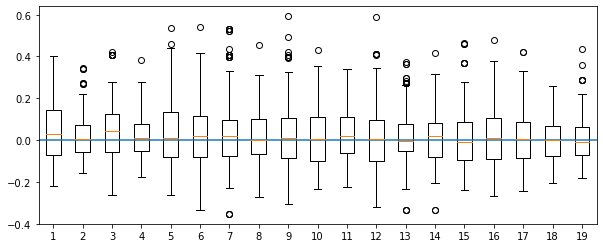

In [88]:
normed_dists = [all_dists[a] - np.mean(all_shuffle_dists[a]) for a in range(len(all_dists))]
if True:
    fig,ax = plt.subplots()
    #ax.boxplot(all_shuffle_dists,positions=np.arange(1,20) + .25)
    ax.boxplot(normed_dists)
    ax.axhline(0)
    
    fig.set_size_inches(10,4)
    fig.show()

PH1-2006
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]), array([111177,   1016,    287,    107,     53,     27,     23,      6,
            8,      4,      1,      1]))
(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]), array([111177,   1016,    287,    107,     53,     27,     23,      6,
            8,      4,      1,      1]))
(390, 5, 3)
(390, 17, 17)
[370. 396. 349.]
[370. 396. 349.]
PH2-2006
(array([0., 1., 2., 3., 4., 5., 6., 7., 8.]), array([293561,   1829,    409,    118,     33,     15,      4,      4,
            1]))
(array([0., 1., 2., 3., 4., 5., 6., 7., 8.]), array([293561,   1829,    409,    118,     33,     15,      4,      4,
            1]))
(406, 14, 3)
(406, 27, 27)
[907. 476. 497.]
[907. 476. 497.]
PH3-2006
(array([0., 1., 2., 3., 4., 5., 6., 7., 8.]), array([113874,   1629,    441,    142,     50,     30,      4,      4,
            4]))
(array([0., 1., 2., 3., 4., 5., 6., 7., 8.]), array([113874,   1629,    441,    142,  

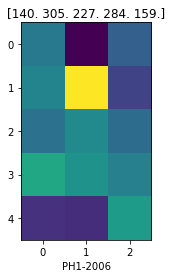

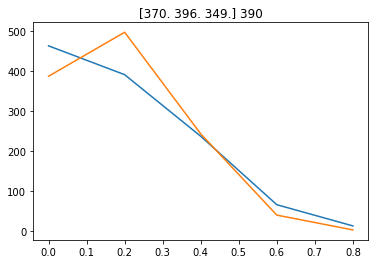

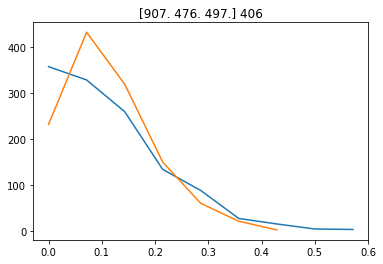

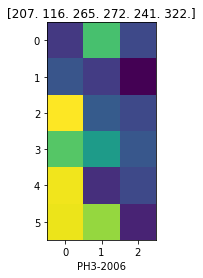

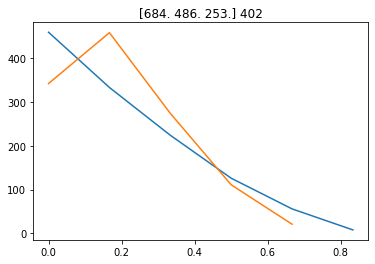

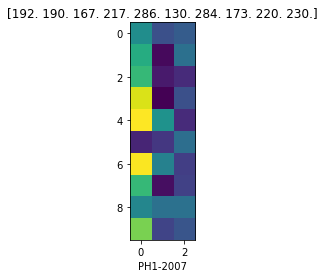

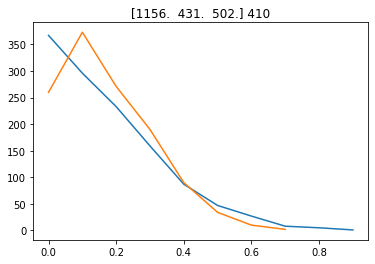

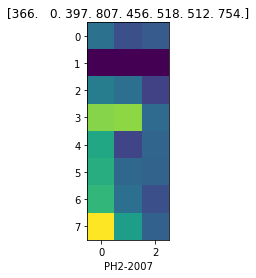

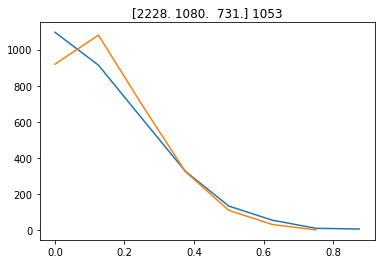

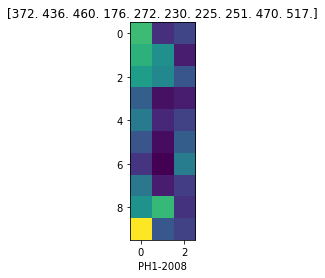

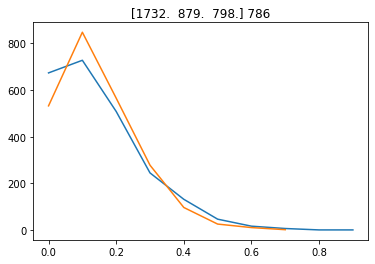

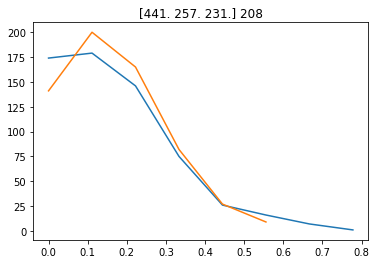

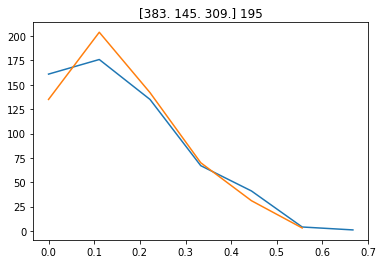

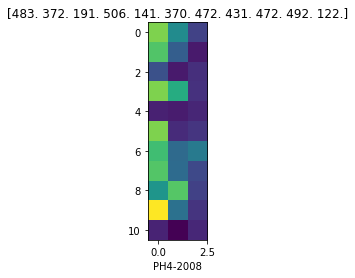

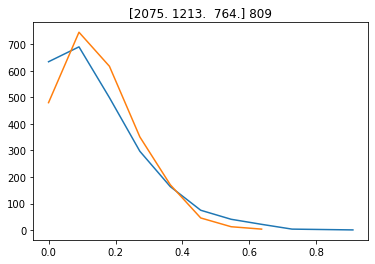

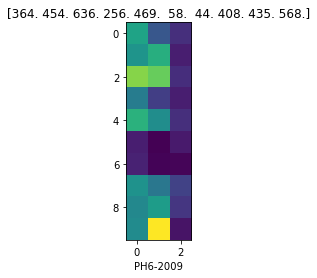

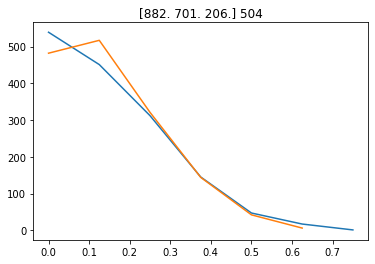

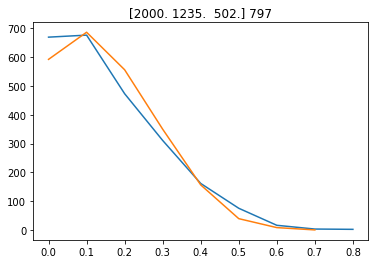

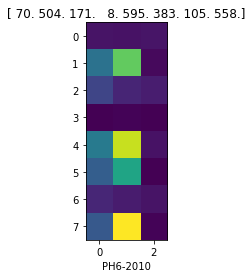

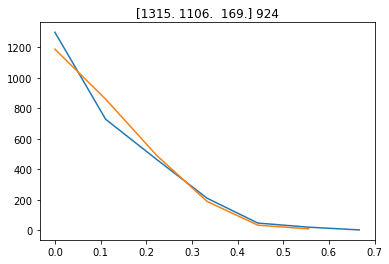

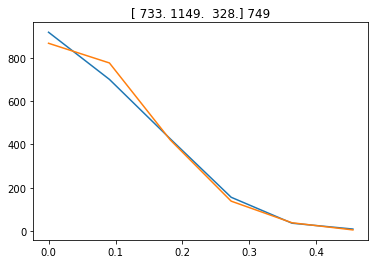

In [89]:
for a in range(len(metas)):
    print(metas[a].name)
    history_bins,[history_rate_bins,ts,window_indices]= bin_history(sorteds[a],historys[a],metas[a],window=100)
    n_males = metas[a].n_males
    shuffled_bins = shuffle_indy_bins(history_bins)

    male_states = get_male_states(history_bins,metas[a])
    shuffle_states = get_male_states(shuffled_bins,metas[a])

    if False:
        fig,(ax,ax2) = plt.subplots(2)

        ax.scatter(range(len(history_bins)),np.sum(history_bins,axis=(1,2)),alpha=.5)
        ax2.scatter(range(len(history_bins)),np.sum(shuffled_bins,axis=(1,2)),alpha=.5)
        fig.show()
    if True:
        fig,ax = plt.subplots()
        ax.imshow(np.sum(male_states,axis=(0)))
        ax.set_title(np.sum(male_states,axis=(0,2)))
        ax.set_xlabel(metas[a].name)
        fig.show()
    print(np.unique(history_bins,return_counts=True))
    print(np.unique(shuffled_bins,return_counts=True))

    print(male_states.shape)
    print(history_bins.shape)
    print(np.sum(male_states,axis=(0,1)))
    print(np.sum(shuffle_states,axis=(0,1)))
    state_vals,state_counts = np.unique(np.sum(male_states,axis=(1)),return_counts=True)
    shuffle_vals,shuffle_counts =  np.unique(np.sum(shuffle_states,axis=(1)),return_counts=True)
    
    fig,ax1 = plt.subplots()
    ax1.plot(state_vals / n_males,state_counts)
    ax1.plot(shuffle_vals / n_males,shuffle_counts)
    ax1.set_title(str(np.sum(male_states,axis=(0,1))) + ' ' + str(len(male_states)))
    fig.show()

test aviaries
(0.9424562921259634, 0.05754370787403662)
(0.9935496636049991, 0.006450336395000922)
(0.6046195138775069, 0.3953804861224931)

Blind Aviaries
(0.8422239077325268, 0.001141541746511977)
(0.26592047403633745, 0.4293173598679028)
(-0.38184556984637813, 0.2465228433910475)
all aviaries
(0.6895374814029662, 0.004453263823165666)
(0.5229579571796196, 0.045470103064542196)
(-0.04381219146733141, 0.8767928180642603)

(0.4556084970404051, 0.1590468193481334)
(0.7741957025832054, 0.0051589623847062855)


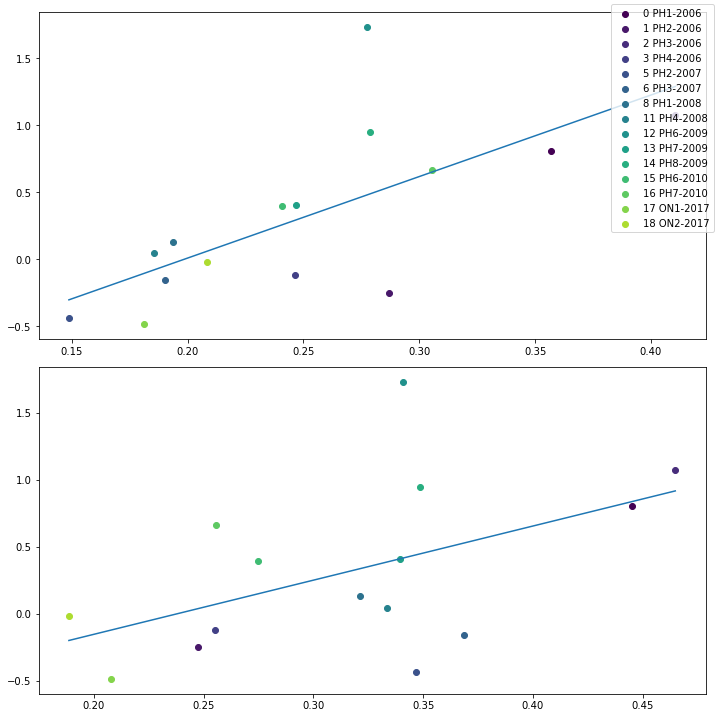

In [100]:
## Do the test!!
egg_scores = np.array(egg_scores)
fancy_egg_scores = np.array(fancy_egg_scores)
n_participant_array = np.array(n_participant_list)
participant_ratios = np.array(participant_ratios)

c_scores = np.array(c_scores)

norm_scores = np.array(norm_scores)
norm_scores_shuffled = np.array(norm_scores_shuffled)
p_scores = np.array(p_scores) ## This is cohesion still
t_scores_pred = np.array(t_scores_pred)
t_scores_cohesion = np.array(t_scores_cohesion)

clean_t_pred = t_scores_pred[~np.isnan(egg_scores)]
clean_t_coh = t_scores_cohesion[~np.isnan(egg_scores)]

clean_norm = norm_scores[~np.isnan(egg_scores)]
clean_norm_shuffled = norm_scores_shuffled[~np.isnan(egg_scores)]
clean_p = p_scores[~np.isnan(egg_scores)]
clean_c = c_scores[~np.isnan(egg_scores)]
clean_eggs = egg_scores[~np.isnan(egg_scores)]
clean_fancy_eggs = fancy_egg_scores[~np.isnan(egg_scores)]
clean_participant_array = n_participant_array[~np.isnan(egg_scores)]
clean_participant_ratios = participant_ratios[~np.isnan(egg_scores)]
print('test aviaries')


print(pearsonr(clean_c[:4],clean_eggs[:4]))
print(pearsonr(clean_norm[:4],clean_eggs[:4]))
print(pearsonr(np.log(clean_p[:4]),clean_eggs[:4]))
print('')
#print(pearsonr(t_scores_pred[:4],clean_eggs[:4]))
#print(pearsonr(t_scores_cohesion[:4],clean_eggs[:4]))

print('Blind Aviaries')

print(pearsonr(clean_c[4:],clean_eggs[4:]))
print(pearsonr(clean_norm[4:],clean_eggs[4:]))
print(pearsonr(np.log(clean_p[4:]),clean_eggs[4:]))

print('all aviaries')

print(pearsonr(clean_c[:17],clean_eggs[:17]))
print(pearsonr(clean_norm_shuffled,clean_eggs))
print(pearsonr(np.log(clean_p),clean_eggs))
print('')
print(pearsonr(clean_c[4:],clean_fancy_eggs[4:]))
#print(pearsonr(clean_c[4:],clean_participant_array[4:]))
print(pearsonr(clean_c[4:],clean_participant_ratios[4:]))

#print(pearsonr(clean_t_pred,clean_eggs))
#print(pearsonr(clean_t_coh,clean_eggs))

fig,(ax,ax1) = plt.subplots(2)
a_shift = 0
for i in range(len(metas)):
    #"""    
    if i in [4,7,9,10]:
        a_shift += 1
        continue
    #"""
    a = i - a_shift
    
    ax.scatter(clean_c[a],clean_eggs[a],color=cm.viridis(a/16))
    
    ax1.scatter(clean_norm[a],clean_eggs[a],label=str(i) + ' ' + metas[i].name,color=cm.viridis(a/16))

fit_line = np.poly1d(np.polyfit(clean_c,clean_eggs,1))
ax.plot([min(clean_c),max(clean_c)],fit_line([min(clean_c),max(clean_c)]))

fit_line1 = np.poly1d(np.polyfit(clean_norm,clean_eggs,1))
ax1.plot([min(clean_norm),max(clean_norm)],fit_line1([min(clean_norm),max(clean_norm)]))

fig.legend()
fig.set_size_inches(10,10)
fig.tight_layout()

fig.show()

In [559]:
fig,ax = plt.subplots()
ax.scatter(clean_c[4:],clean_participant_ratios[4:])
ax.scatter(clean_c[4:],clean_fancy_eggs[4:])
fig.show()

(3523, 32, 32)
[0.5, 0.15384615384615385, 0.09090909090909091, 0.38461538461538464, 0.48148148148148145, 0.0, 0.1, 0.4583333333333333, 0.07142857142857142, 0.0, 0.1, 0.0, 0.0, 0.08333333333333333, 0.07692307692307693, 0.09090909090909091, 0.0, 0.047619047619047616, 0.3157894736842105]
[12, 13, 11, 13, 27, 15, 20, 24, 14, 9, 10, 17, 13, 12, 13, 11, 10, 21, 19]
[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 2, 0, 0, 0, 1, 1, 2, 3, 2]
participation and neglected females: (0.5071828038044695, 0.05364169537437681)
(0.31843902954288944, 0.2473774938892681)


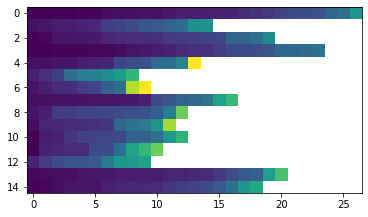

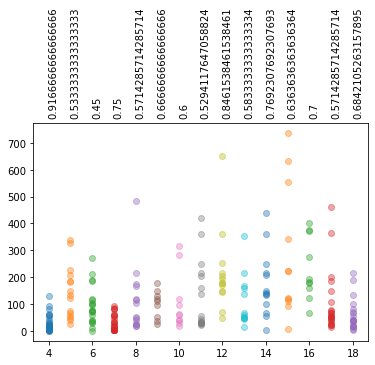

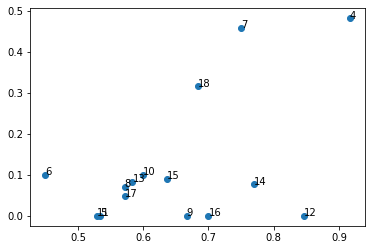

In [611]:
## So cohesion and participation are correlated, and that is likely a big driver of egg output

## Is this just an artifact then? What does female participation in courtship look like? 
print(history.shape)
f_counts = []
poor_unfortunate_souls = []
losers = []
f_song_array = np.empty([len(metas),max_females])
f_song_array.fill(np.nan)

for a in range(len(metas)):
    history = historys[a]
    n_females = metas[a].n_females
    f_counts.append(n_females)
    f_sums = np.nansum(history[:,n_females:,:n_females],axis=(0,1))
    m_sums = np.nansum(history[:,n_females:,:],axis=(0,2))
    poor_unfortunate_souls.append(np.sum(f_sums < 20) / len(f_sums))
    losers.append(np.sum(m_sums < 50))
    f_song_array[a,:len(f_sums)] = sorted(f_sums) / np.sum(f_sums)

max_females = np.max(f_counts)

fig,ax = plt.subplots()
ax.imshow(f_song_array[4:])
fig.show()
#print(np.round(f_song_array,3))

fig,ax = plt.subplots()

for a in range(4,len(metas)):
    n_females = metas[a].n_females
    #print(np.nansum(history[:,n_females:,:n_females],axis=(0,1)))
    #print(np.nansum(history[:,n_females:,:n_females],axis=(0,1)).shape)
    #print(metas[a].n_females)
    ax.scatter([a]*metas[a].n_females,np.nansum(historys[a][:,n_females:,:n_females],axis=(0,1)),alpha=.4)
    ax.text(a,800,str(participant_ratios[a]),rotation=90)
fig.show()

print(poor_unfortunate_souls)
print(f_counts)
print(losers)

## This is the correlation between ratio of females laying eggs, and the 
print('participation and neglected females:',pearsonr(participant_ratios[4:],poor_unfortunate_souls[4:]))

fig,ax = plt.subplots()
ax.scatter(participant_ratios[4:],poor_unfortunate_souls[4:])
for i in range(4,len(participant_ratios)):
    ax.text(participant_ratios[i],poor_unfortunate_souls[i],str(i))
fig.show()

print(pearsonr(participant_ratios[4:],c_scores[4:]))

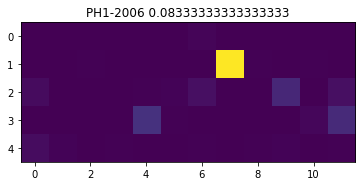

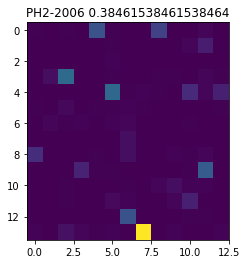

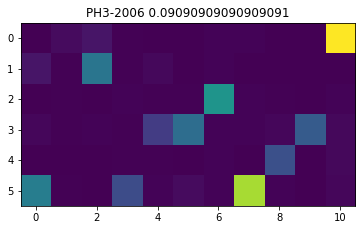

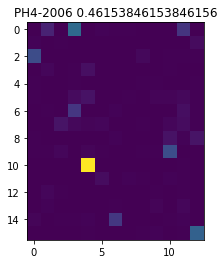

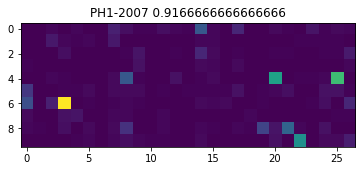

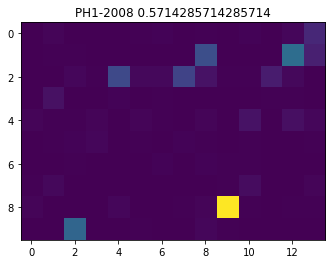

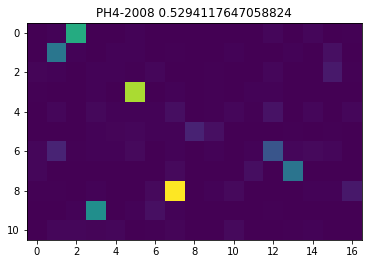

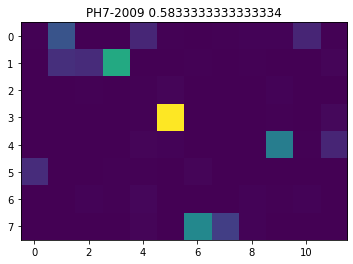

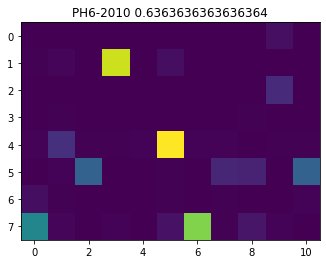

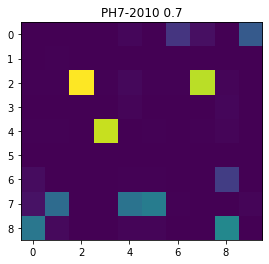

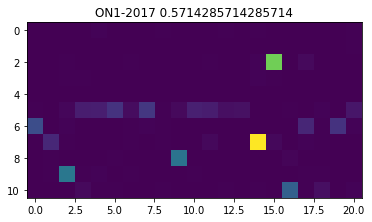

In [591]:
for a in range(len(metas)):
    fig,ax = plt.subplots()
    n_females = metas[a].n_females
    ax.imshow(np.sum(historys[a][:,n_females:,:n_females],axis=0))
    ax.set_title(metas[a].name + ' ' + str(participant_ratios[a]))
    fig.show()

In [338]:
## Shifted Aviaries

bad_norms,bad_cs = [],[]
good_norms,good_cs = [],[]

for a in [4,7,9,10]:
    print(clean_norm[a],clean_c[a],egg_scores[a])
    bad_norms.append(clean_norm[a])
    bad_cs.append(clean_c[a])
## Not shifted aviaries
for a in [8,11,5,6]:
    print(clean_norm[a],clean_c[a],egg_scores[a])
    good_norms.append(clean_norm[a])
    good_cs.append(clean_c[a])
    
print(ttest_ind(good_norms,bad_norms))
print(ttest_ind(good_cs,bad_cs))

0.3459439398566985 0.24271237098905665 0.6546922590842064
0.34436871149213166 0.1229757653204623 0.1062951132033731
0.31592369031360173 0.18578152536564152 0.10165239536866129
0.3420000938703352 0.32027144755517833 -0.20038783080266312
0.3213670255824772 0.20107101090624782 -0.08873816356780904
0.333526480405707 0.16677537675478663 -0.16722153477040466
0.34691118858275005 0.14979153709339546 -0.5672171382555072
0.36874830135871894 0.1711987885732573 -0.3272207266609183
Ttest_indResult(statistic=0.45068213789890005, pvalue=0.6680470202131777)
Ttest_indResult(statistic=-1.0559081733657432, pvalue=0.331660170842911)


In [98]:
## What about boring things? 
# N songs
# N songs to females
# N songs to males
m_song_counts = []
f_song_counts = []
tot_song_counts = []

a_shift = 0
for i in range(len(metas)):
    if i in [4,7,9,10]:
        a_shift += 1
        continue
    a = i - a_shift
    history = historys[a]
    n_males = metas[a].n_males
    n_females = metas[a].n_females
    tot_m_song = np.sum(history[:,n_females:,n_females:])
    tot_f_song = np.sum(history[:,n_females:,:n_females])
    tot_song = np.sum(history[:,n_females:])
    rat_m_song = tot_m_song / n_males
    rat_f_song = tot_f_song / n_males
    rat_song = tot_song / n_males
    
    if False:
        m_song_counts.append(tot_m_song)
        f_song_counts.append(tot_f_song)
        tot_song_counts.append(tot_song)
    else:
        m_song_counts.append(rat_m_song)
        f_song_counts.append(rat_f_song)
        tot_song_counts.append(rat_song)       
    

print(pearsonr(m_song_counts,clean_eggs))
print(pearsonr(f_song_counts,clean_eggs))
print(pearsonr(tot_song_counts,clean_eggs))

## should check countersinging as well for comparison




(0.06052764972816488, 0.8303282376413054)
(0.2055031872937171, 0.4624854333735284)
(0.0961978713894677, 0.7330713850973882)


# Even More Old Stuff: 

## The above figure works

I'll need to add boxplots, but it's really not bad. 
It looks a lot cleaner with "prune" and I think that's how we should present it. That means that we're excluding a handful of males (how many) but it makes for a much prettier figure, and I think it's the right aproach. 

Now to take 'all_corrs' and use that to calculate new measures of cohesion for the database and mixed model

So: It doesn't seem to predict individual female success, r_corr (presumably) should. What is the story then? 
Overall mean correlation predicts egg production, however as an individual metric, this is iffy because it is going to be pulled by individual scores. A better metric could be the r_corr, i.e. the proportion of males that sing the same way as you are in a given bin. This is the "perceived cohesion". This is going to be biased by overall ativity, but I can just control for that with the mixed model. This also lets me control for egg score, so I can just use egg numbers.

This would be more convincing if it were a single metric.

### What is the relationship between r_corr and r_corr(shuffled)? 

PH1-2006 2923 ['MBOG' 'MDMD' 'MGBG' 'MGNB' 'ML2M']
PH2-2006 3651 ['M2YL' 'MG2N' 'MGM' 'MLNR' 'MLY' 'MLYR' 'MMWM' 'MO2G' 'MR2M' 'MRG' 'MRGL'
 'MRLG' 'MWNL' 'MYRM']
PH3-2006 3762 ['MDML' 'MDOD' 'MDRD' 'MLNL' 'MRDR' 'MWRG']
PH4-2006 4260 ['MB2M' 'MBDY' 'MBWD' 'MGBD' 'MGMB' 'MLB' 'MLNG' 'MMD' 'MMOL' 'MN2W'
 'MNGO' 'MNR' 'MNRB' 'MW2R' 'MWLG' 'MYLO']
PH1-2007 4747 ['MB2M' 'MBDY' 'MBOD' 'MD2O' 'MGWD' 'MLB' 'MMLR' 'MMOL' 'MW2R' 'MWMG']
PH2-2007 10676 ['MBWD' 'MBWO' 'MDBR' 'MGRG' 'MMD' 'MN2W' 'MNGO' 'MYLO']
PH3-2007 10186 ['MDGR' 'MDMG' 'MGM' 'MLY' 'MNOW' 'MRBG' 'MROD' 'MYRM']
PH4-2007 4367 ['M2YL' 'MDRO' 'MGDL' 'MLNR' 'MLYR' 'MMGR' 'MMLD' 'MMWD' 'MNDO' 'MRG'
 'MRLW']
PH1-2008 7952 ['MBWD' 'MDBR' 'MGRG' 'MLO' 'MM2D' 'MMD' 'MMWD' 'MN2W' 'MWG' 'MYLO']
PH2-2008 6869 ['M2YL' 'MBDY' 'MD2O' 'MLNR' 'MMG' 'MNDO' 'MRLW']
PH3-2008 7929 ['M2M' 'MDGR' 'MDL' 'MDMG' 'MGM' 'MLY' 'MNOW' 'MON' 'MRBG']
PH4-2008 8968 ['MB2M' 'MBOD' 'MGD' 'MGWD' 'MLB' 'MMOL' 'MND' 'MO' 'MW2R' 'MWMG' 'MWRO']
PH6-2009 8103 ['MBWD' '

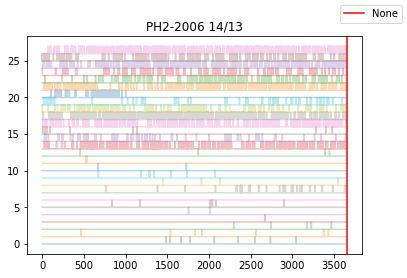

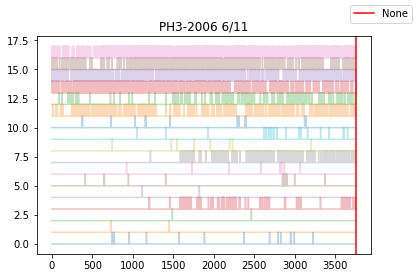

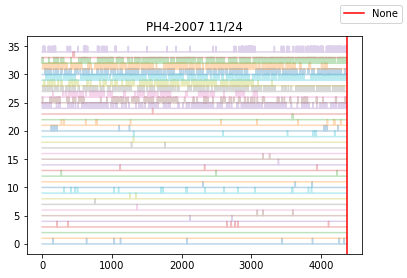

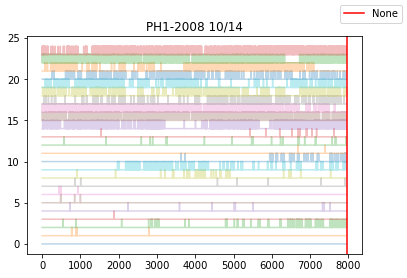

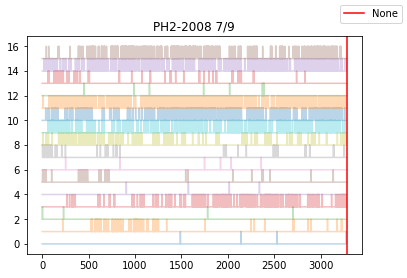

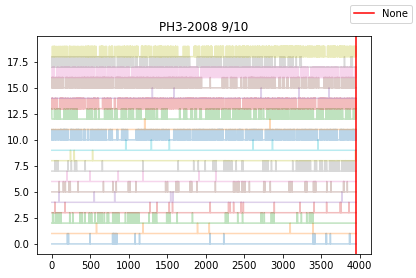

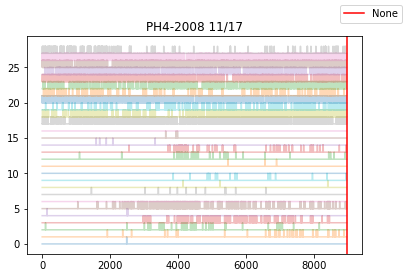

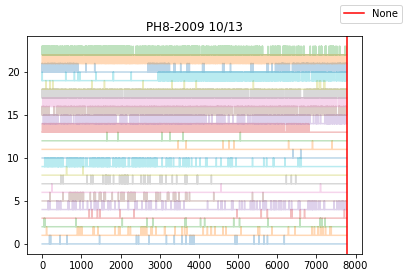

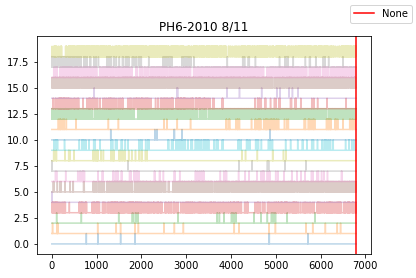

In [106]:
# count eggs; I don't think I actually need this:
for a in range(len(metas)):
    if False:
        print(metas[a].name)
        print(metas[a].cutoff_s)
        if metas[a].cutoff_s is not None:
            print(day_of_year(metas[a].cutoff_s))
            cutoff_label = day_of_year(metas[a].cutoff_s)
        else:
            cutoff_label = 'None'
        print(all_eggs[a].shape)
## Check to make sure we're not leaving any males out or something weird. 
    male_activity = np.sum(historys[a],axis=(2))
    #print(male_activity.shape)
    if metas[a].cutoff_s is not None:
        cutoff_label = day_of_year(metas[a].cutoff_s)
    else:
        cutoff_label = 'None'
    fig,ax = plt.subplots()
    for m in range(male_activity.shape[1]):
        ax.plot(range(male_activity.shape[0]),male_activity[:,m] + m,alpha=.3) #label=str(m),
    ax.axvline(metas[a].cutoff-metas[a].start,color='red',label=cutoff_label)
    ax.set_title(metas[a].name + ' ' +str(metas[a].n_males) + '/' + str(metas[a].n_females))
    
    print(metas[a].name,metas[a].cutoff,metas[a].m_ids)
    fig.legend()
    fig.show()
    
## Count eggs before cutoffs



if False:
    
    print('egg_cutoffs:',egg_cutoffs)
    for i in range(4):
        egg_array = all_eggs[i]
        egg_cutoff = egg_cutoffs[i]
        print('n_eggs:',np.sum(egg_array[:egg_cutoff]))
        print('eggs_by_day:',np.sum(egg_array[:egg_cutoff],axis=(1,2)))
        print('dates:',[day_of_year(d) for d in all_datestamps[i][:egg_cutoff]])
        print('n_females,males:',metas[i].n_females, metas[i].n_males)


findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


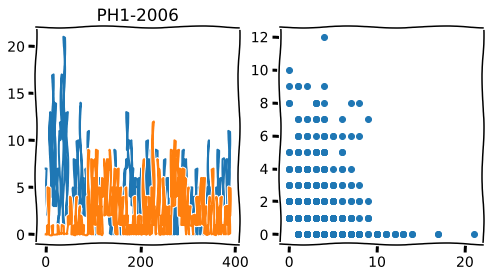

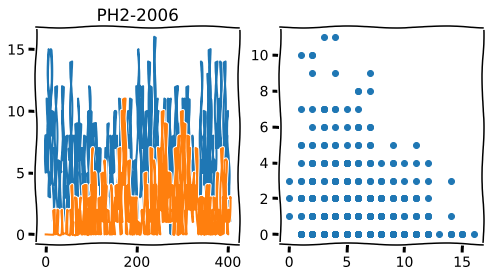

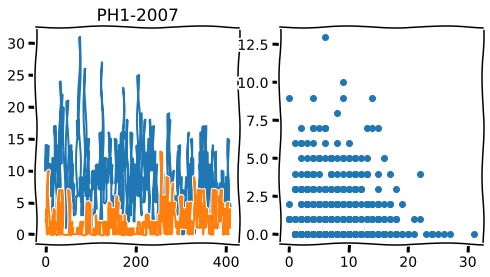

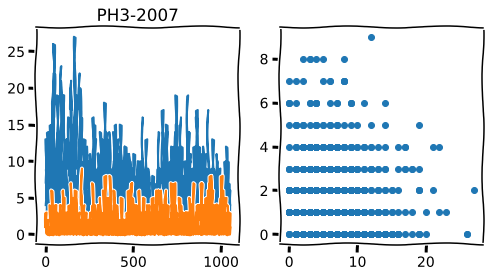

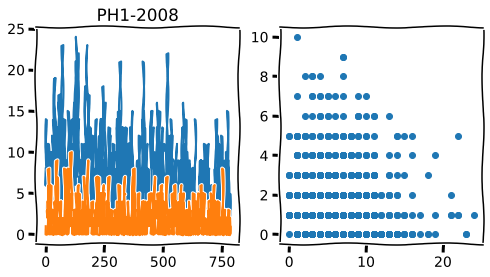

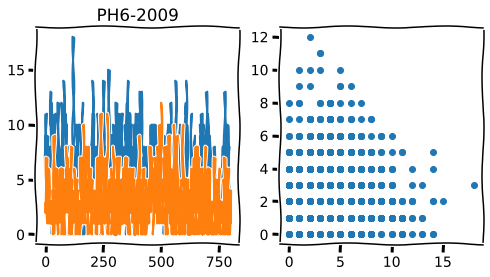

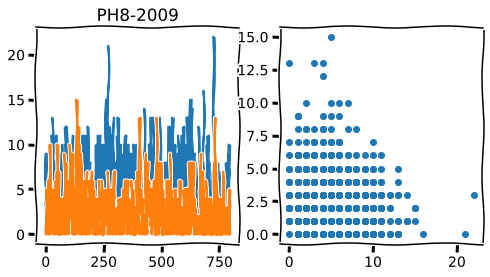

In [1877]:
## Visualize male and female songs to get a sense of whether any of the aviaries are weird. 

for a in range(len(metas)):
    #print(metas[a].f_ids)

    #print(all_eggs[a].shape)
    
    #print(m17_egg_data)

    #plt.xkcd()
    #plt.rcdefaults() 


    history_bins,_ = bin_history(sorteds[a],historys[a],metas[a])

    n_females = metas[a].n_females
    male_songs = np.sum(history_bins[:,n_females:,n_females:],axis=(1,2))
    female_songs = np.sum(history_bins[:,n_females:,:n_females],axis=(1,2))
    if True:
        with plt.xkcd():

            fig,(ax,ax1) = plt.subplots(1,2)
            ax.plot(range(len(history_bins)),male_songs)
            ax.plot(range(len(history_bins)),female_songs)
            
            #ax1.imshow(np.sum(historys[a],axis=(0)),aspect='auto')
            ax1.scatter(male_songs,female_songs)
            ax.set_title(metas[a].name)
            fig.set_size_inches(8,4)
            fig.show()

In [84]:
## Skippable 
if False:
    np.unique(np.nansum(all_eggs[4][:,participant_index_list[4]],axis=(2)),return_counts=True)

    for i in range(len(metas)):
        fig,ax = plt.subplots()
        #i=12
        participants = participant_index_list[i]
        for p in range(len(participants)):
            if participants[p]==0 and p != len(participants)-1:
                continue
            bird_days = all_eggs[i][:,p]
            bird_days = np.nansum(bird_days,1)
            ax.scatter(np.arange(len(bird_days)),bird_days/2 + p)

    


In [87]:
## CAlculate regression, I have a better approach now.

rs,rs_shuff = [],[]
for a in range(len(metas)):
    #print(a)
    history_bins,[history_rate_bins,ts,window_indices]= bin_history(sorteds[a],historys[a],metas[a],window=100)
    shuffled_bins = shuffle_indy_bins(history_bins)
    n_females = metas[a].n_females
    female_songs = np.sum(history_bins[:,n_females:,:n_females],axis=(1,2))
    male_songs = np.sum(history_bins[:,n_females:,n_females:],axis=(1,2))
    r,p_val = pearsonr(male_songs,female_songs)
    shuff_r,_ = pearsonr(np.sum(shuffled_bins[:,n_females:,n_females:],axis=(1,2)),np.sum(shuffled_bins[:,n_females:,:n_females],axis=(1,2)))
    rs.append(r)
    rs_shuff.append(shuff_r)
    
print(rs,rs_shuff)
print(pearsonr(rs,rs_shuff))

[-0.2685378686193378, -0.2236464702317662, -0.4024221726307029, -0.1321784972317262, -0.15727386108608593, -0.07321571168188684, -0.04760867966629369, -0.028902755756509555, -0.12220920523676002, -0.14766372749646975, -0.11442230739323611, -0.05894792485190139, -0.16402318428365154, -0.20087596633365323, -0.14768246810774438, -0.1924594268162656, -0.2292874381917804, -0.06363544251070047, -0.08266054376626623] [-0.07831815839901698, 0.0178970381247784, -0.0750926755921601, 0.025724308710923627, -0.058664892236651424, -0.0724170915133262, -0.0028900278550585195, 0.060362476367529866, -0.03648523756243195, -0.13191372692579523, -0.09173610981528339, -0.048027259438818116, -0.038608125154351275, -0.0862316435377145, -0.028680749607644735, -0.03369157064309837, -0.020036790487237152, -0.060458156223537035, 0.029239441837576687]
(0.31157569558584614, 0.1941030716111525)


In [42]:
## Define a function to calculate cohesion, this was a nice idea but ultimately failed 

## Designed for neural spiketraines, so there will be some adjustments
## this is take from https://github.com/NeuralEnsemble/elephant/blob/master/elephant/spike_train_correlation.py

# spiketrains need to be a class with a list of event times (.times), a start and stop time (.t_start)

## Convert history data into a set of spiketrains
## Returns a list of lists, where each sublist contains spiketrains for each male
## Get start and stop indices of every window
"""
def history_to_spikes(history,meta,songtype='all',dt=45):
    n_males = meta.n_males
    n_females = meta.n_females
    
    start_indices = np.diff(meta.timestamps[meta.start:meta.cutoff],prepend=301,append=301) > 300
    start_indices[0] = 1
    start_indices[-1] = 1

    
    start_indices = np.argwhere(start_indices)
    stop_indices = start_indices[1:] - 1

    start_indices = start_indices[0:-1]

    block_indices = np.hstack([start_indices,stop_indices])

    if songtype == 'all':
        spikes = np.sum(history[:,n_females:,:],axis=2)
    elif songtype == 'males':
        no_self = np.array(history[:,n_females:,n_females:])
        for m in range(n_males):
            no_self[:,m,m] = 0
        spikes = np.sum(no_self,axis=2)
    elif songtype == 'females':
        spikes = np.sum(history[:,n_females:,:n_females],axis=2)
    elif songtype == 'undirected':
        u_songs = np.zeros(len(history),n_males)
        for m in range(n_males):
            u_songs[:,m] = history[:,m,m]
            u_songs[:,m][np.sum(history[:,m],axis=0)>1] = 0
        spikes = u_songs
    spikes = spikes.astype(bool)
    return spikes,block_indices
"""
"""
def sttc_cohesion(history,meta,songtype='all',dt=45):
    n_males = meta.n_males
    spikes,block_indices = history_to_spikes(history,meta,songtype,dt)
    all_spiketrains = [[] for w in range(len(block_indices))]

    #print(block_indices.shape,meta.timestamps.shape,block_indices[0])
    for w in range(len(block_indices)):
        i0 = block_indices[w,0]
        i1 = block_indices[w,1] + 1

        start_time = meta.timestamps[block_indices[w,0]]
        stop_time = meta.timestamps[block_indices[w,1]]

        for m in range(n_males):
            #print(i0,i1,m,spikes.shape,meta.timestamps.shape)
            m_spike_times = meta.timestamps[i0:i1][spikes[i0:i1,m]]
            #print(m_spike_times)
            m_spiketrain = Spiketrain(m_spike_times,start_time,stop_time)
            all_spiketrains[w].append(m_spiketrain)

    sttc_cohesion_matrix = np.zeros([len(block_indices),n_males,n_males])
    sttc_cohesion_matrix.fill(np.nan)
    for w in range(len(block_indices)):
        for m in range(n_males):
            for n in range(n_males - m):
                spiketrain_i = all_spiketrains[w][m]
                spiketrain_j = all_spiketrains[w][n]
                sttc_cohesion_matrix[w,m,n] = sttc(spiketrain_i,spiketrain_j)
    return sttc_cohesion_matrix
"""

## At its core, this is just a list of events
class Spiketrain:
    def __init__(self,data,t_start,t_stop,T=None,spike_type = None,shuffle=False):
        self.data = data
        self.times = data
        self.t_start = t_start
        self.t_stop = t_stop
        #self.index = 0
        #self.id = 'BDY'
        self._data_len = len(self.times)
        self.types = spike_type
        self.T = T
        self.random_times = np.array(sorted([np.random.randint(t_start,t_stop) for s in range(len(data))]))
        #print(self.times,self.random_times)
        #print(self.times - self.random_times)
        #print(np.diff(self.times),np.diff(self.random_times))
        self.shuffle = shuffle
        
        self.set_shuffle(shuffle) ## Note that T needs to change with this
        
        if self.types is not None:
            #print('oops')
            t0 = self.times[self.types == 0]
            t1 = self.times[self.types == 1]
            t2 = self.times[self.types == 2]
            self.typed_times = np.array([t0,t1,t2])
        else:
            self.typed_times = np.array([self.times])
        
    def boot_t(self): ## Needed to rebuild this so that I could shuffle internally
        if self.T == None:
            if len(self.times) > 0:
                self.active = True
                self.T = self.run_T() ## Get T when you boot it up, since I'll be doing this a lot
            else:
                self.active = False
                self.T = 0
        else:
            pass ## Leave T alone
            
    def __len__(self):
        return self._data_len
        
    def __getitem__(self,idx):
        return self.times[idx]
    
    def set_shuffle(self,shuffle):
        self.shuffle = shuffle
        if shuffle:
            self.times = self.random_times
        else:
            self.times = self.data
        self.boot_t()
        
    def run_T(self,dt=45):
        """
        Calculate the proportion of the total recording time 'tiled' by spikes.
        """
        spiketrain = self
        N = len(spiketrain)
        time_A = 2 * N * dt  # maximum possible time

        if N == 1:  # for just one spike in train
            if spiketrain[0] - spiketrain.t_start < dt:
                time_A += -dt + spiketrain[0] - spiketrain.t_start
            if spiketrain[0] + dt > spiketrain.t_stop:
                time_A += -dt - spiketrain[0] + spiketrain.t_stop
        else:  # if more than one spike in train
            # Vectorized loop of spike time differences
            diff = np.diff(spiketrain.times)
            diff_overlap = diff[diff < 2 * dt]
            # Subtract overlap
            time_A += -2 * dt * len(diff_overlap) + np.sum(diff_overlap)

            # check if spikes are within dt of the start and/or end
            # if so subtract overlap of first and/or last spike
            if (spiketrain[0] - spiketrain.t_start) < dt:
                time_A += spiketrain[0] - dt - spiketrain.t_start

            if (spiketrain.t_stop - spiketrain[N - 1]) < dt:
                time_A += -spiketrain[-1] - dt + spiketrain.t_stop

        T = time_A / (spiketrain.t_stop - spiketrain.t_start)
        return T
    
def spike_time_tiling_coefficient(spiketrain_i, spiketrain_j, dt=45,exclude_silent=False,shuffle=False):
    """
    Docs:
        Calculates the Spike Time Tiling Coefficient (STTC) as described in
        :cite:`correlation-Cutts2014_14288` following their implementation in C.
        The STTC is a pairwise measure of correlation between spike trains.
        It has been proposed as a replacement for the correlation index as it
        presents several advantages (e.g. it's not confounded by firing rate,
        appropriately distinguishes lack of correlation from anti-correlation,
        periods of silence don't add to the correlation and it's sensitive to
        firing patterns).
        The STTC is calculated as follows:
        .. math::
            STTC = 1/2((PA - TB)/(1 - PA*TB) + (PB - TA)/(1 - PB*TA))
        Where `PA` is the proportion of spikes from train 1 that lie within
        `[-dt, +dt]` of any spike of train 2 divided by the total number of spikes
        in train 1, `PB` is the same proportion for the spikes in train 2;
        `TA` is the proportion of total recording time within `[-dt, +dt]` of any
        spike in train 1, TB is the same proportion for train 2.
        For :math:`TA = PB = 1`and for :math:`TB = PA = 1`
        the resulting :math:`0/0` is replaced with :math:`1`,
        since every spike from the train with :math:`T = 1` is within
        `[-dt, +dt]` of a spike of the other train.
        This is a Python implementation compatible with the elephant library of
        the original code by C. Cutts written in C and available `here
        <https://github.com/CCutts/Detecting_pairwise_correlations_in_spike_trains/
        blob/master/spike_time_tiling_coefficient.c>`_:
        Parameters
        ----------
        spiketrain_i, spiketrain_j : neo.SpikeTrain
            Spike trains to cross-correlate. They must have the same `t_start` and
            `t_stop`.
        dt : pq.Quantity.
            The synchronicity window is used for both: the quantification of the
            proportion of total recording time that lies `[-dt, +dt]` of each spike
            in each train and the proportion of spikes in `spiketrain_i` that lies
            `[-dt, +dt]` of any spike in `spiketrain_j`.
            Default : `0.005 * pq.s`
        Returns
        -------
        index : float or np.nan
            The spike time tiling coefficient (STTC). Returns np.nan if any spike
            train is empty.
        Notes
        -----
        Alias: `sttc`
        Examples
        --------
        >>> import neo
        >>> import quantities as pq
        >>> from elephant.spike_train_correlation import \
        ...    spike_time_tiling_coefficient
        >>> spiketrain1 = neo.SpikeTrain([1.3, 7.56, 15.87, 28.23, 30.9, 34.2,
        ...     38.2, 43.2], units='ms', t_stop=50)
        >>> spiketrain2 = neo.SpikeTrain([1.02, 2.71, 18.82, 28.46, 28.79, 43.6],
        ...     units='ms', t_stop=50)
        >>> spike_time_tiling_coefficient(spiketrain1, spiketrain2)
        0.4958601655933762
    """

    def run_P(spiketrain_i, spiketrain_j):
        """
        Check every spike in train 1 to see if there's a spike in train 2
        within dt
        
        Added condition that the spikes need to be of the same type
        """
        N2 = len(spiketrain_j)

        # Search spikes of spiketrain_i in spiketrain_j
        # ind will contain index of 
        
        ## Eventually this could work for everything, but it's hacked together right now
        # I think it could be a little more efficient too, but this shouldn't be too slow
        
        ## This doesn't actually work
        if spiketrain_j.types is not None and spiketrain_i.types is not None:
            total_count = 0
            for t in range(len(spiketrain_j.typed_times)):
                N1 = len(spiketrain_j.typed_times[t])
                N2 = len(spiketrain_j.typed_times[t])
                if N2 == 0 or N1 == 0:
                    continue
                ind = np.searchsorted(spiketrain_j.typed_times[t],spiketrain_i.typed_times[t])
                ind[ind == N2] = N2 - 1
                close_left = np.abs(
                    spiketrain_j.typed_times[t][ind - 1] - spiketrain_i.typed_times[t]) <= dt
                close_right = np.abs(
                    spiketrain_j.typed_times[t][ind] - spiketrain_i.typed_times[t]) <= dt
                close = close_left + close_right
                total_count += np.count_nonzero(close)
            return total_count
        if shuffle:
            ind = np.searchsorted(spiketrain_j.random_times,spiketrain_i.random_times)
        ind = np.searchsorted(spiketrain_j.times, spiketrain_i.times)

        # To prevent IndexErrors
        # If a spike of spiketrain_i is after the last spike of spiketrain_j,
        # the index is N2, however spiketrain_j[N2] raises an IndexError.
        # By shifting this index, the spike of spiketrain_i will be compared
        # to the last 2 spikes of spiketrain_j (negligible overhead).
        # Note: Not necessary for index 0 that will be shifted to -1,
        # because spiketrain_j[-1] is valid (additional negligible comparison)
        ind[ind == N2] = N2 - 1

        # Compare to nearest spike in spiketrain_j BEFORE spike in spiketrain_i
        close_left = np.abs(
            spiketrain_j.times[ind - 1] - spiketrain_i.times) <= dt
        # Compare to nearest spike in spiketrain_j AFTER (or simultaneous)
        # spike in spiketrain_j
        close_right = np.abs(
            spiketrain_j.times[ind] - spiketrain_i.times) <= dt

        # spiketrain_j spikes that are in [-dt, dt] range of spiketrain_i
        # spikes are counted only ONCE (as per original implementation)
        close = close_left + close_right
        
        # Count how many spikes in spiketrain_i have a "partner" in
        # spiketrain_j
        return np.count_nonzero(close)

    def run_T(spiketrain): ## I never actually use this, it's wrapped into the object for efficiency 
        """
        Calculate the proportion of the total recording time 'tiled' by spikes.
        """
        N = len(spiketrain)
        time_A = 2 * N * dt  # maximum possible time

        if N == 1:  # for just one spike in train
            if spiketrain[0] - spiketrain.t_start < dt:
                time_A += -dt + spiketrain[0] - spiketrain.t_start
            if spiketrain[0] + dt > spiketrain.t_stop:
                time_A += -dt - spiketrain[0] + spiketrain.t_stop
        else:  # if more than one spike in train
            # Vectorized loop of spike time differences
            diff = np.diff(spiketrain)
            diff_overlap = diff[diff < 2 * dt]
            # Subtract overlap
            time_A += -2 * dt * len(diff_overlap) + np.sum(diff_overlap)

            # check if spikes are within dt of the start and/or end
            # if so subtract overlap of first and/or last spike
            if (spiketrain[0] - spiketrain.t_start) < dt:
                time_A += spiketrain[0] - dt - spiketrain.t_start

            if (spiketrain.t_stop - spiketrain[N - 1]) < dt:
                time_A += -spiketrain[-1] - dt + spiketrain.t_stop

        T = time_A / (spiketrain.t_stop - spiketrain.t_start)
        return T.simplified.item()  # enforce simplification, strip units

    N1 = len(spiketrain_i)
    N2 = len(spiketrain_j)

    ## This is a choice: How do you handle cohesion with no spikes. Is it 0, or undefined. 
    ## According to the formula, it's 0, and I think that's how I want to use it here as well. 
    
    # excluding non-responsive vs counting non-responsive as 0...
    if N1 == 0 or N2 == 0:
        if exclude_silent:
            index = np.nan
        else:
            if N1 == 0 and N2 == 0:
                index = np.nan
            else:
                index = np.nansum([spiketrain_i.T,spiketrain_j.T]) * -1/2

    else:
        #TA = run_T(spiketrain_i)
        #TB = run_T(spiketrain_j)
        TA = spiketrain_i.T
        TB = spiketrain_j.T
        PA = run_P(spiketrain_i, spiketrain_j)
        PA = PA / N1
        PB = run_P(spiketrain_j, spiketrain_i)
        PB = PB / N2
        # check if the P and T values are 1 to avoid division by zero
        # This only happens for TA = PB = 1 and/or TB = PA = 1,
        # which leads to 0/0 in the calculation of the index.
        # In those cases, every spike in the train with P = 1
        # is within dt of a spike in the other train,
        # so we set the respective (partial) index to 1.
        if PA * TB == 1:
            if PB * TA == 1:
                index = 1.
            else:
                index = 0.5 + 0.5 * (PB - TA) / (1 - PB * TA)
        elif PB * TA == 1:
            index = 0.5 + 0.5 * (PA - TB) / (1 - PA * TB)
        else:
            index = 0.5 * (PA - TB) / (1 - PA * TB) + 0.5 * (PB - TA) / (
                1 - PB * TA)
    return index


sttc = spike_time_tiling_coefficient



In [81]:
## More sttc cohesion stuff. I think I can remove these cells
a = 11
history = historys[a]
meta = metas[a]


## Get start and stop indices of every window
def history_to_spikes(history,meta,songtype='all',dt=45):
    n_males = meta.n_males
    n_females = meta.n_females
    
    start_indices = np.diff(meta.timestamps[meta.start:meta.cutoff],prepend=301,append=301) > 300
    start_indices[0] = 1
    start_indices[-1] = 1

    
    start_indices = np.argwhere(start_indices)
    stop_indices = start_indices[1:] - 1

    start_indices = start_indices[0:-1]

    #bad_blocks = start_indices == stop_indices ## There are occasionally one off events, that I need to clear
    
    #print(bad_blocks)
    #print(~bad_blocks)
    block_indices = np.hstack([start_indices,stop_indices])
    for m in block_indices:
        if meta.timestamps[m[1]+meta.start] - meta.timestamps[m[0]+meta.start] > 10200:
            import pdb
            pdb.set_trace()
    #block_indices = block_indices[~bad_blocks[:,0]]
    
    if songtype == 'any':
        spikes = np.sum(history[:,n_females:,:],axis=2)
    elif songtype == 'males':
        no_self = np.array(history[:,n_females:,n_females:])
        for m in range(n_males):
            no_self[:,m,m] = 0  # Exclude undirected song
        spikes = np.sum(no_self,axis=2)  # Add songs to any (other) male
    elif songtype == 'females':
        spikes = np.sum(history[:,n_females:,:n_females],axis=2)
    elif songtype == 'undirected':
        u_songs = np.zeros([len(history),n_males])
        for m in range(n_males):
            u_songs[:,m] = history[:,m,m]
            #u_songs[:,m][np.sum(history[:,m],axis=0)>1] = 0 # I might not need this anymore, but it would exclude directed song
        spikes = u_songs
    elif songtype == 'all':      
        no_self = np.array(history[:,n_females:,n_females:])
        u_songs = np.zeros([len(history),n_males])
        for m in range(n_males):
            no_self[:,m,m] = 0
            u_songs[:,m] = history[:,m,m]
            #u_songs[:,m][np.sum(history[:,m],axis=0)>1] = 0
        m_spikes = np.sum(no_self,axis=2)
        f_spikes = np.sum(history[:,n_females:,:n_females],axis=2)
        u_spikes = u_songs
        spikes = np.stack([m_spikes,f_spikes,u_spikes],axis=-1)
        
    else:
        print("Need a songtype! Options: ['any','all','males','females','undirected']")
    spikes = spikes.astype(bool)
    return spikes,block_indices

def sttc_cohesion(history,meta,songtype='all',dt=45,exclude_silent=False,shuffle=False):
    n_males = meta.n_males
    spikes,block_indices = history_to_spikes(history,meta,songtype,dt)
    all_spiketrains = [[] for w in range(len(block_indices))]

    #print(block_indices.shape,meta.timestamps.shape,block_indices[0])

    for w in range(len(block_indices)):
        
        i0 = block_indices[w,0]
        i1 = block_indices[w,1] + 1

        start_time = meta.timestamps[block_indices[w,0]+meta.start]
        stop_time = meta.timestamps[block_indices[w,1]+meta.start]
        #print(stop_time-start_time,block_indices[w])

        #print(block_indices[w])
        #print(meta.timestamps[block_indices[w]])
        if start_time == stop_time: ## A handful of timestamps are bad, we skip them. 
            #print('Bad Timestamps! Tryng a bandaid')
            stop_time += 1 ## This is super hacky, but it should allow it to function
        if stop_time - start_time > 10000:
            import pdb
            pdb.set_trace()
        for m in range(n_males):
            #print(i0,i1,m,spikes.shape,meta.timestamps.shape)
            if songtype=='all':
                spike_indices = np.sum(spikes[i0:i1,m],axis=1).astype(bool)
                spike_info = np.argwhere(spikes[i0:i1,m])
                spike_locs = spike_info[:,0]
                spike_types = spike_info[:,1]
            else:
                spike_indices = spikes[i0:i1,m]
                spike_types = np.array([1] * np.sum(spike_indices))
                spike_types = None
            #m_spike_times = meta.timestamps[i0:i1][spikes[i0:i1,m]]
            
            m_spike_times = meta.timestamps[i0:i1][spike_indices]

            m_spiketrain = Spiketrain(m_spike_times,start_time,stop_time,spike_types,shuffle=shuffle)
            all_spiketrains[w].append(m_spiketrain)

    sttc_cohesion_matrix = np.zeros([len(block_indices),n_males,n_males])
    sttc_cohesion_matrix.fill(np.nan)
    for w in range(len(block_indices)):
        for m in range(n_males):
            for n in range(m+1,n_males):

                spiketrain_i = all_spiketrains[w][m]
                spiketrain_j = all_spiketrains[w][n]
                sttc_cohesion_matrix[w,m,n] = sttc(spiketrain_i,spiketrain_j,dt,exclude_silent)
                sttc_cohesion_matrix[w,n,m] = sttc_cohesion_matrix[w,m,n] # set lower diagonal as well
    #print(all_spiketrains[w][0].T)
    return sttc_cohesion_matrix,all_spiketrains

c2_scores = []
c2_poscores = []
c2_activity_scores = []
for a in range(len(metas)):
    history,meta = historys[a],metas[a]
    history_shuffle = shuffle_indy_bins(history)
    
    c2_matrix,spiketrains = sttc_cohesion(history,meta,songtype='females',dt=45,exclude_silent=False,shuffle=False)
    c2_pos = c2_matrix[c2_matrix > 0]
    if len(c2_pos) == 0:
        c2_pos = 0
    season_avg = np.nanmean(c2_matrix,axis=0)
    season_avg_real = season_avg[~np.isnan(season_avg)]
    season_avg_pos = season_avg_real[season_avg_real > 0]
    pos_count = np.nansum(season_avg_real > 0)
    total_count = np.sum(~np.isnan(season_avg))
    pos_ratio = pos_count / total_count
    #print(season_avg_pos)
    if True:
        male_activity = [0] * meta.n_males
        for w in range(len(spiketrains)):
            for m in range(meta.n_males):
                male_activity[m] += len(spiketrains[w][m]) > 0
    print(male_activity,w)
    c2_activity_scores.append(np.sum(male_activity) / w / meta.n_males)
                
    
    if False: ## Is it all driven by the cohesive males? 
        if len(season_avg_pos) > 0:
            c2_scores.append(np.nanmean(season_avg_pos))
        else:
            c2_scores.append(0)
    else:    
        c2_scores.append(np.nanmean(season_avg))
        c2_poscores.append(pos_ratio)
    #print(np.nanmax(season_avg),np.nanmin(season_avg),np.nanmean(season_avg))
    #c2_shuffled = sttc_cohesion(history_shuffle,meta,dt=45,exclude_silent=False)

    #print(a,np.nanmean(c2_matrix),np.nanmean(c2_shuffled))
c2_scores = np.array(c2_scores)
c2_poscores = np.array(c2_poscores)
c2_activity_scores = np.array(c2_activity_scores)
fig,ax = plt.subplots()

## I'm excluding the switch aviaries right now, I will eventually do this in a cleaner way
egg_scores2 = np.array(egg_scores)
egg_scores2[9:11] = np.nan

ax.scatter(c2_scores[~np.isnan(egg_scores2)],egg_scores2[~np.isnan(egg_scores2)])
#ax.scatter(c2_poscores[~np.isnan(egg_scores2)],egg_scores2[~np.isnan(egg_scores2)])
for c in range(len(c2_scores)):
    if np.isnan(egg_scores2[c]):
        continue
    ax.text(c2_scores[c],egg_scores2[c],c)
fig.show()

print(pearsonr(c2_scores[~np.isnan(egg_scores2)],egg_scores2[~np.isnan(egg_scores2)]))
print(pearsonr(c2_activity_scores[~np.isnan(egg_scores2)],egg_scores2[~np.isnan(egg_scores2)]))

[7, 39, 40, 37, 24] 48
[30, 12, 1, 26, 31, 10, 6, 2, 19, 19, 9, 20, 19, 40] 49
[38, 28, 25, 38, 26, 44] 49
[31, 4, 28, 8, 5, 13, 13, 18, 13, 24, 42, 10, 6, 6, 24, 19] 50
[24, 12, 20, 10, 28, 20, 29, 12, 32, 23] 49
[44, 0, 63, 106, 44, 69, 67, 105] 129
[62, 66, 30, 115, 56, 52, 27, 77] 129
[17, 17, 7, 22, 21, 30, 23, 21, 30, 0, 15] 46
[33, 78, 63, 24, 33, 15, 8, 19, 75, 46] 94
[40, 37, 48, 2, 5, 46, 32] 54
[32, 0, 28, 42, 0, 46, 40, 17, 28] 51
[72, 54, 24, 83, 29, 44, 65, 66, 78, 69, 17] 99
[38, 51, 50, 32, 49, 0, 4, 50, 51, 52] 52
[33, 39, 6, 36, 32, 22, 8, 36] 38
[40, 41, 36, 53, 51, 1, 34, 9, 47, 44] 54
[11, 45, 20, 7, 45, 42, 14, 44] 47
[33, 5, 47, 8, 39, 0, 23, 41, 34] 48
[13, 5, 30, 6, 0, 31, 30, 33, 28, 26, 28] 32
[51, 4, 35, 9, 18, 40, 7, 33, 33, 10, 38, 22, 5] 68
(0.5793277905159455, 0.02362063126858079)
(0.63629030927935, 0.010766803487436402)


In [83]:
### Some visualization of above cells
a = 15
history,meta = historys[a],metas[a]
history_shuffle = shuffle_indy_bins(history)

c2_matrix,_ = sttc_cohesion(history,meta,songtype='females',dt=45,exclude_silent=True)
season_avg = np.nanmean(c2_matrix,axis=0)

fig,ax = plt.subplots()

#ax.plot(np.nanmean(c2_matrix,axis=(1,2)))
ax.hist(c2_matrix.flatten())
ax.axvline(np.nanmean(c2_matrix),color='red')
fig.show()

In [1593]:
## Testing out spike time 
songtype = 'any'
dt = 45

sttc_cohesion_matrix = sttc_cohesion(history,meta,songtype,dt)

In [1527]:
## Plotting results
activity_by_aviary = np.array([np.nanmean(activity_by_males[a]) for a in range(len(metas))])

fig,ax = plt.subplots()
ax.scatter(activity_by_aviary, c2_scores)
print(activity_by_aviary)
print(pearsonr(activity_by_aviary[~np.isnan(egg_scores2)],c2_scores[~np.isnan(egg_scores2)]))
print(pearsonr(c2_scores[~np.isnan(egg_scores2)],egg_scores[~np.isnan(egg_scores2)]))
print(pearsonr(activity_by_aviary[~np.isnan(egg_scores2)],egg_scores[~np.isnan(egg_scores2)]))

[0.57179487 0.33075299 0.58996683 0.33026808 0.5095122  0.45793269
 0.47946344 0.38607449 0.43371501 0.41285714 0.46282974 0.45533206
 0.4620776  0.4437004  0.46888331 0.32884615 0.31144781 0.26823644
 0.23557692]
(0.7216316901198374, 0.0023888189359535916)
(0.5583379556671532, 0.030526655576829934)
(0.49719835404659407, 0.059340464129559733)


## Sticking a pin in this for now

The above sttc approach is nice, but it fails in a couple respects 
1. It is still subject to underlying activity. How so? 
2. If I look across all songs, it's not obvious how to match things up appropriately. What is the expected overlap for two birds? I guess it's just the proprotion of each song type added up? I think that's right. I could try that again, but I haven't yet. It's not clear to me that that is different from just doing it one by one. 
3. If I look across just one type of song, the T is obvious, but now the results are subject to bins in which there was none of that song type. I don't want to exclude those bins, because not singing female song is a behavior (and they might have just been singing male song), but including those bins wraps overall activity into this again. 
4. Even if it were working perfectly, it averaging means I'm being pushed mainly by the lower 60% of birds, but it's likely that the upper 30% of males are the ones driving the environment....

For now I think I need to step back and check on the mixed regession again. If that effect holds up, i.e. that more cohesive males, after controlling really properly for male activity, get more eggs. I think the paper holds. If that falls, we're looking at a different paper. 

In [89]:
## Additional, weird approaches for calculating predictability. I think this can be skipped. 

## Takes the processed data, returns a ton of important stuff for future analysis
## Add origin sticks [0,0,0] at the end, which is helpful for the volume, but could probably happen elsewhere
def get_points(sorted_data,history,meta,window=100,add_origin=False):
    history_bins,[history_rate_bins,ts,window_indices]= bin_history(sorted_data,history,meta,window=window)
    shuffled_bins = shuffle_indy_bins(history_bins)

    male_states = get_male_states(history_bins,metas[a],threeD=True)
    shuffle_states = get_male_states(shuffled_bins,metas[a],threeD=True)

    #male_dists = np.linalg.norm(np.mean(male_states,axis=(1)),axis=1) #np.sum(male_states,axis=(1,2))
    #shuffle_dists = np.linalg.norm(np.mean(shuffle_states,axis=(1)),axis=1) #np.sum(shuffle_states,axis=(1,2))

    points = np.mean(male_states,axis=1)

    shuffle_points = np.mean(shuffle_states,axis=1)
    ## This is important for calculating the distance stuff if I do that. 
    if add_origin:
        points = np.vstack([points,np.array([0,0,0])])
        shuffle_points = np.vstack([shuffle_points,np.array([0,0,0])])
    
    return points,shuffle_points,[history_rate_bins,ts,window_indices]

## Takes a set of points and, optionally, the timestamps so you can skip bad transitions
## Returns the spherical points, and the transition counts for building the markov stuff
def get_transitions(points, ts = [], max_jump = 300):
    if len(ts) == 0:
        ts = np.zeros(points)
        
    s_points = xyz_to_sphere(points)
    space_count = np.zeros([5,5,5])
    space_count_flat = np.zeros(125)
    transition_count = np.zeros([125,125])

    for s in range(len(s_points)-1):
        if ts[s+1] - ts[s] > max_jump:
            continue
        x0 = s_points[s]
        x1 = s_points[s+1]

        #print('points:',x0,x1)
        x0_i = np.round(x0*4).astype(int)
        x1_i = np.round(x1*4).astype(int)

        #print('indices:',x0_i,x1_i)
        x0_2d = smart_flat(x0_i)
        x1_2d = smart_flat(x1_i)

        space_count[x0_i[0],x0_i[1],x0_i[2]] += 1
        space_count_flat[x0_2d] +=1

        #print(x0_2d,x1_2d)
        transition_count[x0_2d,x1_2d] += 1
    #print(np.max(transition_count))
    return s_points,transition_count

def build_markov(s_points,transition_count):
    s_points_r = np.round(s_points * 5) / 5
    markov_simple = np.argmax(transition_count,axis=0)

    ## This new axis business is important, although I don't quite understand it. 
    transition_probabilities = transition_count / np.sum(transition_count,axis=1)[:,np.newaxis]
    transition_probabilities[np.isnan(transition_probabilities)] = 0

    ## Deterministic "shift" masp, so you could add it
    markov_shift = np.zeros([len(markov_simple),3])  ## This just picks the best shift
    fancy_markov_shift = np.zeros_like(markov_shift) ## This is a weighted shift that incorporates all. 

    for m in range(len(markov_simple)):
        p0 = reverse_flat(m)
        p1 = reverse_flat(markov_simple[m])
        markov_shift[m] = p1 - p0 ## This could also average the shifts, weigthed by probability...
        #print(p0,p1,p1-p0)
        fancy_shift = np.array([0,0,0])
        for n in range(len(markov_simple)):
            fancy_shift = fancy_shift + transition_probabilities[m,n] * (reverse_flat(n) - reverse_flat(m))
        #fancy_shift[np.isnan(fancy_shift)] = 0
        fancy_markov_shift[m] = fancy_shift
    return markov_simple,markov_shift,fancy_markov_shift

## Calculate prediction error
def error_calc(s_points,ts = [],toolbox = {},method='static',max_jump = 300):
    error_array = np.empty(len(s_points)-1)
    error_array.fill(np.nan)
    
    check_past = False
    
    if len(ts) == 0:
        ts = np.zeros(len(s_points))
    if method == 'static':
        drop = 1
    
    elif method == 'markov':
        #print('choosing markov method')
        drop = 1
        markov_simple = toolbox['markov']
    elif method == 'tangent':
        drop = 2
        check_past = True
    elif method == 'combo':
        drop = 2
        check_past = True
        a,b = toolbox['a'],toolbox['b']
        markov_shift = toolbox['markov_shift']
        
    #print(len(s_points) - drop)
    for s in range(len(s_points)-drop):
        #print(ts[s+1] - ts[s], max_jump,ts[s+1] - ts[s] > max_jump)
        if ts[s+1] - ts[s] > max_jump:
            #print('skipping future',s)
            continue
        if check_past and np.abs(ts[s] - ts[s-1]) > max_jump:
            #print('skipping past',s)
            #pass
            continue
        x0 = s_points[s]
        x1 = s_points[s+1]
        x_1 = s_points[s-1]
        
        ## Convert to indices (0-4)
        x0_i = np.round(x0*4).astype(int)
        x1_i = np.round(x1*4).astype(int)

        ## Flatten to 125 space
        x0_2d = smart_flat(x0_i).astype(int)
        x1_2d = smart_flat(x1_i).astype(int) 
        
        if method == 'static':
            error_array[s] = np.linalg.norm(reverse_flat(x1_2d) - reverse_flat(x0_2d))
        elif method == 'markov':
            #print(x1_2d,markov_simple[x0_2d])
            error_array[s] = np.linalg.norm(reverse_flat(x1_2d) - reverse_flat(markov_simple[x0_2d]))
        elif method == 'tangent':
            tangent_prediction = reverse_flat(x0_2d) + x0-x_1 #np.round((x0-x_1)*4) / 4
            tangent_prediction = np.clip(tangent_prediction,0,1)
            error_array[s] = np.linalg.norm(reverse_flat(x1_2d) - tangent_prediction)
        elif method == 'combo':
            extra_fancy_prediction = pred_function([x0,x_1],markov_shift,a,b)
            efp_2d = smart_flat(np.round(fancy_prediction*4).astype(int))
            error_array[s] = np.linalg.norm(reverse_flat(x1_2d) - extra_fancy_prediction)
        
    return error_array
     

0.0029498525073746312
0.02074074074074074
0.007407407407407408
0.014814814814814815
0.046883933676386505
0.031446540880503145
0.0457516339869281
0.03851851851851852
0.05043859649122807
0.02631578947368421
0.033950617283950615
0.046957671957671955
0.044563279857397504
0.05388471177944862
0.04042553191489362
0.042328042328042326
0.062169312169312166
0.03140096618357488
0.037927350427350424
(0.6846773420558877, 0.004861807650334344)


NameError: name 'clean_c' is not defined

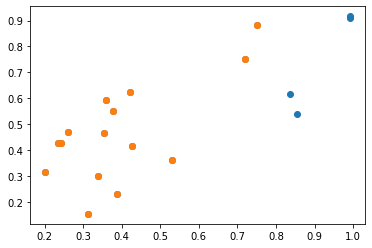

In [99]:
fig,ax = plt.subplots()

unknown_eggs = []
non_participants = []
participant_means = []
participant_ratios = []
for e in range(len(all_eggs)):
    egg_sums = np.sum(all_eggs[e],axis=(0,2))
    egg_ratio = egg_sums/ np.sum(all_eggs[e])
    #print(egg_ratio[-1])
    if egg_ratio[-1] > .55:
        cor = 'black'
        alph = .3
    else:
        cor = cm.viridis(e/len(all_eggs))
        alph= 1
    ax.scatter([e]*(all_eggs[e].shape[1]-1),egg_ratio[:-1],color=cor,alpha=alph)
    ax.bar(e,np.sum(egg_ratio[:-1]),color=cor,alpha=.3)
    unknown_eggs.append(egg_ratio[-1])
    n_females = metas[e].n_females
    participants = np.nansum(all_eggs[e],axis=(0,2))>0
    participants[-1]=0
    participant_ratios.append(np.nansum(participants)/n_females)
    print(np.nanmean(all_eggs[e][:,participants,:]))
    participant_means.append(np.nanmean(all_eggs[e][:,participants,:]))
    non_participants.append(np.nansum(np.nansum(all_eggs[e][:,:-1],axis=(0,2)) ==0)/n_females)
    
fig.show()

print(pearsonr(unknown_eggs[4:],non_participants[4:]))

fig,ax = plt.subplots()

ax.scatter(unknown_eggs,non_participants)
ax.scatter(unknown_eggs[4:],non_participants[4:])
fig.show()
"""
print(unknown_eggs,non_participants)
print(pearsonr(egg_scores[4:],non_participants[4:]))
print(pearsonr(clean_c[4:],non_participants[4:]))
print(pearsonr(clean_c[4:],egg_scores[4:]))"""
print(pearsonr(clean_c[4:],participant_means[4:]))
print(pearsonr(clean_c[4:],participant_ratios[4:]))
pass

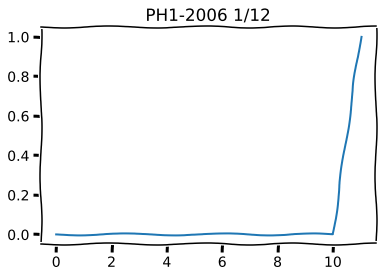

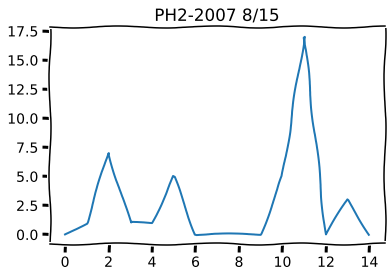

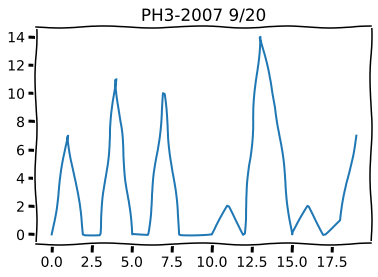

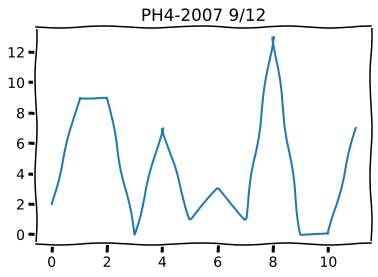

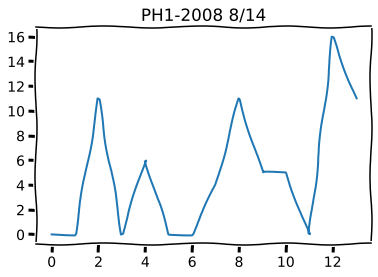

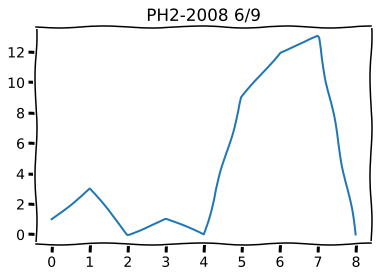

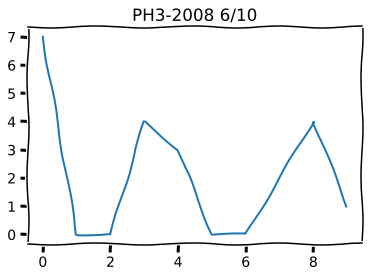

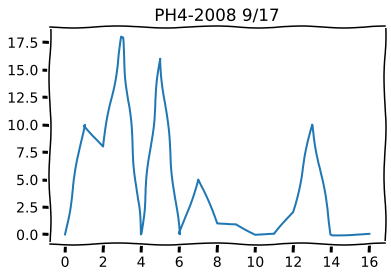

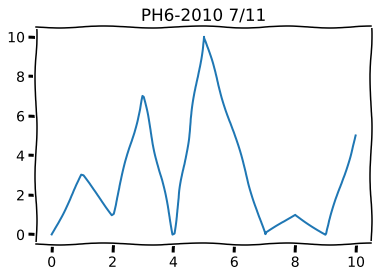

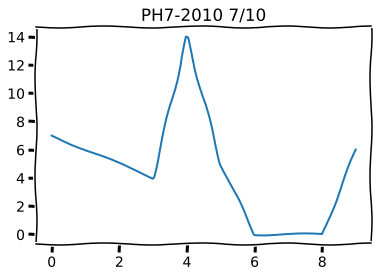

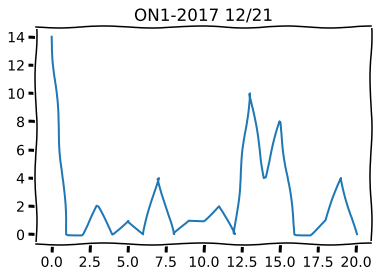

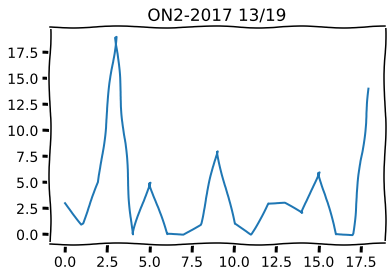

In [355]:

for i in range(len(all_eggs)):
    with plt.xkcd():
        fig, ax = plt.subplots()

        ax.plot(np.nansum(all_eggs[i][:,:-1],axis=(0,2)))
        n_participants = np.nansum(np.nansum(all_eggs[i][:,:-1],axis=(0,2)) >0)
        #print(n_participants)
        ax.set_title(metas[i].name + ' ' + str(n_participants) + '/' + str(metas[i].n_females))
        fig.show()

In [102]:
## Boring things do not seem to be an issue. So that's something. How about this lyapunov nonsense? 

## First try to make the aviary a 1 dimensional time series...

from sklearn.decomposition import PCA

a_shift = 0
all_r_stuff = []
var_exp = []
for i in range(len(metas)):
    if i in [4,7,9,10]:
        a_shift += 1
        continue
    a = i - a_shift
    history_bins,[history_rate_bins,ts,window_indices]= bin_history(sorteds[i],historys[i],metas[i],window=60)

    male_states = get_male_states(history_bins,metas[i],threeD=True)
    flat_states = male_states.reshape(len(male_states),-1)

    n_females = metas[i].n_females
    flat_states = history_bins[:,n_females:].reshape(len(history_bins),-1)
    pca = PCA(n_components=2)

    p_states = pca.fit_transform(flat_states)



    r = nolds.lyap_r(p_states[:,0])
    e = nolds.lyap_e(p_states[:,0])
    h = nolds.hurst_rs(p_states[:,0])
    all_r_stuff.append(r)
    var_exp.append(pca.explained_variance_ratio_[0])
    print(metas[i].name,clean_eggs[a],pca.explained_variance_ratio_[0],r,e,h)
    
fig,ax = plt.subplots()
ax.scatter(all_r_stuff,clean_eggs)
ax.scatter(var_exp,clean_eggs)
fig.show()

print(pearsonr(all_r_stuff,clean_eggs))
print(pearsonr(var_exp,clean_eggs))

PH1-2006 0.7005170243374937 0.2605179170090779 0.024048288805144216 [ 0.121405    0.02122389 -0.08985143 -0.25291732] 0.6683994197755904
PH2-2006 -0.35578463964818935 0.0719004097534281 0.02505199298626038 [ 0.15770292  0.02647222 -0.07876284 -0.26469445] 0.6546439183339268
PH3-2006 0.9385496097376228 0.09348180555407538 -0.0003262389789927944 [ 0.06012185 -0.01026034 -0.06949302 -0.22295856] 0.6373795316056294
PH4-2006 -0.2695144201628261 0.05898280115833366 -0.002036488778663392 [ 0.14764704  0.03211927 -0.07199056 -0.24340157] 0.5651337088184984
PH2-2007 -0.43011783054105657 0.13952975506247078 -0.004111512140794209 [ 0.11404052  0.02617433 -0.06679021 -0.25061092] 0.5732973734641642
PH3-2007 -0.14413750575236584 0.07648982094496079 0.008523443778911656 [ 0.10246917  0.01763483 -0.0698636  -0.21744996] 0.5891432655109885
PH1-2008 0.29567217570981463 0.09263990714344737 0.004993510788137244 [ 0.15620245  0.03166698 -0.06796677 -0.22514558] 0.6512597527668336
PH4-2008 0.12066538725275

In [100]:
import nolds

r = nolds.lyap_r(p_states[:,0])
e = nolds.lyap_e(p_states[:,0])
h = nolds.hurst_rs(p_states[:,0])
print(r,e,h)

0.027710280641560284 [ 0.12138683  0.02130301 -0.09030142 -0.2514864 ] 0.6840548291981241


In [61]:
pearsonr(clean_c,clean_eggs)

(0.11045849519147935, 0.7325424513616476)

In [1411]:
len(metas[a].timestamps)
a=7
print(len(np.unique(metas[a].dates)),len(metas[a].timestamps))
print(len(np.unique(metas[4].dates)))

69 10327
71


In [981]:
s_coords = xyz_to_sphere(np.array([[.5,.2,.3]]))
print(sphere_to_xyz(s_coords))

[[0.5 0.2 0.3]]


In [611]:
## Takes a set of points and, optionally, the timestamps so you can skip bad transitions
## Returns the spherical points, and the transition counts for building the markov stuff
def get_transitions(points, ts = None, max_jump = 300):
    if ts == None:
        ts = np.zeros(points)
        
    s_points = xyz_to_sphere(points)
    space_count = np.zeros([5,5,5])
    space_count_flat = np.zeros(125)
    transition_count = np.zeros([125,125])

    for s in range(len(s_points)-1):
        if ts[s+1] - ts[0] > max_jump:
            continue
        x0 = s_points[s]
        x1 = s_points[s+1]
        x1_shuff = s_points_shuffled[s+1]

        #print('points:',x0,x1)
        x0_i = np.round(x0*4).astype(int)
        x1_i = np.round(x1*4).astype(int)
        x1_ish = np.round(x1_shuff*4).astype(int)

        #print('indices:',x0_i,x1_i)
        x0_2d = smart_flat(x0_i)
        x1_2d = smart_flat(x1_i)
        x1_2dsh = smart_flat(x1_ish)

        space_count[x0_i[0],x0_i[1],x0_i[2]] += 1
        space_count_flat[x0_2d] +=1

        #print(x0_2d,x1_2d)
        transition_count[x0_2d,x1_2d] += 1
        transition_count_shuffled[x0_2d,x1_2dsh] += 1
    return s_points,transition_count

(391, 3)
(390, 3)


In [649]:
   
def build_markov(s_points,transition_count):
    s_points_r = np.round(s_points * 5) / 5
    markov_simple = np.argmax(transition_count,axis=0)

    ## This new axis business is important, although I don't quite understand it. 
    transition_probabilities = transition_count / np.sum(transition_count,axis=1)[:,np.newaxis]
    transition_probabilities[np.isnan(transition_probabilities)] = 0

    ## Deterministic "shift" masp, so you could add it
    markov_shift = np.zeros([len(markov_simple),3])  ## This just picks the best shift
    fancy_markov_shift = np.zeros_like(markov_shift) ## This is a weighted shift that incorporates all. 

    for m in range(len(markov_simple)):
        p0 = reverse_flat(m)
        p1 = reverse_flat(markov_simple[m])
        markov_shift[m] = p1 - p0 ## This could also average the shifts, weigthed by probability...
        #print(p0,p1,p1-p0)
        fancy_shift = np.array([0,0,0])
        for n in range(len(markov_simple)):
            fancy_shift = fancy_shift + transition_probabilities[m,n] * (reverse_flat(n) - reverse_flat(m))
        #fancy_shift[np.isnan(fancy_shift)] = 0
        fancy_markov_shift[m] = fancy_shift
    return markov_shift,fancy_markov_shift

In [1280]:
# Egg counts over the course of the season (all aviaries) are up above. This cell is old 

# Lets fix prediction first. 

# Define the group state as a point in space
a = 0
history_bins,[history_rate_bins,ts,window_indices]= bin_history(sorteds[a],historys[a],metas[a],window=100)
male_states = np.zeros([len(history_bins),metas[a].n_males,2])

n_males,n_females = metas[a].n_males,metas[a].n_females
for b in range(len(history_bins)):
    for m in range(metas[a].n_males):
        m_songs = np.sum(history_bins[b,m + n_females,n_females:])
        f_songs = np.sum(history_bins[b,m+n_females,:n_females])
        u_songs = history_bins[b,m + n_females,m+n_females]
        m_songs = m_songs - u_songs
        if f_songs > 0:
            m_state = [0,1,0] #[0,1] #2d is easier to visualize, but 3d seems better
        elif m_songs > 0:
            m_state = [1,0,0] #[1,0]
        elif u_songs > 0:
            m_state = [0,0,1] #[.7,.7]
        else:
            m_state = [0,0]
        male_states[b,m] = m_state

fig,ax = plt.subplots()
ax.scatter(np.sum(male_states[:,:,0],1),np.sum(male_states[:,:,1],1),alpha=.1)
fig.show()

print(n_males)

ValueError: cannot copy sequence with size 3 to array axis with dimension 2

In [934]:
a = 1
history_bins,[history_rate_bins,ts,window_indices]= bin_history(sorteds[a],historys[a],metas[a],window=100)
shuffled_bins = shuffle_indy_bins(history_bins)

print(history_bins.shape,shuffled_bins.shape)
male_states = get_male_states(history_bins,metas[a],threeD=True)
shuffle_states = get_male_states(shuffled_bins,metas[a],threeD=True)

print(male_states.shape,shuffle_states.shape)

male_dists = np.linalg.norm(np.mean(male_states,axis=(1)),axis=1) #np.sum(male_states,axis=(1,2))
shuffle_dists = np.linalg.norm(np.mean(shuffle_states,axis=(1)),axis=1) #np.sum(shuffle_states,axis=(1,2))

print(np.linalg.norm(male_states,axis=(1,2)).shape)
print(np.sum(shuffle_states,axis=(1)).shape)
print(np.linalg.norm(np.sum(shuffle_states,axis=(1)),axis=1).shape)

print(np.sum(male_states,axis=(0,2)))
print(metas[a].name,metas[a].n_birds,metas[a].n_males,metas[a].n_females)

points = np.mean(male_states,axis=1)
points = np.vstack([points,np.array([0,0,0])])
shuffle_points = np.mean(shuffle_states,axis=1)
shuffle_points = np.vstack([shuffle_points,np.array([0,0,0])])

(406, 27, 27) (406, 27, 27)
(406, 14, 3) (406, 14, 3)
(406,)
(406, 3)
(406,)
[174.  60.  13. 177. 226. 123.  51.  43. 193. 130. 104. 199. 135. 252.]
PH2-2006 27 14 13


In [935]:
## Check to make sure we're not leaving any males out or something weird. 
male_activity = np.sum(male_states,axis=2)
print(male_activity.shape)

fig,ax = plt.subplots()
for m in range(male_activity.shape[1]):
    ax.plot(range(male_activity.shape[0]),male_activity[:,m] + m,label=str(m),alpha=.3)

ax.legend()
fig.show()

(406, 14)


In [936]:
s_points = xyz_to_sphere(points)
s_points_shuffled = xyz_to_sphere(shuffle_points)
transitions = s_points[1:] - s_points[0:-1]

print(s_points.shape)
print(transitions.shape)

space_count = np.zeros([5,5,5])
space_count_flat = np.zeros(125)
transition_count = np.zeros([125,125])
transition_count_shuffled = np.zeros_like(transition_count)

for s in range(len(s_points)-1):
    x0 = s_points[s]
    x1 = s_points[s+1]
    x1_shuff = s_points_shuffled[s+1]
    
    #print('points:',x0,x1)
    x0_i = np.round(x0*4).astype(int)
    x1_i = np.round(x1*4).astype(int)
    x1_ish = np.round(x1_shuff*4).astype(int)

    #print('indices:',x0_i,x1_i)
    x0_2d = smart_flat(x0_i)
    x1_2d = smart_flat(x1_i)
    x1_2dsh = smart_flat(x1_ish)
    
    space_count[x0_i[0],x0_i[1],x0_i[2]] += 1
    space_count_flat[x0_2d] +=1
    
    #print(x0_2d,x1_2d)
    transition_count[x0_2d,x1_2d] += 1
    transition_count_shuffled[x0_2d,x1_2dsh] += 1

(407, 3)
(406, 3)


In [937]:
fig,(ax,ax1) = plt.subplots(1,2)

ax.imshow(transition_count,vmax=.8)
#ax1.imshow(np.transpose(np.vstack([space_count_flat,space_count_flat])),aspect='auto')
ax1.imshow(transition_count_shuffled,vmax=.8)
fig.show()

print(transition_count[0,0])

1.0


In [924]:
## Deterministic transition map

s_points_r = np.round(s_points * 5) / 5
#print(s_points[:5],s_points_r[:5])
markov_simple = np.argmax(transition_count,axis=0)

## This new axis business is important, although I don't quite understand it. 
transition_probabilities = transition_count / np.sum(transition_count,axis=1)[:,np.newaxis]
transition_probabilities[np.isnan(transition_probabilities)] = 0

## Deterministic "shift" masp, so you could add it
markov_shift = np.zeros([len(markov_simple),3])  ## This just picks the best shift
fancy_markov_shift = np.zeros_like(markov_shift) ## This is a weighted shift that incorporates all. 

for m in range(len(markov_simple)):
    p0 = reverse_flat(m)
    p1 = reverse_flat(markov_simple[m])
    markov_shift[m] = p1 - p0 ## This could also average the shifts, weigthed by probability...
    #print(p0,p1,p1-p0)
    fancy_shift = np.array([0,0,0])
    for n in range(len(markov_simple)):
        fancy_shift = fancy_shift + transition_probabilities[m,n] * (reverse_flat(n) - reverse_flat(m))
    #fancy_shift[np.isnan(fancy_shift)] = 0
    fancy_markov_shift[m] = fancy_shift

print(np.max(transition_count))

6.0


In [925]:
### Calculate error various ways

error_array = np.empty(len(s_points)-1)
error_array_static = np.empty_like(error_array)
error_array_tangent = np.empty_like(error_array)
error_array_fancy = np.empty_like(error_array)
error_array_extra_fancy = np.empty_like(error_array)

error_array.fill(np.nan)
error_array_static.fill(np.nan)
error_array_tangent.fill(np.nan)
error_array_fancy.fill(np.nan)
error_array_extra_fancy.fill(np.nan)


#fig,ax = plt.subplots()

for s in range(len(s_points)-2):
    ## Check if transitions are worth looking at
    if ts[s+1] - ts[s] > 300:
        #print('big skip, no prediction')
        #print(s,ts[s+1]-ts[s])
        continue
    ## Is there a past bin to check? If not, just skip it. 
    if np.abs(ts[s-1] - ts[s]) > 300:
        continue
    ## Original spherical points
    x0 = s_points[s]
    x1 = s_points[s+1]
    x_1 = s_points[s-1]
    
    ## indicies from spherical points
    x0_i = np.round(x0*4).astype(int)
    x1_i = np.round(x1*4).astype(int)

    ## Flattened to 125 space
    x0_2d = smart_flat(x0_i).astype(int)
    x1_2d = smart_flat(x1_i).astype(int) 
    #print(x0_i,x0_2d)


    ## Reverse back into rounded spherical space

    tangent_prediction = reverse_flat(x0_2d) + x0-x_1 #np.round((x0-x_1)*4) / 4
    tangent_prediction = np.clip(tangent_prediction,0,1)
    
    fancy_prediction = np.round(np.clip(x0 + fancy_markov_shift[x0_2d],0,1)*5)/5
    extra_fancy_prediction = pred_function([x0,x_1],markov_shift,a=.7,b=0)
    
    efp_2d = smart_flat(np.round(fancy_prediction*4).astype(int))
    #print(extra_fancy_prediction)
    fp_i = np.round(fancy_prediction*4).astype(int)
    fp_2d = smart_flat(fp_i)
    #print('tan vs func',tangent_prediction,extra_fancy_prediction)
    error_array[s] = np.linalg.norm(reverse_flat(x1_2d) - reverse_flat(markov_simple[x0_2d]))
    error_array_tangent[s] = np.linalg.norm(reverse_flat(x1_2d) - tangent_prediction)
    error_array_static[s] = np.linalg.norm(reverse_flat(x1_2d) - reverse_flat(x0_2d))
    error_array_extra_fancy[s] = np.linalg.norm(reverse_flat(x1_2d) - extra_fancy_prediction)
    error_array_fancy[s] = np.linalg.norm(reverse_flat(x1_2d) - fancy_prediction)

    if False:
        ax.scatter(x0_2d,x1_2d,color='black',alpha=.1)        
        ax.scatter(x0_2d,fp_2d,color='green',alpha=.1)
        ax.scatter(x0_2d,efp_2d,color='orange',alpha=.1)
    #print(x_1,x0,x1)
    #print(x0_i,x0_2d,reverse_flat(x0_2d),reverse_flat(x1_2d),tangent_prediction)
#ax.scatter(range(125),np.argmax(transition_count,axis=0),color='red')
#ax.scatter(range(125),range(125),color='blue',alpha=.2)

#fig.show()
print('done!')
print(np.nanmean(error_array),np.nanmean(error_array_static),np.nanmean(error_array_tangent))
print('Median Error:',np.nanmean(error_array_extra_fancy))


done!
0.4093679004911529 0.4033097273836137 0.5701581996728637
Median Error: 0.38453380688757427


In [933]:
a=2
points,shuffled_points,[history_rate_bins,ts,window_indices] = get_points(sorteds[a],historys[a],metas[a])
s_points,transition_count = get_transitions(points,ts)
s_points_shfl,transition_count_shfl = get_transitions(shuffled_points,ts)
markov_simple,markov_shift,fancy_markov_shift = build_markov(s_points,transition_count)
markov_simple_shfl,markov_shift_shfl,fancy_markov_shfl = build_markov(s_points_shfl,transition_count_shfl)

A = 0.7
B = 0.0
toolbox = {'a':A,
          'b':B,
          'markov_shift':markov_shift,
          'markov':markov_simple}

error_array = error_calc(s_points,ts,toolbox,method='combo')
toolbox_shfl = {'a':A,
                   'b':B,
                   'markov_shift':markov_shift_shfl,
                   'markov':markov_simple_shfl}

error_array_shuffled = error_calc(s_points_shfl,ts,toolbox_shfl,method='combo')
error_array_static = error_calc(s_points,ts,toolbox,method='static')
error_array_fancy = error_calc(s_points,ts,toolbox,method='combo')
error_array_tangent = error_calc(s_points,ts,toolbox,method='tangent')

print(np.nanmean(error_array),np.nanmean(error_array_static),np.nanmean(error_array_tangent))
print('Median Error:',np.nanmean(error_array))
print('Shuffled Error:',np.nanmean(error_array_shuffled))

print(metas[a].name)
print(metas[a].n_males,metas[a].n_females)
error_clean = error_array[~np.isnan(error_array)]
shuffled_error_clean = error_array_shuffled[~np.isnan(error_array_shuffled)]
ttest_ind(error_clean,shuffled_error_clean)

0.3969627564176781 0.40439306043391077 0.56998241419883
Median Error: 0.3969627564176781
Shuffled Error: 0.37715898754856203
PH3-2006
6 11


Ttest_indResult(statistic=1.1310919172737286, pvalue=0.2584713318801456)

In [891]:
## A bunch of functions for everything
from scipy.optimize import curve_fit

def round_to_fifth(x):
    return np.round(x*4) / 5

def sphere_to_125(sph):
    i_coords = np.round(sph*4).astype(int)

    f_coord = smart_flat(i_coords)

    return f_coord
    
def tangentX(Xt0,Xt_1):
    dX = Xt0 - Xt_1
    return dX


def markovX(Xt,markov_shift):
    Xi = np.round(Xt*4)
    m = smart_flat(Xi).astype(int)
    Mx = markov_shift[m]
    return Mx

def markovX_fancy(Xt,fancy_markov_shift):
    m = smart_flat(Xt).astype(int)
    Mx = fancy_markov_shift[m]
    return Mx

def pred_function_all(xData,a=.8,b=.2):
    yData_g = np.zeros(xData.shape[1])
    for t in range(len(xData)):
        Xt0 = xData[0,t]
        Xt_1 = xData[1,t]
        Xt1 = Xt0 + a*markovX(Xt0) + b*tangentX(Xt0,Xt_1)
        Xt1 = round_to_fifth(np.clip(Xt1,0,1))
        yData_g[t] = sphere_to_125(Xt1)
    return yData_g

def pred_function_sph(xData,a=.8,b=.2):
    yData_g = np.zeros(xData.shape[1],3)
    for t in range(len(xData)):
        Xt0 = xData[0,t]
        Xt_1 = xData[1,t]
        Xt1 = Xt0 + a*markovX(Xt0) + b*tangentX(Xt0,Xt_1)
        Xt1 = round_to_fifth(np.clip(Xt1,0,1))
        yData_g[t] = Xt1
    return yData_g

def pred_function(xData_t,markov_shift,a=.8,b=.2):
    #print(a,b)
    Xt0 = xData_t[0]
    Xt_1 = xData_t[1]
    Xt0_r = np.round(Xt0*4)/5
    Xt_1r = np.round(Xt0*4)/5
    Xt1 = Xt0_r + a*markovX(Xt0,markov_shift) + b*tangentX(Xt0,Xt_1)
    Xt1 = np.clip(Xt1,0,1)

    yData_t = Xt1
    return yData_t

i_points = np.array([sphere_to_125(s) for s in s_points])


In [536]:
## Cell for debugging functions. (The Function Debugging Cell

if False: 
    def markovX(Xt):
        Xi = np.round(Xt*4)
        m = smart_flat(Xi).astype(int)
        Mx = markov_shift[m]
        return Mx

    def pred_function_t(xData_t,a=.8,b=.2):
        Xt0 = xData_t[0]
        Xt_1 = xData_t[1]
        Xt0_r = np.round(Xt0*4)/5
        Xt_1r = np.round(Xt0*4)/5
        #print('Xt0:',Xt0)
        #print('Xt-1:',Xt_1)
        #print('Xt0_r:',Xt0_r)
        #print('func markov shift:',markovX(Xt0))
        #print('func tan shift:',b*tangentX(Xt0,Xt_1))
        Xt1 = Xt0_r + a*markovX(Xt0) + b*tangentX(Xt0,Xt_1)
        #print(Xt1)
        Xt1 = np.clip(Xt1,0,1)
        #print('after_round',Xt1)
        yData_t = Xt1
        return yData_t

    def tangentX(Xt0,Xt_1):
        dX = Xt0 - Xt_1
        return dX

    s = 15
    Xt = s_points[s]
    Xt_1 = s_points[s-1]
    print('SIMple')
    print('Xt',Xt)
    print('Xt-1',Xt_1)
    Xi = np.round(Xt * 4)
    print('Xi:',Xi)
    m= smart_flat(Xi).astype(int)

    print('input: m, reversed m',m,reverse_flat(m))
    print('function shift',markovX(s_points[s]))
    print('simple output',markov_simple[m],reverse_flat(markov_simple[m]))

    tangent_prediction = reverse_flat(m) + Xt-Xt_1 # np.round((Xt-Xt_1)*4) / 4
    #print(np.round((x0-x_1)*5)/5)
    tangent_prediction = np.clip(tangent_prediction,0,1)

    xData_t = [s_points[s],s_points[s-1]]
    print(xData_t)
    print('Function output:',pred_function_t(xData_t,a=0,b=1))
    print('Tangent prediction:',tangent_prediction)
    #print('Tangent shift func:',tangentX(Xt,Xt_1))
    #print('simple output',markov_simple[m],reverse_flat(markov_simple[m]))

SIMple
Xt [0.125 0.    0.   ]
Xt-1 [0.1875 0.     0.    ]
Xi: [0. 0. 0.]
input: m, reversed m 0 [0. 0. 0.]
function shift [0. 0. 0.]
simple output 0 [0. 0. 0.]
[array([0.125, 0.   , 0.   ]), array([0.1875, 0.    , 0.    ])]
Function output: [0. 0. 0.]
Tangent prediction: [0. 0. 0.]


In [390]:
xData = np.zeros([2,len(s_points_r) - 2,3])
xData[0] = s_points_r[1:-1]
xData[1] = s_points_r[0:-2]
yData = i_points[2:]

## Need to remove bad transitions, but let's just try first. 

print(curve_fit(pred_function,xData,yData,p0=[.8,.2],bounds = (0,1)))

(array([0.8, 0.2]), array([[0., 0.],
       [0., 0.]]))


(6294, 7)
(7457, 7)
(6455, 7)
(8962, 7)
(11525, 7)
(10955, 7)
(10344, 7)
(10327, 7)
(6982, 7)
(7201, 7)
(4570, 7)
(3523, 7)


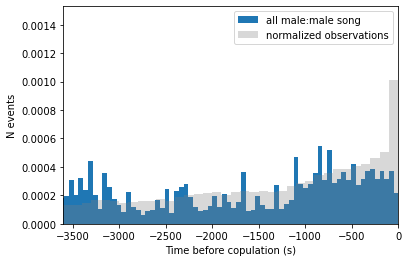

In [15]:
## Check for patterns prior to copulations

def rewind(meta,i,seconds,max_time = None):
    focal_time = meta.timestamps[i]
    past_times = np.argwhere((meta.timestamps >= (focal_time - seconds)) & (meta.timestamps < focal_time))

    if len(past_times) == 0:
        return i
    else:
        return past_times[0,0]

songs = []
boy_songs = []
boys2men = []
event_stamps = []
male_stamps = []
background_observations = []
for a in range(len(copulations)):
    #a = 0
    cops = copulations[a]
    daviary = sorteds[a]
    meta = metas[a]
    history = historys[a]
    print(daviary.shape)

    ts,ms,fs = np.where(cops ==5)

    for c in range(len(ts)):
        
        i = ts[c]
        i0 = rewind(meta,i,3900)

        #print(ts[c],ms[c],fs[c])
        window = history[i0:i,ms[c],fs[c]]
        #male_window = np.sum(history[i0:i,ms[c],meta.n_females:],1)
        male_window = np.sum(history[i0:i,meta.n_females:,meta.n_females:],1)
        background_window = np.sum(history[i0:i],axis=(1,2))
        events = np.argwhere(window == 1) + i0
        m_events = np.argwhere(male_window == 1) + i0
        b_events = np.argwhere(background_window == 1) + i0
        #print('timestamps,0:',meta.timestamps[events],meta.timestamps[i])
        event_stamps.extend(np.array(meta.timestamps[events] - meta.timestamps[i]).flatten())
        male_stamps.extend(np.array(meta.timestamps[m_events] - meta.timestamps[i]).flatten())
        b_stamps = np.array(meta.timestamps[b_events] - meta.timestamps[i]).flatten()
        b_stamps = np.unique(np.around(b_stamps,-2))
        background_observations.extend(b_stamps)
        #event_stamps.extend(np.array(meta.timestamps[events] - meta.timestamps[i]))
        #print(i0,events)
        #print(event_stamps)
        #print(meta.timestamps[events])
        #print(meta.timestamps[i])
        #print(meta.timestamps[events] - meta.timestamps[i])

        #songs.append(np.array(history[i0:i+1,ms[c],fs[c]]))
        #timestamps.append(meta.timestamps[i0:i+1] - meta.timestamps[i])
        #boy_songs.append(np.array(np.sum(history[i-100:i+1,ms[c],:],1)))
        #boys2men.append(np.array(np.sum(history[i-100:i+1],axis=(1,2))))   
        
"""
print(np.array(songs).shape)
summed_songs = np.sum(np.array(songs),0)
summed_boys = np.sum(np.array(boy_songs),0)
summed_men = np.sum(np.array(boys2men),0)

print(summed_boys)
summed_boys[100] = 0
summed_songs[100] = 0
summed_men[100] = 0   
"""     
fig,ax = plt.subplots()
#print(event_stamps)
hist_stamps = ax.hist(male_stamps,bins=78,label='all male:male song',density=True)
hist_br = ax.hist(background_observations,bins=39,alpha=.3,label='normalized observations',color='gray',density=True)

hist_stamps = np.histogram(male_stamps,bins=156)
hist_br = np.histogram(background_observations,bins=39)
hist_fem = np.histogram(event_stamps,bins=120)


#ax.hist(event_stamps,bins=120,label='songs between copulating pair',density=True)
ax.set_xlim([-3600,0])
#ax.set_ylim([0,300])

ax.set_xlabel('Time before copulation (s)')
ax.set_ylabel('N events')
"""ax.plot(summed_songs)
ax.plot(summed_boys)
ax.plot(summed_men)"""
ax.legend()

fig.show()

fig,ax = plt.subplots()
ax.imshow(np.sum(history,0))
fig.show()

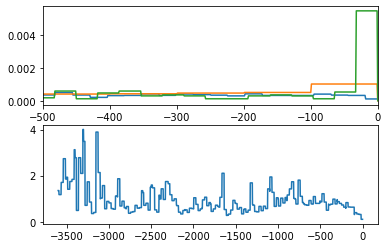

In [516]:
## Get a sense of the distribution of events
from scipy import stats
fig, (ax,ax1) = plt.subplots(2)
stamp_dist = stats.rv_histogram(hist_stamps)
br_dist = stats.rv_histogram(hist_br)
fem_dist = stats.rv_histogram(hist_fem)

X = np.linspace(-3600,0,3600)
ax.plot(X,stamp_dist.pdf(X))
ax.plot(X,br_dist.pdf(X))
ax.plot(X,fem_dist.pdf(X))
ax1.plot(X,stamp_dist.pdf(X)/br_dist.pdf(X))

ax.set_xlim(-500,0)
fig.show()

In [71]:
## Count some stuff:

males = 0
females = 0
observations = 0
days = 0
for m in metas:
    males += m.n_males
    females += m.n_females
    observations += len(m.timestamps)
    days += len(np.unique(m.dates))

print('Males,Females,n_days,n oberservations')
print(males,females,observations,days)
print('total copulations:',np.sum(np.sum(c) for c in copulations))

Males,Females,n_days,n oberservations
119 196 94595 407
total copulations: 605.0


5 12
14 13
6 11
16 13
10 27
8 15
8 20
11 24
8 11
9 10
11 21
13 19


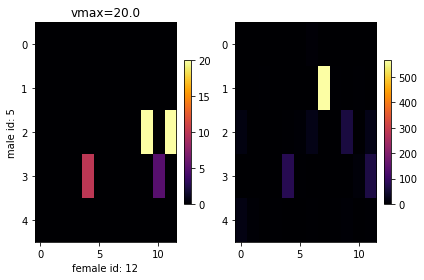

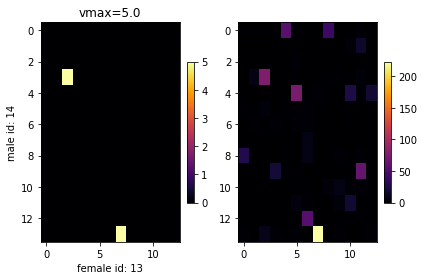

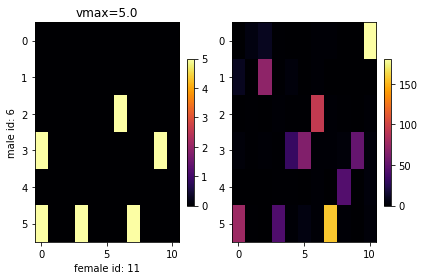

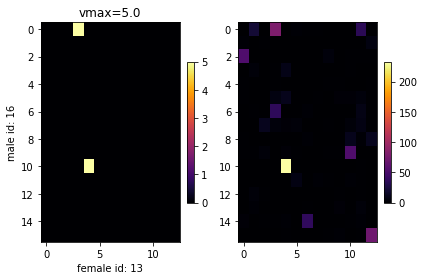

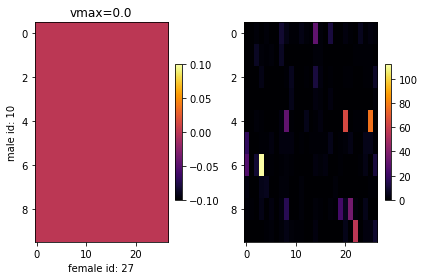

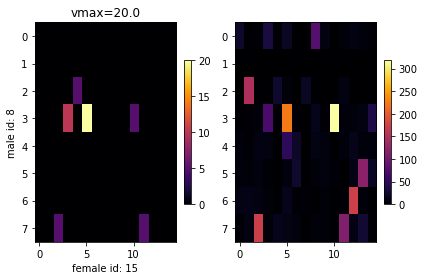

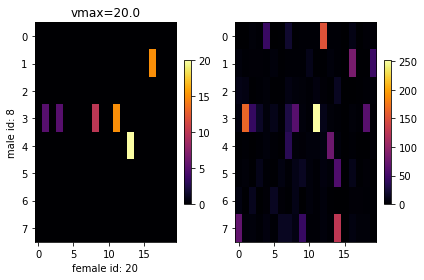

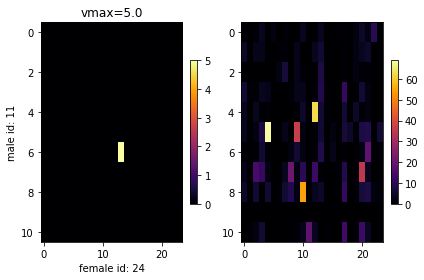

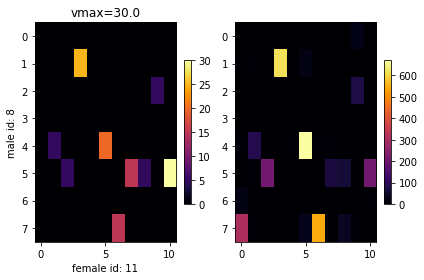

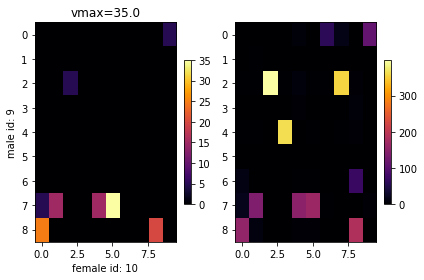

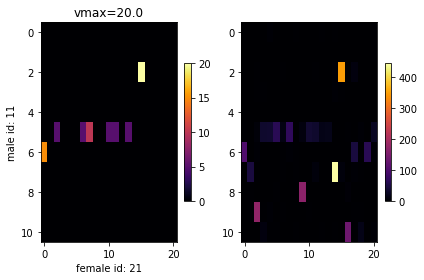

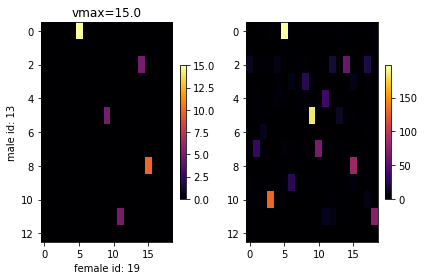

In [72]:
## Check out copulations and songs. 

for c in range(len(copulations)):
    copulation = copulations[c]
    history = historys[c]
    #n_females = metas[c].n_females
    fig,(ax,ax1) = plt.subplots(1,2)
    #print(copulations[0].shape)
    n_females = metas[c].n_females
    n_males = metas[c].n_males
    print(metas[c].n_males,metas[c].n_females)
    cops = ax.imshow(np.sum(copulation,axis=0)[n_females:,:n_females],cmap='inferno',aspect='auto')
    fig.colorbar(cops,fraction=0.046,ax=ax)
    songs = ax1.imshow(np.sum(history,axis=0)[n_females:,:n_females],cmap='inferno',aspect='auto')
    fig.colorbar(songs,fraction=0.046,ax=ax1)
    ax.set_xlabel('female id: ' + str(metas[c].n_females))
    ax.set_ylabel('male id: ' + str(metas[c].n_males))
    ax.set_title('vmax=' + str(np.max(np.sum(copulation,axis=0))))
    fig.tight_layout()
    fig.show()

n copulations: 10
PH1-2006
(147,) (147,)
males:, KstestResult(statistic=0.09523809523809523, pvalue=0.5190177492383604)
singing: KstestResult(statistic=0.08163265306122448, pvalue=0.713311608629472)
high song bins: 147 / 147
male singing: KstestResult(statistic=0.10204081632653061, pvalue=0.4296241972526024)
undirected singing: KstestResult(statistic=0.11564625850340136, pvalue=0.2799478952553812)
undirected chatter: KstestResult(statistic=0.034013605442176874, pvalue=0.9999966323837027)
female singing: KstestResult(statistic=0.08163265306122448, pvalue=0.713311608629472)

n copulations: 2
PH2-2006
(150,) (150,)
males:, KstestResult(statistic=0.11333333333333333, pvalue=0.29107399113413146)
singing: KstestResult(statistic=0.12, pvalue=0.23078236357216822)
high song bins: 150 / 150
male singing: KstestResult(statistic=0.12, pvalue=0.23078236357216822)
undirected singing: KstestResult(statistic=0.16, pvalue=0.04283167282545192)
undirected chatter: KstestResult(statistic=0.006666666666666

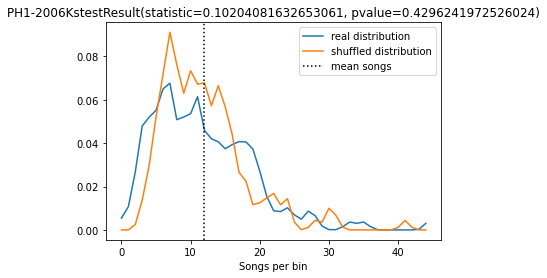

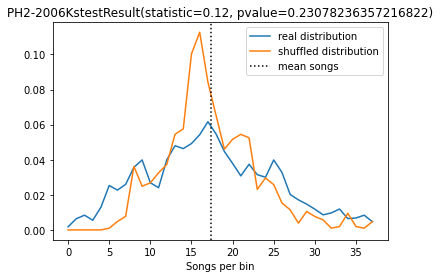

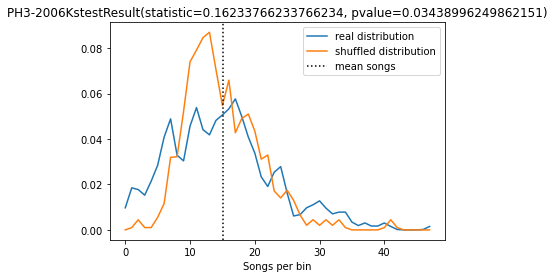

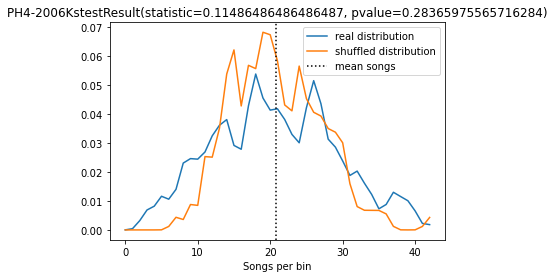

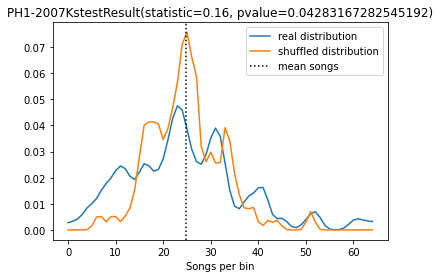

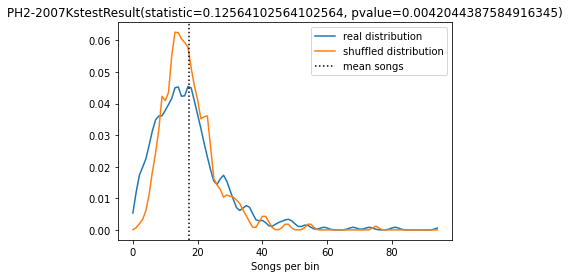

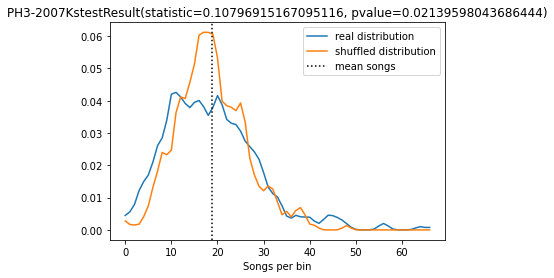

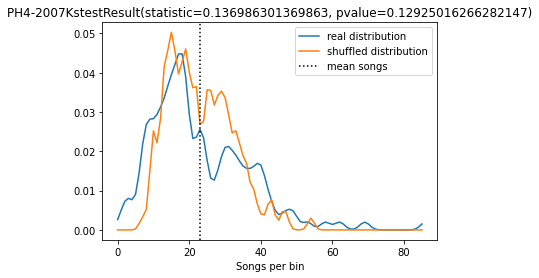

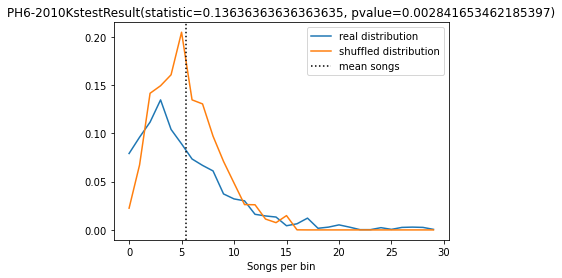

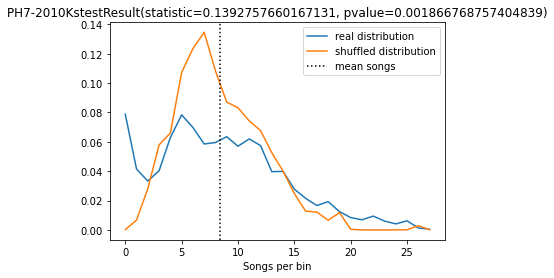

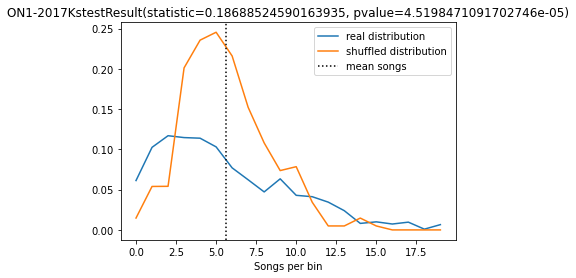

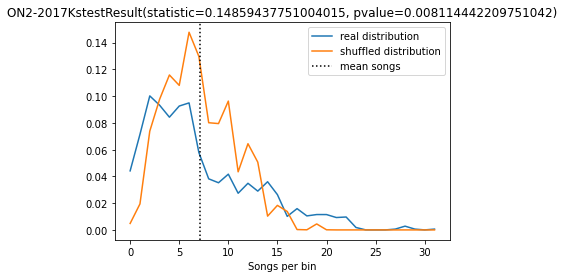

In [21]:
## Check all the aviaries for song vs non-song

n_copulations = []
song_stat = []
for a in range(len(metas)):
    n_males,n_females = metas[a].n_males,metas[a].n_females
    history_bins,[history_rate_bins,ts,window_indices] = bin_history(sorteds[a],historys[a],metas[a],
                                                                     window=300)

    
    cop_indices = get_cop_indices(copulations[a])
    cop_bin_indices = get_cop_bins(cop_indices,window_indices)
    
    straight_sum = np.sum(history_bins,axis=(1,2))
        
    shuffle_bins = shuffle_indy_bins(history_bins)
    shuffle_sum = np.sum(shuffle_bins,axis=(1,2))
    
    if len(cop_bin_indices) <= 1:
        print('no copulations')
        print(metas[a].name,cop_bin_indices)
        #continue
    print('n copulations:',len(cop_bin_indices)) 
    n_copulations.append(len(cop_bin_indices))
    if len(cop_bin_indices) > 1:
        cop_min,cop_max = cop_bin_indices[0],cop_bin_indices[-1]
        random_cop_indices = np.random.choice(np.arange(cop_min,cop_max),size=int(.5 * (cop_max-cop_min)),replace=False)

        cop_bins = history_bins[cop_bin_indices]
        cop_bins_m1 = history_bins[cop_bin_indices-1]
        cop_bins_shuffled = history_bins[random_cop_indices]
    
        cop_sum = np.array([np.sum])
    ## How precisely I should define "High-Song" bins is not obvious to me
    if False:
        hi_song_bins = history_bins[straight_sum > np.mean(straight_sum)] #np.mean(straight_sum)]
        hi_song_shuffle = shuffle_indy_bins(hi_song_bins)
    elif False:
        hi_song_bins = cop_bins_m1
        hi_song_shuffle = cop_bins_shuffled
    else:
        hi_song_bins = history_bins
        hi_song_shuffle = shuffle_indy_bins(hi_song_bins)
    """# Need to correct these for within high song windows, otherwise I'm just grabbing the same results

    undirected_straight = np.array([np.sum(np.diagonal(history_bins[i])) for i in range(len(history_bins))])
    undirected_shuffled = np.array([np.sum(np.diagonal(shuffle_bins[i])) for i in range(len(history_bins))])
    
    male_straight = np.sum(history_bins[:,n_females:,n_females:],axis=(1,2))
    female_straight = np.sum(history_bins[:,n_females:,:n_females],axis=(1,2))
    
    male_shuffled = np.sum(shuffle_bins[:,n_females:,n_females:],axis=(1,2))
    female_shuffled = np.sum(shuffle_bins[:,n_females:,:n_females],axis=(1,2))
    """
    
    undirected_straight = np.array([np.sum(np.diagonal(hi_song_bins[i,n_females:,n_females:])) for i in range(len(hi_song_bins))])
    undirected_shuffled = np.array([np.sum(np.diagonal(hi_song_shuffle[i,n_females:,n_females:])) for i in range(len(hi_song_bins))])                          
    
    unchatter_straight = np.array([np.sum(np.diagonal(hi_song_bins[i,:n_females,:n_females])) for i in range(len(hi_song_bins))])
    unchatter_shuffled = np.array([np.sum(np.diagonal(hi_song_shuffle[i,:n_females,:n_females])) for i in range(len(hi_song_bins))]) 
    
    male_straight = np.sum(hi_song_bins[:,n_females:,n_females:],axis=(1,2))
    female_straight = np.sum(hi_song_bins[:,n_females:,:n_females],axis=(1,2))
    
    male_shuffled = np.sum(hi_song_shuffle[:,n_females:,n_females:],axis=(1,2))
    female_shuffled = np.sum(hi_song_shuffle[:,n_females:,:n_females],axis=(1,2))
    
    all_straight = np.sum(hi_song_bins,axis=(1,2))
    all_shuffled = np.sum(hi_song_shuffle,axis=(1,2))
    
    male_presence = count_males(hi_song_bins,n_females)
    #male_presence_shuffled = shuffle_indy_bins(male_presence)
    male_presence_shuffled = count_males(hi_song_shuffle,n_females)
    male_counts = np.sum(male_presence,axis=1)
    male_counts_shuffled = np.sum(male_presence_shuffled,axis=1)
    
    
    print(metas[a].name)
    
    ## Plot it, if you feel like that
    if True:
        print(male_straight.shape,male_shuffled.shape)
        fig,ax = plt.subplots()
        straight_dist = gaussian_kde(male_straight,bw_method=.1)
        shuffle_dist = gaussian_kde(male_shuffled,bw_method=.1)

        #straight_dist = gaussian_kde(male_counts,bw_method=.01)
        #shuffle_dist = gaussian_kde(male_counts_shuffled,bw_method=.01)
        
        xs = np.arange(0,max(max(male_straight),max(male_shuffled)))

        
        ax.plot(xs,straight_dist(xs),label='real distribution')
        ax.plot(xs,shuffle_dist(xs),label='shuffled distribution')
        #ax.axvline(1)
        ax.axvline(np.mean(male_straight),color='black',label='mean songs',linestyle=':')
        #ax.axvline(np.median(male_straight),color='red')
        ax.set_title(metas[a].name + str(ks_2samp(male_straight,male_shuffled)))
        ax.set_xlabel('Songs per bin')
        ax.legend()
        fig.show()

    ## Need to actually chunk these into singing vs non-singing first
    #"""
    #print('n copulations:',np.sum(cop_bins))
    print('males:,',ks_2samp(male_counts,male_counts_shuffled))
        
    print('singing:',ks_2samp(straight_sum,shuffle_sum))
    print('high song bins:',len(male_straight),'/',len(straight_sum))
    print('male singing:',ks_2samp(male_straight,male_shuffled))

    print('undirected singing:',ks_2samp(undirected_straight,undirected_shuffled))
    print('undirected chatter:',ks_2samp(unchatter_straight,unchatter_shuffled))

    print('female singing:',ks_2samp(female_straight,female_shuffled))
    s_stat,s_p = ks_2samp(straight_sum,shuffle_sum)
    song_stat.append(s_stat)
    """ 
    print('all singing ttest:',ttest_ind(all_straight,all_shuffled))
    print('male singing (ttest):',ttest_ind(male_straight,male_shuffled))
    print('female singing (ttest):',ttest_ind(female_straight,female_shuffled))
    print('undirected (ttest):',ttest_ind(undirected_straight,undirected_shuffled))
    #"""
    print('')
    
#print(pearsonr(n_copulations,song_stat))

F_onewayResult(statistic=36.7441649146985, pvalue=1.5956843084536126e-74)


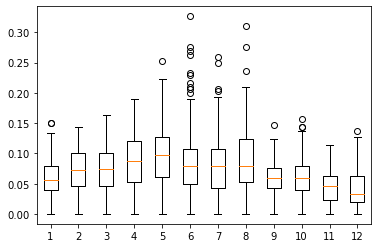

In [22]:
fig,ax = plt.subplots()
song_rates = []
male_rates = []
for a in range(len(metas)):
    n_males,n_females = metas[a].n_males,metas[a].n_females
    history_bins,[history_rate_bins,ts,window_indices] = bin_history(sorteds[a],historys[a],metas[a],
                                                                     window=300)
    aviary_song_rates = np.sum(history_rate_bins,axis=(1,2))
    male_song_rates = np.sum(history_rate_bins,axis=(2)).flatten()
    
    #ax.boxplot(aviary_song_rates,positions=[a]*len(aviary_song_rates))
    song_rates.append(aviary_song_rates)

ax.boxplot(song_rates)    
fig.show()

print(f_oneway(*song_rates))

In [1277]:


## Repeating the loop above, i wanted a fresh start
for a in range(len(metas)):
    n_males,n_females = metas[a].n_males,metas[a].n_females
    history_bins,[history_rate_bins,ts,window_indices] = bin_history(sorteds[a],historys[a],metas[a],window=200)
    
    cop_indices = get_cop_indices(copulations[a])
    cop_bin_indices = get_cop_bins(cop_indices,window_indices)
    
    ## Get predictable indices
    ## This isn't quite working...
    p = 2 # Prediction bins
    time_diff = ts[1:] - ts[:-1]
    pred_indices = time_diff < 300
    next_indices = np.hstack([False,pred_indices])
    pred_indices = np.hstack([pred_indices,False])
    
    predictors = history_bins[pred_indices]
    next_blocks = history_bins[next_indices]
    next_block_sum = np.sum(next_blocks,axis=(1,2))
    next_block_male2female = np.sum(next_blocks[:,n_females:,:n_females],axis=(1,2))
    X = np.reshape(predictors,[len(predictors),-1])
    y_fancy = np.reshape(next_blocks,[len(next_blocks),-1])
    #y = next_block_sum
    y = next_block_male2female
    """
    X = np.reshape(history_bins,[len(history_bins),-1])
    y = np.zeros(len(history_bins))
    
    if len(cop_bin_indices) < 5: 
        continue
    for c in cop_bin_indices:
        y[c] = 1

    ## Downsample so it's balanced
    useful_bins = sorted(np.hstack([np.random.choice(np.arange(len(X)),size=int(np.sum(y)),replace=False),
                             np.arange(len(X))[y==1]]))
    print(useful_bins)
    X = X[useful_bins]
    y = y[useful_bins]
    #"""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    clf = LR(class_weight='balanced')
    #clf = RFC(class_weight='balanced')
    clf.fit(X_train,y_train)
    test_preds = clf.predict(X_test)
    shuffled_test = np.random.permutation(y_test)
    print(metas[a].name,np.sum(copulations[a]))
    print('classifier:',np.mean(np.abs(test_preds - y_test)),clf.score(X_test,y_test))
    print('shuffled:',np.mean(np.abs(test_preds - shuffled_test)),clf.score(X_test,shuffled_test))
    X_test_square = np.reshape(X_test,[len(X_test),metas[a].n_birds,metas[a].n_birds])
    y_heuristic = np.sum(X_test_square[:,n_females:,:n_females],axis=(1,2))
    print('tangent:',np.mean(np.abs(y_test - y_heuristic)),np.mean(y_heuristic == y_test))

## Tangent is the performance if you just use a very simple heuristic. 

PH1-2006 60.0
classifier: 4.257142857142857 0.05714285714285714
shuffled: 4.771428571428571 0.02857142857142857
tangent: 3.342857142857143 0.14285714285714285
PH2-2006 10.0
classifier: 2.5135135135135136 0.2702702702702703
shuffled: 3.2162162162162162 0.24324324324324326
tangent: 2.3783783783783785 0.2702702702702703
PH3-2006 35.0
classifier: 3.0 0.2222222222222222
shuffled: 3.388888888888889 0.1388888888888889
tangent: 2.638888888888889 0.2777777777777778
PH4-2006 10.0
classifier: 2.611111111111111 0.1111111111111111
shuffled: 3.6666666666666665 0.0
tangent: 2.5555555555555554 0.2222222222222222
PH1-2007 0.0
classifier: 3.054054054054054 0.13513513513513514
shuffled: 3.918918918918919 0.13513513513513514
tangent: 2.3783783783783785 0.21621621621621623
PH2-2007 50.0
classifier: 3.521276595744681 0.11702127659574468
shuffled: 3.8617021276595747 0.09574468085106383
tangent: 2.6914893617021276 0.13829787234042554
PH3-2007 70.0
classifier: 2.723404255319149 0.1595744680851064
shuffled: 3.2

In [24]:
## Using the best result above (aviary #3) how far does it go? 

## This basically fails, presumably on account of not removing the bins, so instead lets focus on predictability. 
history_bins,[history_rate_bins,ts,window_indices] = bin_history(sorteds[a],historys[a],metas[a],window=200)
iterations = 10

max_shift = 5
scores = np.zeros([max_shift,iterations])
rand_scores = np.zeros_like(scores)
for bin_shift in range(max_shift):
    if bin_shift == 0:
        predictors = history_bins
    else:
        predictors = history_bins[:-bin_shift]
    next_blocks = history_bins[bin_shift:]
    next_block_sum = np.sum(next_blocks,axis=(1,2))
    X = np.reshape(predictors,[len(predictors),-1])
    y = next_block_sum

    for i in range(iterations):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
        #clf = LR()
        clf = RFR()
        clf.fit(X_train,y_train)
        test_preds = clf.predict(X_test)
        shuffled_test = np.random.permutation(y_test)
        
        #print(np.mean(np.abs(test_preds - y_test)),clf.score(X_test,y_test))
        #print(np.mean(np.abs(test_preds - shuffled_test)),clf.score(X_test,shuffled_test),'\n')
        scores[bin_shift,i] = clf.score(X_test,y_test)
        rand_scores[bin_shift,i] = clf.score(X_test,shuffled_test)

In [210]:
print(transition_count[:5])
print(np.argmax(transition_count[:5],axis=1))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  

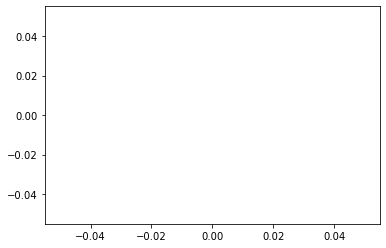

In [159]:
## This works, but not in jupyter, because of my weird conda build. 

if False:
    from matplotlib.animation import FuncAnimation


    points = np.sum(male_states,axis=1)

    fig, ax = plt.subplots()

    #scat = ax.scatter([],[])
    line, = ax.plot([],[])

    def init0():
        ax.set_xlim(-0.1,4.1)
        ax.set_ylim(-0.1,4.1)
        return scat,

    def init():
        line.set_data([0,0],[.1,.1])
        ax.set_xlim(-0.1,4.1)
        ax.set_ylim(-0.1,4.1)
        return (line,)

    def animate(i):
        x,y = points[i]
        line.set_data(x,y)
        return line,

    anim = FuncAnimation(fig,animate,frames=range(len(points)),init_func=init, interval=20)

    #anim.save('points.gif',writer='imagemagick')
    plt.show()


In [160]:
## Export the points so I can do this in a simple python script. 
np.save('points.npy',points)

## Old Stuff:

In [1301]:
## Define f_attention function, which identifies how females allocate rattles
## Returns f_calls, f_leaves, m_songs,[mean_ratios,rattle_dates,song_dates]
## This function is doing a lot of work now, it's a bit unweildy...
def f_attention(history_data, sorted_data, meta_data):
    rattle_dates_raw = np.zeros([n_days,meta_data.n_females,6])
    rattle_dates = np.zeros([n_days,meta_data.n_females,4])
    song_dates = np.zeros_like(rattle_dates)
    ## REMEBER To change this: 
    #song_dates =np.empty_like(rattle_dates)
    #song_dates.fill(np.nan)
    f_pairmates = np.empty(meta_data.n_females)
    f_vicemates = np.empty(meta_data.n_females)
    
    ## Build the pairbond and vice pairbond lists that I'll need to use

    for f in range(meta_data.n_females):
        
        ## This needs to be cutoff:
        song_sums = history_data[:meta_data.cutoff].sum(0)[meta_data.n_females:,f]
        #print(song_sums,f)
        #print(f_pairmates,np.argmax(song_sums))
        f_pairmates[f] = int(np.argmax(song_sums))
        #print(f_pairmates[f])
        song_sums[int(f_pairmates[f])] = 0 
        #print(song_sums)
        
        f_vicemates[f] = np.argmax(song_sums)
        #print(f_pairmates,f_vicemates)
        
        
    meta_data.f_pairmates = f_pairmates
    meta_data.f_vicemates = f_vicemates
    
    f_calls = np.zeros([meta_data.n_females,meta_data.n_males])

    f_leaves = np.zeros([meta_data.n_females,meta_data.n_males])
    m_songs = np.zeros([meta_data.n_males,meta_data.n_females])
    ## Every time there's a rattle, add it to rattle counts, and add it to the by_day array

    for n in range(meta_data.cutoff):
        
        i = sorted_data[n,0]
        j = sorted_data[n,1]
        info = sorted_data[n,2]
        
        ## Get the date for this row (just need the day in this case)
        date_raw = sorted_data[n,5]
        _,ymd = date_to_sec(date_raw,meta_data.date_format)
        md = str(ymd[1] + '-' + ymd[2])
        day_index = day_to_index[md]
        
        ## Deal with all Male > interactions
        if i in meta_data.m_ids or i == 'male':
            ## For now, ignore all male> interactions
            if j in meta_data.m_ids or j == 'male':
                pass
            ## Otherwise, if it's a female, put it in male-female
            elif j in meta_data.f_ids:
                female = np.where(meta_data.f_ids == j)[0][0]
                male = np.where(meta_data.m_ids == i)[0][0]
                #print(f_pairmates[female],male)
                if f_pairmates[female] == male:
                    shift = 0
                    #print('pairbond!')
                elif f_vicemates[female] == male:
                    shift = 2
                else:
                    shift = 4
                m_songs[male,female] = m_songs[male,female] + 1
                ## ****Add the male song****
                rattle_dates_raw[day_index,female,0+shift] += 1
                
                ## Add valence, does it elicit a positive--or negative--response?
                if info.lower() == 'rattle': 
                    f_calls[female,male] = f_calls[female,male] + 1
                    ## ****Add the rattle****
                    #print('rattle!')
                    rattle_dates_raw[day_index,female,1+shift] += 1
                elif info.lower() == 'leave' or info.lower() == 'depart':
                    f_leaves[female,male] = f_leaves[female,male] + 1
            ## Otherwise it's male-unknown
            else:
                pass
        ## Deal with the few female > interactions
        elif i in meta_data.f_ids:
            if j in meta_data.m_ids:
                male = np.where(meta_data.m_ids == j)
                female = np.where(meta_data.f_ids==i)
                #if info == 'leave' or info == 'lunge':
                if info.lower() == 'leave' or info.lower() == 'depart':
                    f_leaves[female,male] = f_leaves[female,male] + 1
                elif info.lower() == 'rattle':
                    f_calls[female,male] = f_calls[female,male] + 1
            elif j in meta_data.f_ids or j == 'female':
                pass
            ## I don't actually use this logic anymore since I'm averaging, but it could be useful.
            if sorted_data[n-1,1] == i: # If the female was just sung to
                previous_singer = sorted_data[n-1,0]
                if previous_singer in meta_data.m_ids: ## This means she was just sung to by a male
                    male = np.where(meta_data.m_ids == previous_singer)
                    
                    #m_songs[male,female] = m_songs[male,female] + 1

                    if j.lower() == 'rattle':
                        pass
                        #f_calls[female,male] = f_calls[female,male] + 1
                    elif j.lower() == 'leave' or j.lower() == 'depart':
                        pass
                        #f_leaves[female,male] = f_leaves[female,male] + 1     
            else:
                pass
        ## Deal with any other/unknown interactions
        else:
            pass
    #print(np.max(rattle_dates_raw,1))
    ## Allow for a sliding window, if win=0 this just takes the day
    win = 0
    padded_dates = np.zeros([len(rattle_dates_raw) + win*2,meta_data.n_females,6])
    if win == 0:
        padded_dates = np.array(rattle_dates_raw)
    else:
        padded_dates[win:-win] = rattle_dates_raw
    
    for d in range(len(rattle_dates_raw)):
        p = d + win
        for b in range(meta_data.n_females):
            q = p-win
            r = p+win+1
            
            ## vpb is the vice pairbond, o is all other birds (i.e. 3rd-worst)
            
            vpb_rattles = np.nansum(padded_dates[q:r,b,3])
            o_rattles = np.nansum(padded_dates[q:r,b,5])
            
            vpb_songs = np.nansum(padded_dates[q:r,b,2])
            o_songs = np.nansum(padded_dates[q:r,b,4])
            pb_songs = np.nansum(padded_dates[q:r,b,0])
            all_other_songs = o_songs + vpb_songs
            
            pb_ratio= np.sum(padded_dates[q:r,b,1]) / (np.sum(padded_dates[q:r,b,0]))# + .0001)
            vpb_ratio= np.sum(padded_dates[q:r,b,3]) / (np.sum(padded_dates[q:r,b,2]))# + .0001)
            o_ratio= np.sum(padded_dates[q:r,b,5]) / (np.sum(padded_dates[q:r,b,4]))# + .0001)
            
            if ~np.isnan(pb_ratio):
                pb_ratio = np.clip(pb_ratio,0,1)
            if ~np.isnan(vpb_ratio):
                vpb_ratio = np.clip(vpb_ratio,0,1)
            if ~np.isnan(o_ratio):
                o_ratio = np.clip(o_ratio,0,1)
            all_other_ratio = (o_rattles + vpb_rattles) / (o_songs + vpb_songs)
            if ~np.isnan(all_other_ratio):
                all_other_ratio = np.clip(all_other_ratio,0,1)
            """
            pb_ratio =  rattle_dates_raw[d,b,1] / (rattle_dates_raw[d,b,0] + .0001)
            vpb_ratio = rattle_dates_raw[d,b,3] / (rattle_dates_raw[d,b,2] + .0001) 
            ## This could be all other, or non-vice other. I've chosen all other here. 
            o_ratio = (rattle_dates_raw[d,b,3] + rattle_dates_raw[d,b,5]) / (.0001 + rattle_dates_raw[d,b,2] + rattle_dates_raw[d,b,4])
            """
            pb_ratio = np.round(pb_ratio,3)
            vpb_ratio = np.round(vpb_ratio,3)
            o_ratio = np.round(o_ratio,3)
            ## Deal with 0:nan cases. If no song, ratio is nan, not infinity, or 0. 
            if rattle_dates_raw[d,b,0] == 0:
                pb_ratio = np.nan
            if rattle_dates_raw[d,b,2] == 0:
                vpb_ratio = np.nan
            if rattle_dates_raw[d,b,4] == 0:
                o_ratio = np.nan
            #pb_vpb_ratio = np.round(pb_ratio / (vpb_ratio),3) 
            pb_vpb_ratio = np.round(pb_ratio / all_other_ratio,3)
            pb_vpb_song_ratio = np.round(pb_songs / (vpb_songs + o_songs),3)
            #print(pb_vpb_ratio,pb_ratio,vpb_ratio,o_ratio)
            
            ## Decide whether to include vpb in other
            if False:
                rattle_dates[d,b] = [pb_vpb_ratio,pb_ratio,vpb_ratio,o_ratio]
                song_dates[d,b] = [pb_vpb_song_ratio,pb_songs,vpb_songs,o_songs]
            else:
                rattle_dates[d,b] = [pb_vpb_ratio,pb_ratio,vpb_ratio,all_other_ratio]
                song_dates[d,b] = [pb_vpb_song_ratio,pb_songs,vpb_songs,all_other_songs]
            
    rattle_dates = np.round(rattle_dates,2)
    clipped_dates = np.clip(rattle_dates,0,100)
    #print('clipped dates mean:')
    #print(np.sum(rattle_dates_raw,axis=(0,1)))
    day_means = nanmeanwrapper(clipped_dates,axis=1)
    #print(day_means)
    mean_ratios = np.divide(day_means[:,1],day_means[:,3]) # This is pb ratio / other ratio
    mean_ratios = np.clip(mean_ratios,0,2000)
    
    if False:
        fig,(ax,ax2) = plt.subplots(1,2)

        #print(rattle_dates[:,3],clipped_dates[:,3])
        #ax.hist(clipped_dates[:,:,0][~np.isnan(clipped_dates[:,:,0])])
        #ax.plot(range(n_days),mean_ratios)
        for b in range(rattle_dates.shape[1]):
            ax.plot(range(rattle_dates.shape[0]),rattle_dates[:,b,1])
            ax2.plot(range(rattle_dates.shape[0]),rattle_dates[:,b,3])
        ax.set_title('Pairbond Rattle Rate')
        ax2.set_title('All Other rattle Rate')
        ax.set_xlim([0,n_days])
        ax2.set_xlim([0,n_days])
        ax.set_ylim([0,1])
        ax2.set_ylim([0,1])
        fig.show()
    return f_calls, f_leaves, m_songs,[mean_ratios,rattle_dates,song_dates]


In [1302]:
## Build the rattle_dates and song_dates arrays which will be used below

np.set_printoptions(suppress=True)
## Make a list of all the days that show up
day_list = []
for s in range(len(sorteds)):
    sorted_data = sorteds[s]
    meta_data = metas[s]
    unique_days = np.unique(sorted_data[:,5])
    for day in unique_days:
        _,ymd = date_to_sec(day,meta_data.date_format)

        md = str(ymd[1] +'-'+ ymd[2])
        if md not in day_list:
            day_list.append(md)

day_list = sorted(day_list)
day_to_index = dict(zip(day_list,range(len(day_list))))
n_days = len(day_list)



summed_ratios = np.empty([len(historys),n_days])

## These initializations just make sure this loop works if you rerun it
rattle_dates = 0
song_dates = 0

## We also need to keep track of where aviaries start and stop
aviary_splits = [0]


for i in range(len(historys)):
    a,b,c,[mean_ratios,rattle_dates_a,song_dates_a] = f_attention(historys[i],sorteds[i],metas[i])
    #ax_.plot(np.nanmean(rattle_dates_a[:,:,3]))
    summed_ratios[i] = mean_ratios
    
    #print(rattle_dates.shape,rattle_dates_a.shape)
    try:
        rattle_dates = np.hstack((rattle_dates,rattle_dates_a))
        song_dates = np.hstack((song_dates,song_dates_a))
    except:
        rattle_dates = np.array(rattle_dates_a)
        song_dates = np.array(song_dates_a)

    aviary_splits.append(rattle_dates.shape[1])

aviary_splits = np.array(aviary_splits)

## Tbh I don't think I use this anymore, but it might be important for old code working
summed_ratios = summed_ratios / len(historys)

## optionally plot counts for every aviary
if False:
    fig,(ax,ax1,ax2,ax3,ax4,ax5) = plt.subplots(6)
    last_split = 0

    
    for a in aviary_splits[1:]:
        ax.plot(np.nanmean(rattle_dates[:,last_split:a,1],1)) ## plot pb rattle rate
        #ax1.plot(np.nanmean(rattle_dates[:,last_split:a,3],1)) ## plot vpb rattle rate
        ax1.plot(np.nansum(song_dates[:,last_split:a,3],1) * np.nansum(rattle_dates[:,last_split:a,3],1)) # plot vpb rattle count
        ax2.plot(np.nansum(song_dates[:,last_split:a,3],1)) ## plot npb song counts
        ax3.plot(np.nansum(song_dates[:,last_split:a,1],1)) ## plot pb song counts
        ax4.plot(np.nansum(song_dates[:,last_split:a,2],1)) ## plot vice pb song counts
        ax5.plot(np.nansum(rattle_dates[:,last_split:a,2],1),alpha=.4)
        last_split = a

    ax5.plot(np.nanmean(rattle_dates[:,:,2],1),color='black')

    #ax5.plot(np.nansum(~np.isnan(rattle_dates[:,:,2]),0))
    #ax5.plot(np.nansum(~np.isnan(rattle_dates[:,:,1]),0))      

    ax.set_title('Pairbond Rattle Rate')
    #ax1.set_title('Non pairbond Rattle Rate')
    ax1.set_title('Non pb rattle count')
    ax2.set_title('Non pairbond song rate')
    ax3.set_title('Pairbond song rate')
    ax4.set_title('Vice pairbond song rate')
    ax4.set_ylim([0,250])
    ax5.set_title('Vice pairbond rattle rate')
    fig.set_size_inches(6,12)
    fig.tight_layout()
    fig.show()


In [1303]:
## Create the sparse arrays to avoid averaging in a lot of 0's for days without data 
# If there is no data from an aviary, replace those birds with np.nan
song_dates_sparse = np.array(song_dates)
rattle_dates_sparse = np.array(rattle_dates)
(n_days,n_females,n_data) = song_dates.shape
aviary_minutes = np.zeros([n_days,n_females])
day_minutes = np.zeros(n_days)

count = 0
females_per_day = np.zeros(n_days)
for m in range(len(metas)):
    date_check = np.zeros(95)
    time_list = [[] for d in range(len(date_check))]

    for ts in metas[m].timestamps[:metas[m].cutoff]:
        dt = datetime.fromtimestamp(ts)
        month = str(dt.month).zfill(2)
        day = str(dt.day).zfill(2)
        
        date = month + '-' + day
        time = datetime.strftime(dt,'%H:%M')
        if date in day_list:
            date_check[day_to_index[date]] = 1
            if time == '00:00':
                #print('bad',day_to_index[date],time)
                count += 1
                date_check[day_to_index[date]] = 1
                time_list[day_to_index[date]].append(count)
                continue
            else:
                time_list[day_to_index[date]].append(time)

    for d in range(len(date_check)):
        minutes = np.unique(time_list[d])

        aviary_minutes[d,aviary_splits[m]:aviary_splits[m+1]] = len(minutes)
        day_minutes[d] = day_minutes[d] + len(minutes)
        if date_check[d] == 1:
            females_per_day[d] += metas[m].n_females
        if date_check[d] == 0:
            song_dates_sparse[d,aviary_splits[m]:aviary_splits[m+1],:] = [np.nan,np.nan,np.nan,np.nan]
            rattle_dates_sparse[d,aviary_splits[m]:aviary_splits[m+1],:] = [np.nan,np.nan,np.nan,np.nan]

rattle_dates_sparse[rattle_dates_sparse == np.inf] = np.nan
song_dates_sparse[song_dates_sparse == np.inf] = np.nan

print('Females per day:')
print(females_per_day)

## This will force it to only use days where we have at least 3 aviaries present by dividing out other days
females_per_day[females_per_day <= 36] = 0

IndexError: index 95 is out of bounds for axis 0 with size 95

In [142]:
print(points)

[[1.5 1.5]
 [1.5 0.5]
 [1.5 1.5]
 [2.  2. ]
 [0.5 1.5]
 [2.  1. ]
 [2.  2. ]
 [1.5 2.5]
 [1.5 1.5]
 [1.5 0.5]
 [1.  1. ]
 [1.5 0.5]
 [1.  1. ]
 [2.  2. ]
 [1.5 2.5]
 [3.5 1.5]
 [2.  1. ]
 [1.  1. ]
 [1.  1. ]
 [3.  1. ]
 [1.5 1.5]
 [1.  3. ]
 [1.5 1.5]
 [1.  1. ]
 [1.  1. ]
 [1.  1. ]
 [0.5 1.5]
 [1.  1. ]
 [0.5 0.5]
 [1.5 0.5]
 [3.  2. ]
 [2.  1. ]
 [2.  2. ]
 [3.  2. ]
 [2.  2. ]
 [2.  2. ]
 [1.  2. ]
 [1.  1. ]
 [0.5 0.5]
 [2.5 0.5]
 [3.  1. ]
 [3.  1. ]
 [2.  2. ]
 [0.5 0.5]
 [2.  1. ]
 [2.  2. ]
 [1.  1. ]
 [0.5 1.5]
 [0.5 1.5]
 [0.5 1.5]
 [0.5 2.5]
 [1.5 1.5]
 [1.  1. ]
 [1.  2. ]
 [2.5 0.5]
 [2.  0. ]
 [2.5 0.5]
 [2.5 0.5]
 [3.  1. ]
 [1.5 1.5]
 [0.  1. ]
 [3.  0. ]
 [1.  2. ]
 [0.  1. ]
 [0.5 0.5]
 [1.5 2.5]
 [1.  3. ]
 [2.5 0.5]
 [1.5 1.5]
 [1.  1. ]
 [2.  0. ]
 [2.  1. ]
 [0.  1. ]
 [1.5 1.5]
 [3.  1. ]
 [1.5 2.5]
 [2.5 0.5]
 [1.  2. ]
 [2.  0. ]
 [2.5 0.5]
 [1.  1. ]
 [2.  1. ]
 [2.5 0.5]
 [1.5 0.5]
 [3.  0. ]
 [2.5 0.5]
 [2.  1. ]
 [2.5 0.5]
 [1.  1. ]
 [1.  2. ]
 [2.  1. ]

In [ ]:
## Check for predictability with variable parameters

a = 2
p=2
b=0
for p in [1,2,3,4]:
    history_bins,[history_rate_bins,ts,window_indices]= bin_history(sorteds[a],historys[a],metas[a],window=100)

    """
    clf,clf_sets = predict_future(history_bins,ts,metas[a],pred_window=1,bin_skips=0,window=100)
    print(clf.score(clf_sets[1],clf_sets[3]))
    print(clf.score(clf_sets[1],np.random.permutation(clf_sets[3])))
    print(len(clf_sets[0]))
    """
    iterations = 30
    clf_scores,random_scores = [],[]
    for i in range(iterations):
        clf,clf_sets = predict_future(history_bins,ts,
                        metas[a],pred_window=p,bin_skips=b,window=100,classifier=LR())
        clf_scores.append(clf.score(clf_sets[1],clf_sets[3]))
        random_scores.append(clf.score(clf_sets[1],np.random.permutation(clf_sets[3])))
    print('pred window:',p)
    print('n skips=',b)
    print('Mean Classifer vs random:',np.mean(clf_scores),np.mean(random_scores))
    print(ttest_ind(clf_scores,random_scores))
    print('dataset size:',len(clf_sets[0]))
    print()

In [ ]:
fig,ax = plt.subplots()
ax.hist(clf_scores,label='classifier performance')
ax.hist(random_scores,label='shuffled performance')

fig.legend()
fig.show()

In [ ]:
fig,ax = plt.subplots()

ax.bar(range(max_shift),np.mean(scores,1),yerr=np.std(scores,1),width=.4)
ax.bar(np.arange(max_shift) +.4,np.mean(rand_scores,1),yerr=np.std(scores,1),width=.4)
fig.show()

In [ ]:
straight_dist = gaussian_kde(straight_sum,bw_method=.1)
shuffle_dist = gaussian_kde(shuffle_sum)
fig,ax = plt.subplots()
xs = np.linspace(min(straight_sum),max(straight_sum),50)


ax.plot(xs,straight_dist(xs))
ax.plot(xs,shuffle_dist(xs))
ax.axvline(np.mean(straight_sum))
ax.axvline(np.median(straight_sum),color='red')

fig.show()

In [ ]:
#print(window_indices)


shuffle_bins = shuffle_indy_bins(history_bins)
print(shuffle_bins.shape)

shuffle_sum = np.sum(shuffle_bins,axis=(1,2))
straight_sum = np.sum(history_bins,axis=(1,2))
print(straight_sum.shape)

fig,ax = plt.subplots()
ax.hist(straight_sum,alpha=.5)
ax.hist(shuffle_sum,alpha=.5)


fig.show()


print(ks_2samp(straight_sum,shuffle_sum))

In [ ]:
#print(window_indices)
all_counts,window_indices = count_sequence(sorteds[a],metas[a],window=200,plot_me=-2,g_kernel = .1,t0=-234)
all_the_data = []
for i0,ix in window_indices:
    n_females = metas[-1].n_females
    all_the_data.append(np.sum(historys[a][i0:ix,n_females:],0).flatten())
    
all_the_data = np.array(all_the_data)
print(all_the_data.shape)

fig,ax = plt.subplots()
ax.imshow(all_the_data[1].reshape([metas[s].n_males,metas[s].n_birds]))

print(np.unique(all_the_data[1]))
fig.show()

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
X = all_the_data
print(X.shape[1])
pca = PCA(n_components=X.shape[0])
pca.fit(X)
print(pca.explained_variance_ratio_[:10])
#print(pca.singular_values_)

In [ ]:
fig,ax = plt.subplots()
summed_variance = np.ones(len(X))
for i in range(len(X)):
    summed_variance[i] = np.sum(pca.explained_variance_ratio_[:i])
ax.scatter(range(len(X)),pca.explained_variance_ratio_,label='Variance explained')
ax.scatter(range(len(X)),summed_variance,label='Summed Variance Explained')
ax.axvline(np.argmax(summed_variance > .5))
ax.set_ylim([0,.5])
fig.legend()
fig.show()

In [ ]:
y = pca.transform(X)

print(pca.explained_variance_ratio_[:10])
#print(pca.components_[0])
fig,ax = plt.subplots()
ax.scatter(range(len(pca.components_[0])),pca.components_[0],alpha=.4)
ax.scatter(range(len(pca.components_[1])),pca.components_[1],alpha=.4)
fig.show()

fig,ax = plt.subplots()
heatmap = np.reshape(pca.components_[0],[metas[-1].n_males,metas[-1].n_birds])
ax.imshow(heatmap)
fig.show()
                     

In [ ]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

import umap
import numba

print(numba.__version__)
data = np.random.rand(800, 4)
fit = umap.UMAP()
u = fit.fit_transform(data)

In [ ]:
for a in range(len(metas)):

    all_counts,window_indices = count_sequence(sorteds[a],metas[a],window=200,plot_me=-2,g_kernel = .1,t0=-234)
    all_the_data = []
    for i0,ix in window_indices:
        n_females = metas[a].n_females
        all_the_data.append(np.sum(historys[a][i0:ix,n_females:],0).flatten())
    
    all_counts = np.array(all_counts)
    clean_counts = all_counts[:,~np.isnan(all_counts[0])]
    normed_counts = np.divide(clean_counts.transpose(),np.nanmax(clean_counts,1)).transpose()

    X = np.array(all_the_data)
    print('Shape:',X.shape)
    pca = PCA(n_components=20)
    X = pca.fit_transform(X)
    print(sum(pca.explained_variance_ratio_),pca.explained_variance_ratio_)

    fig,ax = plt.subplots()
    ax.scatter(X[:,0],X[:,1],c=normed_counts.transpose())
    fig.show()
    fit = umap.UMAP()
    #scaled_X = StandardScaler().fit_transform(X.transpose())


    u = fit.fit_transform(X)

    fig,ax = plt.subplots()
    ax.scatter(u[:,0],u[:,1],alpha=.6,marker='.',c=normed_counts.transpose())
    fig.show()


In [ ]:
all_counts = np.array(all_counts)
print(all_counts.shape)
#print(all_counts[:,~np.isnan(all_counts[0])].shape)
clean_counts = all_counts[:,~np.isnan(all_counts[0])]
print(clean_counts.shape)
print(np.nanmax(all_counts,1))
normed_counts = np.divide(clean_counts.transpose(),np.nanmax(clean_counts,1)).transpose()


In [ ]:
fit = umap.UMAP(min_dist=.5,n_neighbors=10)
u = fit.fit_transform(normed_counts.transpose())

fig,ax = plt.subplots()
ax.scatter(u[:,0],u[:,1],c=normed_counts.transpose())
fig.show()

In [ ]:
fit = umap.UMAP(min_dist=.1)
#scaled_X = StandardScaler().fit_transform(X.transpose())
u = fit.fit_transform(X)
print(u.shape)
fig,ax = plt.subplots()
ax.scatter(u[:,0],u[:,1],alpha=.8,marker='o',c=normed_counts.transpose())
fig.show()

In [ ]:
from scipy.stats import kde
print(sorteds[-1][0])
%matplotlib inline

_ = count_sequence(sorteds[-1],metas[-1],window=200,plot_me = 2,g_kernel=3,t0=-230)

In [ ]:
np.array(all_counts_m) > np.array(all_counts_f)

for key, group in itertools.groupby( 1 - male_high )

In [ ]:

condition = [True,True,True,False,False,True,True,False,True]
male_high = np.array(all_counts_m) > np.array(all_counts_f)

m_lengths = [ sum( 1 for _ in group ) for key, group in itertools.groupby( male_high ) if key ]
f_lengths = [ sum( 1 for _ in group ) for key, group in itertools.groupby( 1 - male_high ) if key ]


fig,ax = plt.subplots()
ax.hist(m_lengths)
ax.hist(f_lengths)
fig.show()

## Plots start here

In [ ]:
## This cell does a lot of the analysis necessary for the old fig 4, but some of the other figures need this too.
# This should really probably be a function
%matplotlib inline

## Plots a line, useful in some placese, although I don't use it that much anymore. 
def plot_mb(ax,slope,intercept, **kwargs):
    ax = ax
    xlim = ax.get_xlim()
    x0 = xlim[0]
    y0 = intercept + slope * x0
    x1 = xlim[1]
    y1 = intercept + slope * x1
    return ax.plot([x0,x1],[y0,y1], **kwargs)

all_songs_norm = np.array([])
all_rattle_probs = np.empty_like(all_songs_norm)
all_leave_probs = np.empty_like(all_songs_norm)
all_pairbond_counts = np.empty_like(all_songs_norm)

all_data_by_bird = []
all_the_bars = np.array([])
all_the_errs = np.array([])
all_the_stds = np.array([])

SKEW = True
## Loop through all the aviaries and grab statistics. This would be useful if I wanted to get other things too.
for a in range(len(historys)):
    aviary_index = a

    history_data = historys[aviary_index]
    sorted_data = sorteds[aviary_index]
    meta_data = metas[aviary_index]

    
    f_calls, f_leaves, summed_investment,_ = f_attention(history_data, sorted_data, meta_data)
    f_calls[np.transpose(summed_investment) == 0] = 0
    
    #f_calls[f_calls <= 1] = 0
    #print(f_calls)
    #print(f_leaves)
    #print(history_data.sum(0)[meta_data.n_females:,:meta_data.n_females])

    #summed_investment = history_data[:meta_data.cutoff].sum(0)[meta_data.n_females:,:meta_data.n_females] 
    summed_investment = history_data.sum(0)[meta_data.n_females:,:meta_data.n_females]

    normed_investment = np.empty([meta_data.n_females,meta_data.n_males])
    normed_calls = np.empty_like(normed_investment)
    normed_leaves = np.empty_like(normed_investment)
    for f in range(meta_data.n_females):
        normed_investment[f] = summed_investment[:,f] / summed_investment[:,f].sum()
        normed_calls[f] = f_calls[f] / (f_calls[f].sum() + .0001)
        normed_leaves[f] = f_leaves[f] / (f_leaves[f].sum() + .0001)


    aviary = meta_data.name
    males = meta_data.m_ids
    females = meta_data.f_ids

    pairbonds = np.nanargmax(np.transpose(summed_investment),axis=1)
    
    sorted_pair_index = np.argsort(pairbonds)
    sorted_pairbonds = pairbonds[sorted_pair_index]    

    #song_transpose = np.transpose(summed_investment + .0001) #[sorted_pair_index]
    song_transpose = np.transpose(summed_investment) #[sorted_pair_index]

    vice_transpose = np.zeros([meta_data.n_females,meta_data.n_males-1])
    for f in range(meta_data.n_females):
        vice_transpose[f] = song_transpose[f,np.arange(meta_data.n_males) != pairbonds[f]]

    vice_pairbonds = np.nanargmax(vice_transpose,axis=1)
    #print(vice_pairbonds)
    #rattle_chance = (f_calls / (song_transpose + .0001))[sorted_pair_index]
    rattle_chance = (f_calls / (song_transpose))[sorted_pair_index]
    
    rattle_chance_1 = np.copy(rattle_chance)
    rattle_chance_5 = np.copy(rattle_chance)
    
    f_calls_1 = np.copy(f_calls)
    f_calls_5 = np.copy(f_calls)
    ## For some weird reason, this doesn't work if you don't round song_transpose...I don't like that.
    f_calls_1[song_transpose <= 1] = np.nan
    f_calls_5[song_transpose <= 5] = np.nan
    
    #print(aviary)
    #print(f_calls)
    #print(f_calls_1)
    #print(rattle_chance)
    #print(song_transpose)
    
    rattle_chance_1[song_transpose <= 1] = np.nan
    rattle_chance_5[song_transpose <= 5] = np.nan

    #leave_chance = (f_leaves / (np.transpose(summed_investment + .0001)))[sorted_pair_index]
    leave_chance = (f_leaves / (np.transpose(summed_investment)))[sorted_pair_index]
    
    rattle_chance[rattle_chance >= 1] = 1
    leave_chance[leave_chance >= 1] = 1

    rattle_pairs = np.zeros_like(rattle_chance)
    leave_pairs = np.zeros_like(leave_chance)

    #print(np.shape(summed_investment))
    for f in range(len(sorted_pairbonds)):
        rattle_pairs[f,sorted_pairbonds[f]] = rattle_chance[f,sorted_pairbonds[f]]
        leave_pairs[f,sorted_pairbonds[f]] = leave_chance[f,sorted_pairbonds[f]]


    ## Make it easy to show 0's as white
    rattle_chance_skew = np.copy(rattle_chance)
    summed_investment_skew = np.copy(summed_investment)
    f_calls_skew = np.copy(f_calls)
    normed_calls_skew = np.copy(normed_calls)
    leave_chance_skew = np.copy(leave_chance)

    if SKEW:
        rattle_chance_skew[np.transpose(summed_investment)[sorted_pair_index] == 0] = np.nan
        leave_chance_skew[np.transpose(summed_investment)[sorted_pair_index] == 0] = np.nan
        normed_calls_skew[normed_calls == 0] = np.nan
        summed_investment_skew[summed_investment == 0] = np.nan
        f_calls_skew[f_calls == 0] = np.nan

    male_rattle_probs = np.nanmean(rattle_chance_skew,0)
    male_leave_probs = np.nanmean(leave_chance_skew,0)
    male_rattle_std = np.nanstd(rattle_chance_skew,0)
    male_leave_std = np.nanstd(leave_chance_skew,0)

    counted_index, counted_counts = np.unique(sorted_pairbonds, return_counts=True)

    pairbond_counts = np.zeros([meta_data.n_males])
    for m in range(meta_data.n_males):
        if m in counted_index:
            i = np.where(counted_index == m)[0]
            pairbond_counts[m] = counted_counts[i]

    counter_song = np.sum(history_data[:meta_data.cutoff],0)[meta_data.n_females:,meta_data.n_females:]
    sexy_song = np.sum(history_data[:meta_data.cutoff],0)[meta_data.n_females:,:meta_data.n_females]

    song_by_male = np.sum(counter_song,1)

    song_by_male_norm = song_by_male / np.sum(song_by_male)
    song_by_male_norm = np.round(song_by_male_norm,3)
    #print(song_by_male_norm,song_by_male_norm.sum())
    all_songs_norm = np.append(all_songs_norm,song_by_male_norm)
    all_rattle_probs = np.append(all_rattle_probs,male_rattle_probs)
    all_leave_probs = np.append(all_leave_probs,male_leave_probs)
    all_pairbond_counts = np.append(all_pairbond_counts,pairbond_counts)

    
    ## Do all that other stuff: 
    pairbond_probs = np.zeros(meta_data.n_females)

    #print(rattle_chance)
    #print(pairbonds,sorted_pair_index)
    #sorted_pairbonds = pairbonds[sorted_pair_index]
    other_rattles = np.zeros([meta_data.n_females,meta_data.n_males - 1])
    other_rattles_1 = np.zeros_like(other_rattles)
    other_rattles_5 = np.zeros_like(other_rattles)
    other_probs = np.zeros_like(other_rattles)
    other_probs_1 = np.zeros_like(other_rattles)
    other_probs_5 = np.zeros_like(other_rattles)

    pairbond_probs = rattle_chance[np.arange(meta_data.n_females),sorted_pairbonds]


    for f in range(meta_data.n_females):
        all_probs = rattle_chance[f,:]
        all_probs_1 = rattle_chance_1[f,:]
        all_probs_5 = rattle_chance_5[f,:]

        all_rattles = f_calls[sorted_pair_index]
        f_rattles = np.array([x for i,x in enumerate(all_rattles[f]) if i!=sorted_pairbonds[f]])
        f_rattles_1 = np.array([x for i,x in enumerate(f_calls_1[sorted_pair_index][f]) if i!=sorted_pairbonds[f]])
        f_rattles_5 = np.array([x for i,x in enumerate(f_calls_5[sorted_pair_index][f]) if i!=sorted_pairbonds[f]])
        f_probs = np.array([x for i,x in enumerate(all_probs) if i!=sorted_pairbonds[f]])
        other_probs_1[f] = np.array([x for i,x in enumerate(all_probs_1) if i!=sorted_pairbonds[f]])
        other_probs_5[f] = np.array([x for i,x in enumerate(all_probs_5) if i!=sorted_pairbonds[f]])
        other_rattles[f] = f_rattles
        other_rattles_1[f] = f_rattles_1
        other_rattles_5[f] = f_rattles_5
        other_probs[f] = f_probs


    try:
        vicebonds = np.nanargmax(other_rattles,axis=1)
    except:
        #print('all nan slice found')
        
        vicebonds = np.argmax(np.nan_to_num(other_rattles,copy=True),axis=1)
    try:
        vicebonds_1 = np.nanargmax(other_rattles_5,axis=1)
    except:
        #print('all nan slice found (no singing)')
        vicebonds_1 = np.argmax(np.nan_to_num(other_rattles_5,copy=True),axis=1)
    #print(vicebonds_1)
    vicebonds_1 = vice_pairbonds
    vicebonds = vice_pairbonds

    
    #print('calls,calls_!',f_calls[sorted_pair_index],f_calls_1[sorted_pair_index])
    #print('other rattles,other_rattles1:',other_rattles,other_rattles_1)
    #print('vice,vice_1',vicebonds,vicebonds_1)    
    #print(sorted_pairbonds,vicebonds,vicebonds_1)
    
    #print(other_rattles.shape)
    vice_rattles_1 = other_rattles[np.arange(meta_data.n_females),vicebonds_1]
    vice_probs_1 = other_probs[np.arange(meta_data.n_females),vicebonds_1]

    
    vice_rattles = other_rattles[np.arange(meta_data.n_females),vicebonds]
    vice_probs = other_probs[np.arange(meta_data.n_females),vicebonds]

    #print('vice-songs in aviary',aviary)
    for f in range(meta_data.n_females):
        #print(song_transpose[f,vicebonds[f]]) 
        #print(song_transpose[f,pairbonds[f]])
        if song_transpose[f,pairbonds[f]] < 10:
            pairbond_probs[f] = np.nan
        if song_transpose[f,vicebonds_1[f]] == 0:
            vice_rattles_1[f] = np.nan
            vice_probs_1[f] = np.nan
        if song_transpose[f,vicebonds[f]] == 0:
            vice_rattles[f] = np.nan
            vice_probs[f] = np.nan
    #print('Probabilites (song,vice,vice_1):')
    #print(song_transpose[sorted_pair_index])
    #print(vice_probs)
    #print(vice_probs_1)
    #print(f_calls_1[sorted_pair_index])
    
    mean_vice_probs = np.mean(vice_probs)
    std_vice_probs = np.std(vice_probs)
    sem_vice_probs = std_vice_probs / np.sqrt(len(vice_probs))
    
    mean_vice_probs_1 = np.nanmean(vice_probs_1)
    std_vice_probs_1 = np.nanstd(vice_probs_1)
    sem_vice_probs_1 = std_vice_probs_1 / np.sqrt(len(vice_probs_1))
    
    mean_other_probs = np.mean(np.mean(other_probs,1))
    std_other_probs = np.std(np.mean(other_probs,1))
    sem_other_probs = std_other_probs / np.sqrt(len(other_probs))

    mean_other_probs_1 = np.nanmean(other_probs_1)
    std_other_probs_1 = np.nanstd(other_probs_1)
    sem_other_probs_1 = std_other_probs_1 / np.sqrt(len(other_probs_1))
 
    mean_other_probs_5 = np.nanmean(other_probs_5)
    std_other_probs_5 = np.nanstd(other_probs_5)
    sem_other_probs_5 = std_other_probs_5 / np.sqrt(len(other_probs_5))
    
    mean_pairbond_probs = np.nanmean(pairbond_probs)
    std_pairbond_probs = np.nanstd(pairbond_probs)
    sem_pairbond_probs = std_pairbond_probs / np.sqrt(np.sum(~np.isnan(pairbond_probs)))

    data_by_bird = [pairbond_probs,vice_probs_1,np.nanmean(other_probs_1,0)]
    all_data_by_bird.append(data_by_bird)
    data_to_plot = np.array([mean_pairbond_probs,mean_vice_probs,mean_vice_probs_1,mean_other_probs_1,mean_other_probs])
    
    stds = np.array([std_pairbond_probs, std_vice_probs, std_vice_probs_1, std_other_probs_1, std_other_probs])
    yerrs = np.array([sem_pairbond_probs, sem_vice_probs, sem_vice_probs_1, sem_other_probs_1, sem_other_probs])
    
    all_the_bars = np.append(all_the_bars,data_to_plot)
    all_the_stds = np.append(all_the_stds,stds)
    all_the_errs = np.append(all_the_errs,yerrs * 2)

print('Done')

In [ ]:
## A little bit of day organization
first_day = datetime.strptime(str(2006)+'-'+ day_list[0],'20%y-%m-%d').timetuple().tm_yday
last_day = datetime.strptime(str(2006)+'-'+ day_list[-1],'20%y-%m-%d').timetuple().tm_yday


days_of_year = np.arange(first_day,last_day)
day_list_year = np.empty(len(day_list))
for d in range(len(day_list)):    
    day_of_year = datetime.strptime(str(2010)+'-'+ day_list[d],'20%y-%m-%d').timetuple().tm_yday
    day_list_year[d] = day_of_year

In [ ]:
## LOTS of code to plot fig 4

n_aviaries = len(all_data_by_bird)
aviary_cmap = cm.get_cmap('viridis')

pb_color = aviary_cmap(.3)
npb_color = aviary_cmap(.75)

#fig,(ax,ax2,ax3,ax4) = plt.subplots(1,4)

fig,(ax,ax1)= plt.subplots(2,1)
#ax1 = ax.twinx()

#optionally remove days with only one song
if False:
    rattle_dates_sparse[:,:,1][song_dates_sparse[:,:,1] <= 5] = np.nan
    rattle_dates_sparse[:,:,3][song_dates_sparse[:,:,3] <= 5] = np.nan
else:
    pass

# Optionally remove days with <3 aviaires
if True:
    rattle_dates_sparse[:,:,1][females_per_day == 0] = np.nan
    rattle_dates_sparse[:,:,3][females_per_day == 0] = np.nan
    rattle_dates_sparse[:,:,2][females_per_day == 0] = np.nan
## Use sparse arrays to avoid nan values

mean_pb_by_date = np.nanmean(rattle_dates_sparse[:,:,1],axis=1)
mean_npb_by_date = np.nanmean(rattle_dates_sparse[:,:,3],axis=1)

std_pb_by_date = np.nanstd(rattle_dates_sparse[:,:,1],axis=1)
std_npb_by_date = np.nanstd(rattle_dates_sparse[:,:,3],axis=1)
std_vpb_by_date = np.nanstd(rattle_dates_sparse[:,:,2],axis=1)

sem_pb_by_date = np.divide(std_pb_by_date,np.sqrt(np.sum(~np.isnan(rattle_dates_sparse[:,:,1]),axis=1)))
sem_npb_by_date = np.divide(std_pb_by_date,np.sqrt(np.sum(~np.isnan(rattle_dates_sparse[:,:,3]),axis=1)))

mean_vpb_by_date = np.nanmean(rattle_dates_sparse[:,:,2],axis=1)
sem_vpb_by_date = np.divide(std_vpb_by_date,np.sqrt(np.sum(~np.isnan(rattle_dates_sparse[:,:,2]),axis=1)))

## Add significance by days
"""
for d in range(len(rattle_dates_sparse)):
    if np.sum(~np.isnan(rattle_dates_sparse[d,:,1])) > 1 and np.sum(~np.isnan(rattle_dates_sparse[d,:,3])) > 1:
        t_stat,p_value = ttest_ind(rattle_dates_sparse[d,:,1],rattle_dates_sparse[d,:,3],nan_policy='omit')
        #print(ttest_ind(good_pb_rattles,good_npb_rattles))
        if p_value < 0.05:
            ax.scatter(day_list_year[d],0.4,color='black',alpha=.5,marker='*')
"""

# Add signifcance by weeks
week_days = [68 + 7*n for n in range(14)]
week_indices = [0,6,11,18,23,29,34,41,48,55,61,68,75,82]


h = .35

grid_kwargs = {
    'color':'gray',
    'alpha':.3,
    'linewidth':.5
}

for w in range(len(week_indices) - 1):
    w0,w1 = week_indices[w],week_indices[w+1]
    t_stat, p_value = ttest_ind(rattle_dates_sparse[w0:w1,:,1].flatten(0),
                                rattle_dates_sparse[w0:w1,:,3].flatten(0),nan_policy='omit')
    t_stat_s,p_value_s = ttest_ind(song_dates_sparse[w0:w1,:,1].flatten(0),
                                   song_dates_sparse[w0:w1,:,3].flatten(0),nan_policy='omit')

    if p_value < .0001:
        ax.scatter(np.array([week_days[w] + 3.5] * 3),np.array([h] * 3) + np.array([-.01,0,.01])*1.5,
                   marker='*',color='black')
    elif p_value < .001:
        ax.scatter(np.array([week_days[w] + 3.5] * 2),np.array([h] * 2) + np.array([-.005,+.005])*1.5,
                   marker='*',color='black')
    elif p_value < .05:
        ax.scatter(week_days[w] + 3.5,h,marker='*',color='black')
    ## Same as above for song comparisons
    if p_value_s < .0001:
        ax1.scatter(np.array([week_days[w] + 3.5] * 3),(np.array([h*2.5/4] * 3) + np.array([-.01,0,.01]))*10,
                    marker='*',color='black')
    elif p_value_s < .001:
        ax1.scatter(np.array([week_days[w] + 3.5] * 2),(np.array([h*2.5/4] * 2) + np.array([-.005,+.005]))*10,
                   marker='*',color='black')
    elif p_value_s < .05:
        ax1.scatter(week_days[w] + 3.5,h*2.5/4*10,marker='*',color='black')
    print('week',w,'chatter:',t_stat,p_value,'song:',t_stat_s,p_value_s)
    ax.axvline(week_days[w],**grid_kwargs) 
    ax1.axvline(week_days[w],**grid_kwargs)  
ax.axvline(week_days[-1],**grid_kwargs)
ax1.axvline(week_days[-1],**grid_kwargs)
# song rate is total number of songs, divided by n_females, divides by n_minutes

pb_songs_per_day = np.nansum(song_dates_sparse[:,:,1],1)
npb_songs_per_day = np.nansum(song_dates_sparse[:,:,3],1)
vpb_songs_per_day = np.nansum(song_dates_sparse[:,:,2],1)

#females_per_day = np.sum(~np.isnan(song_dates_sparse[:,:,1]),1)

pb_song_rate = np.divide(np.divide(pb_songs_per_day,females_per_day),day_minutes) * 60
npb_song_rate = np.divide(np.divide(npb_songs_per_day,females_per_day),day_minutes) * 60
vpb_song_rate = np.divide(np.divide(vpb_songs_per_day,females_per_day),day_minutes) * 60

pb_song_rate[pb_song_rate == np.inf] = np.nan
npb_song_rate[npb_song_rate == np.inf] = np.nan
vpb_song_rate[vpb_song_rate == np.inf] = np.nan

#print('sum,rates')
#print('pb-songs:',pb_songs_per_day)
#print('n-females:',females_per_day)
#print('day_minutes',day_minutes)
#print('pb_song_rate',pb_song_rate)
#pb_song_line = np.nanmean(song_dates_sparse[:,:,1],1)
#npb_song_line = np.nanmean(song_dates_sparse[:,:,2],1)
pb_song_line = pb_song_rate
npb_song_line = npb_song_rate
vpb_song_line = vpb_song_rate
# error can be multiplied,divided,just like the mean, because of math. Above I used n_females to get mean, 
# So below I only use day_minutes * 60 to get std
pb_song_std = np.divide(np.nanstd(song_dates_sparse[:,:,1],1),day_minutes) * 60
npb_song_std = np.divide(np.nanstd(song_dates_sparse[:,:,3],1),day_minutes) * 60

pb_song_err = np.divide(pb_song_std,np.sqrt(females_per_day))
npb_song_err = np.divide(npb_song_std,np.sqrt(females_per_day))

#print('error:')
#print(pb_song_err)
#print(npb_song_err)
#pb_song_err = np.divide(np.nanstd(song_dates_sparse[:,:,1],1),np.sqrt(np.sum(~np.isnan(song_dates_sparse[:,:,1]),1)))
#npb_song_err = np.divide(np.nanstd(song_dates_sparse[:,:,2],1),np.sqrt(np.sum(~np.isnan(song_dates_sparse[:,:,2]),1)))

## Plot th epairbond and all non-pairbonds. Normalize pairbond so that it's easy to compare


## Optional smoothing: 
if True:
    BW=None
    sigma = 1
    sigma1 = 1
    ## Tidy up data for smoothing
    mean_pb_by_date_clean = mean_pb_by_date[~np.isnan(mean_pb_by_date)]
    mean_npb_by_date_clean = mean_npb_by_date[~np.isnan(mean_npb_by_date)]
    sem_pb_by_date_clean = sem_pb_by_date[~np.isnan(sem_pb_by_date)]
    sem_npb_by_date_clean = sem_npb_by_date[~np.isnan(sem_npb_by_date)]

    pb_song_line_clean = pb_song_line[~np.isnan(pb_song_line)]
    npb_song_line_clean = npb_song_line[~np.isnan(npb_song_line)]
    pb_song_err = pb_song_err[~np.isnan(pb_song_line)]
    npb_song_err = npb_song_err[~np.isnan(npb_song_line)]

    day_list_year_pb = day_list_year[~np.isnan(mean_pb_by_date)]
    day_list_year_npb = day_list_year[~np.isnan(mean_npb_by_date)]
    day_list_year_pb1 = day_list_year[~np.isnan(pb_song_line)]
    day_list_year_npb1 = day_list_year[~np.isnan(npb_song_line)]

    mean_pb_by_date = ndimage.gaussian_filter1d(mean_pb_by_date_clean,sigma)
    mean_npb_by_date = ndimage.gaussian_filter1d(mean_npb_by_date_clean,sigma)
    sem_pb_by_date = ndimage.gaussian_filter1d(sem_pb_by_date_clean,sigma)
    sem_npb_by_date = ndimage.gaussian_filter1d(sem_npb_by_date_clean,sigma)

    pb_song_line = ndimage.gaussian_filter1d(pb_song_line_clean,sigma1)
    npb_song_line = ndimage.gaussian_filter1d(npb_song_line_clean,sigma1)
    
    #pb_song_line = ndimage.gaussian_filter1d(pb_song_line,sigma)
    #npb_song_line = ndimage.gaussian_filter1d(npb_song_line,sigma)
else:
    day_list_year_pb,day_list_year_npb,day_list_year_pb1,day_list_year_npb1 = [day_list_year] * 4
    

sem_a=.10
ax.plot(day_list_year_pb,mean_pb_by_date,color=pb_color,label='pair bond')
ax.fill_between(day_list_year_pb,mean_pb_by_date + sem_pb_by_date,mean_pb_by_date - sem_pb_by_date,
                alpha=sem_a,color=pb_color)

ax.plot(day_list_year_pb,mean_npb_by_date,color='darkgreen',label='non-pair bonds (all)')
ax.fill_between(day_list_year_npb,mean_npb_by_date + sem_npb_by_date,mean_npb_by_date - sem_npb_by_date,
                alpha=sem_a,color=npb_color)

## Plot vpb song/chatter? 
#ax.plot(day_list_year,mean_vpb_by_date,label='vpb chatter',color='black')
#ax1.plot(day_list_year,vpb_song_line,color='black')

ax1.plot(day_list_year_pb1,pb_song_line,color=pb_color)
ax1.plot(day_list_year_npb1,npb_song_line,color='darkgreen')

ax1.fill_between(day_list_year_pb1,pb_song_line + pb_song_err,pb_song_line - pb_song_err,
                 alpha=sem_a,color=pb_color)
ax1.fill_between(day_list_year_npb1,npb_song_line + npb_song_err,npb_song_line - npb_song_err,
                 alpha=sem_a,color=npb_color)




ax1.axvline(day_list_year[34],color='red')
ax.axvline(day_list_year[34],color='red',label='median date of\nfirst copulation')

#ax.set_ylim([-0.5,.45])
#ax1.set_ylim([0,10])
#ax.text(day_list_year[34]-3,.31,'~1st copulation',rotation=90,color='red')
#ax1.text(day_list_year[34]-3,.31*10,'~1st copulation',rotation=90,color='red')

ax.set_xticks([w for w in week_days[1::2]])
#ax.set_xticklabels([day_list[w] for w in week_indices[1::2]])

day_list_written = ['March 17','March 31','April 13','April 27','May 11','May 25','June 8']

ax1.set_xticks([w for w in week_days[1::2]])
#ax1.set_xticklabels([day_list[w] for w in week_indices[1::2]])
ax.set_xticklabels([])
ax1.set_xticklabels(day_list_written)
ax.set_xlim([day_list_year[0],160])
ax1.set_xlim([day_list_year[0],160])
ax.set_ylabel('Probability of chatter\nin response to song')
ax1.set_ylabel('Mean songs received\nby a female per hour')

#ax1.plot(day_list_year,np.sum(~np.isnan(song_dates_sparse[:,:,1]),1),label='N females')

#ax.xaxis.grid(True,which='major',**grid_kwargs)
#ax1.xaxis.grid(True,which='major',**grid_kwargs)

ax.set_ylim([0,.4])
ax1.set_ylim([0,2.5])

ax.set_yticks(np.arange(0,.41,.1))
ax1.set_yticks(np.arange(0,2.5,.5))
fig.set_size_inches((10,8))
fig.tight_layout()
ax.legend(loc = 'upper left')
if SAVE:
    fig.savefig('./fig4.png',dpi=300)
    fig.savefig('./fig4.svg')

fig.show()


In [521]:
## Calculate some overall stats:
pb_rattle_b1 = rattle_dates_sparse[:34,:,1][~np.isnan(rattle_dates_sparse[:34,:,1])].flatten(0)
pb_rattle_b2 = rattle_dates_sparse[34:84,:,1][~np.isnan(rattle_dates_sparse[34:84,:,1])].flatten(0)
npb_rattle_b1 = rattle_dates_sparse[:34,:,3][~np.isnan(rattle_dates_sparse[:34,:,3])].flatten(0)
npb_rattle_b2 = rattle_dates_sparse[34:84,:,3][~np.isnan(rattle_dates_sparse[34:84,:,3])].flatten(0)


print('***differences in rattle:')
print('overall pb vs npb rattle:',ttest_ind(rattle_dates_sparse[:,:,1].flatten(),rattle_dates_sparse[:,:,3].flatten(),nan_policy='omit'))
print('pb vs npb rattle pre-copulation:',ttest_ind(pb_rattle_b1,npb_rattle_b1,nan_policy='omit'))
print('pb vs npb rattle during-copulation:',ttest_ind(pb_rattle_b2,npb_rattle_b2,nan_policy='omit'))

"""
#print('post-copulation:',ttest_ind(rattle_dates[84:,:,3].flatten(),rattle_dates[84:,:,1].flatten(),nan_policy='omit'))
print('PB and NPB rattle (same as above...)')

print('pb rattle b1 vs b2',ttest_ind(pb_rattle_b1,pb_rattle_b2))
print('npb rattle b1 vs b2',ttest_ind(npb_rattle_b1,npb_rattle_b2))
"""
#print('npb rattle just prior (100:110) vs post copulation (110:160)',ttest_ind(rattle_dates_sparse[24:34,:,3],rattle_dates_sparse[34:84,:,3],nan_policy='omit'))


print('*** differences in song:')

pb_song_b1 = song_dates_sparse[:34,:,1][~np.isnan(song_dates_sparse[:34,:,1])].flatten()
npb_song_b1 = song_dates_sparse[:34,:,3][~np.isnan(song_dates_sparse[:34,:,3])].flatten()

pb_song_b2 = song_dates_sparse[34:84,:,1][~np.isnan(song_dates_sparse[34:84,:,1])].flatten()
npb_song_b2 = song_dates_sparse[34:84,:,3][~np.isnan(song_dates_sparse[34:84,:,3])].flatten()

print('pb song block1 vs block2:',ttest_ind(pb_song_b1,pb_song_b2))
print('npb song block1 vs block2:',ttest_ind(npb_song_b1,npb_song_b2))


NameError: name 'rattle_dates_sparse' is not defined

In [ ]:
## Print out the stats for the above graph
print('these are the days it starts (so 68:75,75:82,so forth)')

week_days = [68 + 7*n for n in range(14)]
week_indices = [0,6,11,18,23,29,34,41,48,55,61,68,75,82]
print([day_list_year[i] for i in week_indices])

h = .4
for w in range(len(week_indices) - 1):
    w0,w1 = week_indices[w],week_indices[w+1]
    t_stat, p_value = ttest_ind(rattle_dates_sparse[w0:w1,:,1].flatten(0),rattle_dates_sparse[w0:w1,:,3].flatten(0),nan_policy='omit')
    if np.isnan(t_stat):
        #print(rattle_dates_sparse[w0:w1,:,1])
        pass
    if p_value < .05 / (len(week_indices) - 1):
        print('***')
        #ax.scatter(np.array([week_days[w] + 3.5] * 3) + np.array([-1,0,1]),np.array([h] * 3),marker='*')
    elif p_value < .05:
        print('*')
        #ax.scatter(week_days[w] + 3.5,h,marker='*')
    print('week',w,'day',day_list_year[w0],':',np.round(t_stat,2),np.round(p_value,5))
    #ax.axvline(week_days[w],color='black',linestyle=':',alpha=.3)


#print(day_list)

In [522]:
## Define some functions for figure 3

def songs_leaves(songs,leaves,meta_data):
    temp_pairbonds = np.argmax(songs,axis=0)

    #songs = m5preShamSongs
    leaves = np.transpose(leaves)

    #print(songs)
    temp_pairbonds = np.argmax(songs,axis=0)
    #print(temp_pairbonds)
    #meta_data = m5_meta

    pair_songs = np.zeros(meta_data.n_females)
    other_songs = np.zeros_like(pair_songs)
    pair_leaves = np.zeros_like(pair_songs)
    other_leaves = np.zeros_like(pair_songs)
    total_songs = np.zeros_like(pair_songs)
    for n in range(meta_data.n_females):
        pair_songs[n] = songs[temp_pairbonds[n],n]
        other_songs[n] = np.sum(songs[:,n]) - pair_songs[n]
        pair_leaves[n] = leaves[temp_pairbonds[n],n]
        other_leaves[n] = np.sum(leaves[:,n]) - pair_leaves[n]

    total_songs = np.sum(songs,axis=0)
    total_leaves = np.sum(leaves,axis=0)

    #print(pair_songs,total_songs)
    pair_song_ratio = pair_songs / total_songs
    pair_stay_ratio = 1 - pair_leaves / pair_songs
    other_song_ratio = other_songs / total_songs
    other_stay_ratio = 1 - other_leaves / other_songs
    return [pair_song_ratio,pair_stay_ratio,other_song_ratio,other_stay_ratio]

def inner_divide(my_array):
    percs = []
    for pair in my_array: 
        perc = pair[0] / pair[1]
        percs.append(perc)
    return percs

## This is a big function that checks whether males sing again in the window following song
def sing_back(sorted_data,meta_data,window=10):
    #meta_data = cop_meta
    #sorted_data = cop_sorted
    #window = 10
    if '2017' in meta_data.name or '2010' in meta_data.name:
        date_format = '%d-%m-%y %H:%M:%S'

    else:
        date_format = '%m-%d-%y %H:%M:%S'
    event_to_index = {
        '' : 0,
        'rattle' : 1,
        'chatter' : 1,
        'leave' : 2,
        'chase' : -1,
        'follow' : -1,
        'lunge' : -1,
        'peck' : -1,
        'fight': -1,
        'whistle': -1,
        'approach' : -1,
        'copulation' : -1, 
        'mount' : -1,
        'headdown' : -1,
        'depart' : 2,
        'precop' : -1,
        'pursuit' : -1,
        'displace' : -1,
        'usurp' : -1,
        'posture' : -1,
        'female' : -1,
        'setup' : -1,
        'gape' : -1,
        '@' : -1
    }

    all_counts = np.zeros([meta_data.n_males,meta_data.n_females,3,2])
    summed_counts = np.zeros([3,2])
    all_other = np.zeros_like(all_counts)
    summed_other = np.zeros_like(summed_counts)

    delays = np.zeros([meta_data.n_males, meta_data.n_females,2])

    for l in range(meta_data.cutoff-window):
        if sorted_data[l,3] == '00:00:00':
            # No info, move along
            continue
        singer = sorted_data[l,0]
        receiver = sorted_data[l,1]
        if receiver == '':
            continue
        if singer[0] == 'F':
            # It's female rattle, skip
            continue
        elif receiver[0] == 'M':
            # it's countersong, skip
            continue
        elif receiver[0] == 'F':
            if receiver == 'FEMALE':
                continue
            if receiver not in meta_data.indices.keys():
                print('weird bird:',receiver)
                print(sorted_data[l])
                continue
            ## We're in business! 
            #print(sorted_data[l])
            s_index = meta_data.indices[singer] - meta_data.n_females
            r_index = meta_data.indices[receiver]
            event_index = event_to_index[sorted_data[l,2].lower()]
            if event_index == 0:
                ## check next line just to be sure
                if sorted_data[l+1,0] == sorted_data[l,1]:
                    if sorted_data[l+1,2] == 'leave':
                        event_index = 2
                    else:
                        event_index = 1
            if event_index == -1:
                # There are some extra events, I'm ignoring those for now
                continue
            ## Add for there being an interaction
            all_counts[s_index,r_index,event_index,1] += 1
            summed_counts[event_index,1] += 1

            # Now look for another song: 
            zero_string = sorted_data[l,5] + ' ' + sorted_data[l,3]
            next_string = sorted_data[l+1,5] + ' ' + sorted_data[l+1,3]
            zero_date = datetime.strptime(zero_string, date_format)
            next_date = datetime.strptime(next_string, date_format)
            dt = next_date - zero_date
            found = False
            other = False
            count = 1
            while dt.total_seconds() <= window:
                next_receiver = sorted_data[l+count,1]
                next_singer = sorted_data[l+count,0]
                if singer == next_singer:
                    if receiver == next_receiver and found == False:
                        found = True
                        all_counts[s_index,r_index,event_index,0] +=1
                        summed_counts[event_index,0] += 1
                        delays[s_index,r_index,0] += dt.total_seconds()
                        delays[s_index,r_index,1] += 1
                    elif other == False:
                        other = True
                        all_other[s_index,r_index,event_index,0] += 1
                        summed_other[event_index,0] += 1
                    if found == True and other == True:
                        break


                ## Set up next check
                count += 1
                if l + count >= len(sorted_data):
                    break
                next_string = sorted_data[l + count,5] + ' ' + sorted_data[l + count,3]
                next_date = datetime.strptime(next_string, date_format)
                dt = next_date - zero_date
            if found == False: 
                if dt.total_seconds() > 1800:
                    # Don't save it, it's too long to have info
                    continue

    #print(summed_counts)
    percs = inner_divide(summed_counts)
    all_percs = np.divide(all_counts[:,:,:,0],all_counts[:,:,:,1])
    return all_counts, all_percs, summed_counts,percs

In [ ]:
## Calculate all the info for fig 3
all_counts, all_percs, summed_counts, percs = sing_back(sorted_data, meta_data, window=30)

all_mate_percs = np.array([])
all_all_percs = np.array([])
all_non_percs = np.array([])
for a in range(len(metas)):
    history_data = historys[a]
    sorted_data = sorteds[a]
    meta_data = metas[a]

    f_calls, f_leaves, summed_investment,_ = f_attention(history_data, sorted_data, meta_data)
    f_calls[np.transpose(summed_investment) == 0] = 0
    
    summed_investment = history_data[:meta_data.cutoff].sum(0)[meta_data.n_females:,:meta_data.n_females] 
    normed_investment = np.empty([meta_data.n_females,meta_data.n_males])
    normed_calls = np.empty_like(normed_investment)
    normed_leaves = np.empty_like(normed_investment)
    for f in range(meta_data.n_females):
        normed_investment[f] = summed_investment[:,f] / summed_investment[:,f].sum()
        normed_calls[f] = f_calls[f] / (f_calls[f].sum() + .0001)
        normed_leaves[f] = f_leaves[f] / (f_leaves[f].sum() + .0001)

    
    aviary = meta_data.name
    males = meta_data.m_ids
    females = meta_data.f_ids

    pairbonds = np.argmax(np.transpose(summed_investment),axis=1)
    sorted_pair_index = np.argsort(pairbonds)
    sorted_pairbonds = pairbonds[sorted_pair_index]   
    
    
    all_counts, all_percs, summed_counts, percs = sing_back(sorted_data[:meta_data.cutoff], meta_data, window=30)
    
    sorted_percs = all_percs[:,sorted_pair_index]
    mated_percs = sorted_percs[sorted_pairbonds,range(np.shape(sorted_percs)[1])]
    non_percs = np.zeros((meta_data.n_females,meta_data.n_males-1,3))
    
    for f in range(len(females)):
        non_percs[f] = np.delete(sorted_percs[:,f],sorted_pairbonds[f],axis=0)

    non_mated_percs = sorted_percs[:,np.arange(all_percs.shape[1]) != sorted_pair_index]
    
    all_mate_percs = np.append(all_mate_percs,np.reshape(mated_percs, [meta_data.n_females,3]))
    all_all_percs = np.append(all_all_percs,np.reshape(all_percs, [meta_data.n_males * meta_data.n_females,3]))
    all_non_percs = np.append(all_non_percs,np.reshape(non_percs, [meta_data.n_females * (meta_data.n_males - 1),3]))


all_mate_percs = np.reshape(all_mate_percs,[int(len(all_mate_percs) / 3),3])
all_all_percs = np.reshape(all_all_percs,[int(len(all_all_percs)/3),3])
all_non_percs = np.reshape(all_non_percs,[int(len(all_non_percs)/3),3])
mean_all, std_all = np.nanmean(all_all_percs,0), np.nanstd(all_all_percs,0)
mean_mates, std_mates = np.nanmean(all_mate_percs,0), np.nanstd(all_mate_percs,0)
mean_non, std_non = np.nanmean(all_non_percs,0),np.nanstd(all_non_percs,0)


In [ ]:
## T-test for figure 3:

t_mate_rattles = all_mate_percs[:,0][np.logical_not(np.isnan(all_mate_percs[:,0]))]
t_mate_norattles = all_mate_percs[:,1][np.logical_not(np.isnan(all_mate_percs[:,1]))]
t_mate_leaves = all_mate_percs[:,2][np.logical_not(np.isnan(all_mate_percs[:,2]))]

t_all_rattles = all_all_percs[:,0][np.logical_not(np.isnan(all_all_percs[:,0]))]
t_all_norattles = all_all_percs[:,1][np.logical_not(np.isnan(all_all_percs[:,1]))]
t_all_leaves = all_all_percs[:,2][np.logical_not(np.isnan(all_all_percs[:,2]))]

t_non_rattles = all_non_percs[:,0][np.logical_not(np.isnan(all_non_percs[:,0]))]
t_non_norattles = all_non_percs[:,1][np.logical_not(np.isnan(all_non_percs[:,1]))]
t_non_leaves = all_non_percs[:,2][np.logical_not(np.isnan(all_non_percs[:,2]))]

print('mate:rattle vs nothing',ttest_ind(t_mate_rattles,t_mate_norattles))
#print('all:rattle vs nothing',ttest_ind(t_all_rattles,t_all_norattles))
print('mate:leave vs nothing',ttest_ind(t_mate_leaves,t_mate_norattles))
#print('all:leave vs nothing',ttest_ind(t_all_leaves,t_all_norattles))

print('non-pairbond:rattles vs nothing',ttest_ind(t_non_rattles,t_non_norattles))
print('non-pairbond:leaves vs nothing',ttest_ind(t_non_leaves,t_non_norattles))


In [ ]:
## Plot fig 3

fig, ax = plt.subplots()

sem_all = std_all / np.sqrt(len(all_all_percs))
sem_mates = std_mates / np.sqrt(len(all_mate_percs))
sem_non = std_non / np.sqrt(len(all_non_percs))

conditions = ['No response','Chatter','Leave']
bcolors = [aviary_cmap(0),aviary_cmap(.3),aviary_cmap(.8)]
balpha = .8

for c in range(len(conditions)):
    ax.bar(0 + c*.2,mean_mates[c],yerr=sem_mates[c],label=conditions[c],color=bcolors[c],width=.2,alpha=balpha)
    ax.bar(.75 + c*.2,mean_non[c],yerr=sem_non[c],width=.2,color=bcolors[c],alpha=balpha)
#ax.bar(np.arange(3)-.15,mean_mates,yerr=2*sem_mates,width=.3, color=aviary_cmap(0.3),label='Pairbond')
#ax.bar(np.arange(3)+.15,mean_all,yerr=2*std_all,width=.3,label='Any bird',alpha=.6)
#ax.bar(np.arange(3)+.15,mean_non,yerr=2*sem_non,width=.3,label='Non-pairbond',color=aviary_cmap(.75))


ax.legend()
ax.set_ylim([0,.6])
ax.set_xticks([0.2,.95])
ax.set_xticklabels(['Pair bond','Non-pair bond'])
ax.set_ylabel('Probability of singing again (within 30 s)')


fig.set_size_inches(10,5)
fig.tight_layout()
if True:
    fig.savefig('./fig3.png',dpi=300)
    fig.savefig('./fig3.svg')
fig.show()




### Plot Luke's Figures in python

In [ ]:
## Plot rattles vs leaves

## Make these alphabetic to match beween figures
rattle_leave_df = pd.read_csv('./AviaryDataFiles/tradeoff-revised.csv')


rattle_leave_df = rattle_leave_df.sort_values('name')

females_sorted = pd.unique(rattle_leave_df['name'])

#print(f_to_color)
xs = rattle_leave_df['chatMDC']
ys = rattle_leave_df['leaves']

fit_line = np.poly1d(np.polyfit(xs,ys,1))

print('pearsons r,p-value:',pearsonr(xs,ys))
fig,ax = plt.subplots()

re_index = np.zeros(len(xs))
f_to_color = dict(zip(females_sorted,re_index))

## xs is still a pandas object. This is why the colors line up the way they do.
for i in range(len(xs)):
    x = xs[i]
    y = ys[i]

    re_index[i] = rattle_leave_df['Female'].iloc[i] - 1
    ax.scatter(x,y,color=cm.viridis((i)/len(xs)),label=females_sorted[int(re_index[i])])


#ax.legend()
ax.plot([-10,180],fit_line([-10,180]),color='black',dashes=[2,2])   
ax.set_xlim([-5,100])
ax.set_ylim([-5,55])
ax.set_xlabel('Total male-directed chatters')
ax.set_ylabel('Total leaves')

if SAVE:
    fig.savefig('./fig6.png',dpi=300)
    fig.savefig('./fig6.svg')
fig.show()

In [ ]:
## Plot Figure 2 

boxplot_df = pd.read_csv('./AviaryDataFiles/boxplotDF.csv')

simple_context = pd.read_csv('./AviaryDataFiles/simple-context-fig.csv')

boxplot_df = boxplot_df.sort_values(['Context','Female'])

percent_array = np.array(boxplot_df['Percent'])
both_action = percent_array[:12]
follow_action = percent_array[12:24]
precede_action = percent_array[24:]


boxes = [follow_action,both_action,precede_action]
fig, ax = plt.subplots()
ax.boxplot(boxes, widths=.6,medianprops=dict(color='black'),boxprops= dict(linewidth=1.0, color='black'))

for b in range(3):
    spread_xs = np.arange(-.2,.2,.4/12) + b + 1
    box = boxes[b]
    for f in range(len(box)):
        ax.scatter(spread_xs[f],boxes[b][f],s=15,color=aviary_cmap(re_index[f]/len(box)))

labels = ['Following\nmale action','Between\nmale actions','Preceding\nmale action']
ax.set_xticks(range(1,4))
ax.set_xticklabels(labels)
ax.set_ylabel('Percent of male-directed chatter')

ax.set_yticks(np.arange(0,1.1,.2))
ax.set_yticklabels(np.arange(0,101,20))


fig.set_size_inches(6,4)
fig.tight_layout()
if SAVE:
    fig.savefig('./fig2.png',dpi=300)
    fig.savefig('./fig2.svg')
    
fig.show()

In [ ]:
## Plot old/new figure 5
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

#timing_df = pd.read_csv('./AviaryDataFiles/Timing_Data_Concise.csv')
#timing_df = pd.read_csv('./AviaryDataFiles/pb-npb-duets.csv')

aviary_cmap = cm.viridis
pb_color = aviary_cmap(.3)
npb_color = aviary_cmap(.75)
hist_color = 'gray'
h_alpha = .8
timing_df = pd.read_csv('./AviaryDataFiles/Timing_Data_Concise-MODEL.csv')
rattles_pb = np.array(timing_df['Timing'][timing_df['Status'] == 'PB'])
rattles_npb = np.array(timing_df['Timing'][timing_df['Status'] == 'NPB'])


rattles = np.array(timing_df['Timing'])
fig,(ax,ax2,ax1) = plt.subplots(3,1,sharex=True)
ax.hist(rattles,bins=np.arange(-3,2.5,.066) - 0.5,color=hist_color,alpha=h_alpha)

ax.axvline(0,color='red',linestyle=':')
ax1.set_xlabel('Chatter latency (s from song onset)')
ax.set_ylabel('Chatter events')

ax.set_yticks(np.arange(0,21,5))
## Show minor xticks

ax.set_ylim([0,20])

ax1.boxplot([rattles_pb,rattles_npb],positions=[1,1.75],showfliers=False,widths=.5,vert=False,
            medianprops=dict(color='black'),boxprops=dict(linewidth=1.0,color='black'))

jitter_pb = (np.random.rand(len(rattles_pb))-.5)*.3
jitter_npb = (np.random.rand(len(rattles_npb))-.5)*.3
all_jitter = (np.random.rand(len(rattles_npb)+len(rattles_pb))-.5)*.3

xs_pb = np.ones(len(rattles_pb)) - jitter_pb
ys_pb = rattles_pb
xs_npb = np.ones(len(rattles_npb)) - jitter_npb + .75
ys_npb = rattles_npb

## Plot by color
if False:
    for i,row in timing_df.iterrows():
        f_id = f_to_color[row['Female']]
        if row['Status'] == 'PB':
            y = 1+all_jitter[i]
        elif row['Status'] == 'NPB':
            y = 1+all_jitter[i] + .75
        ax1.scatter(row['Timing'],y,color=cm.tab10(f_id / 12),marker='.',label=row['Female'])  
else:
    ax1.scatter(ys_pb,xs_pb,color=pb_color,alpha=.3,marker='.')
    ax1.scatter(ys_npb,xs_npb,color=npb_color,alpha=.3,marker='.')

#plot wavform, clip it together in post

fs,wav_array = wf.read('./mono_BDY16.wav')
ts = np.linspace(0,len(wav_array) / fs,len(wav_array))
ax2.axhline(0,color='gray')
ax2.plot(ts,wav_array,color='gray')
ax2.set_ylim([wav_array.min() * 3,wav_array.max() * 3])


#ax1.scatter(10,10,color=npb_color,label='To non-pair bond')
#ax1.scatter(10,10,color=pb_color,label='To pair bond')
ax1.set_ylim([.5,2.25])
ax.set_xlim([-3,2]) ## How should we set this? 
ax1.axvline(0,linestyle=':',color='red')
#ax1.set_xticks([])
ax1.set_xticks(np.arange(-3,2.6,.5))
ax2.set_xlim([-3,2])
ax.set_xticklabels([])
ax1.set_yticks([])


#ax1.set_yticklabels(['Pairbond\nchatter','Non-pairbond\nchatter'])
#ax1.set_xlabel('Latency')


# Make a plot with major ticks that are multiples of 20 and minor ticks that
# are multiples of 5.  Label major ticks with '%d' formatting but don't label
# minor ticks.
ax1.xaxis.set_major_locator(MultipleLocator(1))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%d'))
#ax1.xaxis.set_minor_formatter(FormatStrFormatter('%2f'))
# For the minor ticks, use no labels; default NullFormatter.
ax1.xaxis.set_minor_locator(MultipleLocator(.5))
ax.xaxis.set_minor_locator(MultipleLocator(.5))

fig.set_size_inches(6,9)
fig.tight_layout()
fig.show()

print(ttest_ind(rattles_pb[rattles_pb >= 0],rattles_npb[rattles_npb >= 0]))
if SAVE:
    fig.savefig('./fig5.png',dpi=300)
    fig.savefig('./fig5.svg')

In [ ]:
## Frustratingly difficult to actually set the figure size. 

from matplotlib.image import imread
from tempfile import NamedTemporaryFile

def get_size(fig, dpi=100):
    with NamedTemporaryFile(suffix='.png') as f:
        fig.savefig(f.name, bbox_inches='tight', dpi=dpi)
        height, width, _channels = imread(f.name).shape
        return width / dpi, height / dpi

def set_size(fig, size, dpi=100, eps=1e-2, give_up=2, min_size_px=10):
    target_width, target_height = size
    set_width, set_height = target_width, target_height # reasonable starting point
    deltas = [] # how far we have
    while True:
        fig.set_size_inches([set_width, set_height])
        actual_width, actual_height = get_size(fig, dpi=dpi)
        set_width *= target_width / actual_width
        set_height *= target_height / actual_height
        deltas.append(abs(actual_width - target_width) + abs(actual_height - target_height))
        if deltas[-1] < eps:
            return True
        if len(deltas) > give_up and sorted(deltas[-give_up:]) == deltas[-give_up:]:
            return False
        if set_width * dpi < min_size_px or set_height * dpi < min_size_px:
            return False

In [ ]:
#Plot figure 7 
lumped_counts = pd.read_csv('./AviaryDataFiles/lumped-playbacks-NRR2.csv')
print(lumped_counts)
SAVE = True
n_songs = 5
n_treatments = 4
treatments = ['Song','Song + HP Chatter','Song + Chatter','Song + White Noise']

boring = False
if not boring:
    bar_colors = [aviary_cmap(c) for c in [.01,.4,.3,.65]]
    b_alpha = .8
else:
    bar_colors = ['black' for c in range(4)]
    b_alpha = .7
fig,ax = plt.subplots()
for t in range(len(treatments)):
    ax.bar(treatments[t],lumped_counts['prop'][t],yerr=lumped_counts['sem'][t],
          label=treatments[t],color=bar_colors[t],alpha=b_alpha)
ax.set_ylabel('Proportion eliciting CSD')
ax.set_ylim([0,.28])
#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)
ax.set_yticks(np.arange(0,.26,.05))
#ax.legend()

fig.set_size_inches(8,5)
fig.tight_layout()

set_size(fig,[8,5])
if SAVE:
    if boring:
        fig.savefig('./fig7_boring.png',dpi=300)
        fig.savefig('./fig7_boring.svg')
    else:
        fig.savefig('./fig7_new.png',dpi=300)
        fig.savefig('./fig7_new.svg')
fig.show()

In [ ]:
## Plot 2019 Figure
mycounts = pd.read_csv('./AviaryDataFiles/mycounts_Figure7.csv')
props = np.array(mycounts['prop'])
sems = np.array(mycounts['oneSEM'])

fig,ax = plt.subplots()
b_alpha = .8
ax.bar(np.arange(5)-.2,props[::2],width = .4,yerr=sems[::2],label='Control',color=aviary_cmap(.01),alpha=b_alpha)
ax.bar(np.arange(5)+.2,props[1::2],width=.4,yerr=sems[1::2],label='Chatter',color=aviary_cmap(.3),alpha=b_alpha)

ax.legend()
"""
# If you want percentages
ax.set_ylim(0,1)
ax.set_yticks(np.arange(0,1.1,.2))
ax.set_yticklabels(np.arange(0,101,20))
"""
ax.set_ylim(0,.75)
ax.set_ylabel('Proportion eliciting CSD')
ax.set_xticks(range(5))
ax.set_xticklabels(['Song 1','Song 2','Song 3','Song 4','Song 5'])
#ax.set_xlabel('Potency --->')
fig.set_size_inches([8,5])
fig.tight_layout()

set_size(fig,[8,5])
fig.show()


if SAVE:
    fig.savefig('./fig7_old.png',dpi=300)
    fig.savefig('./fig7_old.svg')

In [ ]:
## Plot supplementary figure: 
fig,ax = plt.subplots()

## Timestamps are from different years (duh) so they need to be converted somehow
for m in range(len(metas)):
    meta = metas[m]
    all_stamps = np.array(meta.timestamps[:meta.cutoff])
    day_stamps = np.empty_like(all_stamps)
    for d in range(len(day_stamps)):
        day_stamps[d] = datetime.fromtimestamp(all_stamps[d]).timetuple().tm_yday
    #print(len(all_stamps),all_stamps,day_stamps)
    ax.scatter(day_stamps,[12-m] * len(all_stamps),label=meta.name,color=aviary_cmap((12-m)/len(metas)))

## More quick hard coding. Not everything is a coding exercise.
day_list_written2 = ['March 17','March 31','April 13','April 27','May 11','May 25','June 8','June 22','July 6']
week_days2 = [d for d in week_days]
week_days2.extend([166,173,180,187])

ax.set_xticks([w for w in week_days2[1::2]])
ax.set_xticklabels(day_list_written2)

ax.set_yticks([])
ax.set_yticklabels([])


ax.legend()
fig.set_size_inches(8,4)
fig.tight_layout()

if True:
    fig.savefig('fig_supp.png',dpi=300)
    fig.savefig('fig_supp.svg')
    
fig.show()

## Even more old code not appearing in paper
Mostly old versions of figures, some data viz of the distribution of the observations


0.95 0.1 0.6785714285714284 

0.8 0.30769230769230776
0.8105263157894738 0.3221757322175733
0.8210526315789474 0.33766233766233766
0.8315789473684211 0.35426008968609873
0.8421052631578948 0.37209302325581406
0.8526315789473684 0.3913043478260869
0.8631578947368421 0.41206030150753775
0.8736842105263158 0.43455497382198965
0.8842105263157896 0.4590163934426231
0.8947368421052632 0.48571428571428565
0.9052631578947369 0.5149700598802397
0.9157894736842105 0.5471698113207546
0.9263157894736842 0.5827814569536424
0.9368421052631579 0.6223776223776225
0.9473684210526316 0.666666666666667
0.9578947368421052 0.7165354330708661
0.968421052631579 0.7731092436974791
0.9789473684210527 0.8378378378378382
0.9894736842105263 0.9126213592233008
1.0 1.0


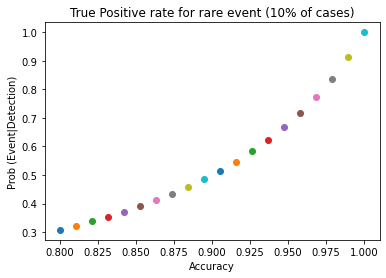

In [2]:
## Thinking about the probability of rare events, probably can skip
def bayes(b_a,a,b_na,na):
    return (b_a * a)/(b_a * a + b_na * na)

accuracy = .95

# For npb song
event_prob = .1
non_event_prob = 1-event_prob

args = [accuracy,event_prob,1-accuracy,non_event_prob]

print(accuracy,event_prob,bayes(*args),'\n')

fig,ax= plt.subplots()

for i in np.linspace(.8,1,20):
    accuracy = i
    args = [accuracy,event_prob,1-accuracy,non_event_prob]
    print(i,bayes(*args))
    ax.scatter(i,bayes(*args))
    
ax.set_title('True Positive rate for rare event (10% of cases)')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Prob (Event|Detection)')
fig.show()

In [ ]:
## Plot rattles vs Cubed leaves

## Make these alphabetic to match beween figures
rattle_leave_df = pd.read_csv('./AviaryDataFiles/tradeoff-revised.csv')


rattle_leave_df = rattle_leave_df.sort_values('name')

females_sorted = pd.unique(rattle_leave_df['name'])
f_to_color = dict(zip(females_sorted,re_index))
#print(f_to_color)
xs = rattle_leave_df['chatMDC']
ys = rattle_leave_df['cubeLeaves']

fit_line = np.poly1d(np.polyfit(xs,ys,1))

print('pearsons r,p-value:',pearsonr(xs,ys))
fig,ax = plt.subplots()

re_index = np.zeros(len(xs))

## xs is still a pandas object. This is why the colors line up the way they do.
for i in range(len(xs)):
    x = xs[i]
    y = ys[i]

    re_index[i] = rattle_leave_df['Female'].iloc[i] - 1
    ax.scatter(x,y,color=cm.viridis((i)/len(xs)),label=females_sorted[int(re_index[i])])


#ax.legend()
ax.plot([-10,180],fit_line([-10,180]),color='black',dashes=[2,2])   
ax.set_xlim([-5,100])
ax.set_ylim([0.5,4])
ax.set_xlabel('Total male-directed chatters')
ax.set_ylabel('Cubed root of total leaves')

if SAVE:
    fig.savefig('./fig6_cbrt.png',dpi=300)
    fig.savefig('./fig6_cbrt.svg')
fig.show()

In [ ]:
## Plot figure 7 by song
july_counts = pd.read_csv('./AviaryDataFiles/july-playbacks.csv')

props = np.array(july_counts['prop'])
sems = np.array(july_counts['sem'])

n_songs = 5
n_treatments = 4
treatments = ['Song-Control','BP-Chatter','Chatter','WhiteNoise']
treatments_index = [0,1,2,3]
fig,ax = plt.subplots()
for t in treatments_index:
    treatment_set = np.array([0,4,8,12,16]) + t
    xs = np.array([0,1,2,3,4]) + .2*t - .3
    ax.bar(xs,props[treatment_set],yerr=sems[treatment_set],width=.2,color=aviary_cmap(t/4),label=treatments[t])
    
ax.set_ylabel('Response Rate')
ax.set_xticks(range(5))
ax.set_xticklabels(['Song A','Song B','Song C','Song D','Song E'])
ax.legend()
fig.show()

In [ ]:
## Plot figure 7 by song and average
july_counts = pd.read_csv('./AviaryDataFiles/july-playbacks.csv')

props = np.array(july_counts['prop'])
sems = np.array(july_counts['sem'])

n_songs = 5
n_treatments = 4
treatments = ['Song-Control','BP-Chatter','Chatter','WhiteNoise']
treatments_index = [0,1,2,3]
fig,ax = plt.subplots()
for t in range(n_treatments):
    treatment_set = np.array([0,4,8,12,16]) + t
    xs = np.arange(0,.7,.15) + t
    ax.bar(xs,props[treatment_set],yerr=sems[treatment_set],width=.2,color=aviary_cmap(t/4),label=treatments[t])
    ax.bar(xs[2],np.mean(props[treatment_set]),width=.8,color = aviary_cmap(t/4),alpha=.5)
ax.set_ylabel('Response Rate')
ax.set_xticks(range(4))
#ax.set_xticklabels(['Song A','Song B','Song C','Song D','Song E'])
ax.legend()
fig.show()

In [ ]:
## Plot alternative figure 5

timing_df = pd.read_csv('./AviaryDataFiles/pb-npb-duets.csv')

rattles_pb = np.array(timing_df['Timing'][timing_df['Status'] == 'PB'])
rattles_npb = np.array(timing_df['Timing'][timing_df['Status'] == 'NPB'])
fig,ax = plt.subplots()
#ax.hist(rattles)
y_pb,x_pb,_ = ax.hist(rattles_pb,bins=np.arange(-3,2.5,.066) - 0.5,color=aviary_cmap(.3),alpha=.2)
y_npb,x_npb,_ = ax.hist(rattles_npb,bins=np.arange(-3,2.5,.066) - 0.5,color=aviary_cmap(.7),alpha = .2)
ax.scatter(np.mean(rattles_pb),.5,marker='v',color='tab:blue',zorder=2)
ax.scatter(np.mean(rattles_npb),.5,marker='v',color='tab:green',zorder=2)

pb_curve = gaussian_kde(rattles_pb,bw_method=.3)
xs = np.linspace(timing_df['Timing'].min(),timing_df['Timing'].max())

npb_curve = gaussian_kde(rattles_npb,bw_method=.3)


ax.plot(xs,pb_curve(xs) * max(y_pb) * .75,label='Pair bond',linewidth=3)
ax.plot(xs,npb_curve(xs) * max(y_npb) * .75,color=aviary_cmap(.7),label='Non-pair bond',linewidth=3)

ax.axvline(0,color='red',linestyle=':')
ax.set_xlabel('Chatter latency (s from song onset)')
ax.set_ylabel('Chatter events')
ax.set_xlim([-3,2]) ## How should we set this? 
ax.set_yticks(np.arange(0,21,5))
## Show minor xticks

ax.legend()
ax.set_ylim([0,20])
fig.show()

print(ttest_ind(rattles_pb,rattles_npb))

In [ ]:
## Show distribution of data

names = []
for m in metas:
    #print(m.name,sorted(m.m_ids),'\n')
    names.extend(m.m_ids)

name_to_year = {
    'M6-2010':2010,
    'M7-2010':2010,
    'COOP-2017':2017,
    'Darwin-2017':2017,
    'M1-2006':2006,
    'M2-2006':2006,
    'M3-2006':2006,
    'M4-2006':2006,
    'M1-2007':2007,
    'M2-2007':2007,
    'M3-2007':2007,
    'M4-2007':2007
}


for a in range(len(sorteds)):
    xs,ys = [],[]

    meta = metas[a]
    for l in range(len(sorteds[a])):
        line = sorteds[a][l]
        singer = line[0]
        receiver = line[1]
        line_stamp = meta.timestamps[l]
        try:
            s = meta.indices[singer]
            ys.append(s)
            xs.append(line_stamp)
            #ax.scatter(line_stamp,s,label=singer)
        except:
            pass
            #print('no singer:',l,s,singer)
        try:
            r = meta.indices[receiver]
            #ax.scatter(line_stamp,r,label=receiver)
            ys.append(r)
            xs.append(line_stamp)
        except:
            pass
            #print('no receiver',l,r,receiver)

    #xs = np.array(xs) / max(xs)
    xs = np.array(xs)
    ys = np.array(ys)

    fig,ax = plt.subplots()

    ax.scatter(xs,ys,alpha=.1)
    if '2006' in meta.name:
        cutoff = datetime(2006,5,12,0,0).timestamp()
        ax.axvline(cutoff,color='red',label='May 12')
        ax.legend()
    if meta.name == 'M1-2007' or meta.name == 'M4-2007':
        cutoff = datetime(2007,4,25,0,0).timestamp()
        ax.axvline(cutoff,color='red',label='April 25')
        ax.legend()

    ax.set_title(meta.name)
    ax.set_yticks(range(len(meta.indices)))
    ax.set_yticklabels(meta.indices)
    fig.set_size_inches(10,5)
    fig.show()


In [ ]:
## Check whether single songs are driving everything

fig,ax = plt.subplots()
all_values = rattle_dates_sparse[:,:,3][~np.isnan(rattle_dates_sparse[:,:,3])]



ax.hist(all_values[all_values != 0],normed=True,color='tab:blue',label='no zeros')
ax.hist(all_values,normed=True,color='tab:orange',label='with zeros')
ax.axhline(.2,color='tab:orange')
ax.axhline(1.8,color='tab:blue')
ax.set_ylabel('Normed density (lines represents 60 counts)')
ax.legend()
fig.show()

fig,ax = plt.subplots()
ax.hist(song_dates_sparse[:,:,3][~np.isnan(song_dates_sparse[:,:,3])],bins=50)
ax.set_xlim([0,10])
ax.set_ylabel('Non-pairbond song counts')
ax.set_xlabel('Non-pairbond song per day')
fig.show()

fig,ax1 = plt.subplots()

aviary_minutes_nan = np.array(aviary_minutes)
aviary_minutes_nan[aviary_minutes_nan == 0] = np.nan
print(aviary_minutes.shape,aviary_minutes_nan.shape)
ax1.plot(day_list_year,np.nanmean(song_dates_sparse[:,:,3],1),color='black',label='non-pairbond songs')
ax1.plot(day_list_year,day_minutes / 60,label='hours of recording')
ax1.plot(day_list_year,np.nanmean(aviary_minutes_nan,1),label='mean minutes recorded per aviary')
ax1.legend()

#ax1.fill_between(day_list_year,np.nanmax(song_dates_sparse[:,:,3],1),np.nanmin(song_dates_sparse[:,:,3],1))
for d in range(len(day_list_year)):
    all_dots = song_dates_sparse[d,:,3]
    all_dots = all_dots[~np.isnan(all_dots)].flatten()
    ax1.scatter([day_list_year[d]]*len(all_dots),all_dots,color='gray',alpha=.01)
    
ax1.set_xlim(day_list_year[0],160)

In [ ]:
## Old stuff, probably useless: 


"""    
## Plot all the things! ##
#all_rattle_probs = np.nan_to_num(all_rattle_probs)
#all_leave_probs = np.nan_to_num(all_leave_probs)
real_rattle_probs = all_rattle_probs[np.logical_not(np.isnan(all_rattle_probs))]
real_leave_probs = all_leave_probs[np.logical_not(np.isnan(all_leave_probs))]

real_pairbond_counts_rattles = all_pairbond_counts[np.logical_not(np.isnan(all_rattle_probs))]
real_pairbond_counts_leaves = all_pairbond_counts[np.logical_not(np.isnan(all_leave_probs))]

real_songs_rattles = all_songs_norm[np.logical_not(np.isnan(all_rattle_probs))]
real_songs_leaves = all_songs_norm[np.logical_not(np.isnan(all_leave_probs))]


all_rattle_probs = np.nan_to_num(all_rattle_probs)
all_leave_probs = np.nan_to_num(all_leave_probs)

slope1, intercept1, r1, p1, stderr1 = linregress(real_songs_rattles, real_rattle_probs)
slope2, intercept2, r2, p2, stderr2 = linregress(real_songs_leaves, real_leave_probs)
slope3, intercept3, r3, p3, stderr3 = linregress(real_pairbond_counts_rattles, real_rattle_probs)
slope4, intercept4, r4, p4, stderr4 = linregress(real_pairbond_counts_leaves, real_leave_probs)

fig, (ax1,ax2,ax3) = plt.subplots(1,3)

ax1.scatter(real_songs_rattles, real_rattle_probs)
plot_mb(ax1,slope1,intercept1,color='red',linestyle=':',
        label='r=' + str(np.round(r1,2)) +', p=' + str(np.round(p1,3)))
ax1.set_xlabel('Share of Male Countersong')
ax1.set_ylabel('Probability of Rattle Response')
ax1.legend()

ax2.scatter(real_pairbond_counts_rattles, real_rattle_probs)
plot_mb(ax2,slope3,intercept3,color='red',linestyle=':',
        label='r=' + str(np.round(r3,2)) +', p=' + str(np.round(p3,3)))
ax2.set_xlabel('Number of Pairbonds')
ax2.set_ylabel('Probability of Rattle Response')
ax2.legend()

ax3.scatter(real_pairbond_counts_leaves, real_leave_probs)
plot_mb(ax3,slope4,intercept4,color='red',linestyle=':',
        label='r=' + str(np.round(r4,2)) +', p=' + str(np.round(p4,3)))
ax3.set_xlabel('Number of Pairbonds')
ax3.set_ylabel('Probability of Leave Response')
ax3.legend()

print((r1,p1),(r2,p2),(r3,p3),(r4,p4))

fig.set_size_inches(12,5)
fig.tight_layout()
#fig.savefig('figure5-RattlebyQuality_no_skew.png',dpi=300)
fig.show()"""

print('Done!')

In [ ]:
## Plot old version of fig 4  (and t-test)
fig,ax = plt.subplots()

#all_data_by_bird is a list of each aviaries' data
# Sub lists are [pairbond_probs, vice_probs_1, other_probs_1] which contain all the birds in that aviary
# For each aviary:
n_aviaries = len(all_data_by_bird)
aviary_cmap = cm.get_cmap('viridis')
for a in range(len(all_data_by_bird)):
    for d in range(3):

        ys = all_data_by_bird[a][d]
        xs = np.array([d + a*.05] * len(ys)) - .25
        ax.scatter(xs,ys,color=aviary_cmap(a / len(all_data_by_bird)),s=10,label='Aviary '+str(a+1))


        
all_pairs_list = np.hstack([all_data_by_bird[a][0] for a in range(n_aviaries)])
all_vices_list = np.hstack([all_data_by_bird[a][1] for a in range(n_aviaries)])
all_other_list = np.hstack([all_data_by_bird[a][2] for a in range(n_aviaries)])

all_pairs_list = all_pairs_list[~np.isnan(all_pairs_list)]
all_vices_list = all_vices_list[~np.isnan(all_vices_list)]
all_other_list = all_other_list[~np.isnan(all_other_list)]

mean_all_pairs = np.nanmean(np.hstack([all_data_by_bird[a][0] for a in range(n_aviaries)]))
mean_all_vices = np.nanmean(np.hstack([all_data_by_bird[a][1] for a in range(n_aviaries)]))
mean_all_other = np.nanmean(np.hstack([all_data_by_bird[a][2] for a in range(n_aviaries)]))

std_all_pairs = np.nanstd(np.hstack([all_data_by_bird[a][0] for a in range(n_aviaries)]))
std_all_vices = np.nanstd(np.hstack([all_data_by_bird[a][1] for a in range(n_aviaries)]))
std_all_other = np.nanstd(np.hstack([all_data_by_bird[a][2] for a in range(n_aviaries)]))

n_pairs = np.sum(~np.isnan(np.hstack([all_data_by_bird[a][0] for a in range(n_aviaries)])))
n_vices = np.sum(~np.isnan(np.hstack([all_data_by_bird[a][1] for a in range(n_aviaries)])))
n_other = np.sum(~np.isnan(np.hstack([all_data_by_bird[a][2] for a in range(n_aviaries)])))

mean_bird_bars = [mean_all_pairs,mean_all_vices,mean_all_other]
std_bird_bars = [std_all_pairs,std_all_vices,std_all_other]
sem_bird_bars = [std_all_pairs / np.sqrt(n_pairs),std_all_vices / np.sqrt(n_vices),std_all_other / np.sqrt(n_other)]

#print(mean_bird_bars,sem_bird_bars)

ax.hlines(mean_bird_bars,np.arange(3) - .3,np.arange(3) + .3,color='black')

for b in range(3):
    sem = sem_bird_bars[b]
    ax.fill_between([b-.3,b+.3],mean_bird_bars[b] - 2 * sem, 
                    mean_bird_bars[b] + 2 * sem,color='gray',alpha=.8)
       
        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
#fig.legend(by_label.values(), by_label.keys())

ax.set_xticks(range(3))
ax.set_xticklabels(['Pairbond','Next-best male','Non-pairbonds (all)'])
ax.set_ylabel('Probability of chatter following song')
fig.set_size_inches(10,5)
fig.show()

print('All vs vice:')
print(ttest_ind(all_pairs_list,all_vices_list)) 
print('Pairbond vs all other')
print(ttest_ind(all_pairs_list,all_other_list))

print('Vice vs other')
print(ttest_ind(all_vices_list,all_other_list))

print(len(all_pairs_list))

## REMEMBER to center those gray lines

In [ ]:
## Even older version of fig 4
print(np.shape(all_the_bars))

bar_array = np.reshape(all_the_bars,[len(historys),5])
err_array = np.reshape(all_the_errs,[len(historys),5])

mean_bar = np.mean(bar_array,0)
std_bar_groups = np.std(bar_array,0)
sem_bar_groups = std_bar_groups / np.sqrt(6)

"""# Maybe you want to ignore lesion aviaries entirely
mean_bar = np.mean(bar_array[[1,2,4,5]],0)
std_bar_groups = np.std(bar_array[[1,2,4,5]],0)
sem_bar_groups = std_bar_groups / np.sqrt(4)
"""
mean_err = np.mean(err_array,0)

fig,ax = plt.subplots()

## I don't want all of the bars. 0,2,3 correspond to [*mean_pairbond_probs*,mean_vice_probs,*mean_vice_probs_1*,*mean_other_probs_1*,mean_other_probs]
bs = np.array([0,2,3])

#ax.bar(np.arange(3) - .05,mean_bar[[0,1,4]],yerr=mean_err[[0,1,4]] / np.sqrt(6), ecolor='blue',alpha=.9,width=.6)
ax.hlines(mean_bar[bs],np.arange(len(bs)) - .3,np.arange(len(bs)) + .3)
for b in range(len(bs)):
    err_b = bs[b]
    ax.fill_between([b-.3,b+.3],mean_bar[err_b] - 2 * sem_bar_groups[err_b] / np.sqrt(6), 
                    mean_bar[err_b] + 2 * sem_bar_groups[err_b] / np.sqrt(6),color='gray',alpha=.6)

b_width = .03

cmap = cm.get_cmap('YlOrRd')
for a in range(len(historys)):

    #ax.bar(np.arange(3) + b_width * b - .3, bar_array[b,[0,1,4]],yerr = err_array[b,[0,1,4]],  width=b_width)
    #ax.bar(np.arange(3) + b_width * b - .3, bar_array[b,[0,1,4]], width=b_width, alpha=.5)
    ax.errorbar(np.arange(len(bs)) + b_width * a - .25, bar_array[a,bs],
                yerr = err_array[a,bs],fmt='o',label=metas[a].name,color = cmap(b_width*a * 1.5 + .3))

ax.set_ylim([0,.6])
ax.set_title('Probability of rattling in response to song from different males')
ax.set_ylabel('Probability of rattling following song')
#ax.set_xticks(range(5))
#ax.set_xticklabels(['Pairbond','Max rattles \nto a non-pairbond','Non-pairbonds \n(that sang >5)','Non-pairbonds \n(that sang >1)','Non-pairbonds \n(all)'])
ax.set_xticks(range(len(bs)))
ax.set_xticklabels(['Pairbond','Next-best male','Non-pairbonds \n(all)'])
ax.minorticks_on()
ax.yaxis.grid(which='major',alpha=.2)
ax.yaxis.grid(which='minor',alpha=.2)

fig.set_size_inches(10,5)
ax.legend()
fig.tight_layout()

#fig.savefig('figure4-RattlesbyType_take2.png',dpi=300)
fig.show()


In [ ]:
### T-test for old figure 4 
print('All groups:')
print(ttest_ind(bar_array[:,0],bar_array[:,2]))
print(ttest_ind(bar_array[:,2],bar_array[:,3]))
print(ttest_ind(bar_array[:,0],bar_array[:,3]))


In [ ]:
### Make database for a model, we no longer need this, but it could be handy
#print(song_dates.shape)

index_to_date = sorted(day_to_index.keys())
#print(index_to_date)
# Need to recover year: 
#print(aviary_splits)
aviary_to_year = [2010,2010,2017,2017,2006,2006,2006,2006,2007,2007,2007,2007]

index_to_aviary = np.empty(song_dates.shape[1])
#index_to_date = np.empty(song_dates.shape[0])
aviary_splits = np.array(aviary_splits)
aviary_n_males = [0]
for m in range(len(metas)):
    meta = metas[m]
    aviary_n_males.append(meta.n_males + aviary_n_males[m])
    
header='Row,F_index,Female,A_index,Aviary,DayOfYear,Year,Date,'\
        'PB_Ratio,VPB_Ratio,Other_Ratio,'\
        'PB_Index,PB_Name,VPB_Index,VPB_Name\n'

#print(header)
with open('./pairbond_dataframe_sliding.csv','w') as out_file:
    out_file.write(header)
    count = 0
    for f in range(rattle_dates.shape[1]):
        some_logic = (aviary_splits[1:] - 1 >= f)

        aviary_index = np.argmax(some_logic)
        index_to_aviary[f] = aviary_index
        f_year = aviary_to_year[aviary_index]
        aviary_name = metas[aviary_index].name
        f_index = f - aviary_splits[aviary_index]
        f_name = metas[aviary_index].f_ids[f_index]
        PB_index = int(metas[aviary_index].f_pairmates[f_index])
        VPB_index = int(metas[aviary_index].f_vicemates[f_index])
        PB_name = metas[aviary_index].m_ids[PB_index]
        VPB_name = metas[aviary_index].m_ids[VPB_index]
        PB_itrue = PB_index + aviary_n_males[aviary_index]
        VPB_itrue = VPB_index + aviary_n_males[aviary_index]
        for d in range(rattle_dates.shape[0]):
            if not np.nansum(rattle_dates[d,f,1:]) > 0:
                continue
            else:
                date = index_to_date[d]
                day_of_year = datetime.strptime(str(f_year)+'-'+ date,'20%y-%m-%d').timetuple().tm_yday
                out_list = [count,f,f_name,aviary_index,aviary_name,day_of_year,f_year,date,
                            rattle_dates[d,f,1],rattle_dates[d,f,2],rattle_dates[d,f,3],
                            PB_itrue,PB_name,VPB_itrue,VPB_name]
                out_string = ",".join([str(o) for o in out_list])
                #print(out_string)
                count += 1
                out_file.write(out_string + '\n')
                #print(f,f_name,aviary_index,f_year,aviary_name,day_of_year,index_to_date[d],
                #      'PB Ratio:',rattle_dates[d,f,1],'VPB Ratio:',rattle_dates[d,f,2],'All Other Ratio:',rattle_dates[d,f,3])

